- V02 (2020/12/01): Add heart failure
- V01 (2020/11/11): Separate differential expression from eQTLs (two manuscripts)
- V04 (2020/10/26): reordered figures 1 and 2, supplemental figure numbers updated
- V03 (2020/09/24): finalizing Figure 2 (differential expression analysis) with Hiroko's validation of scRNA-seq data and right figure and table numbers
- V02 (2020/08/12): changed interactions from stage_specific and cell_specific to only cell_specific

In [1200]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls")

source("script/packages.R"  )
source("script/input_data.R")
source("script/functions.R" )
source("script/colors.R"    )


In [6]:
dir.create("manuscript/cardiac_differential_expression", showWarnings = FALSE)

In [1444]:
suppressPackageStartupMessages(library(shape         ))
suppressPackageStartupMessages(library(wordcloud     ))
suppressPackageStartupMessages(library(Seurat        ))
suppressPackageStartupMessages(library(monocle       ))
suppressPackageStartupMessages(library(gplots        ))


# Input data

In [8]:
geneinfo_start_genes    = fread("input/phenotypes/gene_info.txt"   , sep = "\t", header = TRUE , data.table = FALSE)
geneinfo_start_isoforms = fread("input/phenotypes/isoform_info.txt", sep = "\t", header = TRUE , data.table = FALSE)

nrow(geneinfo_start_genes   )
nrow(geneinfo_start_isoforms)

nrow(geneinfo_start_genes   [geneinfo_start_genes   $chrom %in% paste("chr", 1:22, sep = ""),])
nrow(geneinfo_start_isoforms[geneinfo_start_isoforms$chrom %in% paste("chr", 1:22, sep = ""),])
#/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/pipeline/2.1.scrna_seq

[1] 62492

[1] 229835

[1] 59328

[1] 221638

In [165]:
gene_tpm   = add_rownames(fread("pipeline/1.2.expression/tpm_gene.normalized.txt"   , sep = "\t", header = TRUE , data.table = FALSE))
isof_tpm   = add_rownames(fread("pipeline/1.2.expression/tpm_isoform.normalized.txt", sep = "\t", header = TRUE , data.table = FALSE))
isof_use   = add_rownames(fread("pipeline/1.2.expression/use_isoform.expressed.txt", sep = "\t", header = TRUE , data.table = FALSE))


In [45]:
exons = fread("/frazer01/reference/private/Gencode.v34lift37/exon_info.txt", sep = "\t", header = TRUE, data.table = FALSE)

In [9]:
geneinfo_genes    = fread("pipeline/1.2.expression/gene_info.txt"   , sep = "\t", header = TRUE , data.table = FALSE)
geneinfo_isoforms = fread("pipeline/1.2.expression/isoform_info.txt", sep = "\t", header = TRUE , data.table = FALSE)


In [10]:
covariates  = add_rownames(fread("pipeline/3.1.covariates/covariates.txt", sep = "\t", header = TRUE, data.table = FALSE))
metadata    =              fread("pipeline/3.1.covariates/metadata.txt"  , sep = "\t", header = TRUE, data.table = FALSE)
subinfo     = merge(metadata[, c("run", "subject_id", "subject_name", "study")], covariates[,c("sex", "age", "height", "weight", "bmi", paste("pc", 1:20, sep = ""))], by.x = "run", by.y = "row.names")
subinfo$run = NULL
subinfo     = unique(subinfo)
covariates  = merge(metadata[,c("assay_id", "run", "subject_id", "study", "tissue", "body_site")], covariates, by.x = "run", by.y = "row.names")


## Initial numbers

In [11]:
message(paste("Samples (N)"           , nrow(covariates                                                      ) , sep = " = "))
message(paste("Subjects (N)"          , nrow(subinfo                                                         ) , sep = " = "))
message(paste("Samples (N - iPSCORE)" , nrow(covariates[covariates$study          == "ipscore",             ]) , sep = " = "))
message(paste("Samples (N - GTEx)"    , nrow(covariates[covariates$study          == "gtex"   ,             ]) , sep = " = "))
message(paste("Subjects (N - iPSCORE)", length(unique(covariates[covariates$study == "ipscore", "subject_id"])), sep = " = "))
message(paste("Subjects (N - GTEx)"   , length(unique(covariates[covariates$study == "gtex"   , "subject_id"])), sep = " = "))

invisible(lapply(sort(unique(covariates$body_site)), function(x)
{
    message(paste("Samples (", x, ") = " , nrow(covariates[covariates$body_site == x,]) , sep = ""))
}))

Samples (N) = 966

Subjects (N) = 491

Samples (N - iPSCORE) = 180

Samples (N - GTEx) = 786

Subjects (N - iPSCORE) = 139

Subjects (N - GTEx) = 352

Samples (arteria_aorta) = 227

Samples (arteria_coronary) = 125

Samples (heart_atrium) = 196

Samples (heart_ventricle) = 238

Samples (ipsc_cvpc) = 180



In [1941]:
message(paste("Expressed genes"   , nrow(gene_tpm), sep = " = "))
message(paste("Expressed isoforms", nrow(isof_use), sep = " = "))


Expressed genes = 20393

Expressed isoforms = 38271



# Functions

In [12]:
values2color = function(x, colorscale = colorpanel(n = 100, low = "#ffeeee", high = cm.color), minval = NA, maxval = NA)
{
    if (is.na(minval) == TRUE){minval = min(x)}
    if (is.na(maxval) == TRUE){maxval = min(x)}
    if (length(x[is.na(x) == TRUE]) > 0){x[is.na(x) == TRUE] = minval}
    if (length(x[x < minval      ]) > 0){x[x < minval      ] = minval}
    if (length(x[x > maxval      ]) > 0){x[x > maxval      ] = maxval}

    y = round((x - minval) * length(colorscale) / (maxval - minval))
    if (length(y[y < 1]) > 0){y[y < 1] = 1}
    
    z = colorscale[y]
    
    return(z)
}


# Figures and Tables
## Table S1-2: subject and sample information
- Table S1: description of subjects included in this study.
- Table S2: description of RNA-seq samples.

In [53]:
load("/frazer01/home/jennifer/projects/cardiac_eqtls/3.Clustering/results/cardips.robj")
load("/frazer01/home/jennifer/projects/cardiac_eqtls/3.Clustering/results/cardips_monocle.robj")

#umap_bulk0 = cardips@meta.data
#umap_bulk1 = cardips@meta.data


In [59]:
pseudotime           = as.data.frame(HSMM@phenoData@data)
colnames(pseudotime) = tolower(colnames(pseudotime))


In [84]:
umap_bulk0          = as.data.frame(cardips@meta.data)
umap_bulk1          = as.data.frame(cardips@reductions$pca @cell.embeddings)
umap_bulk2          = as.data.frame(cardips@reductions$umap@cell.embeddings)
umap_bulk0$run      = rownames(umap_bulk0)
umap_bulk           = merge(umap_bulk0, umap_bulk1,                           by.x = "run", by.y = "row.names")
umap_bulk           = merge(umap_bulk , umap_bulk2,                           by.x = "run", by.y = "row.names")
umap_bulk           = merge(umap_bulk , pseudotime[, c("run", "pseudotime")], by.x = "run", by.y = "row.names")
umap_bulk$tissue    = umap_bulk$body_site
umap_bulk$s_score   = umap_bulk$S.Score
umap_bulk$g2m_score = umap_bulk$G2M.Score
umap_bulk$tissue    = umap_bulk$body_site
umap_bulk$body_site = NULL

for(res in c((0:9) * 0.01, (1:10) * 0.1))
{
    umap_bulk[,paste("res", res, sep = "_")] = as.numeric(umap_bulk[,paste("RNA_snn_res", res, sep = ".")])
}

table(umap_bulk$tissue)



    aorta    atrium  coronary ipsc_cvpc ventricle 
      227       196       125       180       238 

In [17]:
totrim   = list.files("/frazer01/projects/CARDIPS/analysis/trimread_validation/pipeline", recursive = FALSE)
ipscore1 = fread("input/external/PMID_31668852//Table_S1A.txt", sep = "\t", header = TRUE, data.table = FALSE)
ipscore2 = fread("input/external/PMID_31668852//Table_S1B.txt", sep = "\t", header = TRUE, data.table = FALSE)
udids    = fread("pipeline/1.1.metadata//meta_rna.txt"        , sep = "\t", header = TRUE, data.table = FALSE)

colnames(ipscore1) = tolower(gsub("\\.", "_", colnames(ipscore1)))
colnames(ipscore2) = tolower(gsub(" "  , "_", gsub("\\.", "_", colnames(ipscore2))))

ipscore2 = merge(ipscore2, udids[,c("udid", "run")])

In [849]:
table_s1           = merge(subinfo, ipscore1[,c("subject_uuid", "family_id", "twin_id_dbgap", "twin_type_dbgap", "father_subject_id_dbgap", "mother_subject_id_dbgap")], all.x = TRUE, by.x = "subject_id", by.y = "subject_uuid")

table_s1[is.na(table_s1$twin_id_dbgap          ) == FALSE & table_s1$twin_id_dbgap           == "0", "twin_id_dbgap"          ] = ""
table_s1[is.na(table_s1$twin_type_dbgap        ) == FALSE & table_s1$twin_type_dbgap         == "0", "twin_type_dbgap"        ] = ""
table_s1[is.na(table_s1$father_subject_id_dbgap) == FALSE & table_s1$father_subject_id_dbgap == "0", "father_subject_id_dbgap"] = ""
table_s1[is.na(table_s1$mother_subject_id_dbgap) == FALSE & table_s1$mother_subject_id_dbgap == "0", "mother_subject_id_dbgap"] = ""

table_s1[is.na(table_s1$twin_id_dbgap          ) == TRUE, "twin_id_dbgap"          ] = ""
table_s1[is.na(table_s1$twin_type_dbgap        ) == TRUE, "twin_type_dbgap"        ] = ""
table_s1[is.na(table_s1$father_subject_id_dbgap) == TRUE, "father_subject_id_dbgap"] = ""
table_s1[is.na(table_s1$mother_subject_id_dbgap) == TRUE, "mother_subject_id_dbgap"] = ""

colnames(table_s1) = c("Subject ID", 
                       "Subject name",
                       "Source", 
                       "Sex", 
                       "Age", 
                       "Height", 
                       "Weight", 
                       "BMI",
                       paste("PC", 1:20, sep = ""),
                       "iPSCORE family ID",
                       "iPSCORE twin ID (dbGaP)",
                       "iPSCORE twin type (dbGaP)",
                       "iPSCORE father ID (dbGaP)",
                       "iPSCORE mother ID (dbGaP)"
                      )

table_s1$Sex    = suppressMessages(mapvalues(table_s1$Sex   , from=c(0,1              ), to = c("M", "F"         )))
table_s1$Source = suppressMessages(mapvalues(table_s1$Source, from=c("ipscore", "gtex"), to = c("iPSCORE", "GTEx")))


In [1854]:
table_s2 = merge(covariates, ipscore2[,c("run", "udid", "ipsc_ipscore_id", "ipscore_resource", "ipsc_id")], all.x = TRUE)
table_s2 = merge(table_s2, umap_bulk[,c("run", "UMAP_1", "UMAP_2", "s_score", "g2m_score", "pseudotime", paste("PC", 1:10, sep = "_"), paste("res", c(0, 0.01, 0.2, 0.7), sep = "_"))])

table_s2[is.na(table_s2$udid            ) == TRUE, "udid"            ] = ""
table_s2[is.na(table_s2$ipsc_ipscore_id ) == TRUE, "ipsc_ipscore_id" ] = ""
table_s2[is.na(table_s2$ipscore_resource) == TRUE, "ipscore_resource"] = ""
table_s2[is.na(table_s2$ipsc_id         ) == TRUE, "ipsc_id"         ] = ""

table_s2 = table_s2[,c("study", 
                       "subject_id", 
                       "assay_id", 
                       "run", 
                       "udid", "ipsc_ipscore_id", "ipsc_id",
                       "total_reads", 
                       "uniquely_mapped_reads_to_canonical_chromsomes", 
                       "mitochondrial_reads", 
                       "arteria", "heart", "ipsc_cvpc", 
                       "arteria_aorta", "arteria_coronary", "heart_atrium", "heart_ventricle", 
                       paste("PC", 1:10, sep = "_"), 
                       "UMAP_1", "UMAP_2", "s_score", "g2m_score", "pseudotime",
                       paste("res", c(0, 0.01, 0.2, 0.7), sep = "_"),
                       colnames(covariates)[grepl("cibersort.regular", colnames(covariates)) == TRUE],
                       paste("peer"          , 1:285     , sep = "")
                      )]

colnames(table_s2) = c("Source", 
                       "Subject ID", 
                       "Assay ID", 
                       "SRA Run ID", 
                       "iPSCORE UDID", "iPSCORE iPSC ID (dbGaP)", "iPSCORE iPSC ID",
                       "Total number of reads", 
                       "Uniquely mapped reads to chr1-22, X or Y (%)",
                       "Mitochondrial reads (%)", 
                       "Arteria", "Heart", "iPSC-CVPC", 
                       "Aorta", "Coronary artery", "Atrial appendage", "Left ventricle", 
                       paste("PC"  , 1: 10, sep = ""),
                       "UMAP1", "UMAP2", "S score", "G2M score", "Pseudotime",
                       paste("Cluster", c(0, 0.01, 0.2, 0.7), "resolution"),
                       gsub("\\.", " ", gsub("_", " ", gsub("cibersort", "CIBERSORT", gsub("combined", "(collapsed cell types)", gsub("regular\\.", "", colnames(covariates)[grepl("cibersort.regular", colnames(covariates)) == TRUE]))))),
                       paste("PEER", 1:285, sep = "")
                      )
table_s2 = table_s2[,grepl("PEER", colnames(table_s2)) == FALSE]

table_s2$Source = suppressMessages(mapvalues(table_s2$Source, from=c("ipscore", "gtex"), to = c("iPSCORE", "GTEx")))
table_s2$Trimmed = "No"
table_s2[table_s2[, "SRA Run ID"] %in% totrim, "Trimmed"] = "Yes"


In [1855]:
fwrite(table_s1, "manuscript/cardiac_differential_expression/table_s1.csv", sep = ",", col.names = TRUE, row.names = FALSE)
fwrite(table_s2, "manuscript/cardiac_differential_expression/table_s2.csv", sep = ",", col.names = TRUE, row.names = FALSE)

## Figure S1: Description of the subjects included in this study 
- (A) Sex and (B) age distribution between iPSCORE individuals (blue) and GTEx individuals (pink).
- (C) PCA showing the ancestry of all subjects. Colored circles represent ancestry of individuals from the 1000 Genomes Project. GTEx and iPSCORE individuals are represented by pink and blue “X”, respectively.


In [21]:
kgp              =              add_rownames(fread("input/genotypes/kgp_populations.txt", sep = " " , header = FALSE, data.table = FALSE))
gt_pca           = add_rownames(add_rownames(fread("input/genotypes/genotype_pca.txt"   , sep = " " , header = FALSE, data.table = FALSE)))
colnames(gt_pca) = paste("pc", 1:ncol(gt_pca), sep = "")
colnames(kgp   ) = c("wgs_id", "cluster")
kgp              = kgp[!kgp$wgs_id %in% metadata$wgs_id,]


png 
  2

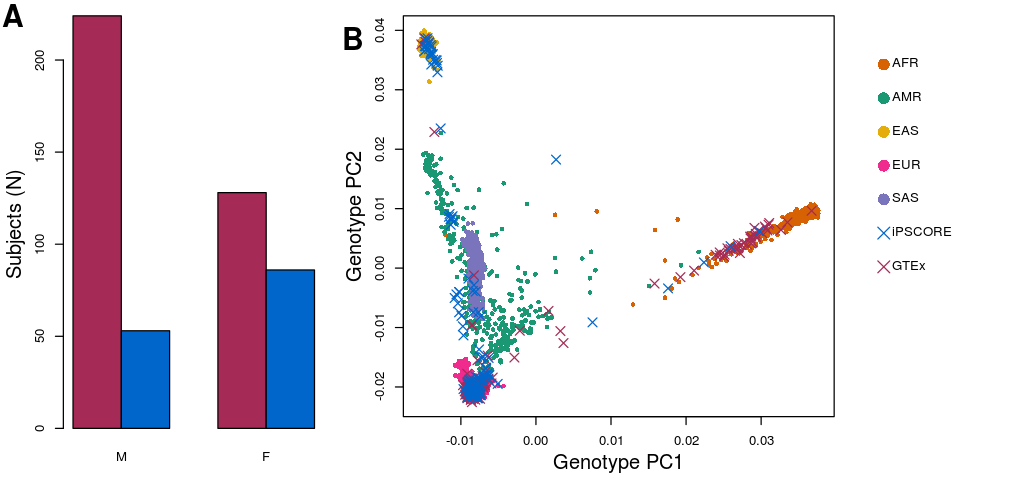

In [1093]:
figure_s1a = function()
{
    sexdata           = as.matrix(table(subinfo[,c("sex", "study")]))
    rownames(sexdata) = c("M", "F")
    colnames(sexdata) = c("GTEx", "iPSCORE")
    mycolors          = data.frame(study = colnames(sexdata), color = study2color[c("gtex", "ipscore"), "color"])
    
    par(mar = c(3,4,1,1))
    barplot(t(sexdata), beside = TRUE, col = mycolors$color)
    mtext(text = "Subjects (N)", side = 2, line = 2.5)
    mtext(text = "A"           , side = 2, line = 2.5, at = max(as.numeric(as.matrix(sexdata))), font = 2, cex = 1.5, las = 2)
}

figure_s1b = function()
{
    agedata = merge(subinfo[,c("study", "age")], data.frame(study = c("ipscore", "gtex"), name = c("iPSCORE", "GTEx")))
    
    par(mar = c(3,4,1,1))
    
    mycolors = study2color[c("gtex", "ipscore"), "color"]
    boxplot(age ~ name, data = agedata, col = mycolors, outline = FALSE, ylab = "")
    mtext(text = "Age (years)", side = 2, line = 2.5)
    mtext(text = "B"          , side = 2, line = 2.5, at = max(agedata$age), font = 2, cex = 1.5, las = 2)
}

figure_s1c = function()
{
    subinfo     = merge(subinfo, study2color)
    cluster2col = data.frame(cluster = c("AFR", "AMR", "EAS", "EUR", "SAS"), color = paste(c("#d76203", "#1a9873", "#e4ad0a", "#ef2b8d", "#7a74bc"), "ff", sep = ""))
    pcadata     = merge(cbind(kgp, gt_pca[kgp$wgs_id,]), cluster2col, all.x = TRUE)
    pcadata$pch = 16

    par(mar = c(4,4,1,1))
    plot  (pcadata$pc1, pcadata$pc2, col = pcadata$color, pch = 16, cex = 0.8, xlab = "", ylab = "")
    points(subinfo$pc1, subinfo$pc2, col = subinfo$color, pch =  4, cex = 1.5)
    mtext(text = "Genotype PC1", side = 1, line = 2.5)
    mtext(text = "Genotype PC2", side = 2, line = 2.5)
    mtext(text = "B"           , side = 2, line = 2.5, at = max(subinfo$pc2), font = 2, cex = 1.5, las = 2)
    
    par(mar = c(4,1,1,1))
    plot(1,1, xlim = c(0,1), ylim = c(1,0), type = "n", xlab = "", ylab = "", axes = FALSE)
    
    points(rep(0.1, nrow(cluster2col) + 2), (1:(nrow(cluster2col) + 2)) / (nrow(cluster2col) + 6), pch    = c(rep(16, nrow(cluster2col)), 4, 4), col = c(cluster2col$color, study2color[c("ipscore", "gtex"), "color"]), cex = 2)
    text  (rep(0.1, nrow(cluster2col) + 2), (1:(nrow(cluster2col) + 2)) / (nrow(cluster2col) + 6), labels = c(cluster2col$cluster, "iPSCORE", "GTEx"), pos = 4)

}

figure_s1 = function()
{
    #layout(rbind(c(1,1,2,2), 
    #             c(3,3,3,4)))
    layout(rbind(c(1,1,2,2,2,3)))
    
    figure_s1a()
    #figure_s1b()
    figure_s1c()
}

options(repr.plot.width = 8.5, repr.plot.height = 4)
figure_s1()

png(filename = "manuscript/cardiac_differential_expression/figure_S1.png", width = 8.5, height = 4, units = "in", res = 300)
figure_s1()
dev.off()

In [23]:
message("GTEx enrichment for male individuals: p = ", signif(fisher.test(table(subinfo[,c("sex", "study")]))$p.value, digits = 3), " (Fisher's exact test)", sep = "")

GTEx enrichment for male individuals: p = 3.68e-07 (Fisher's exact test)



## Table S19: influence of read length
- 50 samples

In [878]:
geneinfo_genes_all    = fread("input/phenotypes/gene_info.txt"   , sep = "\t", header = TRUE , data.table = FALSE)
geneinfo_isoforms_all = fread("input/phenotypes/isoform_info.txt", sep = "\t", header = TRUE , data.table = FALSE)

geneinfo_genes_all$transcript_id = geneinfo_genes_all$gene_id

In [879]:
bl_gene    = fread    ("/projects/CARDIPS/analysis/trimread_validation/pval/gene_tpm.txt"           , sep = " ", header = FALSE, data.table = FALSE)[,1:3]
bl_isoform = fread    ("/projects/CARDIPS/analysis/trimread_validation/pval/isoform_percent_use.txt", sep = " ", header = FALSE, data.table = FALSE)[,2:4]
dr_gene    = readLines("pipeline/1.2.expression/blacklist_gene.txt"   )
dr_isof    = readLines("pipeline/1.2.expression/blacklist_isoform.txt")

colnames(bl_gene   ) = c("transcript_id", "pval", "qval")
colnames(bl_isoform) = c("transcript_id", "pval", "qval")

bl_gene   $source = "gene"
bl_isoform$source = "isoform"

blacklist = rbind(bl_gene, bl_isoform)
blacklist = merge(blacklist, rbind(geneinfo_genes_all[,c("transcript_id", "gene_id")], geneinfo_isoforms_all[,c("transcript_id", "gene_id")]))

blacklist$blacklisted = FALSE

blacklist[blacklist$gene_id %in% c(dr_gene, dr_isof), "blacklisted"] = TRUE

In [1876]:
table_s19 = blacklist

colnames(table_s19) = c("ID (gene or isoform)", "p-value (paired t-test)", "FDR (Bonferroni)", "Source (gene or isoform)", "Gene ID", "Blacklisted")

table_s19_small = table_s19[table_s19[,"Blacklisted"] == TRUE, ]
table_s19_big   = table_s19

table_s19[,"Blacklisted"] = NULL

fwrite(table_s19_small, "manuscript/cardiac_differential_expression/table_s19.csv"         , sep = ",", col.names = TRUE, row.names = FALSE)
fwrite(table_s19_big  , "manuscript/cardiac_differential_expression/table_s19_complete.csv", sep = ",", col.names = TRUE, row.names = FALSE)


In [881]:
message(paste("Genes directly affected by read length"     , length(unique(bl_gene  [bl_gene  $qval        <= 0.05                                , "transcript_id"])), sep = " = "))
message(paste("Genes affected by read length"              , length(unique(blacklist[blacklist$blacklisted == TRUE                                , "gene_id"      ])), sep = " = "))
message(paste("Isoforms affected by read length"           , length(unique(blacklist[blacklist$blacklisted == TRUE & blacklist$source == "isoform", "transcript_id"])), sep = " = "))
message(paste("Genes with isoforms affected by read length", length(unique(blacklist[blacklist$blacklisted == TRUE & blacklist$source == "isoform", "gene_id"      ])), sep = " = "))


Genes directly affected by read length = 299

Genes affected by read length = 1059

Isoforms affected by read length = 8999

Genes with isoforms affected by read length = 949



# Figure 1: Stage-specific expression differences between cardiac samples (gene)

In [24]:
diftiss0    = fread("pipeline/4.1.differential_expression/diffexp.txt"     , sep = "\t", header = TRUE, data.table = FALSE)
difcell0    = fread("pipeline/4.1.differential_expression/diffexp_cell.txt", sep = "\t", header = TRUE, data.table = FALSE)
diftiss     = diftiss0[diftiss0$type == "gene_tpm"   ,]
difcell     = difcell0[difcell0$type == "gene_tpm"   ,]
diftiss_iso = diftiss0[diftiss0$type == "isoform_use",]
difcell_iso = difcell0[difcell0$type == "isoform_use",]


In [25]:
length(unique(diftiss_iso$transcript_id))
length(unique(diftiss_iso$gene_id))
length(unique(diftiss    $gene_id))


[1] 38271

[1] 10686

[1] 20393

In [26]:
difct0    = fread("pipeline/4.1.differential_expression/diffexp_cell_tissue.txt", sep = "\t", header = TRUE, data.table = FALSE)
difct     = difct0[difct0$name == "gene_tpm"   ,]
difct_iso = difct0[difct0$name == "isoform_use",]


In [27]:
difct_all = merge(difct[, c("transcript_id", "tissue", "cell_type", "beta", "se", "pval", "qval")], 
                  difct[, c("transcript_id", "tissue", "cell_type", "beta", "se", "pval", "qval")],
                  by = c("transcript_id", "cell_type"),
                  suffixes = 1:2
                )

In [29]:
difct_cm = merge(difct[difct$tissue == "ipsc_cvpc" & difct$cell_type == "cibersort.regular.cardiac_muscle", c("transcript_id", "beta", "se", "pval", "qval")], 
                 difct[difct$tissue == "heart"     & difct$cell_type == "cibersort.regular.cardiac_muscle", c("transcript_id", "beta", "se", "pval", "qval")],
                 by = "transcript_id",
                 suffixes = 1:2
                )

diffct_iso_cm = merge(difct_iso[difct_iso$tissue == "ipsc_cvpc" & difct_iso$cell_type == "cibersort.regular.cardiac_muscle", c("transcript_id", "beta", "se", "pval", "qval")], 
                      difct_iso[difct_iso$tissue == "heart"     & difct_iso$cell_type == "cibersort.regular.cardiac_muscle", c("transcript_id", "beta", "se", "pval", "qval")],
                      by = "transcript_id",
                      suffixes = 1:2
                     )

In [30]:
difct_all           = difct_all[difct_all$tissue1 != difct_all$tissue2,]
difct_all$cell_type = gsub("cibersort.regular.", "", difct_all$cell_type)

difct_comb = data.frame(tissue1   = c(rep("ipsc_cvpc", 4), rep("ipsc_cvpc", 2), rep("heart"  , 2)),
                        tissue2   = c(rep("heart"    , 4), rep("arteria"  , 2), rep("arteria", 2)),
                        cell_type = c("cardiac_muscle", "smooth_muscle", "endothelial", "endocardial", 
                                      "smooth_muscle", "endocardial",
                                      "smooth_muscle", "endocardial"
                                     )
                       )
difct_comb$y = 1:nrow(difct_comb)
difct_comb[5:nrow(difct_comb), "y"] = difct_comb[5:nrow(difct_comb), "y"] + 1
difct_comb[7:nrow(difct_comb), "y"] = difct_comb[7:nrow(difct_comb), "y"] + 1

difct_comb = cbind(difct_comb, as.data.frame(rbindlist(lapply(1:nrow(difct_comb), function(ii)
{
    tissue1 = difct_comb[ii, "tissue1"  ]
    tissue2 = difct_comb[ii, "tissue2"  ]
    cell    = difct_comb[ii, "cell_type"]
    
    this    = difct_all[difct_all$tissue1 == tissue1 & difct_all$tissue2 == tissue2 & difct_all$cell_type == cell,]
    out     = data.frame(tissue1_n = nrow(this[this$beta1 > 0 & this$qval1 <= 0.05 & this$qval2 > 0.05,]),
                         tissue2_n = nrow(this[this$beta2 > 0 & this$qval2 <= 0.05 & this$qval1 > 0.05,]),
                         both      = nrow(this[this$beta1 > 0 & this$qval1 <= 0.05 & this$beta2 > 0 & difct_cm$qval2 <= 0.05,]))
    
    return(out)
})), stringsAsFactors = FALSE))


In [31]:
message(paste("Expressed genes", length(unique(diftiss$transcript_id)), sep = " = "))
message(paste("Differentially expressed genes (iPSC-CVPC vs. Heart)"  , nrow(diftiss[diftiss$qval < 0.05 & diftiss$type == "gene_tpm" & diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart"  ,]), sep = " = "))
message(paste("Differentially expressed genes (iPSC-CVPC vs. Arteria)", nrow(diftiss[diftiss$qval < 0.05 & diftiss$type == "gene_tpm" & diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "arteria",]), sep = " = "))
message(paste("Differentially expressed genes (Heart vs. Arteria)"    , nrow(diftiss[diftiss$qval < 0.05 & diftiss$type == "gene_tpm" & diftiss$tissue1 == "heart"     & diftiss$tissue2 == "arteria",]), sep = " = "))

message(paste("Developmental stage-specific isoforms (log2 ratio > 1; iPSC-CVPC vs. Heart)"  , nrow(diftiss[diftiss$qval < 0.05 & diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart" & abs(diftiss$log2r) >= 1,]), sep = " = "))
message(paste("Developmental stage-specific isoforms (log2 ratio > 2; iPSC-CVPC vs. Heart)"  , nrow(diftiss[diftiss$qval < 0.05 & diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart" & abs(diftiss$log2r) >= 2,]), sep = " = "))
message(paste("Developmental stage-specific isoforms (log2 ratio > 3; iPSC-CVPC vs. Heart)"  , nrow(diftiss[diftiss$qval < 0.05 & diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart" & abs(diftiss$log2r) >= 3,]), sep = " = "))

message(paste("Developmental stage-specific isoforms (log2 ratio > 2; iPSC-CVPC vs. Heart)"  , nrow(diftiss[diftiss$qval < 0.05 & diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart"   & abs(diftiss$log2r) >= 2,]), sep = " = "))
message(paste("Developmental stage-specific isoforms (log2 ratio > 2; iPSC-CVPC vs. Arteria)", nrow(diftiss[diftiss$qval < 0.05 & diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "arteria" & abs(diftiss$log2r) >= 2,]), sep = " = "))
message(paste("Developmental stage-specific isoforms (log2 ratio > 2; Heart vs. Arteria)"    , nrow(diftiss[diftiss$qval < 0.05 & diftiss$tissue1 == "heart"     & diftiss$tissue2 == "arteria" & abs(diftiss$log2r) >= 2,]), sep = " = "))

message(paste("Differentially expressed isoforms (iPSC-CVPC vs. Heart)"  , nrow(diftiss_iso[diftiss_iso$qval < 0.05 & diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart"  ,]), sep = " = "))
message(paste("Differentially expressed isoforms (iPSC-CVPC vs. Arteria)", nrow(diftiss_iso[diftiss_iso$qval < 0.05 & diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "arteria",]), sep = " = "))
message(paste("Differentially expressed isoforms (Heart vs. Arteria)"    , nrow(diftiss_iso[diftiss_iso$qval < 0.05 & diftiss_iso$tissue1 == "heart"     & diftiss_iso$tissue2 == "arteria",]), sep = " = "))

message(paste("Developmental stage-specific isoforms (log2 ratio > 2; iPSC-CVPC vs. Heart)"  , nrow(diftiss_iso[diftiss_iso$qval < 0.05 & diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart"   & abs(diftiss_iso$log2r) >= 2,]), sep = " = "))
message(paste("Developmental stage-specific isoforms (log2 ratio > 2; iPSC-CVPC vs. Arteria)", nrow(diftiss_iso[diftiss_iso$qval < 0.05 & diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "arteria" & abs(diftiss_iso$log2r) >= 2,]), sep = " = "))
message(paste("Developmental stage-specific isoforms (log2 ratio > 2; Heart vs. Arteria)"    , nrow(diftiss_iso[diftiss_iso$qval < 0.05 & diftiss_iso$tissue1 == "heart"     & diftiss_iso$tissue2 == "arteria" & abs(diftiss_iso$log2r) >= 2,]), sep = " = "))


Expressed genes = 20393

Differentially expressed genes (iPSC-CVPC vs. Heart) = 14724

Differentially expressed genes (iPSC-CVPC vs. Arteria) = 15468

Differentially expressed genes (Heart vs. Arteria) = 13366

Developmental stage-specific isoforms (log2 ratio > 1; iPSC-CVPC vs. Heart) = 11302

Developmental stage-specific isoforms (log2 ratio > 2; iPSC-CVPC vs. Heart) = 6505

Developmental stage-specific isoforms (log2 ratio > 3; iPSC-CVPC vs. Heart) = 3675

Developmental stage-specific isoforms (log2 ratio > 2; iPSC-CVPC vs. Heart) = 6505

Developmental stage-specific isoforms (log2 ratio > 2; iPSC-CVPC vs. Arteria) = 5818

Developmental stage-specific isoforms (log2 ratio > 2; Heart vs. Arteria) = 3358

Differentially expressed isoforms (iPSC-CVPC vs. Heart) = 19270

Differentially expressed isoforms (iPSC-CVPC vs. Arteria) = 21021

Differentially expressed isoforms (Heart vs. Arteria) = 11596

Developmental stage-specific isoforms (log2 ratio > 2; iPSC-CVPC vs. Heart) = 4678

Devel

In [32]:
message(paste("Isoforms associated with cardiac muscle only in iPSC-CVPCs" , nrow(diffct_iso_cm[diffct_iso_cm$qval1 <  0.05 & diffct_iso_cm$qval2 >= 0.05 & diffct_iso_cm$beta1 > 0,]), sep = " = "))
message(paste("Isoforms associated with cardiac muscle only in adult heart", nrow(diffct_iso_cm[diffct_iso_cm$qval1 >= 0.05 & diffct_iso_cm$qval2 <  0.05 & diffct_iso_cm$beta2 > 0,]), sep = " = "))
message(paste("Isoforms associated with cardiac muscle in both"            , nrow(diffct_iso_cm[diffct_iso_cm$qval1 <  0.05 & diffct_iso_cm$qval2 <  0.05 & diffct_iso_cm$beta1 > 0 & diffct_iso_cm$beta2 > 0,]), sep = " = "))


Isoforms associated with cardiac muscle only in iPSC-CVPCs = 256

Isoforms associated with cardiac muscle only in adult heart = 2131

Isoforms associated with cardiac muscle in both = 350



In [33]:
enrtiss = fread("pipeline/4.1.differential_expression/functional_enrichment.tissue.txt", sep = "\t", header = TRUE, data.table = FALSE)
enrcell = fread("pipeline/4.1.differential_expression/functional_enrichment.cell.txt"  , sep = "\t", header = TRUE, data.table = FALSE)


## RBPs

In [882]:
rbps = fread(cmd = 'grep ">" /frazer01/home/tarthur/projects/CARDIPS/differential_expression/homer_analysis/motif_files/masterPWM.txt | cut -f 2', sep = "\t", header = FALSE, data.table = FALSE)[,1]
message(paste("PWMs", length(rbps), sep = " = "))
rbps = sort(unique(c(unlist(lapply(rbps[grepl("^RBPmap", rbps) == TRUE], function(x){unlist(strsplit(x, "_" ))[[2]]})), rbps[grepl("^RBPmap", rbps) == FALSE])))
rbps = toupper(rbps)
rbps = unique(  unlist(lapply(rbps                                , function(x){unlist(strsplit(x, "_M"))[[1]]})))
msig = fread(cmd = 'grep -P "^GO_RNA_BINDING\t" /frazer01/reference/public/msigdb.v7.1/c5.mf.v7.1.symbols.gmt', sep = "\t", header = FALSE, data.table = FALSE)
msig = as.character(msig[,3:ncol(msig)])

message(paste("RBPs", length(rbps), sep = " = "))
message(paste("RBPs in GO_RNA_BINDING = ", length(intersect(rbps, msig)), " (", signif(length(intersect(rbps, msig)) / length(rbps) * 100, digits = 3), "%)", sep = ""))

length(rbps[rbps %in% unique(diftiss[diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart" & diftiss$diffexp == TRUE & diftiss$log2r >=  2, "gene_name"])])
length(rbps[rbps %in% unique(diftiss[diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart" & diftiss$diffexp == TRUE & diftiss$log2r <= -2, "gene_name"])])
length(rbps[rbps %in% unique(diftiss[diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart" & diftiss$diffexp == TRUE & diftiss$log2r >=  0, "gene_name"])])
length(rbps[rbps %in% unique(diftiss[diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart" & diftiss$diffexp == TRUE & diftiss$log2r <= -0, "gene_name"])])

length(rbps[rbps %in% unique(diftiss[diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "arteria" & diftiss$diffexp == TRUE & diftiss$log2r >=  2, "gene_name"])])
length(rbps[rbps %in% unique(diftiss[diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "arteria" & diftiss$diffexp == TRUE & diftiss$log2r <= -2, "gene_name"])])
length(rbps[rbps %in% unique(diftiss[diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "arteria" & diftiss$diffexp == TRUE & diftiss$log2r >=  0, "gene_name"])])
length(rbps[rbps %in% unique(diftiss[diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "arteria" & diftiss$diffexp == TRUE & diftiss$log2r <= -0, "gene_name"])])

writeLines(geneinfo_genes[ geneinfo_genes$gene_name %in% rbps, "gene_id"], con = "manuscript/cardiac_differential_expression/rbp_list.txt", sep = "\n")

rbps[rbps %in% unique(diftiss[diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart"   & diftiss$diffexp == TRUE & diftiss$log2r <= -2, "gene_name"])]
rbps[rbps %in% unique(diftiss[diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart"   & diftiss$diffexp == TRUE & diftiss$log2r <=  0, "gene_name"])]

rbps[rbps %in% unique(diftiss[diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "arteria" & diftiss$diffexp == TRUE & diftiss$log2r <= -2, "gene_name"])]
rbps[rbps %in% unique(diftiss[diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "arteria" & diftiss$diffexp == TRUE & diftiss$log2r <=  0, "gene_name"])]

writeLines(rbps, "pipeline/rbps.txt", sep = "\n")

length(msig)

PWMs = 262

RBPs = 122

RBPs in GO_RNA_BINDING = 117 (95.9%)



[1] 33

[1] 1

[1] 93

[1] 4

[1] 15

[1] 3

[1] 70

[1] 24

[1] "ZFP36"

[1] "RBFOX1" "RBM6"   "SRSF5"  "ZFP36"

[1] "MBNL1" "RBMS3" "ZFP36"

[1] "ANKHD1"  "HNRNPDL" "HNRNPH1" "KHDRBS3" "MBNL1"   "PABPN1"  "PTBP1"  
 [8] "RBM25"   "RBM3"    "RBM5"    "RBM6"    "RBMS3"   "SF1"     "SFPQ"   
[15] "SNRNP70" "SRSF11"  "SRSF2"   "SRSF4"   "SRSF5"   "SRSF8"   "SRSF9"  
[22] "TRA2A"   "ZFP36"   "ZNF638"

[1] 1901

In [594]:
diftiss[ diftiss$gene_name == "ZFP36",]


transcript_id       gene_id             gene_name gene_type     
5165   ENSG00000128016.7_6 ENSG00000128016.7_6 ZFP36     protein_coding
102100 ENSG00000128016.7_6 ENSG00000128016.7_6 ZFP36     protein_coding
199035 ENSG00000128016.7_6 ENSG00000128016.7_6 ZFP36     protein_coding
       beta       se         tval       pval         qval         tissue1  
5165   -1.8097283 0.09658809 -18.736558 3.569300e-62 7.278873e-58 ipsc_cvpc
102100 -2.0884362 0.09358778 -22.315265 4.078601e-78 8.317491e-74 ipsc_cvpc
199035 -0.4502877 0.08203780  -5.488782 5.475751e-08 1.116670e-03 heart    
       tissue2 type     diffexp tissue1_exp tissue2_exp delta     log2r    
5165   heart   gene_tpm TRUE     24.45794   174.4024    -149.9445 -2.834045
102100 arteria gene_tpm TRUE     24.45794   627.1697    -602.7117 -4.680481
199035 arteria gene_tpm TRUE    174.40240   627.1697    -452.7673 -1.846436
       log2r_filter
5165    TRUE       
102100  TRUE       
199035 FALSE

In [617]:
diftiss[ diftiss$gene_name == "RBM20",]


rbp2exp = diftiss[ diftiss$gene_name %in% rbps & diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart",]
head(rbp2exp[order(rbp2exp$log2r, decreasing = TRUE),], n = 10)
head(rbp2exp[order(rbp2exp$log2r, decreasing = TRUE), "gene_name"], n = 10)

rbp2exp = diftiss[ diftiss$gene_name %in% rbps & diftiss$tissue1 == "ipsc_cvpc" & diftiss$tissue2 == "heart",]
head(rbp2exp[order(rbp2exp$log2r),], n = 10)


transcript_id       gene_id             gene_name gene_type     
13962  ENSG00000203867.8_4 ENSG00000203867.8_4 RBM20     protein_coding
110897 ENSG00000203867.8_4 ENSG00000203867.8_4 RBM20     protein_coding
207832 ENSG00000203867.8_4 ENSG00000203867.8_4 RBM20     protein_coding
       beta      se         tval      pval         qval         tissue1  
13962  0.1538804 0.12664698  1.215034 2.248248e-01 1.000000e+00 ipsc_cvpc
110897 1.3274006 0.10833753 12.252454 1.540801e-30 3.142155e-26 ipsc_cvpc
207832 1.4455891 0.08482319 17.042381 1.332529e-55 2.717427e-51 heart    
       tissue2 type     diffexp tissue1_exp tissue2_exp delta     log2r   
13962  heart   gene_tpm FALSE   37.84189    17.677650   20.164239 1.098058
110897 arteria gene_tpm  TRUE   37.84189     7.868381   29.973508 2.265845
207832 arteria gene_tpm  TRUE   17.67765     7.868381    9.809269 1.167788
       log2r_filter
13962  FALSE       
110897  TRUE       
207832 FALSE

transcript_id        gene_id              gene_name gene_type     
8740  ENSG00000159217.10_5 ENSG00000159217.10_5 IGF2BP1   protein_coding
6211  ENSG00000136231.14_5 ENSG00000136231.14_5 IGF2BP3   protein_coding
2586  ENSG00000104413.18_7 ENSG00000104413.18_7 ESRP1     protein_coding
6625  ENSG00000138757.14_4 ENSG00000138757.14_4 G3BP2     protein_coding
1111  ENSG00000073792.16_5 ENSG00000073792.16_5 IGF2BP2   protein_coding
2020  ENSG00000100320.23_7 ENSG00000100320.23_7 RBFOX2    protein_coding
11305 ENSG00000174740.8_5  ENSG00000174740.8_5  PABPC5    protein_coding
6018  ENSG00000135097.7_6  ENSG00000135097.7_6  MSI1      protein_coding
3735  ENSG00000114115.10_6 ENSG00000114115.10_6 RBP1      protein_coding
2443  ENSG00000103067.14_9 ENSG00000103067.14_9 ESRP2     protein_coding
      beta     se         tval     pval         qval         tissue1   tissue2
8740  1.866118 0.08755219 21.31435 1.048781e-75 2.138780e-71 ipsc_cvpc heart  
6211  2.022502 0.10673139 18.94945 2.815927e-63 5.742520e-59 ipsc_cvpc heart  
2586  1.087116 0.07965014 13.64863 3.437653e-37 7.010405e-33 ipsc_cvpc heart  
6625  1.694424 0.10040790 16.87541 1.088675e-52 2.220135e-48 ipsc_cvpc heart  
1111  1.081629 0.06025728 17.95018 3.952961e-58 8.061274e-54 ipsc_cvpc heart  
2020  2.093989 0.09113183 22.97758 1.414549e-84 2.884690e-80 ipsc_cvpc heart  
11305 2.079709 0.09418078 22.08209 8.608249e-80 1.755480e-75 ipsc_cvpc heart  
6018  1.260479 0.05951068 21.18071 5.369270e-75 1.094955e-70 ipsc_cvpc heart  
3735  1.482113 0.10766529 13.76593 1.000030e-37 2.039362e-33 ipsc_cvpc heart  
2443  1.635192 0.10815148 15.11946 4.479471e-44 9.134984e-40 ipsc_cvpc heart  
      type     diffexp tissue1_exp tissue2_exp delta      log2r    
8740  gene_tpm TRUE     47.712667   0.01043779  47.702229 12.158341
6211  gene_tpm TRUE     41.018944   0.08334101  40.935603  8.943048
2586  gene_tpm TRUE      5.793056   0.27317972   5.519876  4.406402
6625  gene_tpm TRUE    208.033778  14.47324885 193.560529  3.845357
1111  gene_tpm TRUE     49.676167   4.02536866  45.650798  3.625361
2020  gene_tpm TRUE    152.592556  15.45912442 137.133431  3.303154
11305 gene_tpm TRUE      4.286000   0.43532258   3.850677  3.299475
6018  gene_tpm TRUE     10.877278   1.26175115   9.615527  3.107818
3735  gene_tpm TRUE    163.592222  19.96059908 143.631623  3.034877
2443  gene_tpm TRUE      2.257111   0.28018433   1.976927  3.010029
      log2r_filter
8740  TRUE        
6211  TRUE        
2586  TRUE        
6625  TRUE        
1111  TRUE        
2020  TRUE        
11305 TRUE        
6018  TRUE        
3735  TRUE        
2443  TRUE

[1] "IGF2BP1" "IGF2BP3" "ESRP1"   "G3BP2"   "IGF2BP2" "RBFOX2"  "PABPC5" 
 [8] "MSI1"    "RBP1"    "ESRP2"

transcript_id        gene_id              gene_name gene_type     
5165  ENSG00000128016.7_6  ENSG00000128016.7_6  ZFP36     protein_coding
1272  ENSG00000078328.21_7 ENSG00000078328.21_7 RBFOX1    protein_coding
51    ENSG00000004534.15_5 ENSG00000004534.15_5 RBM6      protein_coding
2112  ENSG00000100650.16_5 ENSG00000100650.16_5 SRSF5     protein_coding
12372 ENSG00000183570.16_8 ENSG00000183570.16_8 PCBP3     protein_coding
7352  ENSG00000144642.22_8 ENSG00000144642.22_8 RBMS3     protein_coding
354   ENSG00000020577.14_5 ENSG00000020577.14_5 SAMD4A    protein_coding
8123  ENSG00000152601.17_6 ENSG00000152601.17_6 MBNL1     protein_coding
2902  ENSG00000106344.8_8  ENSG00000106344.8_8  RBM28     protein_coding
4011  ENSG00000116350.17_9 ENSG00000116350.17_9 SRSF4     protein_coding
      beta       se         tval       pval         qval         tissue1  
5165  -1.8097283 0.09658809 -18.736558 3.569300e-62 7.278873e-58 ipsc_cvpc
1272  -0.8115176 0.07908756 -10.261002 6.844763e-23 1.395852e-18 ipsc_cvpc
51    -0.9399747 0.10399553  -9.038607 2.101621e-18 4.285836e-14 ipsc_cvpc
2112  -0.9745512 0.08764903 -11.118790 2.850922e-26 5.813885e-22 ipsc_cvpc
12372 -0.3504021 0.13957651  -2.510466 1.231566e-02 1.000000e+00 ipsc_cvpc
7352  -0.9047797 0.10937873  -8.271989 8.335943e-16 1.699949e-11 ipsc_cvpc
354   -1.4942451 0.09925579 -15.054488 9.168878e-44 1.869809e-39 ipsc_cvpc
8123  -1.2413983 0.06084886 -20.401340 7.114379e-71 1.450835e-66 ipsc_cvpc
2902  -1.2539493 0.09813897 -12.777282 2.768116e-33 5.645018e-29 ipsc_cvpc
4011  -1.5300053 0.10617486 -14.410240 1.031666e-40 2.103875e-36 ipsc_cvpc
      tissue2 type     diffexp tissue1_exp tissue2_exp delta        
5165  heart   gene_tpm  TRUE    24.457944  174.402396  -149.94445187
1272  heart   gene_tpm  TRUE     3.149278   11.772005    -8.62272683
51    heart   gene_tpm  TRUE    36.327833   44.543456    -8.21562289
2112  heart   gene_tpm  TRUE   144.220000  147.997742    -3.77774194
12372 heart   gene_tpm FALSE     1.513056    1.543065    -0.03000896
7352  heart   gene_tpm  TRUE     6.226556    6.188157     0.03839887
354   heart   gene_tpm  TRUE    26.357056   26.153618     0.20343804
8123  heart   gene_tpm  TRUE    20.292000   19.796406     0.49559447
2902  heart   gene_tpm  TRUE    18.916722   17.070783     1.84593881
4011  heart   gene_tpm  TRUE    42.291833   33.256982     9.03485177
      log2r        log2r_filter
5165  -2.834044800  TRUE       
1272  -1.902267093 FALSE       
51    -0.294138181 FALSE       
2112  -0.037303917 FALSE       
12372 -0.028333422 FALSE       
7352   0.008924579 FALSE       
354    0.011178700 FALSE       
8123   0.035672564 FALSE       
2902   0.148132861 FALSE       
4011   0.346721868 FALSE

In [595]:
difcell[ difcell$gene_name == "RBM20" & difcell$type == "gene_tpm",]


transcript_id       gene_id             gene_name gene_type     
265    ENSG00000203867.8_4 ENSG00000203867.8_4 RBM20     protein_coding
4216   ENSG00000203867.8_4 ENSG00000203867.8_4 RBM20     protein_coding
4508   ENSG00000203867.8_4 ENSG00000203867.8_4 RBM20     protein_coding
4608   ENSG00000203867.8_4 ENSG00000203867.8_4 RBM20     protein_coding
4847   ENSG00000203867.8_4 ENSG00000203867.8_4 RBM20     protein_coding
8265   ENSG00000203867.8_4 ENSG00000203867.8_4 RBM20     protein_coding
21287  ENSG00000203867.8_4 ENSG00000203867.8_4 RBM20     protein_coding
101591 ENSG00000203867.8_4 ENSG00000203867.8_4 RBM20     protein_coding
       beta        se        tval       pval         
265      3.0949475 0.1269673  24.375941 1.701688e-102
4216    -7.3046342 0.4933599 -14.805893  8.099056e-45
4508    -7.1769820 0.4928446 -14.562364  1.520361e-43
4608   -14.1497178 0.9756006 -14.503597  3.071002e-43
4847    -6.2313383 0.4353417 -14.313670  2.942548e-42
8265    -4.6223707 0.3715944 -12.439289  4.887061e-33
21287   -5.7702527 0.6432699  -8.970190  1.526949e-18
101591   0.5626607 0.2245883   2.505298  1.239983e-02
       cell_type                        qval         type    
265    cibersort.regular.cardiac_muscle 2.776201e-97 gene_tpm
4216   cibersort.regular.endocardial    1.321312e-39 gene_tpm
4508   cibersort.regular.fibroblast     2.480378e-38 gene_tpm
4608   cibersort.regular.cardiac_neuron 5.010156e-38 gene_tpm
4847   cibersort.regular.endothelial    4.800590e-37 gene_tpm
8265   cibersort.regular.immune         7.972947e-28 gene_tpm
21287  cibersort.regular.myofibroblast  2.491125e-13 gene_tpm
101591 cibersort.regular.smooth_muscle  1.000000e+00 gene_tpm

In [452]:
rbps2plot = unique(intersect(rbps, msig))


In [382]:

length(rbps[rbps %in% unique(diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE & diftiss_iso$log2r >=  2, "gene_name"])])
length(rbps[rbps %in% unique(diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE & diftiss_iso$log2r <= -2, "gene_name"])])

length(rbps[rbps %in% unique(diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE & diftiss_iso$log2r >=  0, "gene_name"])])
length(rbps[rbps %in% unique(diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE & diftiss_iso$log2r <= -0, "gene_name"])])

length(rbps[rbps %in% unique(diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE & abs(diftiss_iso$log2r) >=  4, "gene_name"])])
length(rbps[rbps %in% unique(diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE & abs(diftiss_iso$log2r) >=  2, "gene_name"])])
length(rbps[rbps %in% unique(diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE, "gene_name"])])
length(rbps[rbps %in% unique(diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "arteria" & diftiss_iso$diffexp == TRUE, "gene_name"])])
length(rbps[rbps %in% unique(diftiss_iso[diftiss_iso$tissue1 == "heart"     & diftiss_iso$tissue2 == "arteria" & diftiss_iso$diffexp == TRUE, "gene_name"])])

rbps[rbps %in% unique(diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE & abs(diftiss_iso$log2r) >=  2, "gene_name"])]

length(unique(diftiss_iso[diftiss_iso$gene_name %in% rbps & diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE & diftiss_iso$log2r >=  2, "transcript_id"]))
length(unique(diftiss_iso[diftiss_iso$gene_name %in% rbps & diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE & diftiss_iso$log2r <= -2, "transcript_id"]))


[1] 16

[1] 29

[1] 78

[1] 66

[1] 9

[1] 38

[1] 82

[1] 84

[1] 73

[1] "CNOT4"     "CPEB4"     "DAZAP1"    "EWSR1"     "FMR1"      "FUS"      
 [7] "FXR1"      "HNRNPA2B1" "HNRNPF"    "HNRNPK"    "HNRNPL"    "HNRNPM"   
[13] "MBNL1"     "NOVA1"     "PABPC1"    "PABPC4"    "PPRC1"     "PRR3"     
[19] "PTBP1"     "PUM1"      "PUM2"      "QKI"       "RBM22"     "RBM24"    
[25] "RBM4B"     "RBMS1"     "RSF1"      "SAMD4A"    "SRP54"     "SRSF11"   
[31] "SRSF2"     "SRSF5"     "SRSF7"     "SRSF9"     "TAF15"     "TRA2A"    
[37] "TUT1"      "ZNF638"

[1] 18

[1] 34

In [587]:
rbp2iso = diftiss_iso[ diftiss_iso$gene_name %in% rbps  & diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart",]
head(rbp2iso[order(abs(rbp2iso$log2r), decreasing = TRUE),], n = 30)


transcript_id        gene_id              gene_name gene_type     
90879 ENST00000581979.5_2  ENSG00000136450.13_7 SRSF1     protein_coding
61259 ENST00000282486.10_1 ENSG00000152601.17_6 MBNL1     protein_coding
79098 ENST00000480918.5_1  ENSG00000114416.18_9 FXR1      protein_coding
65118 ENST00000351839.7_3  ENSG00000165119.21_7 HNRNPK    protein_coding
92959 ENST00000602219.1_1  ENSG00000099783.12_8 HNRNPM    protein_coding
86235 ENST00000537883.5_2  ENSG00000112531.17_5 QKI       protein_coding
65461 ENST00000356162.5_2  ENSG00000080802.18_5 CNOT4     protein_coding
67137 ENST00000370470.5_1  ENSG00000102081.15_9 FMR1      protein_coding
79092 ENST00000480887.5_3  ENSG00000048649.13_6 RSF1      protein_coding
89792 ENST00000568901.2_1  ENSG00000089280.19_3 FUS       protein_coding
88190 ENST00000555547.5_1  ENSG00000100650.16_5 SRSF5     protein_coding
87110 ENST00000545754.5_1  ENSG00000152601.17_6 MBNL1     protein_coding
88224 ENST00000555719.1_1  ENSG00000020577.14_5 SAMD4A    protein_coding
88374 ENST00000556992.1_1  ENSG00000100883.12_6 SRP54     protein_coding
71430 ENST00000409289.6_2  ENSG00000153250.20_6 RBMS1     protein_coding
87396 ENST00000548326.1_1  ENSG00000111786.9_5  SRSF9     protein_coding
72732 ENST00000424099.1_3  ENSG00000155636.15_5 RBM45     protein_coding
76576 ENST00000464596.5_3  ENSG00000152601.17_6 MBNL1     protein_coding
65273 ENST00000354667.8_4  ENSG00000122566.21_7 HNRNPA2B1 protein_coding
75959 ENST00000460795.5_1  ENSG00000116754.13_3 SRSF11    protein_coding
84727 ENST00000526324.5_3  ENSG00000048649.13_6 RSF1      protein_coding
93101 ENST00000604879.5_1  ENSG00000270647.6_5  TAF15     protein_coding
92906 ENST00000601449.5_5  ENSG00000104824.17_8 HNRNPL    protein_coding
95866 ENST00000651280.1_2  ENSG00000075856.12_8 SART3     protein_coding
89337 ENST00000564850.1_1  ENSG00000078328.21_7 RBFOX1    protein_coding
83427 ENST00000514325.1_2  ENSG00000138668.19_8 HNRNPD    protein_coding
89890 ENST00000569760.5_1  ENSG00000089280.19_3 FUS       protein_coding
78355 ENST00000476233.1_2  ENSG00000122566.21_7 HNRNPA2B1 protein_coding
94686 ENST00000631086.2_1  ENSG00000020577.14_5 SAMD4A    protein_coding
85325 ENST00000530604.1_2  ENSG00000048649.13_6 RSF1      protein_coding
      beta        se         tval        pval          qval          tissue1  
90879  0.07446138 0.09814669   0.7586744  4.483414e-01  1.000000e+00 ipsc_cvpc
61259 -1.58251168 0.10810780 -14.6382741  8.723141e-42  3.338433e-37 ipsc_cvpc
79098  2.02352686 0.07427173  27.2449143 1.979131e-107 7.574330e-103 ipsc_cvpc
65118  0.70641815 0.11608293   6.0854610  2.056498e-09  7.870425e-05 ipsc_cvpc
92959 -0.76801185 0.12837616  -5.9825113  3.752313e-09  1.436048e-04 ipsc_cvpc
86235  1.70360308 0.08982809  18.9651491  2.334429e-63  8.934093e-59 ipsc_cvpc
65461 -0.43389391 0.10877222  -3.9890141  7.443285e-05  1.000000e+00 ipsc_cvpc
67137  1.53887523 0.08555081  17.9878509  2.536940e-58  9.709121e-54 ipsc_cvpc
79092 -1.35782927 0.12922457 -10.5075162  7.630157e-24  2.920137e-19 ipsc_cvpc
89792 -1.26146898 0.10379752 -12.1531702  1.412390e-30  5.405359e-26 ipsc_cvpc
88190 -1.82384325 0.10726192 -17.0036424  2.476090e-53  9.476243e-49 ipsc_cvpc
87110 -1.52757431 0.13203117 -11.5698003  4.047931e-28  1.549184e-23 ipsc_cvpc
88224 -0.45100744 0.11708728  -3.8518911  1.296480e-04  1.000000e+00 ipsc_cvpc
88374 -1.01593511 0.12300978  -8.2589782  9.194722e-16  3.518912e-11 ipsc_cvpc
71430  1.65408360 0.08360576  19.7843249  1.246272e-67  4.769607e-63 ipsc_cvpc
87396 -2.07616325 0.09648659 -21.5176346  8.721888e-77  3.337954e-72 ipsc_cvpc
72732  0.12207857 0.11503702   1.0612112  2.890153e-01  1.000000e+00 ipsc_cvpc
76576  1.64697979 0.12510717  13.1645514  5.290611e-35  2.024770e-30 ipsc_cvpc
65273 -0.63114606 0.11945804  -5.2834121  1.769125e-07  6.770617e-03 ipsc_cvpc
75959 -0.97150437 0.12914314  -7.5226943  1.938749e-13  7.419786e-09 ipsc_cvpc
84727  1.54942996 0.08878993  17.4505143  1.379269e-55  5.278600e-51 ipsc_cvpc
93101

## Figures

In [1918]:
toshow = c("CELF1", "HNRNPL", "RBFOX2", "RBM24", "MBNL1", "RBFOX1", "TAF15", "IGF2BP1", "PABPC1", "RBM4", "RBM20", "ZFP36", "ESRP1", "IGF2BP3", "RBMS3", "SRSF9", "CPEB1", "PTBP1", "RBM38", "QKI", "PUM2", "SAMD4A")


In [37]:
suppressPackageStartupMessages(library(imager))

In [39]:
myimage = load.image("manuscript/cardiac_differential_expression/figure_1a.png")


png 
  2

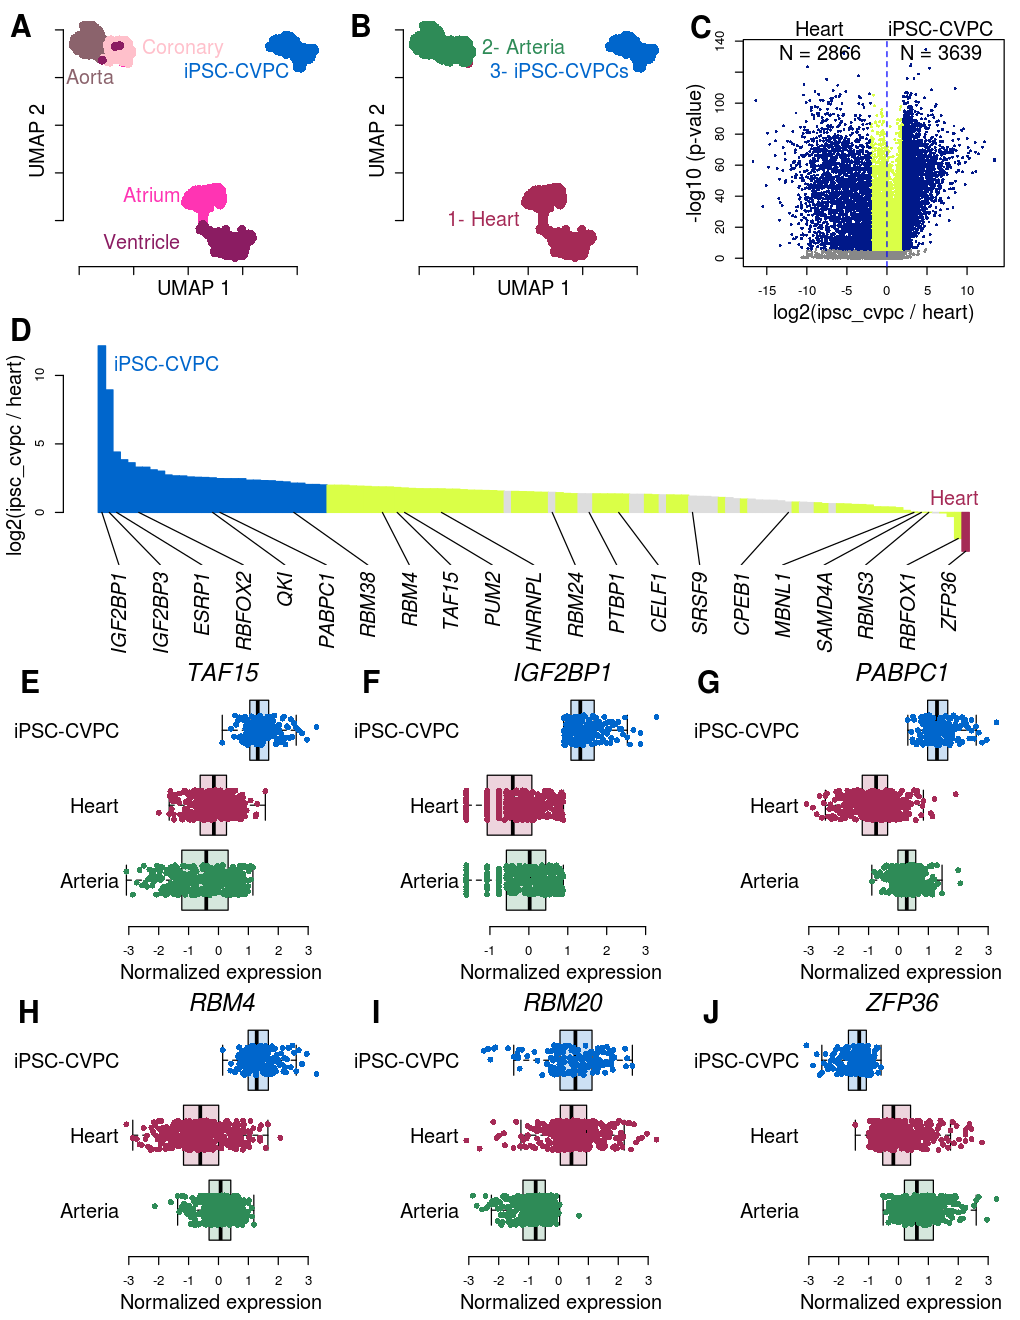

In [1829]:
figure_1a = function()
{
    par(mar = c(1,2,1,1))
    myimage = load.image("manuscript/cardiac_differential_expression/figure_1a.png")
    plot(myimage, axes = FALSE)
    mtext(text = "A", side = 2, line = 0, at = 0, font = 2, cex = 1.5, las = 2)
}

volcano_plot_beta = function(x, tissue1 = "", tissue2 = "", panel = "", legend = FALSE)
{
    if((tissue1 != "")&(tissue2 != ""))
    {
        x = x[x$tissue1 == tissue1 & x$tissue2 == tissue2,]
        x$cex = 0.5
        x$color = "#cccccc"
        x[x$diffexp == TRUE & x$beta > 0, "color"] = tissue2color3[tissue1, "color"]
        x[x$diffexp == TRUE & x$beta < 0, "color"] = tissue2color3[tissue2, "color"]
        
        #x[x$diffexp == TRUE & x$log2r_filter == TRUE, "color"] = "#ff0000"
    }else
    {
        x$tissue12 = paste(x$tissue1, "vs.", x$tissue2)
        x          = merge(x, data.frame(tissue12 = sort(unique(x$tissue12)), color = diverging_hcl(n = length(unique(x$tissue12)), palette = "Berlin")))
    }
    
    par(mar = c(4,4,2.5,1))
    plot(x$beta, -log(x$pval), pch = 16, col = x$color, cex = x$cex, xlab = "", ylab = "")
    
    abline(v = 0, col = "#0000ff", lty = "dashed")
    
    mtext(text = "Effect size"                                                     , side = 1, line =  2.5)
    mtext(text = "-log10 (p-value)"                                                , side = 2, line =  2.5)
    mtext(text = panel                                                             , side = 2, line =  2  , at = max(-log(x$pval)) * 1.1, font = 2, cex = 1.5, las = 2)
    mtext(text = tissue2color3[tissue1, "body_site"]                               , side = 3, line =  0  , at = max(x[x$beta > 0 & x$beta <  20, "beta"]) * 0.5)
    mtext(text = tissue2color3[tissue2, "body_site"]                               , side = 3, line =  0  , at = min(x[x$beta < 0 & x$beta > -20, "beta"]) * 0.5)
    mtext(text = paste("N", nrow(x[x$diffexp == TRUE & x$beta > 0, ]), sep = " = "), side = 3, line = -1.5, at = max(x[x$beta > 0 & x$beta <  20, "beta"]) * 0.7)
    mtext(text = paste("N", nrow(x[x$diffexp == TRUE & x$beta < 0, ]), sep = " = "), side = 3, line = -1.5, at = min(x[x$beta < 0 & x$beta > -20, "beta"]) * 0.8)
}

volcano_plot_log2r = function(x, tissue1 = "", tissue2 = "", panel = "", legend = FALSE)
{
    if((tissue1 != "")&(tissue2 != ""))
    {
        x = x[x$tissue1 == tissue1 & x$tissue2 == tissue2,]
        x$cex = 0.5
    }else
    {
        x$tissue12 = paste(x$tissue1, "vs.", x$tissue2)
        x          = merge(x, data.frame(tissue12 = sort(unique(x$tissue12)), color = diverging_hcl(n = length(unique(x$tissue12)), palette = "Berlin")))
    }

    x$filter = 0
    x[x$diffexp == TRUE, "filter"] = 1
    #x[x$diffexp == TRUE & abs(x$log2r) >= 1, "filter"] = 2
    x[x$diffexp == TRUE & abs(x$log2r) >= 2, "filter"] = 4
    #x[x$diffexp == TRUE & abs(x$log2r) >= 3, "filter"] = 4
    
    filter2color = data.frame(filter = 0:4, filter_label = c("N.S.", "FDR < 0.05", paste("log2r >", 1:3)), color = c("#888888", sequential_hcl(4, palette = "plasma", rev = TRUE)))
    
    x = merge(x, filter2color, by = "filter")
    
    par(mar = c(4,4,2.5,1))
    plot(x$log2r, -log10(x$pval), pch = 16, col = x$color, cex = x$cex, xlab = "", ylab = "")
    
    abline(v = 0, col = "#0000ff", lty = "dashed")
    
    mtext(text = paste("log2(", tissue1, " / ", tissue2, ")", sep = "")              , side = 1, line =  2.5)
    mtext(text = "-log10 (p-value)"                                                  , side = 2, line =  2.5)
    mtext(text = panel                                                               , side = 2, line =  2  , at = max(-log10(x$pval)) * 1.1, font = 2, cex = 1.5, las = 2)
    mtext(text = tissue2color3[tissue1, "body_site"]                                 , side = 3, line =  0  , at = max(x[x$log2r > 0 & x$log2r <  20, "log2r"]) * 0.5)
    mtext(text = tissue2color3[tissue2, "body_site"]                                 , side = 3, line =  0  , at = min(x[x$log2r < 0 & x$log2r > -20, "log2r"]) * 0.5)
    mtext(text = paste("N", nrow(x[x$diffexp == TRUE & x$log2r >  2, ]), sep = " = "), side = 3, line = -1.5, at = max(x[x$log2r > 0 & x$log2r <  20, "log2r"]) * 0.5)
    mtext(text = paste("N", nrow(x[x$diffexp == TRUE & x$log2r < -2, ]), sep = " = "), side = 3, line = -1.5, at = min(x[x$log2r < 0 & x$log2r > -20, "log2r"]) * 0.5)
}

volcano_plot_cell = function(x, tissue, panel = "")
{
    alldata = x
    ylims   = max(-log10(x$pval))
    x       = x[x$cell_type == tissue,]
    xlims   = range(x[x$beta >= -20 & x$beta <= 20, "beta"])
    mycol   = cell2color_regular[cell2color_regular$cell_type == gsub("cibersort\\.", "", tissue), "color"]
    x$color = "#dddddd"
    #x$pch   = 16
    x$cex   = 0.4
    #x$bg    = NA
    
    x[x$qval <= 0.05 & x$beta > 0 &  x$transcript_id %in% alldata[alldata$cell_type != tissue & alldata$qval <= 0.05 & alldata$beta > 0 & alldata$type == "gene_tpm", "transcript_id"], "color"] = "#999999"
    x[x$qval <= 0.05 & x$beta > 0 & !x$transcript_id %in% alldata[alldata$cell_type != tissue & alldata$qval <= 0.05 & alldata$beta > 0 & alldata$type == "gene_tpm", "transcript_id"], "color"] = mycol 
    #x[x$qval <= 0.05 & x$beta > 0 & !x$transcript_id %in% alldata[alldata$cell_type != tissue & alldata$qval <= 0.05 & alldata$beta > 0 & alldata$type == "gene_tpm", "transcript_id"], "pch"  ] = 21 
    #x[x$qval <= 0.05 & x$beta > 0 & !x$transcript_id %in% alldata[alldata$cell_type != tissue & alldata$qval <= 0.05 & alldata$beta > 0 & alldata$type == "gene_tpm", "transcript_id"], "cex"  ] =  0.3 
    #x[x$qval <= 0.05 & x$beta > 0 & !x$transcript_id %in% alldata[alldata$cell_type != tissue & alldata$qval <= 0.05 & alldata$beta > 0 & alldata$type == "gene_tpm", "transcript_id"], "bg"   ] = mycol 
    
    if(tissue != "cibersort.regular.cardiac_muscle"){x = rbind(x[x$color == "#dddddd",], x[x$color == "#999999",], x[x$color == mycol    ,])}
    if(tissue == "cibersort.regular.cardiac_muscle"){x = rbind(x[x$color == "#dddddd",], x[x$color == mycol    ,], x[x$color == "#999999",])}
    
    par(mar = c(4,4,2.5,1))
    #plot(x$beta, -log(x$pval), col = x$color, cex = x$cex, pch = x$pch, bg = x$bg, xlim = xlims, ylim = c(0, ylims), xlab = "", ylab = "")
    #plot(x$beta, -log(x$pval), col = x$color, cex = 0.3, pch = 16, xlim = xlims, ylim = c(0, ylims), xlab = "", ylab = "")
    plot(x$beta, -log(x$pval), col = x$color, cex = x$cex, pch = 16, xlim = xlims, ylim = c(0, ylims), xlab = "", ylab = "")
    
    abline(v = 0, col = "#0000ff", lty = "dashed")
    
    mtext(text = "Effect size"                                                     , side = 1, line =  2.5)
    mtext(text = "-log10 (p-value)"                                                , side = 2, line =  2.5)
    mtext(text = gsub("_", " ", gsub("cibersort.regular\\.", "", tissue))          , side = 3, line =  0.5)
    mtext(text = panel                                                             , side = 2, line =  2  , at = ylims * 1.1, font = 2, cex = 1.5, las = 2)
    mtext(text = paste("N", nrow(x[x$qval <= 0.05 & x$beta > 0, ]), sep = " = ")   , side = 1, line = -1.5, at = max(x[x$beta > 0 & x$beta <  20, "beta"]) * 0.7)
}

figure_umap = function(umap, x, colordata, panel = "", legend = FALSE)
{
    umap        = merge(umap, colordata)
    umap     $x = umap     [,x]
    
    par(mar = c(4,4,1,1))
    
    plot(umap$UMAP_1, umap$UMAP_2, pch = 16, col = umap$color, cex = 1.5, xlab = "", ylab = "", axes = FALSE)
    
    axis(1, labels = NA)
    axis(2, labels = NA)
    
    mtext(text = "UMAP 1", side = 1, line = 1)
    mtext(text = "UMAP 2", side = 2, line = 1)
    
    mtext(text = panel   , side = 2, line = 2, at = max(umap$UMAP_2), font = 2, cex = 1.5, las = 2)
    text(x = colordata$x, y = colordata$y, labels = colordata$body_site, cex = 1.5, col = colordata$color, pos = colordata$pos)
}

figure_s6_panel = function(gene_id, panel = "")
{
    expdata                = data.frame(assay_id = colnames(gene_tpm), exp = as.numeric(gene_tpm[gene_id,]))
    colnames(expdata)[[2]] = "exp"
    expdata                = merge(expdata, metadata[,c("run", "study", "tissue", "body_site")], by.x = "assay_id", by.y = "run")
    tissue2y               = tissue2color3[tissue2color3$tissue != "adult",]
    tissue2y               = tissue2y[order(tissue2y$tissue),]
    tissue2y$y             = 1:nrow(tissue2y)
    this                   = expdata
    this                   = merge(this, tissue2y[,c("tissue", "y", "color")])
    this$y                 = jitter(this$y - 0.5, factor = 1)

    par(mar = c(4,7.5,1.5,1))
    plot(1,1, type = "n", xlim = range(this$exp), ylim = c(0, max(tissue2y$y)), axes = FALSE, xlab = "", ylab = "")

    axis(1)

    boxplot(exp ~ tissue, data = this, horizontal = TRUE, add = TRUE, at = tissue2y$y - 0.5, col = paste(tissue2y$color, "33", sep = ""), outline = FALSE, axes = FALSE)
    mtext(text = panel                  , side = 2, line = 5, at = max(tissue2y$y) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = tissue2y$body_site     , side = 2, line = 0, at = tissue2y$y - 0.5, las = 2)
    mtext(text = "Normalized expression", side = 1, line = 2.5)
    mtext(text = geneinfo_genes[ geneinfo_genes$gene_id == gene_id, "gene_name"], side = 3, line = 0, font = 3, cex = 1.2)
    points(this$exp, this$y, col = this$color, pch = 16)

}

boxplot_sc = function(x, name, expdata, panel = "")
{
    expdata$x  = expdata[,x]
    expdata    = merge(expdata[,c("run", "x")], metadata[,c("run", "study", "tissue", "body_site")])
    tissue2y   = tissue2color3[tissue2color3$tissue != "adult",]
    tissue2y   = tissue2y[order(tissue2y$tissue),]
    tissue2y$y = 1:nrow(tissue2y)
    this       = expdata
    this       = merge(this, tissue2y[,c("tissue", "y", "color")])
    this$y     = jitter(this$y - 0.5, factor = 1)

    par(mar = c(4,7.5,1.5,1))
    plot(1,1, type = "n", xlim = range(this$x), ylim = c(0, max(tissue2y$y)), axes = FALSE, xlab = "", ylab = "")

    axis(1)
    
    #return(table(this[,c("tissue")]))

    boxplot(x ~ tissue, data = this, horizontal = TRUE, add = TRUE, at = tissue2y$y - 0.5, col = paste(tissue2y$color, "33", sep = ""), outline = FALSE, axes = FALSE)
    mtext(text = panel             , side = 2, line = 5, at = max(tissue2y$y) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = tissue2y$body_site, side = 2, line = 0, at = tissue2y$y - 0.5, las = 2)
    mtext(text = name              , side = 1, line = 2.5)
    points(this$x, this$y, col = this$color, pch = 16)
}

volcano_plot_rbp = function(x, tissue1 = "", tissue2 = "", toshow = c(), panel = "", legend = FALSE)
{
    if((tissue1 != "")&(tissue2 != ""))
    {
        x = x[x$tissue1 == tissue1 & x$tissue2 == tissue2,]
        x$cex = 0.5
    }else
    {
        x$tissue12 = paste(x$tissue1, "vs.", x$tissue2)
        x          = merge(x, data.frame(tissue12 = sort(unique(x$tissue12)), color = diverging_hcl(n = length(unique(x$tissue12)), palette = "Berlin")))
    }
    
    x = x[x$gene_name %in% rbps2plot,]
    x$color = "#dddddd"
    
    if(nrow(x[is.infinite(x$log2r) == TRUE & x$log2r > 0,]) > 0){x[is.infinite(x$log2r) == TRUE & x$log2r > 0, "log2r"] =  max(abs(x[is.infinite(x$log2r) == FALSE, "log2r"]))}
    if(nrow(x[is.infinite(x$log2r) == TRUE & x$log2r < 0,]) > 0){x[is.infinite(x$log2r) == TRUE & x$log2r < 0, "log2r"] = -max(abs(x[is.infinite(x$log2r) == FALSE, "log2r"]))}
    
    if(nrow(x[x$diffexp == TRUE, ]) > 0){x[x$diffexp == TRUE, "color"] = sequential_hcl(4, palette = "plasma", rev = TRUE)[[1]]}
    
    if(nrow(x[x$diffexp == TRUE & x$log2r >  2, ]) > 0){x[x$diffexp == TRUE & x$log2r >  2, "color"] = tissue2color3[tissue1, "color"]}
    if(nrow(x[x$diffexp == TRUE & x$log2r >  2, ]) > 0){x[x$diffexp == TRUE & x$log2r < -2, "color"] = tissue2color3[tissue2, "color"]}
    
    x = x[order(x$log2r, decreasing = TRUE),]
    
    par(mar = c(6,4,1,1))
    
    barplot(x$log2r, width = 1, space = 0, col = x$color, border = x$color, ylim = c(min(x$log2r - 1), max(x$log2r)))
     
    mtext(text = paste("log2(", tissue1, " / ", tissue2, ")", sep = "")              , side = 2, line =  2.5)
    mtext(text = panel                                                               , side = 2, line =  2  , las = 2, at = max(x$log2r) * 1.1, font = 2, cex = 1.5)
    
    text(labels = tissue2color3[tissue1, "body_site"], x = 1          , y = (max(x$log2r) - min(x$log2r)) * 0.9 + min(x$log2r), pos = 4, cex = 1.5, col = tissue2color3[tissue1, "color"])
    text(labels = tissue2color3[tissue2, "body_site"], x = nrow(x) - 2, y = 0                                                 , pos = 3, cex = 1.5, col = tissue2color3[tissue2, "color"])
    #mtext(text = paste("N", nrow(x[x$diffexp == TRUE & x$log2r >  2, ]), sep = " = "), side = 3, line = -1.5, at = max(x[x$log2r > 0 & x$log2r <  20, "log2r"]) * 0.5)
    #mtext(text = paste("N", nrow(x[x$diffexp == TRUE & x$log2r < -2, ]), sep = " = "), side = 3, line = -1.5, at = min(x[x$log2r < 0 & x$log2r > -20, "log2r"]) * 0.5)
    
    x$x2    = (1:nrow(x)) - 0.5
    toax    = x[x$gene_name %in% toshow,]
    toax$x1 = (1:nrow(toax) - 0.5) * nrow(x) / nrow(toax)
    
    mtext(text = toax$gene_name, side = 1, line = 0.5, at = toax$x1, font = 3, las = 2)
    
    toax$y = 0
    if(nrow(toax[toax$log2r < 0, ]) > 0){toax[toax$log2r < 0, "y"] = toax[toax$log2r < 0, "log2r"]}
    
    segments(x0 = toax$x1, x1 = toax$x2, y0 = min(x$log2r - 1), y1 = toax$y)
}


figure_1 = function()
{
    mylayout = rbind(1:3,
                     rep(4,3),
                     5:7,
                     8:10
                    )
    #mylayout = matrix(1:12, nrow = 4, byrow = TRUE)
    layout(mylayout)
    
    #figure_1a()
    
    tissue2color$tissue = gsub("heart_", "", gsub("arteria_", "", tissue2color$tissue))
    tissue2color$x   = c(10  ,  0  ,   0  ,  -9  , -5  )
    tissue2color$y   = c( 5.5, -7.5, -12.5,   6.5,  8  )
    tissue2color$pos = c( 2  ,  2  , 2    ,   1  ,  4  )
        
    figure_umap(umap_bulk, "tissue", tissue2color, "A", TRUE)
    
    
    mycol     = paste("res", 0.01, sep = "_")
    colordata = data.frame(res       = sort(unique(umap_bulk[,mycol])), 
                           body_site = c("1- Heart"  , "2- Arteria", "3- iPSC-CVPCs"), 
                           color     = c("#A52A56", "#2E8B57", "#0066CC"),
                           x         = c(  0, -5  , 10  ),
                           y         = c(-10,  8  ,  5.5),
                           pos       = c(  2,  4  ,  2  )
                          )
    
    colnames(colordata)[[1]] = mycol
   
    colordata_0.01 = colordata
    
    figure_umap(umap_bulk, paste("res", 0.01, sep = "_"), colordata_0.01, "B", FALSE)
    
    
    volcano_plot_log2r(diftiss, "ipsc_cvpc", "heart", "C")
    volcano_plot_rbp  (diftiss, "ipsc_cvpc", "heart", toshow, "D")
    
    figure_s6_panel(geneinfo_genes[ geneinfo_genes$gene_name == "TAF15"  , "gene_id"], "E")
    figure_s6_panel(geneinfo_genes[ geneinfo_genes$gene_name == "IGF2BP1", "gene_id"], "F")
    figure_s6_panel(geneinfo_genes[ geneinfo_genes$gene_name == "PABPC1" , "gene_id"], "G")
    figure_s6_panel(geneinfo_genes[ geneinfo_genes$gene_name == "RBM4"   , "gene_id"], "H")
    figure_s6_panel(geneinfo_genes[ geneinfo_genes$gene_name == "RBM20"  , "gene_id"], "I")
    figure_s6_panel(geneinfo_genes[ geneinfo_genes$gene_name == "ZFP36"  , "gene_id"], "J")
}

png(filename = "manuscript/cardiac_differential_expression/figure_1.png", width = 10, height = 11, units = "in", res = 300)
figure_1()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 11)
figure_1()

In [605]:
summary(umap_bulk[ umap_bulk$tissue == "coronary", c("UMAP_1", "UMAP_2")])

     UMAP_1           UMAP_2       
 Min.   :-7.737   Min.   :-13.507  
 1st Qu.:-6.865   1st Qu.:  7.114  
 Median :-6.130   Median :  7.756  
 Mean   :-6.178   Mean   :  7.567  
 3rd Qu.:-5.656   3rd Qu.:  8.353  
 Max.   : 3.657   Max.   :  8.961  

In [1950]:
tissue2color

tissue           body_site color   order
ipsc_cvpc        ipsc_cvpc        iPSC-CVPC #0066CC 1    
heart_atrium     heart_atrium     Atrium    #FF34B3 2    
heart_ventricle  heart_ventricle  Ventricle #8B1C62 3    
arteria_aorta    arteria_aorta    Aorta     #8B636C 4    
arteria_coronary arteria_coronary Coronary  #FFC0CB 5

In [592]:
message(paste("S score iPSC-CVPCs vs. heart"           , signif(wilcox.test(umap_bulk[ umap_bulk$tissue == "ipsc_cvpc", "s_score"   ], umap_bulk[ umap_bulk$tissue %in% c("atrium", "ventricle"), "s_score"   ])$p.value, digits = 3), sep = " = "))
message(paste("G2M score iPSC-CVPCs vs. heart"         , signif(wilcox.test(umap_bulk[ umap_bulk$tissue == "ipsc_cvpc", "g2m_score" ], umap_bulk[ umap_bulk$tissue %in% c("atrium", "ventricle"), "g2m_score" ])$p.value, digits = 3), sep = " = "))
message(paste("Pseudotime score iPSC-CVPCs vs. heart"  , signif(wilcox.test(umap_bulk[ umap_bulk$tissue == "ipsc_cvpc", "pseudotime"], umap_bulk[ umap_bulk$tissue %in% c("atrium", "ventricle"), "pseudotime"])$p.value, digits = 3), sep = " = "))
message(paste("S score iPSC-CVPCs vs. arteria"         , signif(wilcox.test(umap_bulk[ umap_bulk$tissue == "ipsc_cvpc", "s_score"   ], umap_bulk[ umap_bulk$tissue %in% c("aorta", "coronary"  ), "s_score"   ])$p.value, digits = 3), sep = " = "))
message(paste("G2M score iPSC-CVPCs vs. arteria"       , signif(wilcox.test(umap_bulk[ umap_bulk$tissue == "ipsc_cvpc", "g2m_score" ], umap_bulk[ umap_bulk$tissue %in% c("aorta", "coronary"  ), "g2m_score" ])$p.value, digits = 3), sep = " = "))
message(paste("Pseudotime score iPSC-CVPCs vs. arteria", signif(wilcox.test(umap_bulk[ umap_bulk$tissue == "ipsc_cvpc", "pseudotime"], umap_bulk[ umap_bulk$tissue %in% c("aorta", "coronary"  ), "pseudotime"])$p.value, digits = 3), sep = " = "))


S score iPSC-CVPCs vs. heart = 1.16e-84

G2M score iPSC-CVPCs vs. heart = 3.13e-83

Pseudotime score iPSC-CVPCs vs. heart = 7.3e-85

S score iPSC-CVPCs vs. arteria = 1.56e-79

G2M score iPSC-CVPCs vs. arteria = 1.67e-79

Pseudotime score iPSC-CVPCs vs. arteria = 1.54e-79



In [591]:
table(umap_bulk$tissue)


    aorta    atrium  coronary ipsc_cvpc ventricle 
      227       196       125       180       238 

## Figure S2, S5, S6

png 
  2

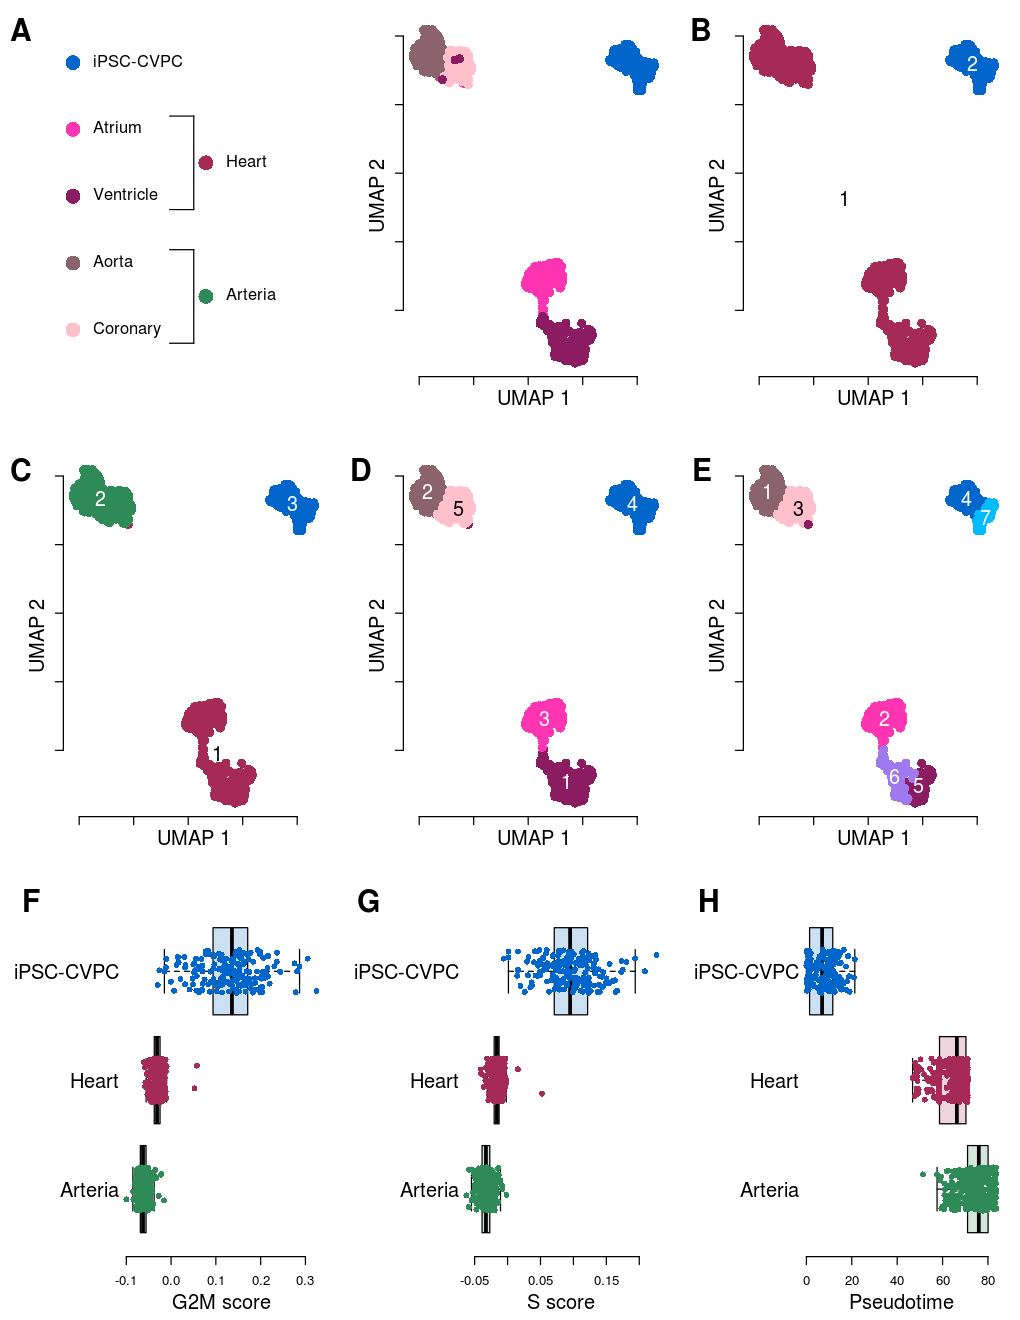

In [1202]:
figure_umap = function(umap, x, colordata, panel = "", legend = FALSE)
{
    umap        = merge(umap, colordata)
    umap     $x = umap     [,x]
    
    par(mar = c(4,4,1,1))
    if(legend == TRUE)
    {
        plot(1,1, type = "n", xlim = c(0,1), ylim = c(nrow(colordata) + 0.5, 0.5), xlab = "", ylab = "", axes = FALSE)
        
        points(x = rep(0   , nrow(colordata)), y = 1:nrow(colordata), pch = 16, cex = 2.5, col = colordata$color)
        text  (x = rep(0.05, nrow(colordata)), y = 1:nrow(colordata), labels = colordata$body_site, pos = 4, cex = 1.25)
        
        segments(x0 = 0.5, y0 = 1.8, y1 = 3.2)
        segments(x0 = 0.5, y0 = 3.8, y1 = 5.2)
        segments(x0 = 0.4, y0 = c(1.8, 3.2, 3.8, 5.2), x1 = 0.5)
        
        colordata2 = tissue2color3[c("heart", "arteria"),]
        
        points(x = rep(0.55, nrow(colordata2)), y = c(2.5, 4.5), pch = 16, cex = 2.5, col = colordata2$color)
        text  (x = rep(0.6 , nrow(colordata2)), y = c(2.5, 4.5), labels = colordata2$body_site, pos = 4, cex = 1.25)
        
        mtext(text = panel   , side = 2, line = 2, at = 0.5, font = 2, cex = 1.5, las = 2)
    }
    
    plot(umap$UMAP_1, umap$UMAP_2, pch = 16, col = umap$color, cex = 1.5, xlab = "", ylab = "", axes = FALSE)
    
    axis(1, labels = NA)
    axis(2, labels = NA)
    
    mtext(text = "UMAP 1", side = 1, line = 1)
    mtext(text = "UMAP 2", side = 2, line = 1)
    
    if(legend == FALSE)
    {
        mtext(text = panel   , side = 2, line = 2, at = max(umap$UMAP_2), font = 2, cex = 1.5, las = 2)
        totext = aggregate(list(umap1 = umap$UMAP_1, umap2 = umap$UMAP_2), by = list(x = umap$x, color_points = umap$color), FUN = mean)
        totext$color = "#ffffff"
        if(x == "res_0"   ){totext[totext$x == 1, "color"] = "#000000"}
        if(x == "res_0.01"){totext[totext$x == 1, "color"] = "#000000"}
        if(nrow(totext[totext$color_points == "#FFC0CB",]) > 0){totext[totext$color_points == "#FFC0CB", "color"] = "#000000"}
        text(x = totext$umap1, y = totext$umap2, labels = totext$x, cex = 1.5, col = totext$color)
    }
}

figure_s2 = function()
{
    mylayout = matrix(1:9, nrow = 3, byrow = TRUE)
    layout(mylayout)
    
    tissue2color$tissue = gsub("heart_", "", gsub("arteria_", "", tissue2color$tissue))
    
    figure_umap(umap_bulk, "tissue", tissue2color, "A", TRUE)
    
    
    mycol     = paste("res", 0, sep = "_")
    colordata = data.frame(res       = sort(unique(umap_bulk[,mycol])), 
                           body_site = sort(unique(umap_bulk[,mycol])), 
                           color     = c("#A52A56", "#0066CC")
                          )
    
    colnames(colordata)[[1]] = mycol
    
    colordata_0 = colordata
    
    mycol     = paste("res", 0.01, sep = "_")
    colordata = data.frame(res       = sort(unique(umap_bulk[,mycol])), 
                           body_site = sort(unique(umap_bulk[,mycol])), 
                           color     = c("#A52A56", "#2E8B57", "#0066CC")
                          )
    
    colnames(colordata)[[1]] = mycol
    
    colordata_0.01 = colordata
    
    mycol     = paste("res", 0.2, sep = "_")
    colordata = data.frame(res       = sort(unique(umap_bulk[,mycol])), 
                           body_site = sort(unique(umap_bulk[,mycol])), 
                           color     = c("#8B1C62", "#8B636C", "#FF34B3", "#0066CC", "#FFC0CB")
                          )
    
    colnames(colordata)[[1]] = mycol
    
    colordata_0.2 = colordata
    
    mycol     = paste("res", 0.7, sep = "_")
    colordata = data.frame(res       = sort(unique(umap_bulk[,mycol])), 
                           body_site = sort(unique(umap_bulk[,mycol])), 
                           color     = c("#8B636C", "#FF34B3", "#FFC0CB", "#0066CC", "#8B1C62", "#9F79EE", "#00bbff")
                          )
    
    colnames(colordata)[[1]] = mycol
    
    colordata_0.7 = colordata
    
    figure_umap(umap_bulk, paste("res", 0   , sep = "_"), colordata_0   , "B", FALSE)
    figure_umap(umap_bulk, paste("res", 0.01, sep = "_"), colordata_0.01, "C", FALSE)
    figure_umap(umap_bulk, paste("res", 0.2 , sep = "_"), colordata_0.2 , "D", FALSE)
    figure_umap(umap_bulk, paste("res", 0.7 , sep = "_"), colordata_0.7 , "E", FALSE)
    
    out = list(colordata_0, colordata_0.01, colordata_0.2, colordata_0.7)
    names(out) = paste("Resolution", c(0, 0.01, 0.2, 0.7))
    
    saveRDS(out, "manuscript/cardiac_differential_expression/figure1_colors.rds")
    
    boxplot_sc("g2m_score" , "G2M score" , umap_bulk, "F")
    boxplot_sc("s_score"   , "S score"   , umap_bulk, "G")
    boxplot_sc("pseudotime", "Pseudotime", umap_bulk, "H")
}

png(filename = "manuscript/cardiac_differential_expression/figure_S2.png", width = 10, height = 11, units = "in", res = 300)
figure_s2()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 11)
figure_s2()

png 
  2

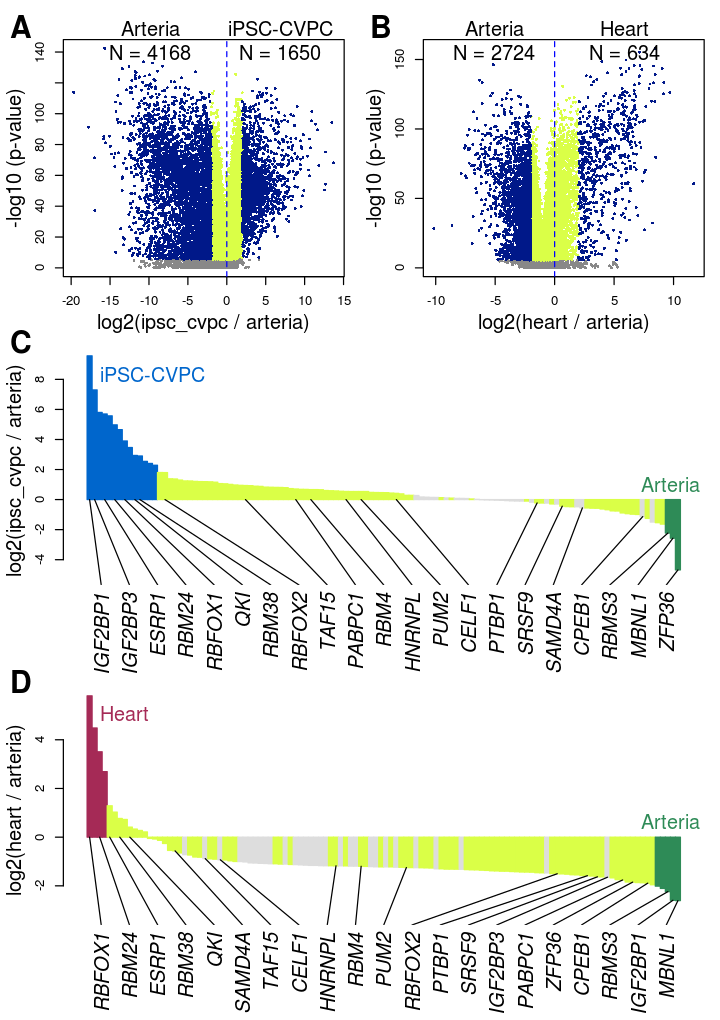

In [1844]:
figure_s5 = function()
{
    layout(rbind(1:2, rep(3,2), rep(4,2)))
    
    volcano_plot_log2r(diftiss, "ipsc_cvpc", "arteria", "A")
    volcano_plot_log2r(diftiss, "heart"    , "arteria", "B")
    volcano_plot_rbp  (diftiss, "ipsc_cvpc", "arteria", toshow, "C")    
    volcano_plot_rbp  (diftiss, "heart"    , "arteria", toshow, "D")    
}

png(filename = "manuscript/cardiac_differential_expression/figure_S5.png", width = 6, height = 8.5, units = "in", res = 300)
figure_s5()
dev.off()

options(repr.plot.width = 6, repr.plot.height = 8.5)
figure_s5()

png 
  2

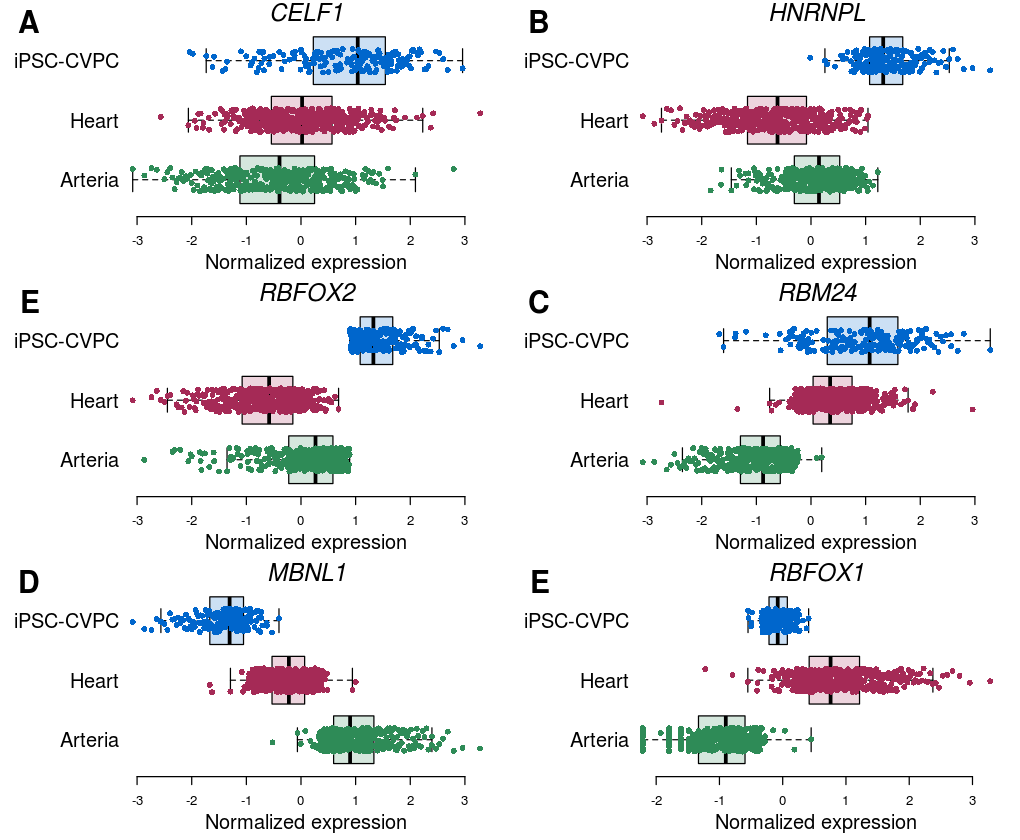

In [1204]:
figure_s6 = function()
{
    layout(matrix(c(1:6), nrow = 3, byrow = TRUE))
    figure_s6_panel(geneinfo_genes[ geneinfo_genes$gene_name == "CELF1" , "gene_id"], "A")
    figure_s6_panel(geneinfo_genes[ geneinfo_genes$gene_name == "HNRNPL", "gene_id"], "B")
    figure_s6_panel(geneinfo_genes[ geneinfo_genes$gene_name == "RBFOX2", "gene_id"], "E")
    figure_s6_panel(geneinfo_genes[ geneinfo_genes$gene_name == "RBM24" , "gene_id"], "C")
    figure_s6_panel(geneinfo_genes[ geneinfo_genes$gene_name == "MBNL1" , "gene_id"], "D")
    figure_s6_panel(geneinfo_genes[ geneinfo_genes$gene_name == "RBFOX1", "gene_id"], "E")

    #colordata = tissue2color3[c("ipsc_cvpc" , "heart", "arteria"),]
    #plot(1,1, type = "n", xlim = c(0,1), ylim = c(nrow(colordata) + 0.5, 0.5), xlab = "", ylab = "", axes = FALSE)
    #
    #points(x = rep(0   , nrow(colordata)), y = 1:nrow(colordata), cex = 3  , pch = 16, col = colordata$color)
    #text  (x = rep(0.05, nrow(colordata)), y = 1:nrow(colordata), cex = 1.5, labels = colordata$body_site, pos = 4)
}

png(filename = "manuscript/cardiac_differential_expression/figure_S6.png", width = 8.5, height = 7, units = "in", res = 300)
figure_s6()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 7)
figure_s6()

# Figure 2: Stage-specific expression differences between cardiac samples (isoform)

In [666]:
str(geneinfo_isoforms)

'data.frame':	38271 obs. of  9 variables:
 $ chrom          : chr  "chr1" "chr1" "chr1" "chr1" ...
 $ start          : int  146386 165491 165889 167129 762978 763018 763032 763053 763079 763080 ...
 $ end            : int  173862 169210 168767 169240 794826 794788 794712 792626 788146 789756 ...
 $ strand         : chr  "-" "-" "-" "-" ...
 $ gene_id        : chr  "ENSG00000241860.7_8" "ENSG00000241860.7_8" "ENSG00000241860.7_8" "ENSG00000241860.7_8" ...
 $ gene_name      : chr  "AL627309.5" "AL627309.5" "AL627309.5" "AL627309.5" ...
 $ gene_type      : chr  "lncRNA" "lncRNA" "lncRNA" "lncRNA" ...
 $ transcript_id  : chr  "ENST00000466557.6_2" "ENST00000662089.1_2" "ENST00000491962.1_2" "ENST00000655252.1_2" ...
 $ transcript_type: chr  "lncRNA" "lncRNA" "lncRNA" "lncRNA" ...


In [673]:
rbp2exp = merge(geneinfo_isoforms[,c("transcript_id", "transcript_type")], diftiss_iso[ diftiss_iso$gene_name %in% rbps & diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$diffexp == TRUE,])
head(rbp2exp[order(abs(rbp2exp$log2r), decreasing = TRUE),], n = 10)

rbp2exp = rbp2exp[rbp2exp$gene_name %in% c("MBNL1", "HNRNPM", "FXR1", "FMR1" ),]
rbp2exp[order(rbp2exp$gene_name, abs(rbp2exp$log2r), decreasing = TRUE),]


transcript_id        transcript_type         gene_id              gene_name
17  ENST00000282486.10_1 protein_coding          ENSG00000152601.17_6 MBNL1    
133 ENST00000480918.5_1  protein_coding          ENSG00000114416.18_9 FXR1     
46  ENST00000351839.7_3  protein_coding          ENSG00000165119.21_7 HNRNPK   
226 ENST00000602219.1_1  processed_transcript    ENSG00000099783.12_8 HNRNPM   
176 ENST00000537883.5_2  protein_coding          ENSG00000112531.17_5 QKI      
60  ENST00000370470.5_1  protein_coding          ENSG00000102081.15_9 FMR1     
132 ENST00000480887.5_3  protein_coding          ENSG00000048649.13_6 RSF1     
202 ENST00000568901.2_1  retained_intron         ENSG00000089280.19_3 FUS      
195 ENST00000555547.5_1  nonsense_mediated_decay ENSG00000100650.16_5 SRSF5    
181 ENST00000545754.5_1  protein_coding          ENSG00000152601.17_6 MBNL1    
    gene_type      beta       se         tval       pval          qval         
17  protein_coding -1.5825117 0.10810780 -14.638274  8.723141e-42  3.338433e-37
133 protein_coding  2.0235269 0.07427173  27.244914 1.979131e-107 7.574330e-103
46  protein_coding  0.7064182 0.11608293   6.085461  2.056498e-09  7.870425e-05
226 protein_coding -0.7680118 0.12837616  -5.982511  3.752313e-09  1.436048e-04
176 protein_coding  1.7036031 0.08982809  18.965149  2.334429e-63  8.934093e-59
60  protein_coding  1.5388752 0.08555081  17.987851  2.536940e-58  9.709121e-54
132 protein_coding -1.3578293 0.12922457 -10.507516  7.630157e-24  2.920137e-19
202 protein_coding -1.2614690 0.10379752 -12.153170  1.412390e-30  5.405359e-26
195 protein_coding -1.8238433 0.10726192 -17.003642  2.476090e-53  9.476243e-49
181 protein_coding -1.5275743 0.13203117 -11.569800  4.047931e-28  1.549184e-23
    tissue1   tissue2 type        diffexp tissue1_exp tissue2_exp delta     
17  ipsc_cvpc heart   isoform_use TRUE     0.02572222 12.51260204 -12.486880
133 ipsc_cvpc heart   isoform_use TRUE    10.23077778  0.06836406  10.162414
46  ipsc_cvpc heart   isoform_use TRUE     0.04288889  4.90907834  -4.866189
226 ipsc_cvpc heart   isoform_use TRUE     0.30366667 11.37357143 -11.069905
176 ipsc_cvpc heart   isoform_use TRUE    12.86705556  0.44290323  12.424152
60  ipsc_cvpc heart   isoform_use TRUE    14.20737616  0.53601382  13.671362
132 ipsc_cvpc heart   isoform_use TRUE     0.43266667  9.68535154  -9.252685
202 ipsc_cvpc heart   isoform_use TRUE     0.68988889 14.62642857 -13.936540
195 ipsc_cvpc heart   isoform_use TRUE     0.77672222 15.55009217 -14.773370
181 ipsc_cvpc heart   isoform_use TRUE     0.72650000 13.77259959 -13.046100
    log2r     log2r_filter
17  -8.926151 TRUE        
133  7.225462 TRUE        
46  -6.838704 TRUE        
226 -5.227053 TRUE        
176  4.860547 TRUE        
60   4.728226 TRUE        
132 -4.484477 TRUE        
202 -4.406070 TRUE        
195 -4.323381 TRUE        
181 -4.244694 TRUE

transcript_id        transcript_type      gene_id              gene_name
17  ENST00000282486.10_1 protein_coding       ENSG00000152601.17_6 MBNL1    
181 ENST00000545754.5_1  protein_coding       ENSG00000152601.17_6 MBNL1    
119 ENST00000464596.5_3  protein_coding       ENSG00000152601.17_6 MBNL1    
154 ENST00000497971.1_1  retained_intron      ENSG00000152601.17_6 MBNL1    
33  ENST00000324210.9_1  protein_coding       ENSG00000152601.17_6 MBNL1    
155 ENST00000498502.5_2  protein_coding       ENSG00000152601.17_6 MBNL1    
118 ENST00000463374.5_1  protein_coding       ENSG00000152601.17_6 MBNL1    
226 ENST00000602219.1_1  processed_transcript ENSG00000099783.12_8 HNRNPM   
222 ENST00000600092.5_1  protein_coding       ENSG00000099783.12_8 HNRNPM   
133 ENST00000480918.5_1  protein_coding       ENSG00000114416.18_9 FXR1     
135 ENST00000481383.1_1  retained_intron      ENSG00000114416.18_9 FXR1     
126 ENST00000472339.5_1  retained_intron      ENSG00000114416.18_9 FXR1     
138 ENST00000482125.1_4  protein_coding       ENSG00000114416.18_9 FXR1     
60  ENST00000370470.5_1  protein_coding       ENSG00000102081.15_9 FMR1     
131 ENST00000478848.1_1  retained_intron      ENSG00000102081.15_9 FMR1     
61  ENST00000370477.5_1  protein_coding       ENSG00000102081.15_9 FMR1     
104 ENST00000439526.6_1  protein_coding       ENSG00000102081.15_9 FMR1     
    gene_type      beta       se         tval       pval          qval         
17  protein_coding -1.5825117 0.10810780 -14.638274  8.723141e-42  3.338433e-37
181 protein_coding -1.5275743 0.13203117 -11.569800  4.047931e-28  1.549184e-23
119 protein_coding  1.6469798 0.12510717  13.164551  5.290611e-35  2.024770e-30
154 protein_coding -1.1455763 0.11926001  -9.605703  1.956133e-20  7.486316e-16
33  protein_coding  1.2300863 0.08970168  13.713080  1.745551e-37  6.680400e-33
155 protein_coding  1.6504563 0.13326426  12.384838  1.425788e-31  5.456635e-27
118 protein_coding  0.9735285 0.10109031   9.630285  1.589786e-20  6.084270e-16
226 protein_coding -0.7680118 0.12837616  -5.982511  3.752313e-09  1.436048e-04
222 protein_coding  1.4174796 0.10468229  13.540778  1.064655e-36  4.074539e-32
133 protein_coding  2.0235269 0.07427173  27.244914 1.979131e-107 7.574330e-103
135 protein_coding  0.5958997 0.10209503   5.836716  8.664639e-09  3.316044e-04
126 protein_coding  0.8670963 0.11146903   7.778810  3.151206e-14  1.205998e-09
138 protein_coding -1.0896543 0.10431745 -10.445560  1.328773e-23  5.085347e-19
60  protein_coding  1.5388752 0.08555081  17.987851  2.536940e-58  9.709121e-54
131 protein_coding -0.7515957 0.14682663  -5.118933  4.128047e-07  1.579845e-02
61  protein_coding  1.6485505 0.10311548  15.987421  2.757540e-48  1.055338e-43
104 protein_coding  0.8014952 0.15014600   5.338105  1.328010e-07  5.082428e-03
    tissue1   tissue2 type        diffexp tissue1_exp tissue2_exp delta     
17  ipsc_cvpc heart   isoform_use TRUE     0.02572222 12.51260204 -12.486880
181 ipsc_cvpc heart   isoform_use TRUE     0.72650000 13.77259959 -13.046100
119 ipsc_cvpc heart   isoform_use TRUE    11.90505556  1.05940092  10.845655
154 ipsc_cvpc heart   isoform_use TRUE     1.75827778 14.79665899 -13.038381
33  ipsc_cvpc heart   isoform_use TRUE    18.92527778  3.52050678  15.404771
155 ipsc_cvpc heart   isoform_use TRUE    11.10294444  4.93875576   6.164189
118 ipsc_cvpc heart   isoform_use TRUE    31.48694444 27.35060737   4.136337
226 ipsc_cvpc heart   isoform_use TRUE     0.30366667 11.37357143 -11.069905
222 ipsc_cvpc heart   isoform_use TRUE    30.22055556  8.26693548  21.953620
133 ipsc_cvpc heart   isoform_use TRUE    10.23077778  0.06836406  10.162414
135 ipsc_cvpc heart   isoform_use TRUE     1.48844444  3.64073733  -2.152293
126 ipsc_cvpc heart   isoform_use TRUE    19.58711111 10.28347926   9.303632
138 ipsc_cvpc heart   isoform_use TRUE    26.70316667 39.36347926 -12.660313
60  ipsc_cvpc heart   isoform_use TRUE    14.20737616  0.53601382  13.671362
131 ipsc_cvpc heart   i

In [1134]:
eclip_folder = "/frazer01/home/tarthur/projects/CARDIPS/fine_mapping/analysis/garfield/bfiles/2020-10-26-rbp_annotation_prep/intersection_results"
eclip_in     = list.files(eclip_folder, pattern = "_merged_sorted.bed")
eclip_files  = data.frame(file  = paste(eclip_folder, eclip_in, sep = "/"), 
                          eclip = gsub("_merged_sorted.bed", "", eclip_in), 
                          rbp   = unlist(lapply(eclip_in, function(x){unlist(strsplit(x, "_"))[[1]]})),
                          cell  = unlist(lapply(eclip_in, function(x){unlist(strsplit(x, "_"))[[2]]}))
                         )

message(paste("RBPs with eCLIP data", length(unique(eclip_files$rbp)), sep = " = "))
message(paste("RBPs with eCLIP data and iPSC-CVPC-associated", length(unique(diftiss[diftiss$gene_name %in% eclip_files$rbp & diftiss$diffexp == TRUE & diftiss$log2r > 0, "gene_name"])), sep = " = "))
message(paste("RBPs with eCLIP data and iPSC-CVPC-specific"  , length(unique(diftiss[diftiss$gene_name %in% eclip_files$rbp & diftiss$diffexp == TRUE & diftiss$log2r > 2, "gene_name"])), sep = " = "))


RBPs with eCLIP data = 39

RBPs with eCLIP data and iPSC-CVPC-associated = 33

RBPs with eCLIP data and iPSC-CVPC-specific = 12



In [299]:
library(png)

stage2exp      = fread  ("pipeline/4.10.diffexp_eclip_enrichment/stage2exp.txt", sep = "\t", header = TRUE, data.table = FALSE)
testseq        = fread  ("pipeline/4.10.diffexp_eclip_enrichment/tests_consensus_sequence.txt", sep = "\t", header = TRUE, data.table = FALSE)
consensus_list = readRDS("pipeline/4.10.diffexp_eclip_enrichment/consensus_list.rds")
nucs           = c("A", "C", "G", "T")
tologos        = lapply(nucs, function(x){readPNG(paste("manuscript/cardiac_differential_expression/seqlogo_", x, "-removebg.png", sep = ""))})
names(tologos) = nucs


png 
  2

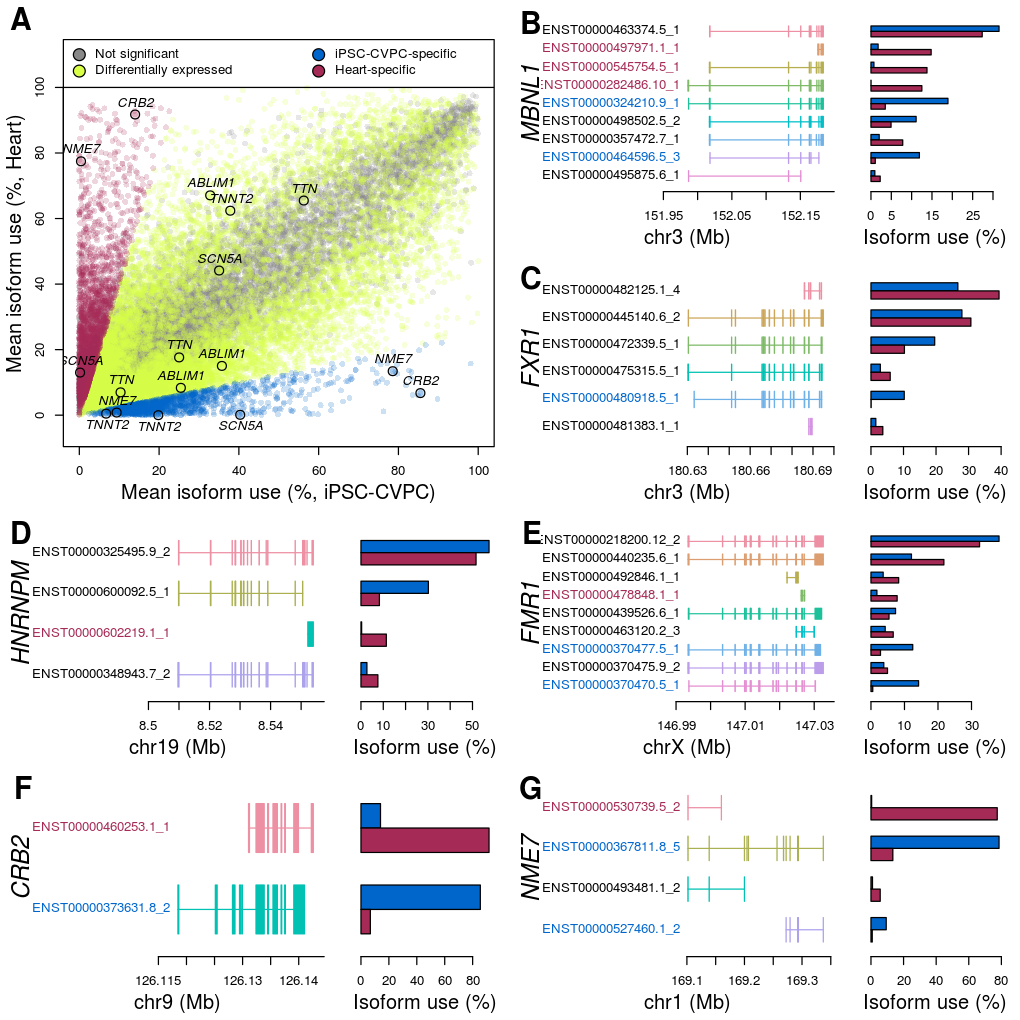

In [1380]:
figure_2a = function(panel = "")
{
    tissue1 = "ipsc_cvpc"
    tissue2 = "heart"
    this = diftiss_iso[diftiss_iso$tissue1 == tissue1 & diftiss_iso$tissue2 == tissue2,]
    
    this$filter = 0
    this[this$diffexp == TRUE, "filter"] = 1
    #this[this$diffexp == TRUE & abs(this$log2r) >= 1, "filter"] = 2
    this[this$diffexp == TRUE & this$log2r >=  2, "filter"] = 4
    this[this$diffexp == TRUE & this$log2r <= -2, "filter"] = 5
    #this[this$diffexp == TRUE & abs(this$log2r) >= 3, "filter"] = 4
    
    filter2color = data.frame(filter = c(0,1,4,5), 
                              filter_label = c("Not significant", "Differentially expressed", paste(tissue2color3[c(tissue1, tissue2), "body_site"], "specific", sep = "-")), 
                              color = c("#888888", sequential_hcl(4, palette = "plasma", rev = TRUE)[[1]], tissue2color3[c(tissue1, tissue2), "color"]))
    
    this = merge(this, filter2color)
    this = this[order(this$filter, decreasing = FALSE),]
    
    this$color = paste(this$color, "33", sep = "")
    
    par(mar = c(4,4,2.5,1))
    plot(this$tissue1_exp, this$tissue2_exp, col = this$color, xlim = c(0,100), ylim = c(-5,110), pch = 16, xlab = "", ylab = "")
    
    toplot = this[this$gene_name %in% c("TNNT2", "SCN5A", "TTN", "ABLIM1", "NME7", "CRB2") & this$diffexp == TRUE & (this$tissue1_exp > 5 | this$tissue2_exp > 5),]
    toplot$pos = 3
    #toplot[toplot$log2r_filter == TRUE & toplot$beta < 0, "pos"] = 4
    toplot[toplot$tissue2_exp < 5 & toplot$gene_name != "NME7", "pos"] = 1

    points(toplot$tissue1_exp, toplot$tissue2_exp, bg     = toplot$color, pch = 21, cex = 1.5)
    text  (toplot$tissue1_exp, toplot$tissue2_exp, labels = toplot$gene_name, pos = toplot$pos, font = 3)
    
    mtext(text = panel                              , side = 2, line = 2, at = 110 * 1.1, font = 2, cex = 1.5, las = 2)
    mtext(text = paste("Mean isoform use (%, ", tissue2color3[tissue2, "body_site"], ")", sep = ""), side = 2, line = 2.5)
    mtext(text = paste("Mean isoform use (%, ", tissue2color3[tissue1, "body_site"], ")", sep = ""), side = 1, line = 2.5)
    
    abline(h = 100)
    
    #filter2color = filter2color[filter2color$filter %in% c(0,1,4),]

    points(x = c(0, 0, 60, 60)    , y = c(110, 105, 110, 105), bg     = filter2color$color       , pch = 21, cex = 2)
    text  (x = c(0, 0, 60, 60) + 2, y = c(110, 105, 110, 105), labels = filter2color$filter_label, pos = 4)
}

figure_s7_panel = function(gene_id, panel = "")
{
    expdata                = data.frame(assay_id = colnames(gene_tpm), exp = as.numeric(gene_tpm[gene_id,]))
    colnames(expdata)[[2]] = "exp"
    expdata                = merge(expdata, metadata[,c("run", "study", "tissue", "body_site")], by.x = "assay_id", by.y = "run")
    tissue2y               = tissue2color3[tissue2color3$tissue != "adult",]
    tissue2y               = tissue2y[order(tissue2y$tissue),]
    tissue2y$y             = 1:nrow(tissue2y)
    this                   = expdata
    this                   = merge(this, tissue2y[,c("tissue", "y", "color")])
    this$y                 = jitter(this$y - 0.5, factor = 1)

    par(mar = c(4,7.5,1.5,1))
    plot(1,1, type = "n", xlim = range(this$exp), ylim = c(0, max(tissue2y$y)), axes = FALSE, xlab = "", ylab = "")

    axis(1)

    boxplot(exp ~ tissue, data = this, horizontal = TRUE, add = TRUE, at = tissue2y$y - 0.5, col = paste(tissue2y$color, "33", sep = ""), outline = FALSE, axes = FALSE)
    mtext(text = panel             , side = 2, line = 5, at = max(tissue2y$y) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = tissue2y$body_site, side = 2, line = 0, at = tissue2y$y - 0.5, las = 2)
    mtext(text = "TPM"             , side = 1, line = 2.5)
    mtext(text = geneinfo_genes[ geneinfo_genes$gene_id == gene_id, "gene_name"], side = 3, line = 0, font = 3, cex = 1.2)
    points(this$exp, this$y, col = this$color, pch = 16)

}

figure_s7x = function(gene_id, panel = "", main_text = FALSE)
{
    tissue2color3       = tissue2color3[tissue2color3$tissue %in% c("ipsc_cvpc", "heart"),]
    tissue2color3$order = 1:nrow(tissue2color3)
    
    isos                 = geneinfo_isoforms[ geneinfo_isoforms$gene_id == gene_id, "transcript_id"]
    expdata              = as.data.frame(t(as.matrix(isof_use[isos,])))
    expdata$run          = rownames(expdata)
    expdata              = merge(expdata, metadata[,c("run", "study", "tissue")])
    expdata              = merge(expdata, tissue2color3[,c("tissue", "order", "color")])
    iso2order            = data.frame(transcript_id = isos, mean = colMeans(expdata[,isos]))
    iso2order            = merge(iso2order, diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart", c("transcript_id", "log2r", "diffexp")])
    iso2order            = iso2order[order(iso2order$mean, decreasing = TRUE),]
    iso2order$order      = 1:nrow(iso2order)
    iso2order$color      = qualitative_hcl(n = nrow(iso2order), palette = "Set 2")
    iso2order$color_name = "#000000"
    expdata              = expdata[order(expdata$order, -expdata[,iso2order[1, "transcript_id"]], -expdata[,iso2order[1, "transcript_id"]]),]
    exons                = merge(iso2order, exons)
    xlims                = c(min(exons$start), max(exons$end))
    
    if(nrow(iso2order[ iso2order$diffexp == TRUE & iso2order$log2r >=  2,]) > 0){iso2order[ iso2order$diffexp == TRUE & iso2order$log2r >=  2, "color_name"] = tissue2color3["ipsc_cvpc", "color"]}
    if(nrow(iso2order[ iso2order$diffexp == TRUE & iso2order$log2r <= -2,]) > 0){iso2order[ iso2order$diffexp == TRUE & iso2order$log2r <= -2, "color_name"] = tissue2color3["heart"    , "color"]}
    
    par(mar = c(4,2,1,1))
    plot(1,1, type = "n", xlim = c(xlims[[1]] - (xlims[[2]] - xlims[[1]]), xlims[[2]]), ylim = c(nrow(iso2order),0), xlab = "", ylab = "", axes = FALSE)
    axis(1, at = pretty(xlims), labels = pretty(xlims) * 1e-6)
    
    mtext(text = paste(unique(exons$chrom), "(Mb)"), side = 1, line =  2.5)
    mtext(text = panel                             , side = 2, line = 0  , las = 2, at = 0, font = 2, cex = 1.5)
    
    mtext(text = geneinfo_genes[ geneinfo_genes$gene_id == gene_id, "gene_name"], side = 2, line = 0, font = 3, cex = 1.2)
    text (x = xlims[[1]], y = iso2order$order - 0.5, labels = iso2order$transcript_id, col = iso2order$color_name, pos = 2)
   
    for(ii in 1:nrow(iso2order))
    {
        toplot = exons[exons$transcript_id == iso2order[ii, "transcript_id"],]
        y0     = iso2order[ii, "order"]
        mycol  = iso2order[ii, "color"]
        
        rect    (xleft =     toplot$start , xright =     toplot$end , ybottom = y0 - 0.8, ytop = y0 - 0.2, col = mycol, border = mycol)
        segments(x0    = min(toplot$start), x1     = max(toplot$end), y0      = y0 - 0.5,                  col = mycol)
    }
    
    toplot     = aggregate(. ~ tissue + order + color, data = expdata[,c("tissue", "order", "color", iso2order$transcript_id)], FUN = mean)
    
    par(mar = c(4,1,1,1))
    plot(1,1, type = "n", xlim = c(0, max(as.matrix(toplot[,iso2order$transcript_id]))), ylim = c(nrow(iso2order),0), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    
    mtext(text = "Isoform use (%)", side = 1, line = 2.5)
    
    for(ii in 1:nrow(iso2order))
    {
        toplot         = expdata
        toplot$exp     = toplot[,iso2order[ii, "transcript_id"]]
        toplot         = aggregate(exp ~ tissue + order + color, data = toplot, FUN = mean)
        toplot$ybottom = ii - 0.8 + c(0  , 0.3)
        toplot$ytop    = ii - 0.8 + c(0.3, 0.6)
        
        rect(xleft = 0, xright = toplot$exp, ybottom = toplot$ybottom, ytop = toplot$ytop, col = toplot$color)
    }
    
    if(main_text == FALSE)
    {
        toplot = iso2order
        #toplot = merge(iso2order, diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart", c("transcript_id", "log2r", "diffexp")])

        if(nrow(toplot[toplot$log2r >  5,]) > 0){toplot[toplot$log2r >  5, "log2r"] =  5}
        if(nrow(toplot[toplot$log2r < -5,]) > 0){toplot[toplot$log2r < -5, "log2r"] = -5}

        par(mar = c(4,1,1,1))
        plot(1,1, type = "n", xlim = c(min(toplot$log2r) - 1, max(toplot$log2r) + 1), ylim = c(nrow(iso2order),0), xlab = "", ylab = "", axes = FALSE)
        axis(1)

        mtext(text = "log2(iPSC-CVPC / Heart)", side = 1, line = 2.5)


        rect  (xleft = 0, xright = toplot$log2r, ybottom = toplot$order - 0.8, ytop = toplot$order - 0.2, col = toplot$color)

        tostar = toplot[toplot$diffexp == TRUE,]
        tostar$x = tostar$log2r + 0.75

        if(nrow(tostar[tostar$log2r < 0,]) > 0){tostar[tostar$log2r < 0, "x"] = tostar[tostar$log2r < 0, "log2r"] - 0.75}

        points(x = tostar$x, y = tostar$order - 0.5, pch = 8, cex = 2, col = "#ff0000")

        abline(v = -3:3, lty = "dotted")
        abline(v = 0)
    }
}

figure_s7_cell = function(x, cell, panel = "")
{
    tissue2color3          = tissue2color3[tissue2color3$tissue %in% c("ipsc_cvpc", "heart"),]
    expdata                = data.frame(assay_id = colnames(isof_use), exp = as.numeric(isof_use[x,]))
    colnames(expdata)[[2]] = "exp"
    expdata                = merge(expdata, metadata  [,c("run", "study", "tissue", "body_site")], by.x = "assay_id", by.y = "run")
    expdata                = merge(expdata, covariates[,c("run", cell)], by.x = "assay_id", by.y = "run")
    expdata$cell           = expdata[,cell] * 100
    this                   = expdata
    this                   = merge(this, tissue2color3[,c("tissue", "color")])
    
    par(mar = c(4,4,1.5,1))
    plot(this$cell, this$exp, pch = 16, col = this$color, axes = TRUE, xlab = "", ylab = "")

    cell2axis = paste(gsub("_", " ", paste(sub("cibersort.regular\\.", "", cell))), "(%)")
    
    mtext(text = panel                                                          , side = 2, line = 2  , at = max(this$exp) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = cell2axis                                                      , side = 1, line = 2.5)
    mtext(text = "TPM"                                                          , side = 2, line = 2.5)
    mtext(text = paste(x, " (", geneinfo_isoforms[ geneinfo_isoforms$transcript_id == x, "gene_name"], ")", sep = ""), side = 3, line = 0  , font = 3, cex = 1.2)
    
    for(tissue in tissue2color3[tissue2color3$tissue != "adult", "tissue"])
    {
        tox = this[this$tissue == tissue,]
        abline(lm(exp ~ cell, data = tox), col = tissue2color3[tissue2color3$tissue == tissue, "color"], lty = "dashed")
    }
}

plot_stage2exp = function(test, tissue1, tissue2, panel = "", legend = FALSE)
{
    this             = stage2exp[stage2exp$tissue1 == tissue1 & stage2exp$tissue2 == tissue2 & stage2exp$test == test,]
    this             = this[order(this$threshold),]
    this$threshold   = paste("threshold", this$threshold, sep = "_")
    rbp2x            = aggregate(log2estimate ~ gene_name, data = this, FUN = max)
    rbp2x            = rbp2x[order(rbp2x$log2estimate),]
    rbps             = rbp2x$gene_name
    thresholds       = sort(unique(this$threshold))
    toplot           = matrix("#eeeeee", nrow = length(rbps), ncol = length(thresholds))
    rownames(toplot) = rbps
    colnames(toplot) = thresholds
    
    for(ii in 1:nrow(this))
    {
        rbp       = this[ii, "gene_name"   ]
        threshold = this[ii, "threshold"   ]
        x         = this[ii, "log2estimate"]
        
        if(is.infinite(x) == FALSE){toplot[rbp, threshold] = values2color(x, colorscale = diverging_hcl(n = 100, palette = "Blue-Red 3"), minval = -1.5, maxval = 1.5)}
    }
    
    par(mar = c(4,2,1,1))
    plot(1,1, type = "n", xlim = c(0, ncol(toplot) * 1.3), ylim = c(0,nrow(toplot)), xlab = "", ylab = "", axes = FALSE)
    axis(1, at = 1:ncol(toplot) - 0.5, labels = gsub("threshold_", "", colnames(toplot)))
    
    toax = paste("log2 enrichment (", tissue2color3[test, "body_site"], ")", sep = "")
    mtext(text = panel , side = 2, line = 0.5, at = nrow(toplot) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = "RBPs", side = 2, line = 0.5)
    mtext(text = toax  , side = 1, line = 2.5, at = ncol(toplot) / 2)
    
    for(ii in 1:ncol(toplot))
    {
        rect(xleft = ii - 1, xright = ii, ybottom = 1:nrow(toplot) - 1, ytop = 1:nrow(toplot), col = as.character(toplot[,ii]), border = as.character(toplot[,ii]))
    }
    
    if(legend == TRUE)
    {
        torect = data.frame(color    = values2color((-75:75) / 50, colorscale = diverging_hcl(n = 100, palette = "Blue-Red 3"), minval = -1.5, maxval = 1.5),
                            estimate = (-75:75) / 50,
                            xleft    = ncol(toplot) * 1.05,
                            xright   = ncol(toplot) * 1.1 ,
                            ybottom  = nrow(toplot) * 40/100 + (0:150) / 151 * nrow(toplot) * 0.5,
                            ytop     = nrow(toplot) * 40/100 + (1:151) / 151 * nrow(toplot) * 0.5
                           )
        rect(xleft = torect$xleft, xright = torect$xright, ybottom = torect$ybottom, ytop = torect$ytop, col = torect$color, border = NA)
        
        totext = torect[torect$estimate %in% c(-1, 0, 1),]
        
        text    (x = totext$xright, y = totext$ybottom, labels = totext$estimate, pos = 4)
        segments(x0 = totext$xleft, x1 = totext$xright, y0 = totext$ybottom)
    }
}


figure_2 = function()
{
    mylayout = rbind(c(rep( 1, 3),    rep( 2, 2),  3),
                     c(rep( 1, 3),    rep( 4, 2),  5),
                     c(rep( 6, 2),  7,rep( 8, 2),  9),
                     c(rep(10, 2), 11,rep(12, 2), 13)
                    )
    layout(mylayout)
    figure_2a("A")
    
    figure_s7x(geneinfo_genes[ geneinfo_genes$gene_name == "MBNL1"  , "gene_id"], "B", TRUE)
    figure_s7x(geneinfo_genes[ geneinfo_genes$gene_name == "FXR1"   , "gene_id"], "C", TRUE)
    figure_s7x(geneinfo_genes[ geneinfo_genes$gene_name == "HNRNPM" , "gene_id"], "D", TRUE)
    figure_s7x(geneinfo_genes[ geneinfo_genes$gene_name == "FMR1"   , "gene_id"], "E", TRUE)
    figure_s7x(geneinfo_genes[ geneinfo_genes$gene_name == "CRB2"   , "gene_id"], "F", TRUE)
    figure_s7x(geneinfo_genes[ geneinfo_genes$gene_name == "NME7"   , "gene_id"], "G", TRUE)
    
    
}

png(filename = "manuscript/cardiac_differential_expression/figure_2.png", width = 8.5, height = 8.5, units = "in", res = 300)
figure_2()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 8.5)
figure_2()

In [1099]:
write_numbers = function(tissue1, tissue2)
{
    this = diftiss_iso[diftiss_iso$tissue1 == tissue1 & diftiss_iso$tissue2 == tissue2 & diftiss_iso$qval <= 0.05 & abs(diftiss_iso$log2r) >= 2,]
    
    message(paste(tissue1, " vs ", tissue2, ": ", nrow(this[this$log2r > 0,]), " ", tissue1, "-specific; ", nrow(this[this$log2r < 0,]), " ", tissue2, "-specific", sep = ""))
    
}

write_numbers("ipsc_cvpc", "heart")
write_numbers("ipsc_cvpc", "arteria")
write_numbers("heart"    , "arteria")


ipsc_cvpc vs heart: 1535 ipsc_cvpc-specific; 3143 heart-specific

ipsc_cvpc vs arteria: 1793 ipsc_cvpc-specific; 3858 arteria-specific

heart vs arteria: 631 heart-specific; 319 arteria-specific



## Figure S7: examples of isoform differential expression (boxplots)

In [1469]:
fwrite(geneinfo_isoforms[ geneinfo_isoforms$transcript_id %in% diffct_iso_cm[diffct_iso_cm$qval1 <  0.05 & diffct_iso_cm$qval2 >= 0.05 & diffct_iso_cm$beta1 > 0, "transcript_id"], c("gene_name", "transcript_id")], "fetal.txt", sep = "\t", col.names = TRUE)
fwrite(geneinfo_isoforms[ geneinfo_isoforms$transcript_id %in% diffct_iso_cm[diffct_iso_cm$qval1 >= 0.05 & diffct_iso_cm$qval2 <  0.05 & diffct_iso_cm$beta2 > 0, "transcript_id"], c("gene_name", "transcript_id")], "adult.txt", sep = "\t", col.names = TRUE)

png 
  2

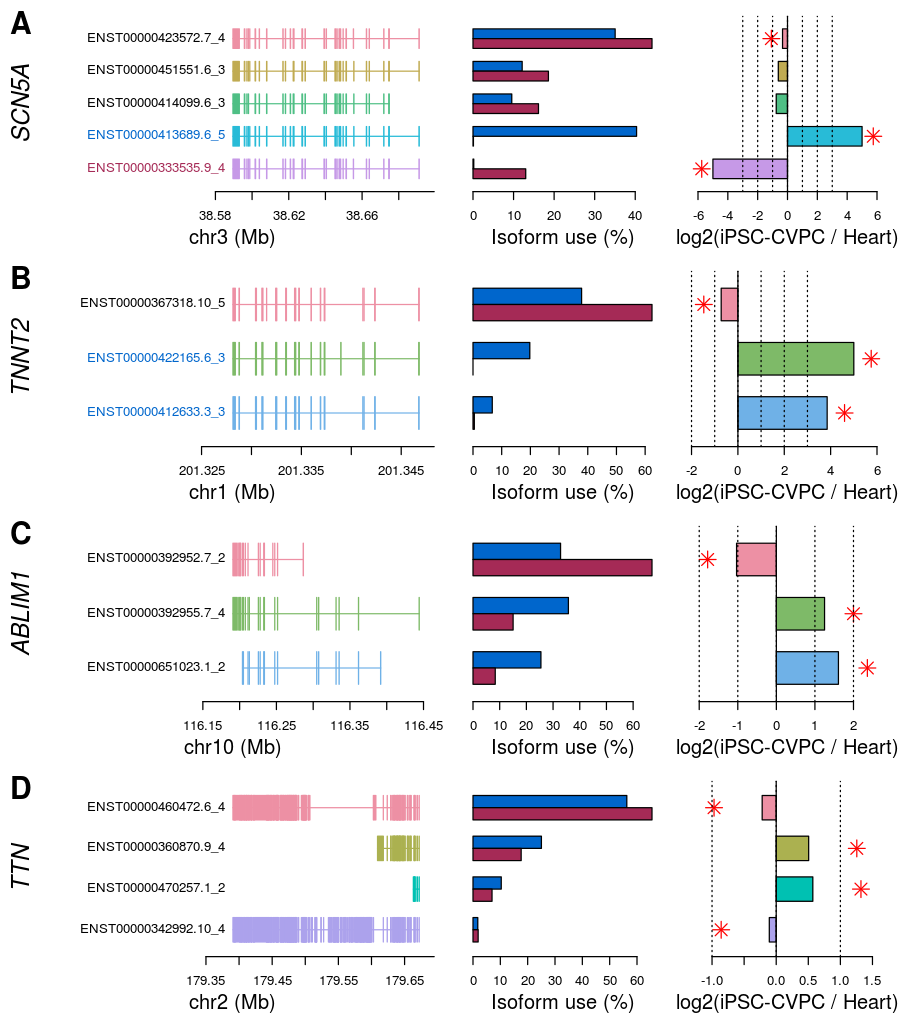

In [1108]:
figure_s7 = function()
{
    myline = c(1,1,2,3)
    layout(matrix(myline + sort(rep(0:3, 4)) * 3, nrow = 4, byrow = TRUE))
    figure_s7x(geneinfo_genes[ geneinfo_genes$gene_name == "SCN5A" , "gene_id"], "A")
    figure_s7x(geneinfo_genes[ geneinfo_genes$gene_name == "TNNT2" , "gene_id"], "B")
    figure_s7x(geneinfo_genes[ geneinfo_genes$gene_name == "ABLIM1", "gene_id"], "C")
    figure_s7x(geneinfo_genes[ geneinfo_genes$gene_name == "TTN"   , "gene_id"], "D")
}

png(filename = "manuscript/cardiac_differential_expression/figure_S7.png", width = 8.5, height = 11, units = "in", res = 300)
figure_s7()
dev.off()

options(repr.plot.width = 7.5, repr.plot.height = 8.5)
figure_s7()


# Figure 3: splice site strength of iPSC-CVPC-specific isoforms

png 
  2

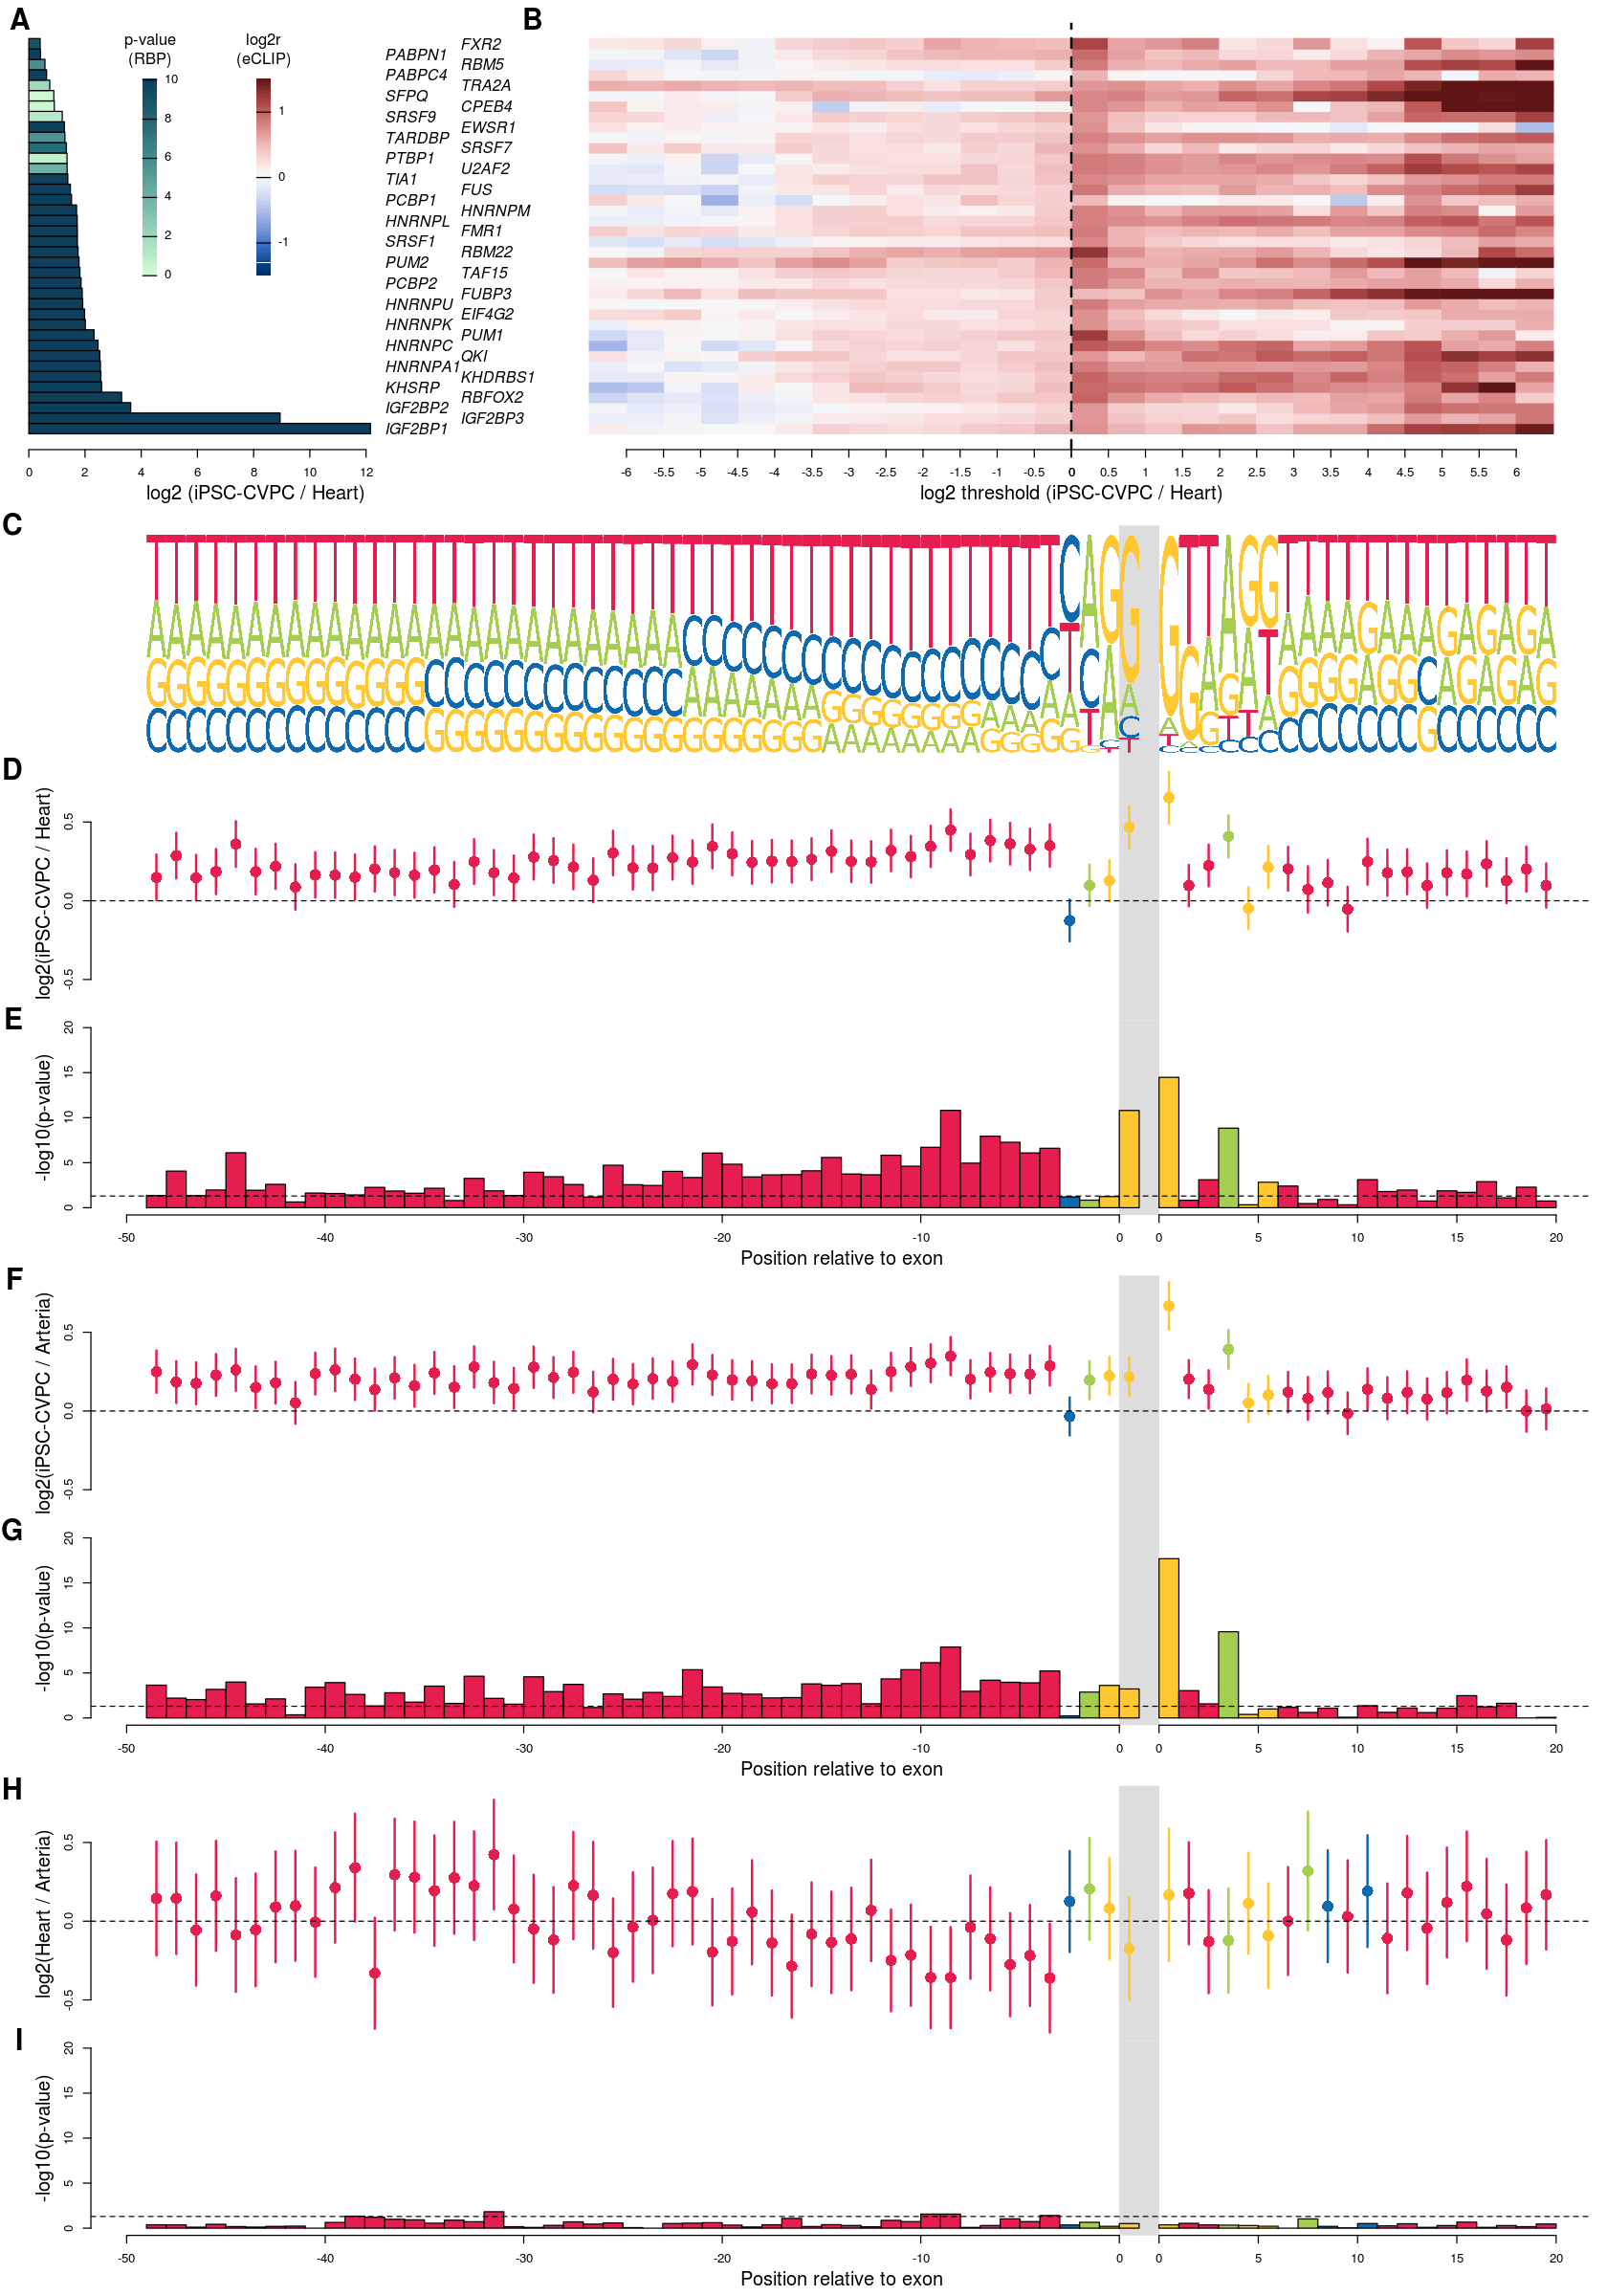

In [1944]:

prepare_stage2exp = function(test, tissue1, tissue2)
{
    this             = stage2exp[stage2exp$tissue1 == tissue1 & stage2exp$tissue2 == tissue2 & stage2exp$test == test & stage2exp$gene_name != "MATR3",]
    this             = this[order(this$threshold),]
    this$threshold   = paste("threshold", this$threshold, sep = "_")
    rbp2x            = aggregate(log2estimate ~ gene_name, data = this, FUN = max)
    rbp2x            = rbp2x[order(rbp2x$log2estimate),]
    diftiss          = diftiss[ diftiss$tissue1 == tissue1 & diftiss$tissue2 == tissue2 & diftiss$gene_name %in% rbp2x$gene_name, ]
    diftiss          = diftiss[order(diftiss$log2r, decreasing = TRUE),]
    rbps             = diftiss$gene_name
    thresholds       = sort(unique(this$threshold))
    toplot           = matrix("#eeeeee", nrow = length(rbps), ncol = length(thresholds))
    rownames(toplot) = rbps
    colnames(toplot) = thresholds
    diftiss$y        = 1:nrow(diftiss)
    
    for(ii in 1:nrow(this))
    {
        rbp       = this[ii, "gene_name"   ]
        threshold = this[ii, "threshold"   ]
        x         = this[ii, "log2estimate"]
        
        if(is.infinite(x) == FALSE){toplot[rbp, threshold] = values2color(x, colorscale = diverging_hcl(n = 100, palette = "Blue-Red 3"), minval = -1.5, maxval = 1.5)}
    }
    return(list(diftiss = diftiss, toplot = toplot))
}

plot_dif2tis = function(dif2rbp, tissue1, tissue2, panel = "", legend = FALSE)
{
    dif2rbp$color = values2color(-log10(dif2rbp$pval), colorscale = sequential_hcl(n = 100, palette = "Dark Mint", rev = TRUE), minval = 0, maxval = 10)
    
    
    par(mar = c(4,1,1.5,10))
    plot(1,1, type = "n", xlim = c(min(c(0, min(dif2rbp$log2r))), max(c(0, max(dif2rbp$log2r)))), ylim = c(0, nrow(dif2rbp)), xlab = "", ylab = "", axes = FALSE)
    
    dif2rbp$x = 0
    
    dif2rbp[ dif2rbp$y %% 2 == 0, "x"] = 5
    
    toax = paste("log2 (", tissue2color3[tissue1, "body_site"], " / ", tissue2color3[tissue2, "body_site"], ")", sep = "")
    axis(1)
    mtext(text = panel            , side = 2, line = -1        , at = nrow(dif2rbp) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = dif2rbp$gene_name, side = 4, line = dif2rbp$x, at = dif2rbp$y     - 0.5 , font = 3, cex = 0.8, las = 2)
    #mtext(text = "RBPs"           , side = 2, line = 0.5)
    mtext(text = toax             , side = 1, line = 2.5, at = mean(c(max(c(0, max(dif2rbp$log2r))), min(c(0, min(dif2rbp$log2r))))) + 2)
    
    rect(xleft = 0, xright = dif2rbp$log2r, ybottom = dif2rbp$y - 1, ytop = dif2rbp$y, col = dif2rbp$color)

    if(legend == TRUE)
    {
        torect = data.frame(color    = values2color((-75:75) / 50, colorscale = diverging_hcl(n = 100, palette = "Blue-Red 3"), minval = -1.5, maxval = 1.5),
                            estimate = (-75:75) / 50,
                            xleft    = max(dif2rbp$log2r) * 2/3,
                            xright   = max(dif2rbp$log2r) * 2/3 + 0.5,
                            ybottom  = nrow(dif2rbp) * 40/100 + (0:150) / 151 * nrow(dif2rbp) * 0.5,
                            ytop     = nrow(dif2rbp) * 40/100 + (1:151) / 151 * nrow(dif2rbp) * 0.5
                           )
        rect(xleft = torect$xleft, xright = torect$xright, ybottom = torect$ybottom, ytop = torect$ytop, col = torect$color, border = NA)

        totext = torect[torect$estimate %in% c(-1, 0, 1),]

        text    (x  = totext$xright, y = totext$ybottom, labels = totext$estimate, pos = 4)
        text    (x  = max(dif2rbp$log2r) * 2/3 + 0.25, y = nrow(dif2rbp) * 0.975 , labels = "log2r\n(eCLIP)", cex = 1.25)
        segments(x0 = totext$xleft , x1 = totext$xright, y0 = totext$ybottom)
        
        torect = data.frame(color    = values2color((0:100) / 10, colorscale = sequential_hcl(n = 100, palette = "Dark Mint", rev = TRUE), minval = 0, maxval = 10),
                            estimate = (0:100) / 10,
                            xleft    = max(dif2rbp$log2r) * 1/3,
                            xright   = max(dif2rbp$log2r) * 1/3 + 0.5,
                            ybottom  = nrow(dif2rbp) * 40/100 + (0:100) / 101 * nrow(dif2rbp) * 0.5,
                            ytop     = nrow(dif2rbp) * 40/100 + (1:101) / 101 * nrow(dif2rbp) * 0.5
                           )
        rect(xleft = torect$xleft, xright = torect$xright, ybottom = torect$ybottom, ytop = torect$ytop, col = torect$color, border = NA)

        totext = torect[torect$estimate %in% ((0:5) * 2),]

        text    (x  = totext$xright, y = totext$ybottom, labels = totext$estimate, pos = 4)
        text    (x  = max(dif2rbp$log2r) * 1/3 + 0.25, y = nrow(dif2rbp)  * 0.975, labels = "p-value\n(RBP)", cex = 1.25)
        segments(x0 = totext$xleft , x1 = totext$xright, y0 = totext$ybottom)
    }
}

plot_stage2exp = function(dif1, dif2, tissue1, tissue2, panel = "", legend = FALSE)
{
    
    toplot1 = dif1$toplot
    toplot2 = dif2$toplot
    
    par(mar = c(4,1,1.5,1))
    plot(1,1, type = "n", xlim = c(-ncol(toplot2), ncol(toplot1)), ylim = c(0,nrow(toplot1)), xlab = "", ylab = "", axes = FALSE)
    axis(1, at =   1:ncol(toplot1) - 1 , labels =  as.numeric(gsub("threshold_", "", colnames(toplot1))))
    axis(1, at = -(1:ncol(toplot1) - 1), labels = -as.numeric(gsub("threshold_", "", colnames(toplot1))))
    
    toax = paste("log2 threshold (", tissue2color3[tissue1, "body_site"], " / ", tissue2color3[tissue2, "body_site"], ")", sep = "")
    mtext(text = panel , side = 2, line = 0.5, at = nrow(toplot1) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = toax  , side = 1, line = 2.5, at = 0)
    
    for(ii in 1:ncol(toplot1))
    {
        rect(xleft =   ii - 1 , xright =  ii, ybottom = 1:nrow(toplot1) - 1, ytop = 1:nrow(toplot1), col = as.character(toplot1[,ii]), border = as.character(toplot1[,ii]))
        rect(xleft = -(ii - 1), xright = -ii, ybottom = 1:nrow(toplot2) - 1, ytop = 1:nrow(toplot2), col = as.character(toplot2[,ii]), border = as.character(toplot2[,ii]))
    }
    abline(v = 0, lty = "dashed", lwd = 2)
    
    if(legend == TRUE)
    {
        torect = data.frame(color    = values2color((-75:75) / 50, colorscale = diverging_hcl(n = 100, palette = "Blue-Red 3"), minval = -1.5, maxval = 1.5),
                            estimate = (-75:75) / 50,
                            xleft    = ncol(toplot) * 1.05,
                            xright   = ncol(toplot) * 1.1 ,
                            ybottom  = nrow(toplot) * 40/100 + (0:150) / 151 * nrow(toplot) * 0.5,
                            ytop     = nrow(toplot) * 40/100 + (1:151) / 151 * nrow(toplot) * 0.5
                           )
        rect(xleft = torect$xleft, xright = torect$xright, ybottom = torect$ybottom, ytop = torect$ytop, col = torect$color, border = NA)
        
        totext = torect[torect$estimate %in% c(-1, 0, 1),]
        
        text    (x = totext$xright, y = totext$ybottom, labels = totext$estimate, pos = 4)
        segments(x0 = totext$xleft, x1 = totext$xright, y0 = totext$ybottom)
    }
}

plot_logo2 = function(test, tissue1, tissue2, xlims = c(-20, 5.5), panels = c("", "", ""), logo = FALSE)
{
    base2col   = data.frame(nuc = c("A", "C", "G", "T"), color = c("#a5cd50", "#0f69af", "#ffc832", "#e61e50"))
    myseq      = consensus_list[[paste(tissue1, tissue2, tissue1, sep = ".")]]
    donor      = myseq[["donor"   ]]
    acceptor   = myseq[["acceptor"]]
    donor   $x = (   1:100) 
    acceptor$x = (-100: -1) 
    toplot     = rbind(donor, acceptor)
    toplot     = toplot[order(toplot$x),]
    toplot     = toplot[toplot$x >= xlims[[1]] & toplot$x <= xlims[[2]],]

    if(logo == TRUE)
    {
        par(mar = c(0,6,1,1))
        plot(1,1, type = "n", xlab = "", ylab = "", xlim = xlims, ylim = c(-100, max(rowSums(toplot[,nucs]))), axes = FALSE)

        mtext(text = panels[[1]], side = 2, line = 4.5, at = max(rowSums(toplot[,nucs])) * 1.05, font = 2, cex = 1.5, las = 2)
        rect(xleft = -1, xright = 1, ybottom = -1000, ytop = max(rowSums(toplot[,nucs])) * 1.1, col = "#dddddd", border = NA)
    }

    pos2nuc = as.data.frame(rbindlist(lapply(toplot$x, function(x)
    {
        this    = data.frame(nuc = nucs, n = as.numeric(toplot[toplot$x == x, nucs]))
        this    = this[order(this$n),]
        y0s     = c(0, this[1:3, "n"])
        y1s     =      this[1:4, "n"]
        this$y0 = unlist(lapply(1:length(y0s), function(ii){sum(y0s[1:ii])}))
        this$y1 = unlist(lapply(1:length(y1s), function(ii){sum(y1s[1:ii])}))

        invisible(lapply(1:nrow(this), function(ii)
        {
            nuc = this[ii, "nuc"]
            y0  = this[ii, "y0" ]
            y1  = this[ii, "y1" ]

            if(logo == TRUE){rasterImage(image = tologos[[nuc]], xleft = x, xright = x + 1, ybottom = y0, ytop = y1)}
        }))
        out = data.frame(x = x, nuc = this[4, "nuc"])

        return(out)
    })), stringsAsFactors = FALSE)
    test = testseq[ testseq$tissue1 == tissue1 & testseq$tissue2 == tissue2,]
    test$x = test$pos
    test[test$seq == "acceptor", "x"] = test[test$seq == "acceptor", "x"] - 101
    
    toplot = merge(pos2nuc, test, by = c("x", "nuc"))
    toplot = merge(toplot , base2col)
    toplot = toplot[order(toplot$x),]
    
    toplot$ci1      = log2(toplot$ci1     )
    toplot$ci2      = log2(toplot$ci2     )
    toplot$estimate = log2(toplot$estimate)
    
    ylab = paste("log2(", tissue2color3[tissue1, "body_site"], " / ", tissue2color3[tissue2, "body_site"], ")", sep = "")
    par(mar = c(0,6,0,1))
    plot(1,1, type = "n", xlab = "", ylab = "", xlim = xlims, ylim = c(-0.7,0.8), axes = FALSE)
    mtext(text = panels[[2]], side = 2, line = 4.5, at = 0.8 * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = ylab       , side = 2, line = 2.5)
    rect(xleft = -1, xright = 1, ybottom = -10, ytop = 10, col = "#dddddd", border = NA)
    
    axis(2)
    
    segments(x0 = toplot$x + 0.5, y0 = toplot$ci1     , col = toplot$color, y1 = toplot$ci2, lwd = 2)
    points  (x  = toplot$x + 0.5, y  = toplot$estimate, col = toplot$color, cex = 2, pch = 16)
    
    abline(h = 0      , lty = "dashed")
    
    toplot$logp = -log10(toplot$pval)
    
    par(mar = c(4,6,0,1))
    plot(1,1, type = "n", xlab = "", ylab = "", xlim = xlims, ylim = c(0, 20), axes = FALSE)
    mtext(text = panels[[3]]                , side = 2, line = 4.5, at = 20 * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = "-log10(p-value)"          , side = 2, line = 2.5)
    mtext(text = "Position relative to exon", side = 1, line = 2.5)
    rect(xleft = -1, xright = 1, ybottom = -10, ytop = 50, col = "#dddddd", border = NA)
    
    axis(2)
    axis(1, at = pretty(c(-1, xlims[[1]]    )) - 1, labels = pretty(c(-1, xlims[[1]]    )))
    axis(1, at = pretty(c( 1, xlims[[2]] - 1)) + 1, labels = pretty(c( 1, xlims[[2]]    )))
    
    rect(xleft = toplot$x, xright = toplot$x + 1, ybottom = 0, ytop = toplot$logp, col = toplot$color)
    
    abline(h = -log10(0.05), lty = "dashed")
}

figure_3 = function()
{
    layout(cbind(c(2,2,3:9), 
                 c(1,1,3:9), 
                 c(1,1,3:9)
                ))
    
    dif2rbp  = prepare_stage2exp("ipsc_cvpc", "ipsc_cvpc", "heart")
    dif2rbp2 = prepare_stage2exp("heart"    , "ipsc_cvpc", "heart")
    plot_stage2exp   (dif2rbp, dif2rbp2, "ipsc_cvpc", "heart", "B", FALSE)
    plot_dif2tis(dif2rbp$diftiss, "ipsc_cvpc", "heart", "A", TRUE)
    
    
    plot_logo2("ipsc_cvpc", "ipsc_cvpc", "heart"  , xlims = c(-50, 20), c("C", "D", "E"), TRUE )
    plot_logo2("ipsc_cvpc", "ipsc_cvpc", "arteria", xlims = c(-50, 20), c("" , "F", "G"), FALSE)
    plot_logo2("heart"    , "heart"    , "arteria", xlims = c(-50, 20), c("" , "H", "I"), FALSE)
}

png(filename = "manuscript/cardiac_differential_expression/figure_3.png", width = 14, height = 20, units = "in", res = 300)
figure_3()
dev.off()

options(repr.plot.width = 14, repr.plot.height = 20)
figure_3()



## Figure S8: enrichment for eCLIP

png 
  2

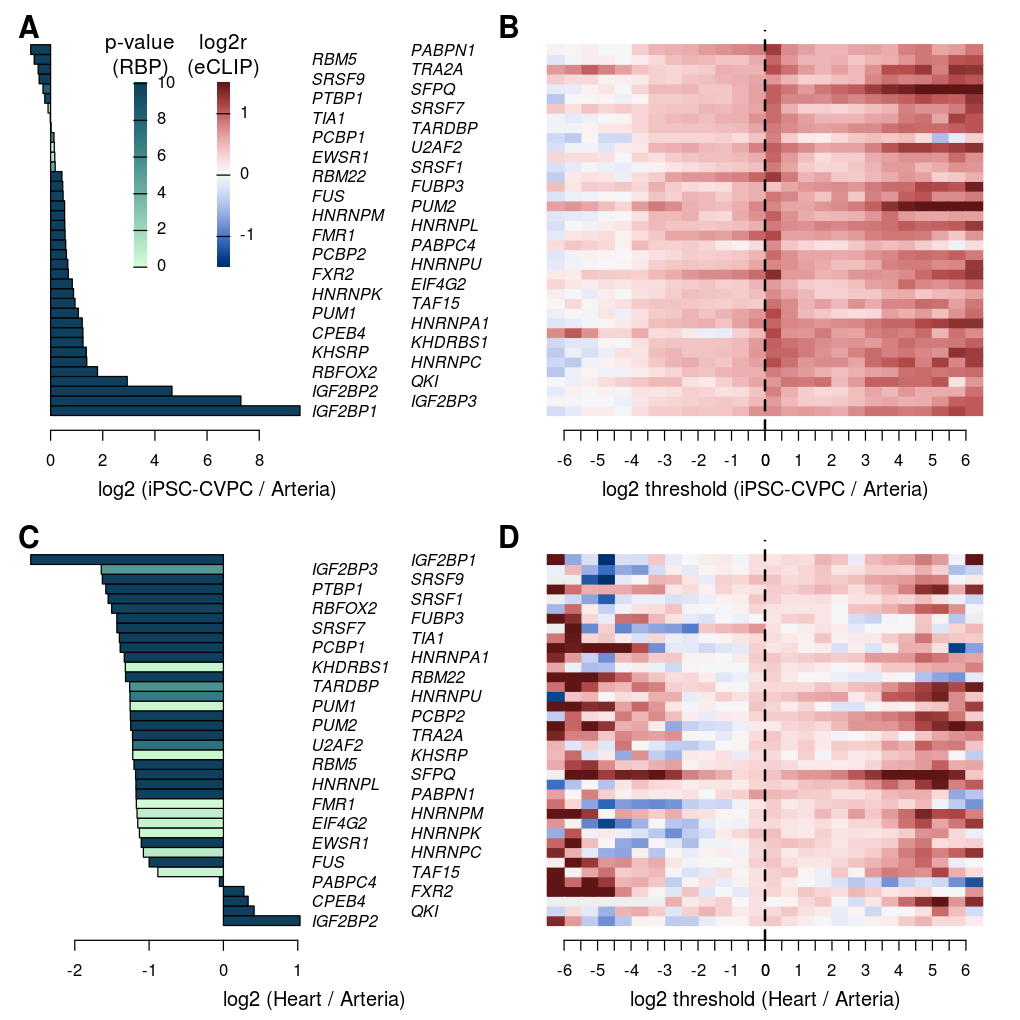

In [1913]:
figure_s8 = function()
{
    layout(rbind(c(2,1),
                 c(4,3))
          )
    dif2rbp1  = prepare_stage2exp("ipsc_cvpc", "ipsc_cvpc", "arteria")
    dif2rbp12 = prepare_stage2exp("arteria"  , "ipsc_cvpc", "arteria")
    plot_stage2exp   (dif2rbp1, dif2rbp12, "ipsc_cvpc", "arteria", "B", FALSE)
    plot_dif2tis(dif2rbp1$diftiss, "ipsc_cvpc", "arteria", "A", TRUE)
    
    dif2rbp2  = prepare_stage2exp("heart"  , "heart", "arteria")
    dif2rbp22 = prepare_stage2exp("arteria", "heart", "arteria")
    plot_stage2exp   (dif2rbp2, dif2rbp22, "heart", "arteria", "D", FALSE)
    plot_dif2tis(dif2rbp2$diftiss, "heart", "arteria", "C", FALSE)
    
}

png(filename = "manuscript/cardiac_differential_expression/figure_S8.png", width = 8.5, height = 8.5, units = "in", res = 300)
figure_s8()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 8.5)
figure_s8()


## Figure S9: iPSC-CVPC-specific exons enriched for splice sites overlapping RBP motifs

In [1919]:
toshow

[1] "CELF1"   "HNRNPL"  "RBFOX2"  "RBM24"   "MBNL1"   "RBFOX1"  "TAF15"  
 [8] "IGF2BP1" "PABPC1"  "RBM4"    "RBM20"   "ZFP36"   "ESRP1"   "IGF2BP3"
[15] "RBMS3"   "SRSF9"   "CPEB1"   "PTBP1"   "RBM38"   "QKI"     "PUM2"   
[22] "SAMD4A"

In [1836]:

homer1 = fread("/home/tarthur/projects/CARDIPS/differential_expression/homer_analysis/supplemental/ipsc.heart.csv"   , sep = ",", header = TRUE, data.table = FALSE)
homer2 = fread("/home/tarthur/projects/CARDIPS/differential_expression/homer_analysis/supplemental/ipsc.arteria.csv" , sep = ",", header = TRUE, data.table = FALSE)
homer3 = fread("/home/tarthur/projects/CARDIPS/differential_expression/homer_analysis/supplemental/heart.arteria.csv", sep = ",", header = TRUE, data.table = FALSE)

homer1$tissue1 = "ipsc_cvpc"
homer1$tissue2 = "heart"
homer2$tissue1 = "ipsc_cvpc"
homer2$tissue2 = "arteria"
homer3$tissue1 = "heart"
homer3$tissue2 = "arteria"

homer         = rbind(homer1, homer2, homer3)
homer$log2r   = homer$enrichment
homer$pval    = homer$p.value
homer$qval    = homer$q.value
homer$diffexp = FALSE
homer[homer$qval < 0.1, "diffexp"] = TRUE

homer[homer$qval == 0, "qval"] = min(homer[homer$qval > 0, "qval"])

homer[is.na(homer$enrichment) == TRUE, "log2r"] = 0

png 
  2

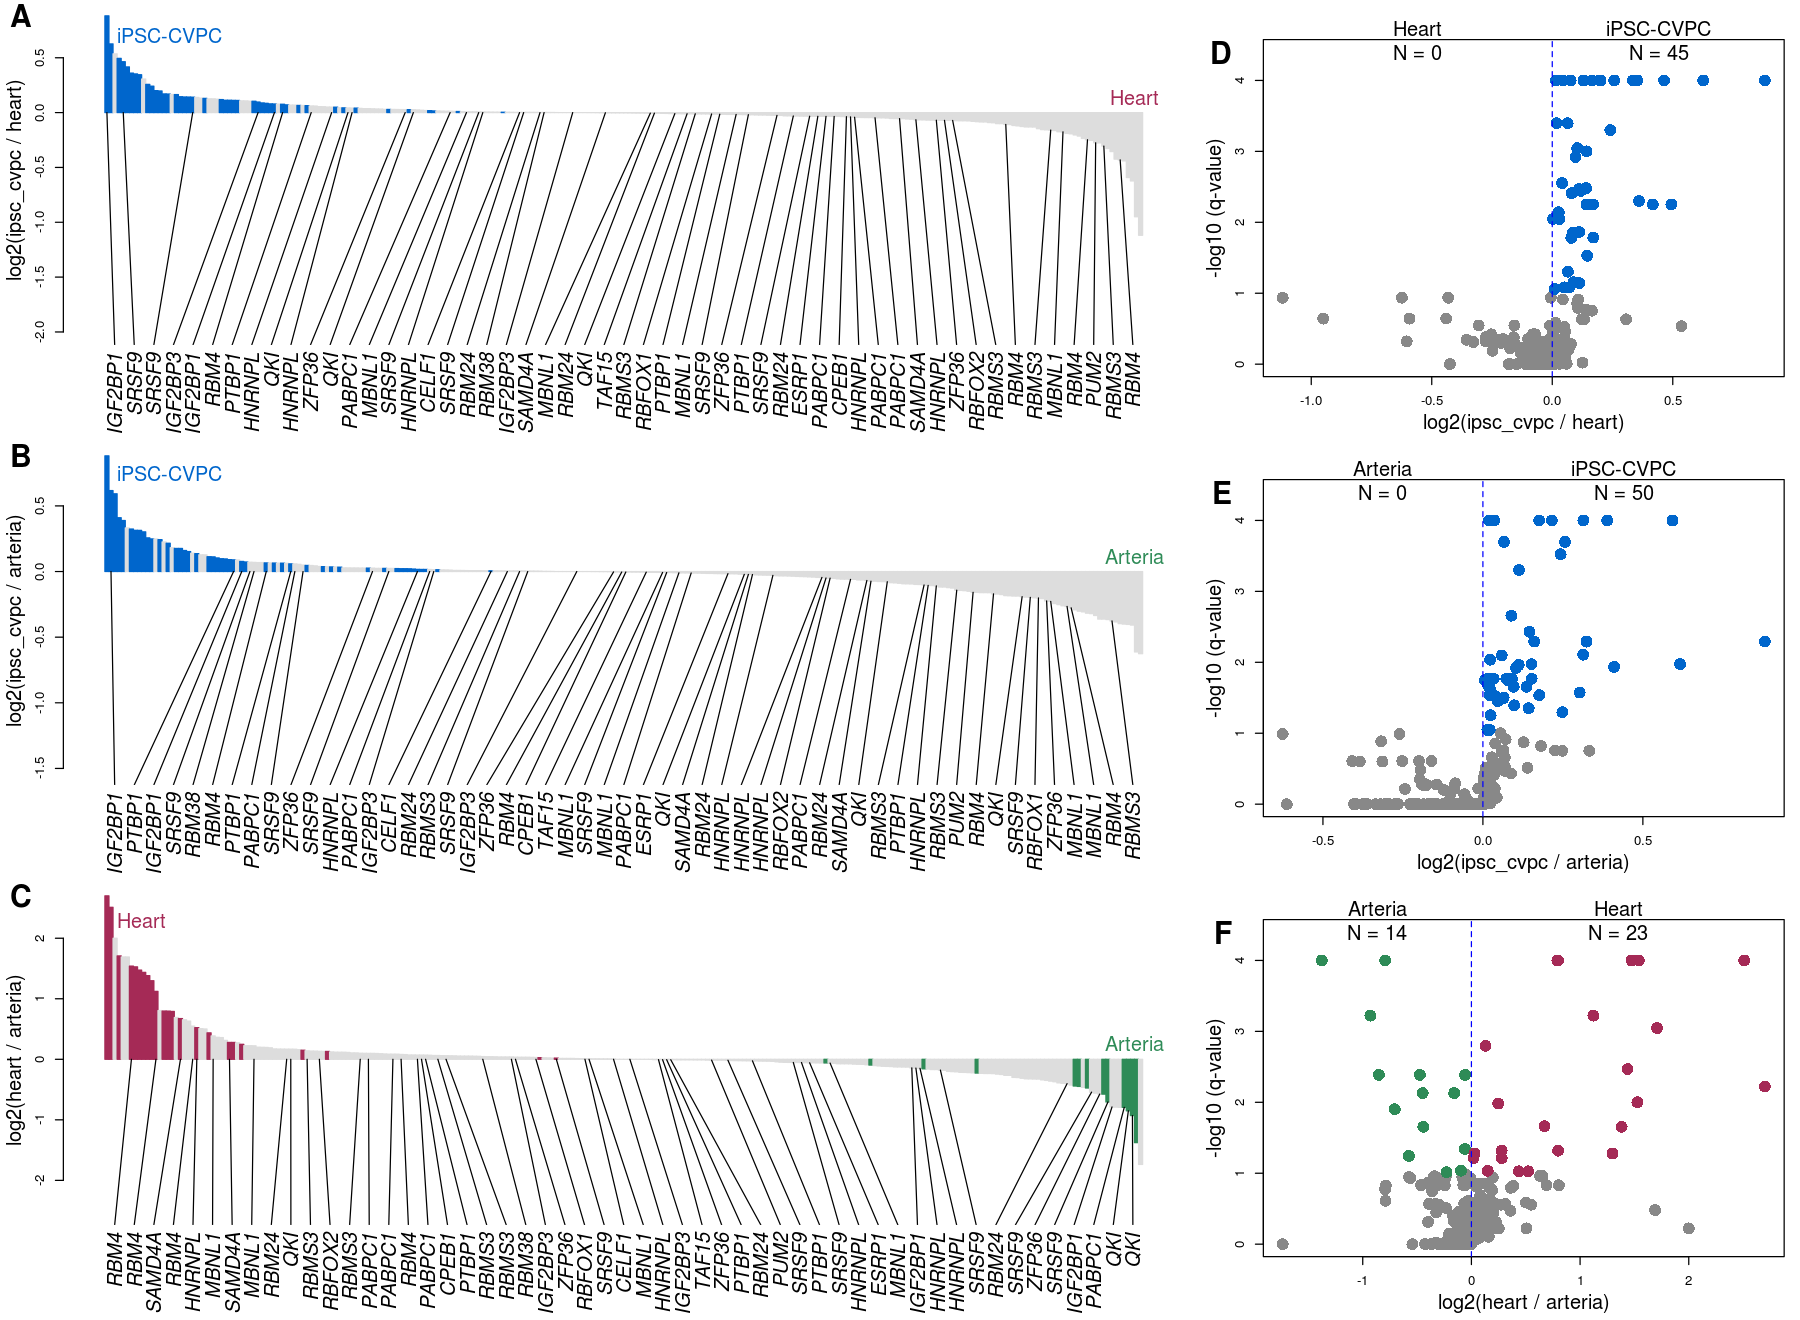

In [1842]:
volcano_plot_rbp_homer = function(x, tissue1 = "", tissue2 = "", toshow = c(), panel = "", legend = FALSE)
{
    if((tissue1 != "")&(tissue2 != ""))
    {
        x = x[x$tissue1 == tissue1 & x$tissue2 == tissue2,]
        x$cex = 0.5
    }else
    {
        x$tissue12 = paste(x$tissue1, "vs.", x$tissue2)
        x          = merge(x, data.frame(tissue12 = sort(unique(x$tissue12)), color = diverging_hcl(n = length(unique(x$tissue12)), palette = "Berlin")))
    }
    
    x = x[x$gene_name %in% rbps2plot,]
    x$color = "#dddddd"
    
    if(nrow(x[is.infinite(x$log2r) == TRUE & x$log2r > 0,]) > 0){x[is.infinite(x$log2r) == TRUE & x$log2r > 0, "log2r"] =  max(abs(x[is.infinite(x$log2r) == FALSE, "log2r"]))}
    if(nrow(x[is.infinite(x$log2r) == TRUE & x$log2r < 0,]) > 0){x[is.infinite(x$log2r) == TRUE & x$log2r < 0, "log2r"] = -max(abs(x[is.infinite(x$log2r) == FALSE, "log2r"]))}
    
    #if(nrow(x[x$diffexp == TRUE, ]) > 0){x[x$diffexp == TRUE, "color"] = sequential_hcl(4, palette = "plasma", rev = TRUE)[[1]]}
    
    if(nrow(x[x$diffexp == TRUE & x$log2r >  0, ]) > 0){x[x$diffexp == TRUE & x$log2r >  0, "color"] = tissue2color3[tissue1, "color"]}
    if(nrow(x[x$diffexp == TRUE & x$log2r >  0, ]) > 0){x[x$diffexp == TRUE & x$log2r < -0, "color"] = tissue2color3[tissue2, "color"]}
    
    x = x[order(x$log2r, decreasing = TRUE),]
    
    par(mar = c(6,4,1,1))
    
    barplot(x$log2r, width = 1, space = 0, col = x$color, border = x$color, ylim = c(min(x$log2r - 1), max(x$log2r)))
     
    mtext(text = paste("log2(", tissue1, " / ", tissue2, ")", sep = "")              , side = 2, line =  2.5)
    mtext(text = panel                                                               , side = 2, line =  2  , las = 2, at = max(x$log2r), font = 2, cex = 1.5)
    
    text(labels = tissue2color3[tissue1, "body_site"], x = 1          , y = (max(x$log2r) - min(x$log2r)) * 0.9 + min(x$log2r), pos = 4, cex = 1.5, col = tissue2color3[tissue1, "color"])
    text(labels = tissue2color3[tissue2, "body_site"], x = nrow(x) - 2, y = 0                                                 , pos = 3, cex = 1.5, col = tissue2color3[tissue2, "color"])
    #mtext(text = paste("N", nrow(x[x$diffexp == TRUE & x$log2r >  2, ]), sep = " = "), side = 3, line = -1.5, at = max(x[x$log2r > 0 & x$log2r <  20, "log2r"]) * 0.5)
    #mtext(text = paste("N", nrow(x[x$diffexp == TRUE & x$log2r < -2, ]), sep = " = "), side = 3, line = -1.5, at = min(x[x$log2r < 0 & x$log2r > -20, "log2r"]) * 0.5)
    
    x$x2    = (1:nrow(x)) - 0.5
    toax    = x[x$gene_name %in% toshow,]
    toax$x1 = (1:nrow(toax) - 0.5) * nrow(x) / nrow(toax)
    
    mtext(text = toax$gene_name, side = 1, line = 0.5, at = toax$x1, font = 3, las = 2)
    
    toax$y = 0
    if(nrow(toax[toax$log2r < 0, ]) > 0){toax[toax$log2r < 0, "y"] = toax[toax$log2r < 0, "log2r"]}
    
    segments(x0 = toax$x1, x1 = toax$x2, y0 = min(x$log2r - 1), y1 = toax$y)
}

volcano_plot_log2r_homer = function(x, tissue1 = "", tissue2 = "", panel = "", legend = FALSE)
{
    if((tissue1 != "")&(tissue2 != ""))
    {
        x = x[x$tissue1 == tissue1 & x$tissue2 == tissue2,]
        x$cex = 0.5
    }else
    {
        x$tissue12 = paste(x$tissue1, "vs.", x$tissue2)
        x          = merge(x, data.frame(tissue12 = sort(unique(x$tissue12)), color = diverging_hcl(n = length(unique(x$tissue12)), palette = "Berlin")))
    }

    x$filter = 0
    x[x$diffexp == TRUE, "filter"] = 1
    #x[x$diffexp == TRUE & abs(x$log2r) >= 1, "filter"] = 2
    x[x$diffexp == TRUE & abs(x$log2r) >= 2, "filter"] = 4
    #x[x$diffexp == TRUE & abs(x$log2r) >= 3, "filter"] = 4
    
    filter2color = data.frame(filter = 0:4, filter_label = c("N.S.", "FDR < 0.05", paste("log2r >", 1:3)), color = c("#888888", sequential_hcl(4, palette = "plasma", rev = TRUE)))
    
    x = merge(x, filter2color, by = "filter")
    
    
    if(nrow(x[is.infinite(x$log2r) == TRUE & x$log2r > 0,]) > 0){x[is.infinite(x$log2r) == TRUE & x$log2r > 0, "log2r"] =  max(abs(x[is.infinite(x$log2r) == FALSE, "log2r"]))}
    if(nrow(x[is.infinite(x$log2r) == TRUE & x$log2r < 0,]) > 0){x[is.infinite(x$log2r) == TRUE & x$log2r < 0, "log2r"] = -max(abs(x[is.infinite(x$log2r) == FALSE, "log2r"]))}
    
    #if(nrow(x[x$diffexp == TRUE, ]) > 0){x[x$diffexp == TRUE, "color"] = sequential_hcl(4, palette = "plasma", rev = TRUE)[[1]]}
    
    if(nrow(x[x$diffexp == TRUE & x$log2r >  0, ]) > 0){x[x$diffexp == TRUE & x$log2r >  0, "color"] = tissue2color3[tissue1, "color"]}
    if(nrow(x[x$diffexp == TRUE & x$log2r >  0, ]) > 0){x[x$diffexp == TRUE & x$log2r < -0, "color"] = tissue2color3[tissue2, "color"]}

    par(mar = c(4,4,2.5,1))
    plot(x$log2r, -log10(x$qval), pch = 16, col = x$color, ylim = c(0, max(-log10(x$qval))*1.1), cex = 2, xlab = "", ylab = "")
    
    abline(v = 0, col = "#0000ff", lty = "dashed")
    
    mtext(text = paste("log2(", tissue1, " / ", tissue2, ")", sep = "")              , side = 1, line =  2.5)
    mtext(text = "-log10 (q-value)"                                                  , side = 2, line =  2.5)
    mtext(text = panel                                                               , side = 2, line =  2  , at = max(-log10(x$qval)) * 1.1, font = 2, cex = 1.5, las = 2)
    mtext(text = tissue2color3[tissue1, "body_site"]                                 , side = 3, line =  0  , at = max(x[x$log2r > 0 & x$log2r <  20, "log2r"]) * 0.5)
    mtext(text = tissue2color3[tissue2, "body_site"]                                 , side = 3, line =  0  , at = min(x[x$log2r < 0 & x$log2r > -20, "log2r"]) * 0.5)
    mtext(text = paste("N", nrow(x[x$diffexp == TRUE & x$log2r >  0, ]), sep = " = "), side = 3, line = -1.5, at = max(x[x$log2r > 0 & x$log2r <  20, "log2r"]) * 0.5)
    mtext(text = paste("N", nrow(x[x$diffexp == TRUE & x$log2r < -0, ]), sep = " = "), side = 3, line = -1.5, at = min(x[x$log2r < 0 & x$log2r > -20, "log2r"]) * 0.5)
}

figure_s9 = function()
{
    layout(rbind(c(1,1,4),
                 c(2,2,5),
                 c(3,3,6)
                ))
    
    volcano_plot_rbp_homer(homer, "ipsc_cvpc", "heart"  , toshow, "A", FALSE)
    volcano_plot_rbp_homer(homer, "ipsc_cvpc", "arteria", toshow, "B", FALSE)
    volcano_plot_rbp_homer(homer, "heart"    , "arteria", toshow, "C", FALSE)

    volcano_plot_log2r_homer(homer, "ipsc_cvpc", "heart"  , "D", FALSE)
    volcano_plot_log2r_homer(homer, "ipsc_cvpc", "arteria", "E", FALSE)
    volcano_plot_log2r_homer(homer, "heart"    , "arteria", "F", FALSE)

}

png(filename = "manuscript/cardiac_differential_expression/figure_S9.png", width = 15, height = 11, units = "in", res = 300)
figure_s9()
dev.off()

options(repr.plot.width = 15, repr.plot.height = 11)
figure_s9()



## Table S3,4,5,6,8: differential expression analysis and functional enrichment + RBPs
- S3: Differential expression (tissue)
- S4: Functional enrichment (tissue)
- S5: differential expression (isoform - tissue)
- S6: Overlap with eCLIP data
- S8: Enrichment at splice donor and acceptor



In [1857]:
table_s3           = diftiss[,c("gene_id", "gene_name", "tissue1", "tissue2", "beta", "se", "pval", "qval", "log2r", "diffexp")]
table_s3$tissue1   = suppressMessages(mapvalues(table_s3$tissue1, from=c("ipsc_cvpc", "heart", "arteria"), to=c("iPSC-CVPC", "Heart", "Arteria")))
table_s3$tissue2   = suppressMessages(mapvalues(table_s3$tissue2, from=c("ipsc_cvpc", "heart", "arteria"), to=c("iPSC-CVPC", "Heart", "Arteria")))
colnames(table_s3) = c("Gene ID", "Gene name", "Tissue 1", "Tissue 2", "Effect size (beta)", "Standard error of beta", "P-value", "FDR (Bonferroni)", "log2 ratio", "Differentially expressed")

table_s3_small = table_s3[table_s3[,"Differentially expressed"] == TRUE,]
table_s3_big   = table_s3

table_s3_small[,"Differentially expressed"] = NULL

fwrite(table_s3_small, "manuscript/cardiac_differential_expression/table_s3.csv"         , sep = ",", col.names = TRUE, row.names = FALSE)
fwrite(table_s3_big  , "manuscript/cardiac_differential_expression/table_s3_complete.csv", sep = ",", col.names = TRUE, row.names = FALSE)


In [1858]:
table_s4           = enrtiss[enrtiss$type == "gene_tpm", c("tissue1", "tissue2", "gs_source", "gene_set", "url", "ngenes", "ttest_estimate_in", "ttest_estimate_out", "ttest_pval", "ttest_fdr")]
table_s4$tissue1   = suppressMessages(mapvalues(table_s4$tissue1, from=c("ipsc_cvpc", "heart", "arteria"), to=c("iPSC-CVPC", "Heart", "Arteria")))
table_s4$tissue2   = suppressMessages(mapvalues(table_s4$tissue2, from=c("ipsc_cvpc", "heart", "arteria"), to=c("iPSC-CVPC", "Heart", "Arteria")))
colnames(table_s4) = c("Tissue 1", "Tissue 2", "Gene set collection", "Gene set", "Gene set URL", "Genes in gene set (N)", "Mean effect size in", "Mean effect size out", "P-value", "FDR (Benjamini-Hochberg)")

table_s4_small = table_s4[table_s4[,"FDR (Benjamini-Hochberg)"] <= 0.05,]
table_s4_big   = table_s4

fwrite(table_s4_small, "manuscript/cardiac_differential_expression/table_s4.csv"         , sep = ",", col.names = TRUE, row.names = FALSE)
fwrite(table_s4_big  , "manuscript/cardiac_differential_expression/table_s4_complete.csv", sep = ",", col.names = TRUE, row.names = FALSE)


In [1859]:
table_s5           = diftiss_iso[,c("transcript_id", "gene_id", "gene_name", "tissue1", "tissue2", "beta", "se", "pval", "qval", "tissue1_exp", "tissue2_exp", "log2r", "diffexp", "log2r_filter")]
table_s5$tissue1   = suppressMessages(mapvalues(table_s5$tissue1, from=c("ipsc_cvpc", "heart", "arteria"), to=c("iPSC-CVPC", "Heart", "Arteria")))
table_s5$tissue2   = suppressMessages(mapvalues(table_s5$tissue2, from=c("ipsc_cvpc", "heart", "arteria"), to=c("iPSC-CVPC", "Heart", "Arteria")))
colnames(table_s5) = c("Transcript ID", "Gene ID", "Gene name", "Tissue 1", "Tissue 2", "Effect size (beta)", "Standard error of beta", "P-value", "FDR (Bonferroni)", "Mean Use in Tissue1 (%)", "Mean Use in Tissue2 (%)", "log2 ratio", "Differentially expressed", "Stage-specific")

table_s5_small = table_s5[table_s5[,"Differentially expressed"] == TRUE,]
table_s5_big   = table_s5

table_s5_small[,"Differentially expressed"] = NULL

fwrite(table_s5_small, "manuscript/cardiac_differential_expression/table_s5.csv"         , sep = ",", col.names = TRUE, row.names = FALSE)
fwrite(table_s5_big  , "manuscript/cardiac_differential_expression/table_s5_complete.csv", sep = ",", col.names = TRUE, row.names = FALSE)


In [1860]:
table_s6           = fread("pipeline/4.1.differential_expression/functional_enrichment_isoforms.tissue.txt", sep = "\t", header = TRUE, data.table = FALSE)
table_s6           = table_s6[table_s6$type == "isoform_use", c("tissue1", "tissue2", "gs_source", "gene_set", "url", "ngenes", "estimate", "pval", "fdr")]
table_s6$tissue1   = suppressMessages(mapvalues(table_s6$tissue1, from = c("ipsc_cvpc", "heart", "arteria"), to = c("iPSC-CVPC", "Heart", "Arteria")))
table_s6$tissue2   = suppressMessages(mapvalues(table_s6$tissue2, from = c("ipsc_cvpc", "heart", "arteria"), to = c("iPSC-CVPC", "Heart", "Arteria")))
colnames(table_s6) = c("Tissue 1", "Tissue 2", "Gene set collection", "Gene set", "Gene set URL", "Genes in gene set (N)", "Enrichment (Fisher's exact test)", "P-value (Fisher's exact test)", "FDR (Benjamini-Hochberg)")

table_s6_small = table_s6[table_s4[,"FDR (Benjamini-Hochberg)"] <= 0.05,]
table_s6_big   = table_s6

fwrite(table_s6_small, "manuscript/cardiac_differential_expression/table_s6.csv"         , sep = ",", col.names = TRUE, row.names = FALSE)
fwrite(table_s6_big  , "manuscript/cardiac_differential_expression/table_s6_complete.csv", sep = ",", col.names = TRUE, row.names = FALSE)


In [841]:
table_s7            = fread("pipeline/4.10.diffexp_eclip_enrichment/exons_unique2domain.txt", sep = "\t", header = TRUE, data.table = FALSE)
table_s7$comparison = paste(tissue2color3[table_s7$tissue1, "body_site"], "vs.", tissue2color3[table_s7$tissue2, "body_site"])
table_s7$test       = tissue2color3[table_s7$tissue, "body_site"]
table_s7            = table_s7[,c("gene_id", "gene_name", "transcript_id", "exon_id", "comparison", "test", "domain")]
colnames(table_s7)  = c("Gene ID", "Gene name", "Transcript ID", "Exon ID", "Comparison", "Test", "Domains")

fwrite(table_s7 , "manuscript/cardiac_differential_expression/table_s7.csv" , sep = ",", col.names = TRUE, row.names = FALSE)


In [1949]:
table_s8            = stage2exp[stage2exp$test != "vs" & stage2exp$gene_name != "MATR3",]
table_s8$comparison = paste(tissue2color3[table_s8$tissue1, "body_site"], "vs.", tissue2color3[table_s8$tissue2, "body_site"])
table_s8$test       = tissue2color3[table_s8$test, "body_site"]

table_s8$tissue1    = unlist(lapply(table_s8$comparison, function(x){unlist(strsplit(x, " vs. "))[[1]]}))
table_s8$tissue2    = unlist(lapply(table_s8$comparison, function(x){unlist(strsplit(x, " vs. "))[[2]]}))

table_s8            = unique(table_s8[order(table_s8$comparison, table_s8$eclip, table_s8$threshold), c("tissue1", "tissue2", "gene_name", "eclip", "cell", "threshold", "estimate", "log2estimate", "pval_eclip")])
colnames(table_s8)  = c("Tissue1", "Tissue2", "RBP", "eCLIP experiment", "eCLIP cell line", "log2 ratio threshold", "Estimate (Fisher's exact test)", "log2 (estimate)", "p-value (Fisher's exact test)")

fwrite(table_s8 , "manuscript/cardiac_differential_expression/table_s8.csv" , sep = ",", col.names = TRUE, row.names = FALSE)


In [1889]:
table_s10            = testseq
table_s10$comparison = paste(tissue2color3[table_s10$tissue1, "body_site"], "vs.", tissue2color3[table_s10$tissue2, "body_site"])

table_s10[table_s10$seq == "acceptor", "pos"] = -table_s10[table_s10$seq == "acceptor", "pos"] + 1

table_s10$tissue1 = unlist(lapply(table_s10$comparison, function(x){unlist(strsplit(x, " vs. "))[[1]]}))
table_s10$tissue2 = unlist(lapply(table_s10$comparison, function(x){unlist(strsplit(x, " vs. "))[[2]]}))


table_s10           = table_s10[,c("tissue1", "tissue2", "seq", "nuc", "pos", "estimate", "ci1", "ci2", "pval")]
colnames(table_s10) = c("Tissue1", "Tissue2", "Splice site", "Nucleotide", "Position relative to exon", "Estimate", "Confidence interval 1", "Confidence interval 2", "p-value (Fisher's exact test)")

fwrite(table_s10 , "manuscript/cardiac_differential_expression/table_s10.csv" , sep = ",", col.names = TRUE, row.names = FALSE)


# Figure 4: Influence of cell composition on differential expression


In [1397]:
scdata      =              fread("pipeline/2.1.scrna_seq/tabula_muris.heart.metadata.txt"            , sep = "\t", header = TRUE, data.table = FALSE)
expcell     = add_rownames(fread("pipeline/2.1.scrna_seq/signature_gene_average_expression.heart.txt", sep = "\t", header = TRUE, data.table = FALSE))
cibersort   = add_rownames(fread("pipeline/2.1.scrna_seq/cibersort_results.txt"                      , sep = "\t", header = TRUE, data.table = FALSE))
cell2tissue = add_rownames(fread("pipeline/3.1.covariates/cell2tissue.txt"                           , sep = "\t", header = TRUE, data.table = FALSE))
markers     =              fread("pipeline/2.1.scrna_seq/markers.heart.txt"                          , sep = "\t", header = TRUE, data.table = FALSE)


In [1398]:
message(paste("Cells in Tabula muris heart"     , nrow(scdata)                                                    , sep = " = "))
message(paste("Cell types in Tabula muris heart", length(unique(scdata$cell_ontology_class))                      , sep = " = "))
message(paste("Cell types in Tabula muris heart", paste(sort(unique(scdata$cell_ontology_class)), collapse = ", "), sep = " = "))
message(paste("Marker genes"                    , length(unique(markers$gene))                                    , sep = " = "))


Cells in Tabula muris heart = 4365

Cell types in Tabula muris heart = 8

Cell types in Tabula muris heart = cardiac muscle cell, cardiac neuron, endocardial cell, endothelial cell, fibroblast, leukocyte, myofibroblast cell, smooth muscle cell

Marker genes = 7576



In [1399]:
cell2color_regular            = data.frame(cell_type = colnames(cibersort)[grepl("regular", colnames(cibersort)) == TRUE], color = c("#bb0000", "#00bb00", "#ff8888", "#FF34B3", "#0000bb", "#cdcd00", "#3D3D3D", "#8B814C")) 
cell2color_combined           = cell2color_regular
cell2color_combined$cell_type = gsub("regular", "combined", cell2color_combined$cell_type)
cell2color_combined           = cell2color_combined[cell2color_combined$cell_type %in% colnames(cibersort),]


## Differential expression keeping cell type into account

In [979]:
diffexp_lm           = fread("pipeline/4.1.differential_expression/diffexp.txt"       , sep = "\t", header = TRUE , data.table = FALSE)
diffexp_ridge        = fread("pipeline/4.15.differential_expression_ridge/diffexp.txt", sep = "\t", header = TRUE , data.table = FALSE)
diffexp_ridge_tissue = diffexp_ridge[ diffexp_ridge$covariate == "tissue",]

In [980]:
dec = merge(diffexp_lm, diffexp_ridge_tissue, by = c("transcript_id", "gene_id", "gene_name", "gene_type", "tissue1", "tissue2", "type"), suffixes = c("_lm", "_ridge"))

In [997]:
table(dec[ dec$type == "gene_tpm"    & dec$tissue1 == "ipsc_cvpc" & dec$tissue2 == "heart"  , c("diffexp_lm", "diffexp_ridge")])
table(dec[ dec$type == "gene_tpm"    & dec$tissue1 == "ipsc_cvpc" & dec$tissue2 == "arteria", c("diffexp_lm", "diffexp_ridge")])
table(dec[ dec$type == "gene_tpm"    & dec$tissue1 == "heart"     & dec$tissue2 == "arteria", c("diffexp_lm", "diffexp_ridge")])
#table(diffexp[ diffexp$type == "isoform_use" & diffexp$tissue1 == "ipsc_cvpc" & diffexp$tissue2 == "heart", c("diffexp_lm", "diffexp_ridge")])


          diffexp_ridge
diffexp_lm FALSE  TRUE
     FALSE  4999   670
     TRUE   2613 12111

          diffexp_ridge
diffexp_lm FALSE TRUE
     FALSE  4517  408
     TRUE   7864 7604

          diffexp_ridge
diffexp_lm FALSE  TRUE
     FALSE  6497   530
     TRUE  11872  1494

## Table S11-12: data to get CIBERSORT
- Table S11: Marker genes
- Table S12: Expression matrix input to CIBERSORT


In [1586]:
table_s11           = markers[,c("gene", "cluster", "pct.1", "pct.2", "avg_logFC", "p_val", "p_val_adj")]
table_s11$pct.1     = table_s11$pct.1 * 100
table_s11$pct.2     = table_s11$pct.2 * 100
table_s11$cluster   = gsub("leukocyte", "immune", gsub(" ", "_", gsub(" cell", "", table_s11$cluster)))
colnames(table_s11) = c("Gene name", "Cell type", "Cells in cell type with expression (%)", "Cells not in cell type with expression (%)", "log2 fold change vs. all other cells", "p-value (Wilcoxon test)", "FDR-corrected p-value")

In [1587]:
table_s12               = expcell
colnames(table_s12)     = gsub("leukocyte", "immune", gsub("_cell", "", colnames(table_s12)))
table_s12[,"Gene name"] = rownames(table_s12)
table_s12               = table_s12[,c("Gene name", gsub("regular\\.", "", cell2color_regular$cell_type))]
colnames(table_s12)     = gsub("_", " ", colnames(table_s12))


In [1588]:
fwrite(table_s11, "manuscript/cardiac_differential_expression/table_s11.csv", sep = ",", col.names = TRUE, row.names = FALSE)
fwrite(table_s12, "manuscript/cardiac_differential_expression/table_s12.csv", sep = ",", col.names = TRUE, row.names = FALSE)


## Figure S10: Cell composition of adult and iPSC-CVPC cardiac samples
- (A) UMAP plot from Tabula muris
- (B) cell type distributions for collapsed cell types

png 
  2

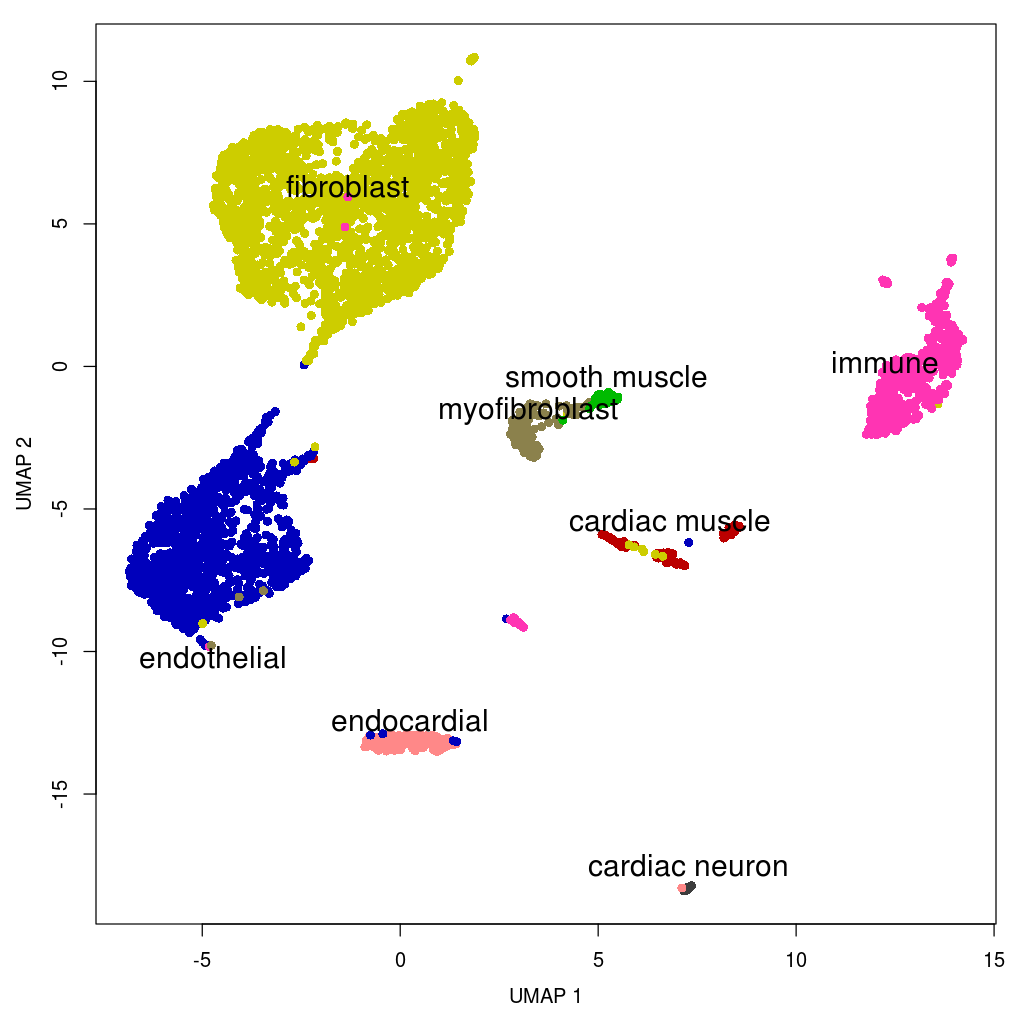

In [1934]:
figure_s10a = function(metadata, umap1, umap2, colordata, is_cat = TRUE, add_labels = FALSE, panel = "")
{
    if(is_cat == TRUE)
    {
        metadata = merge(metadata, colordata)
        name     = colnames(colordata)[[1]]
    }
    
    
    par(mar = c(4,4,1,1))
    plot(metadata[,umap1], metadata[,umap2], pch = 16, cex = 1, col = metadata$color, xlab = "", ylab = "")
    mtext(text = "UMAP 1", side = 1, line = 2.5)
    mtext(text = "UMAP 2", side = 2, line = 2.5)
    mtext(text = panel    , side = 2, line = 2  , at = max(metadata[, umap2]), font = 2, cex = 1.5, las = 2)
    
    if(add_labels == TRUE)
    {
        totext = aggregate(list(x = metadata[,umap1], y = metadata[,umap2]), by = list(cell = metadata$cell_type), FUN = mean)
        
        totext[totext$cell == "endothelial", "y"] = -11
        
        text(x = totext$x, y = totext$y, labels = gsub("_", " ", totext$cell), cex = 1.5, pos = 3)
    }
}

figure_s10 = function()
{
    #layout(rbind(c(1,1,2),
    #             c(1,1,2),
    #             rep(3,3)
    #            ))
    
    cell2color = cell2color_regular
    cell2color$cell_type = gsub("regular\\.", "", cell2color$cell_type)
    scdata$cell_type     = gsub("leukocyte", "immune", gsub(" ", "_", gsub(" cell", "", scdata$cell_ontology_class)))
    figure_s10a(scdata, "umap1", "umap2", cell2color, TRUE, TRUE, "")
    #plot.new()
    #figure_1b(cibersort[, cell2color_combined$cell_type], metadata, cell2color_combined, "B") 
}

png(filename = "manuscript/cardiac_differential_expression/figure_S10.png", width = 8.5, height = 8.5, units = "in", res = 300)
figure_s10()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 8.5)
figure_s10()


## Figure S12: Cell type-specific and cell type-associated genes

png 
  2

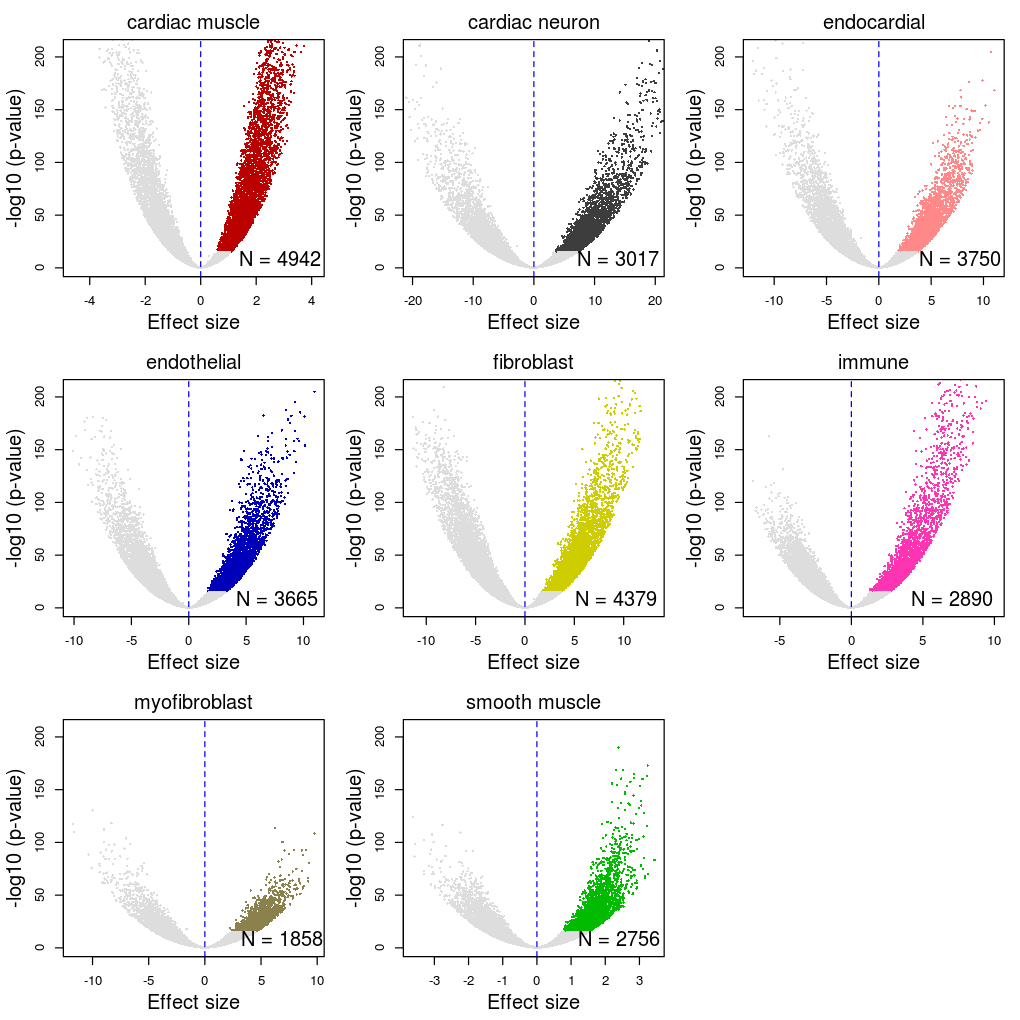

In [1904]:
volcano_plot_cell = function(x, tissue, panel = "")
{
    alldata = x
    ylims   = max(-log10(x$pval))
    x       = x[x$cell_type == tissue,]
    xlims   = range(x[x$beta >= -20 & x$beta <= 20, "beta"])
    mycol   = cell2color_regular[cell2color_regular$cell_type == gsub("cibersort\\.", "", tissue), "color"]
    x$color = "#dddddd"
    #x$pch   = 16
    x$cex   = 0.4
    #x$bg    = NA
    
    x[x$qval <= 0.05 & x$beta > 0, "color"] = mycol 
    #x[x$qval <= 0.05 & x$beta > 0 &  x$transcript_id %in% alldata[alldata$cell_type != tissue & alldata$qval <= 0.05 & alldata$beta > 0 & alldata$type == "gene_tpm", "transcript_id"], "color"] = "#999999"
    #x[x$qval <= 0.05 & x$beta > 0 & !x$transcript_id %in% alldata[alldata$cell_type != tissue & alldata$qval <= 0.05 & alldata$beta > 0 & alldata$type == "gene_tpm", "transcript_id"], "color"] = mycol 
    #x[x$qval <= 0.05 & x$beta > 0 & !x$transcript_id %in% alldata[alldata$cell_type != tissue & alldata$qval <= 0.05 & alldata$beta > 0 & alldata$type == "gene_tpm", "transcript_id"], "pch"  ] = 21 
    #x[x$qval <= 0.05 & x$beta > 0 & !x$transcript_id %in% alldata[alldata$cell_type != tissue & alldata$qval <= 0.05 & alldata$beta > 0 & alldata$type == "gene_tpm", "transcript_id"], "cex"  ] =  0.3 
    #x[x$qval <= 0.05 & x$beta > 0 & !x$transcript_id %in% alldata[alldata$cell_type != tissue & alldata$qval <= 0.05 & alldata$beta > 0 & alldata$type == "gene_tpm", "transcript_id"], "bg"   ] = mycol 
    
    #if(tissue != "cibersort.regular.cardiac_muscle"){x = rbind(x[x$color == "#dddddd",], x[x$color == "#999999",], x[x$color == mycol    ,])}
    #if(tissue == "cibersort.regular.cardiac_muscle"){x = rbind(x[x$color == "#dddddd",], x[x$color == mycol    ,], x[x$color == "#999999",])}
    
    par(mar = c(4,4,2.5,1))
    #plot(x$beta, -log(x$pval), col = x$color, cex = x$cex, pch = x$pch, bg = x$bg, xlim = xlims, ylim = c(0, ylims), xlab = "", ylab = "")
    #plot(x$beta, -log(x$pval), col = x$color, cex = 0.3, pch = 16, xlim = xlims, ylim = c(0, ylims), xlab = "", ylab = "")
    plot(x$beta, -log(x$pval), col = x$color, cex = x$cex, pch = 16, xlim = xlims, ylim = c(0, ylims), xlab = "", ylab = "")
    
    abline(v = 0, col = "#0000ff", lty = "dashed")
    
    mtext(text = "Effect size"                                                     , side = 1, line =  2.5)
    mtext(text = "-log10 (p-value)"                                                , side = 2, line =  2.5)
    mtext(text = gsub("_", " ", gsub("cibersort.regular\\.", "", tissue))          , side = 3, line =  0.5)
    mtext(text = panel                                                             , side = 2, line =  2  , at = ylims * 1.1, font = 2, cex = 1.5, las = 2)
    mtext(text = paste("N", nrow(x[x$qval <= 0.05 & x$beta > 0, ]), sep = " = ")   , side = 1, line = -1.5, at = max(x[x$beta > 0 & x$beta <  20, "beta"]) * 0.7)
}

figure_s12 = function()
{
    layout(matrix(1:9, nrow = 3, byrow = TRUE))
    
    invisible(lapply(sort(unique(difcell$cell_type)), function(cell){volcano_plot_cell(difcell, cell)}))
}

png(filename = "manuscript/cardiac_differential_expression/figure_S12.png", width = 8.5, height = 8.5, units = "in", res = 300)
figure_s12()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 8.5)
figure_s12()

## Figure S13: scRNA-seq validation
- Input (to Hiroko)

In [393]:
tosc     = sort(unique(difcell[difcell$cell_type == "cibersort.regular.cardiac_muscle" & difcell$qval <= 0.05 & difcell$beta > 0, "transcript_id"]))
tosc_n   = sort(unique(difcell[difcell$cell_type == "cibersort.regular.cardiac_muscle" & difcell$qval <= 0.05 & difcell$beta < 0, "transcript_id"]))
expgenes = sort(unique(difcell[, "transcript_id"]))

writeLines(tosc    , con = "to_scrna_validation.cardiac_muscle_genes.txt", sep = "\n")
writeLines(tosc_n  , con = "to_scrna_validation.cardiac_muscle_genes_negative_control.txt", sep = "\n")
writeLines(expgenes, con = "to_scrna_validation.expressed_genes.txt"     , sep = "\n")

In [394]:
tosc_beta = difcell[difcell$cell_type == "cibersort.regular.cardiac_muscle", ]

fwrite(tosc_beta, "to_scrna_validation.cardiac_muscle_genes.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

- From Hiroko

In [395]:
tocomb = fread("/frazer01/projects/CARDIPS/analysis/scRNAseq_validation/diff_genes/combine.txt", sep = "\t", header = TRUE, data.table = FALSE)

In [396]:
load("/frazer01/projects/CARDIPS/analysis/scRNAseq_validation/diff_genes/Robj/avg.1.R")
load("/frazer01/projects/CARDIPS/analysis/scRNAseq_validation/diff_genes/Robj/avg.2.R")

exp_cm = avg.1
exp_ep = avg.2

exp_sc = data.frame(gene_name = names(exp_cm), cm = as.numeric(exp_cm), epdc = as.numeric(exp_ep))
exp_sc$log2r = log2((exp(1))^(exp_sc$cm - exp_sc$epdc))

tovalid = merge(tosc_beta, exp_sc[,c("gene_name", "cm", "epdc", "log2r")])
tovalid = merge(tovalid  , tocomb[,c("gene_id", "cardiac_muscle_genes", "CM")])

tovalid$stage = "ipsc_cvpc"

tovalid$cell_type = "CM"
tovalid$fr1       = tovalid$cm
tovalid$fr2       = tovalid$epdc


In [397]:
valid_adult       = fread("pipeline/4.1.differential_expression/scrna_validation.adult.txt"                 , sep = "\t", header = TRUE, data.table = FALSE)
valid_adult_scrna = fread("pipeline/4.1.differential_expression/scrna_validation.adult_umap_coordinates.txt", sep = "\t", header = TRUE, data.table = FALSE)
valid_cvpc_scrna  = fread("pipeline/4.1.differential_expression/scrna_validation.cvpc_umap_coordinates.txt" , sep = "\t", header = TRUE, data.table = FALSE)
valid_stage       = fread("pipeline/4.1.differential_expression/scrna_validation.stage.txt"                 , sep = "\t", header = TRUE, data.table = FALSE)

valid_adult$log2r = valid_adult$avg_logFC
valid_adult       = valid_adult[is.na(valid_adult$beta) == FALSE & is.na(valid_adult$log2r) == FALSE,]
valid_adult$stage = "adult"
valid_adult$fr1   = valid_adult$f.1
valid_adult$fr2   = valid_adult$f.2

validation = rbind(valid_adult[,c("cell_type", "stage", "beta", "fr1", "fr2", "log2r")], 
                   tovalid    [,c("cell_type", "stage", "beta", "fr1", "fr2", "log2r")]
                  )



validation$cell_type = gsub("cibersort.regular\\.", "", validation$cell_type)
validation$cell_type = gsub("regular\\."          , "", validation$cell_type)

valid_stage$fr1   = valid_stage$f.cvpc
valid_stage$fr2   = valid_stage$f.adult
valid_stage$log2r = - valid_stage$log2FC
valid_stage$beta  = valid_stage$tiss1_beta - valid_stage$tiss2_beta
valid_stage$stage = "adult"


In [398]:
message(paste("iPSC-CVPC cells"  , nrow(valid_cvpc_scrna ), sep = " = "))
message(paste("Adult heart cells", nrow(valid_adult_scrna), sep = " = "))


iPSC-CVPC cells = 32026

Adult heart cells = 33050



In [399]:
#message(paste("Correlation between beta (bulk) and log2r (scRNA) = ", 
#              signif(cor.test(tovalid$beta, tovalid$log2r)$estimate, digits = 3), 
#              " (p = ", 
#              signif(cor.test(tovalid$beta, tovalid$log2r)$p.value, digits = 3), 
#              ")",
#              sep = ""
#             ))

png 
  2

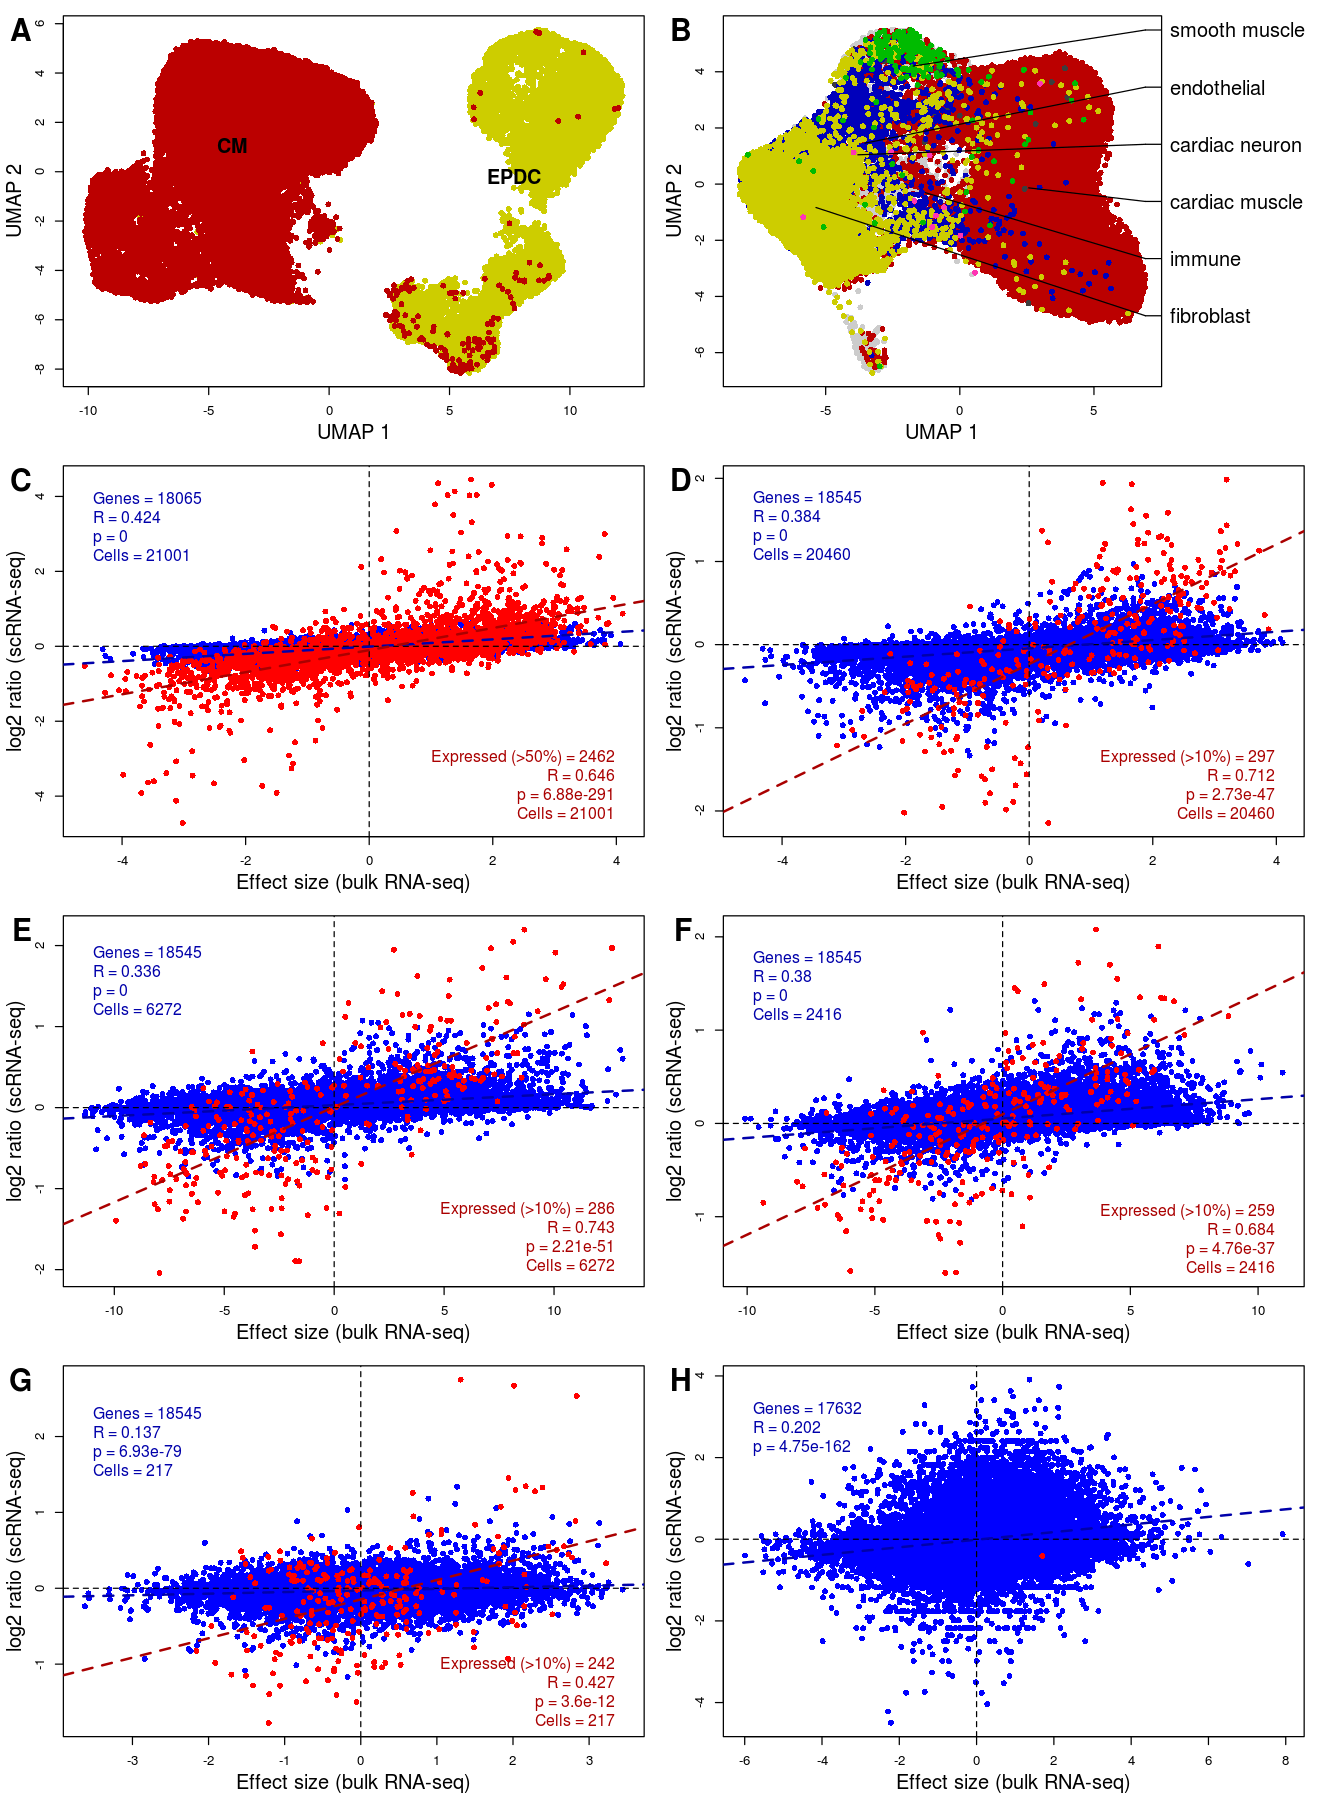

In [1940]:
figure_scrna1 = function(metadata, umap1, umap2, colordata, is_cat = TRUE, add_labels = FALSE, panel = "")
{
    metadata$cell_type = metadata$annot
    if(is_cat == TRUE)
    {
        metadata = merge(metadata, colordata)
        
        if(nrow(colordata[colordata$cell_type == "other cell types",]) > 0)
        {
            metadata = rbind(metadata[metadata$cell_type == "other cell types",],
                             metadata[metadata$cell_type != "other cell types",]
                            )
        }
        if(nrow(colordata[colordata$cell_type == "EPDC",]) > 0)
        {
            metadata = rbind(metadata[metadata$cell_type == "EPDC",],
                             metadata[metadata$cell_type == "CM"  ,]
                            )
        }
        
        name     = colnames(colordata)[[1]]
    }
    
    
    par(mar = c(4,4,1,1))
    plot(metadata[,umap1], metadata[,umap2], pch = 16, cex = 1, col = metadata$color, xlab = "", ylab = "")
    mtext(text = "UMAP 1", side = 1, line = 2.5)
    mtext(text = "UMAP 2", side = 2, line = 2.5)
    mtext(text = panel    , side = 2, line = 2  , at = max(metadata[, umap2]), font = 2, cex = 1.5, las = 2)
    
    if(add_labels == TRUE)
    {
        metadata = metadata[metadata$cell_type != "other cell types",]
        totext = aggregate(list(x = metadata[,umap1], y = metadata[,umap2]), by = list(cell = metadata$cell_type), FUN = mean)
        totext$color = "#000000"
        
        if(nrow(totext[totext$cell == "smooth_muscle", ]) > 0){totext[totext$cell == "smooth_muscle", "x"] = 0}
        
        #totext[!totext$cell %in% c("EPDC", "fibroblast", "smooth_muscle"), "color"] = "#ffffff"
        
        text(x = totext$x, y = totext$y, labels = gsub("_", " ", totext$cell), cex = 1.5, pos = 3, col = totext$color, font = 2)
    }
}

figure_scrna2 = function(metadata, umap1, umap2, colordata, is_cat = TRUE, add_labels = FALSE, panel = "")
{
    metadata$cell_type = metadata$annot
    if(is_cat == TRUE)
    {
        metadata = merge(metadata, colordata)
        
        if(nrow(colordata[colordata$cell_type == "other cell types",]) > 0)
        {
            metadata = rbind(metadata[metadata$cell_type == "other cell types",],
                             metadata[metadata$cell_type != "other cell types",]
                            )
        }
        if(nrow(colordata[colordata$cell_type == "EPDC",]) > 0)
        {
            metadata = rbind(metadata[metadata$cell_type == "EPDC",],
                             metadata[metadata$cell_type == "CM"  ,]
                            )
        }
        
        name     = colnames(colordata)[[1]]
    }
    
    
    par(mar = c(4,4,1,10))
    plot(metadata[,umap1], metadata[,umap2], pch = 16, cex = 1, col = metadata$color, xlab = "", ylab = "")
    mtext(text = "UMAP 1", side = 1, line = 2.5)
    mtext(text = "UMAP 2", side = 2, line = 2.5)
    mtext(text = panel    , side = 2, line = 2  , at = max(metadata[, umap2]), font = 2, cex = 1.5, las = 2)
    
    if(add_labels == TRUE)
    {
        metadata     = metadata[metadata$cell_type != "other cell types",]
        totext       = aggregate(list(x = metadata[,umap1], y = metadata[,umap2]), by = list(cell = metadata$cell_type), FUN = mean)
        totext$color = "#000000"
        totext       = totext[order(totext$y, decreasing = TRUE),]
        totext$cell  = gsub("_", " ", totext$cell)
        totext$y0    = (nrow(totext):1) / nrow(totext) * (max(metadata[, umap2]) - min(metadata[, umap2])) + min(metadata[, umap2])
        
        mtext(text = totext$cell, side = 4, line = 0.5, at = totext$y0, las = 2)
        
        segments(x0 = max(metadata[, umap1]), x1 = max(metadata[, umap1]) + 10, y0 = totext$y0)
        segments(x0 = max(metadata[, umap1]), x1 = totext$x                   , y0 = totext$y0, y1 = totext$y)
        
        
        #totext[!totext$cell %in% c("EPDC", "fibroblast", "smooth_muscle"), "color"] = "#ffffff"
        
        #mtext
        
        #text(x = totext$x, y = totext$y, labels = gsub("_", " ", totext$cell), cex = 1.5, pos = 3, col = totext$color, font = 2)
    }
}

figure_sm8_old = function()
{
    tovalid$color = "#aaaaaa"
    tovalid[tovalid$CM == "Y" & tovalid$cardiac_muscle_genes == "Y", "color"] = "#4876FF"
    tovalid[tovalid$CM == "Y" & tovalid$cardiac_muscle_genes == "N", "color"] = "#FF83FA"
    tovalid[tovalid$CM == "N" & tovalid$cardiac_muscle_genes == "Y", "color"] = cell2color_regular[cell2color_regular$cell_type == "regular.cardiac_muscle", "color"]
    
    par(mar = c(4,4,1,1))
    plot(tovalid$beta, tovalid$log2r, pch = 16, col = tovalid$color, xlab = "", ylab = "")
    abline(h = 0, lty = "dashed")
    abline(v = 0, lty = "dashed")
    abline(lm(log2r ~ beta, data = tovalid), lty = "dashed", lwd = 2, col = "#0000ff")
    
    mtext(text = "Effect size (bulk RNA-seq)"  , side = 1, line =  2.5)
    mtext(text = "log2 (CM / EPDC) (scRNA-seq)", side = 2, line =  2.5)
}

figure_validation = function(validation, metadata, stage, cell_type, frx = 0.1, write_cells = FALSE, panel = "")
{
    #validation = validation[validation$stag == stage & validation$cell_type == cell_type & (validation$fr1 >= 0.1 & validation$fr2 >= 0.1),]
    validation       = validation[validation$stage == stage & validation$cell_type == cell_type & is.na(validation$log2r) == FALSE & is.infinite(validation$log2r) == FALSE,]
    validation$color = "#0000ff"
    validation[validation$fr1 >= frx | validation$fr2 >= frx, "color"] = "#ff0000"
    
    validation          = rbind(validation[validation$color == "#0000ff",], validation[validation$color == "#ff0000",])
    validation_filtered = validation[validation$fr1 >= frx | validation$fr2 >= frx,]
    
    par(mar = c(4,4,1,1))
    plot(validation$beta, validation$log2r, col = validation$color, pch = 16, xlab = "", ylab = "")
    abline(h = 0, lty = "dashed")
    abline(v = 0, lty = "dashed")
    abline(lm(log2r ~ beta, data = validation         ), lty = "dashed", lwd = 2, col = "#0000aa")
    if(frx < 1){abline(lm(log2r ~ beta, data = validation_filtered), lty = "dashed", lwd = 2, col = "#aa0000")}
    
    mylabs1 = paste(paste("Genes", nrow(validation                                                       ), sep = " = "),
                    paste("R"    , signif(cor     (validation$beta, validation$log2r)        , digits = 3), sep = " = "),
                    paste("p"    , signif(cor.test(validation$beta, validation$log2r)$p.value, digits = 3), sep = " = "),
                    paste("Cells", nrow(metadata[metadata$ident.cell == cell_type,]                      ), sep = " = "),
                    sep = "\n"
                   )
    
    if(frx < 1){mylabs2 = paste(paste(paste("Expressed (>", frx * 100, "%)", sep = ""), nrow(validation_filtered                                                                ), sep = " = "),
                          paste("R"    , signif(cor     (validation_filtered$beta, validation_filtered$log2r)        , digits = 3), sep = " = "),
                          paste("p"    , signif(cor.test(validation_filtered$beta, validation_filtered$log2r)$p.value, digits = 3), sep = " = "),
                          paste("Cells", nrow(metadata[metadata$ident.cell == cell_type,]                                        ), sep = " = "),
                          sep = "\n"
                         )}
    
    
    
    if(write_cells == FALSE)
    {
        mylabs1 = paste(paste("Genes" , nrow(validation                                                       ), sep = " = "),
                        paste("R"     , signif(cor     (validation$beta, validation$log2r)        , digits = 3), sep = " = "),
                        paste("p"     , signif(cor.test(validation$beta, validation$log2r)$p.value, digits = 3), sep = " = "),
                        sep = "\n"
                       )
        if(frx < 1){mylabs2 = paste(paste(paste("Expressed (>", frx * 100, "%)", sep = ""), nrow(validation_filtered                                                                ), sep = " = "),
                              paste("R"                                             , signif(cor     (validation_filtered$beta, validation_filtered$log2r)        , digits = 3), sep = " = "),
                              paste("p"                                             , signif(cor.test(validation_filtered$beta, validation_filtered$log2r)$p.value, digits = 3), sep = " = "),
                              sep = "\n"
                             )}
    }
    
    
    mtext(text = "Effect size (bulk RNA-seq)", side = 1, line =  2.5)
    mtext(text = "log2 ratio (scRNA-seq)"    , side = 2, line =  2.5)
    text (x      = min(validation$beta) , y = max(validation$log2r) * 0.65, labels = mylabs1, cex = 1.2, pos = 4, col = "#0000aa")
    if(frx < 1){text (x      = max(validation$beta) , y = min(validation$log2r) * 0.85, labels = mylabs2, cex = 1.2, pos = 2, col = "#aa0000")}
    mtext(text = panel    , side = 2, line = 2  , at = max(validation$log2r), font = 2, cex = 1.5, las = 2)
    
}

figure_s13 = function()
{
    #layout(rbind(c(1,1,1,2,2,2), c(3,3,4,4,5,5), c(6,6,7,7,8,8)))
    layout(matrix(1:8, nrow = 4, byrow = TRUE))
    
    cell2color = cell2color_regular
    cell2color$cell_type = gsub("regular\\.", "", cell2color$cell_type)
    cell2color           = rbind(data.frame(cell_type = "other cell types", color = "#cccccc"), cell2color)
    
    cvpc2color = cell2color[cell2color$cell_type %in% c("cardiac_muscle", "fibroblast"),]
    cvpc2color = data.frame(cell_type = c("CM", "EPDC"), color = c(cell2color[cell2color$cell_type == "cardiac_muscle", "color"],
                                                                   cell2color[cell2color$cell_type == "fibroblast"    , "color"]))
    
    valid_cvpc_scrna$annot = valid_cvpc_scrna$ident.cell
    
    figure_scrna1(valid_cvpc_scrna , "umap1", "umap2", cvpc2color, TRUE, TRUE, "A")
    figure_scrna2(valid_adult_scrna, "umap1", "umap2", cell2color, TRUE, TRUE, "B")
    
    figure_validation(validation , valid_cvpc_scrna , "ipsc_cvpc", "CM"            , 0.5, TRUE , "C")
    figure_validation(validation , valid_adult_scrna, "adult"    , "cardiac_muscle", 0.1, TRUE , "D")
    figure_validation(validation , valid_adult_scrna, "adult"    , "fibroblast"    , 0.1, TRUE , "E")
    figure_validation(validation , valid_adult_scrna, "adult"    , "endothelial"   , 0.1, TRUE , "F")
    figure_validation(validation , valid_adult_scrna, "adult"    , "smooth_muscle" , 0.1, TRUE , "G")
    figure_validation(valid_stage, valid_adult_scrna, "adult"    , "cardiac_muscle", 1  , FALSE, "H")
}

png(filename = "manuscript/cardiac_differential_expression/figure_S13.png", width = 11, height = 15, units = "in", res = 300)
figure_s13()
dev.off()

options(repr.plot.width = 11, repr.plot.height = 15)
figure_s13()



## RBPs

In [921]:
rbp2cell = difcell[ difcell$gene_name %in% rbps & difcell$beta > 0 & difcell$qval <= 0.05,]

message(paste("RBPs tested"                   , length(rbps), sep = " = "))
message(paste("RBPs associated with cell type", paste(length(unique(rbp2cell$gene_name)), 
                                                      " (", 
                                                      signif(length(unique(rbp2cell$gene_name)) / length(rbps) * 100, digits = 3),
                                                      "%)",
                                                      sep = ""
                                                     ), sep = " = "))

table(rbp2cell$cell_type)


#difcell[difcell$gene_name == "PTBP1",]

#rbp2cell[order(rbp2cell$pval),]

RBPs tested = 122

RBPs associated with cell type = 92 (75.4%)




cibersort.regular.cardiac_muscle cibersort.regular.cardiac_neuron 
                              25                               22 
   cibersort.regular.endocardial    cibersort.regular.endothelial 
                              27                               29 
    cibersort.regular.fibroblast         cibersort.regular.immune 
                              42                                9 
 cibersort.regular.myofibroblast  cibersort.regular.smooth_muscle 
                              18                               14 

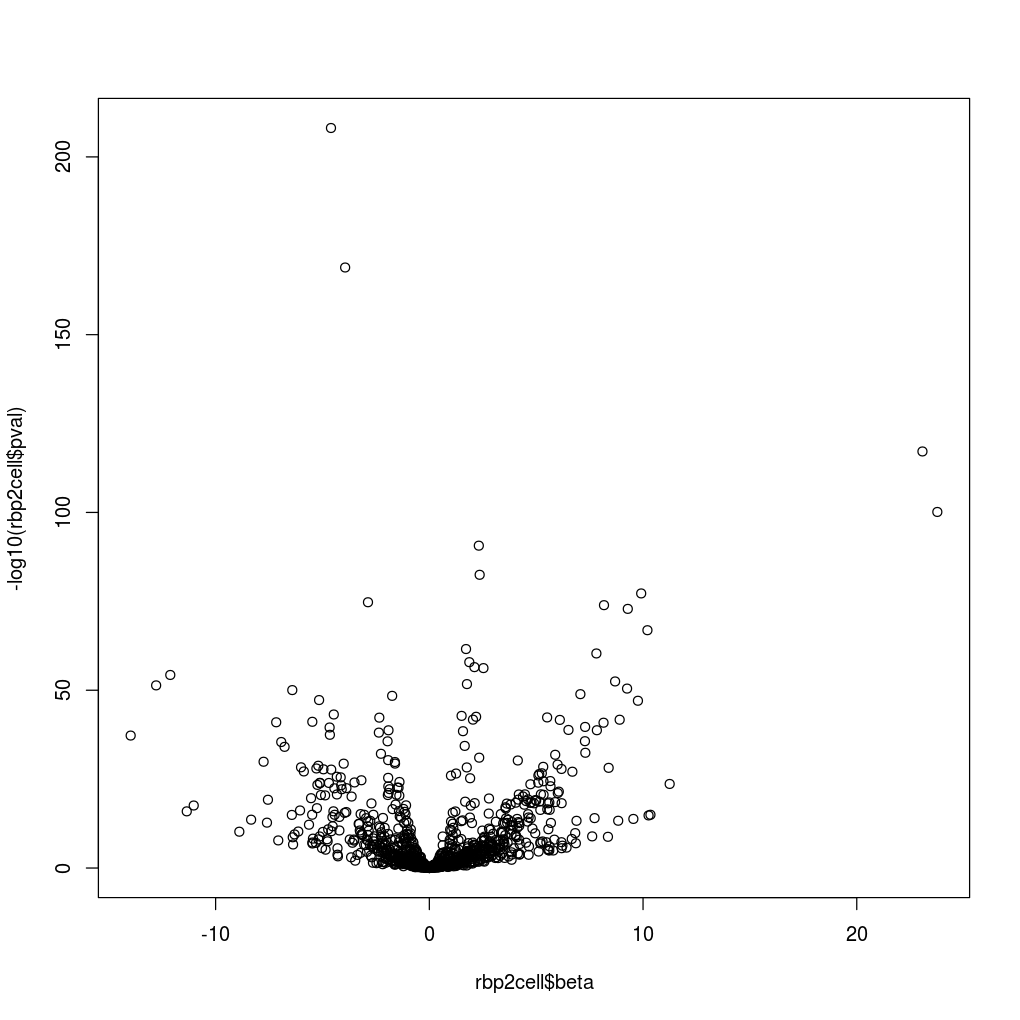

In [435]:
plot(rbp2cell$beta, -log10(rbp2cell$pval))

In [562]:
cell2iso                = difcell_iso
cellspec                = aggregate(qval ~ transcript_id + cell_type, data = cell2iso[cell2iso$qval <= 0.05 & cell2iso$beta > 0,], FUN = function(x){x[[1]]})
cell2table              = table(cellspec$transcript_id)
cellspec$association    = "cell type-associated"

cellspec[cellspec$transcript_id %in% names(cell2table[cell2table == 1]), "association"] = "cell type-specific"

cellspec$qval = NULL
cell2iso      = merge(cell2iso, cellspec, by = c("cell_type", "transcript_id"), all.x = TRUE)

cell2iso[is.na(cell2iso$association) == TRUE, "association"] = ""


In [563]:

message(paste("Cell type-associated isoforms (q < 0.05 and beta > 0)", length(unique(cell2iso[cell2iso$association == "cell type-associated", "transcript_id"])), sep = " = "))
message(paste("Cell type-specific isoforms (q < 0.05 and beta > 0)"  , length(unique(cell2iso[cell2iso$association == "cell type-specific"  , "transcript_id"])), sep = " = "))

table(cell2iso[cell2iso$association != "",c("cell_type", "association")])


Cell type-associated isoforms (q < 0.05 and beta > 0) = 2091

Cell type-specific isoforms (q < 0.05 and beta > 0) = 6843



                                  association
cell_type                          cell type-associated cell type-specific
  cibersort.regular.cardiac_muscle                   20               2973
  cibersort.regular.cardiac_neuron                  756                252
  cibersort.regular.endocardial                    1583                439
  cibersort.regular.endothelial                     758                108
  cibersort.regular.fibroblast                     1483               2208
  cibersort.regular.immune                          364                376
  cibersort.regular.myofibroblast                   268                 17
  cibersort.regular.smooth_muscle                   197                470

png 
  2

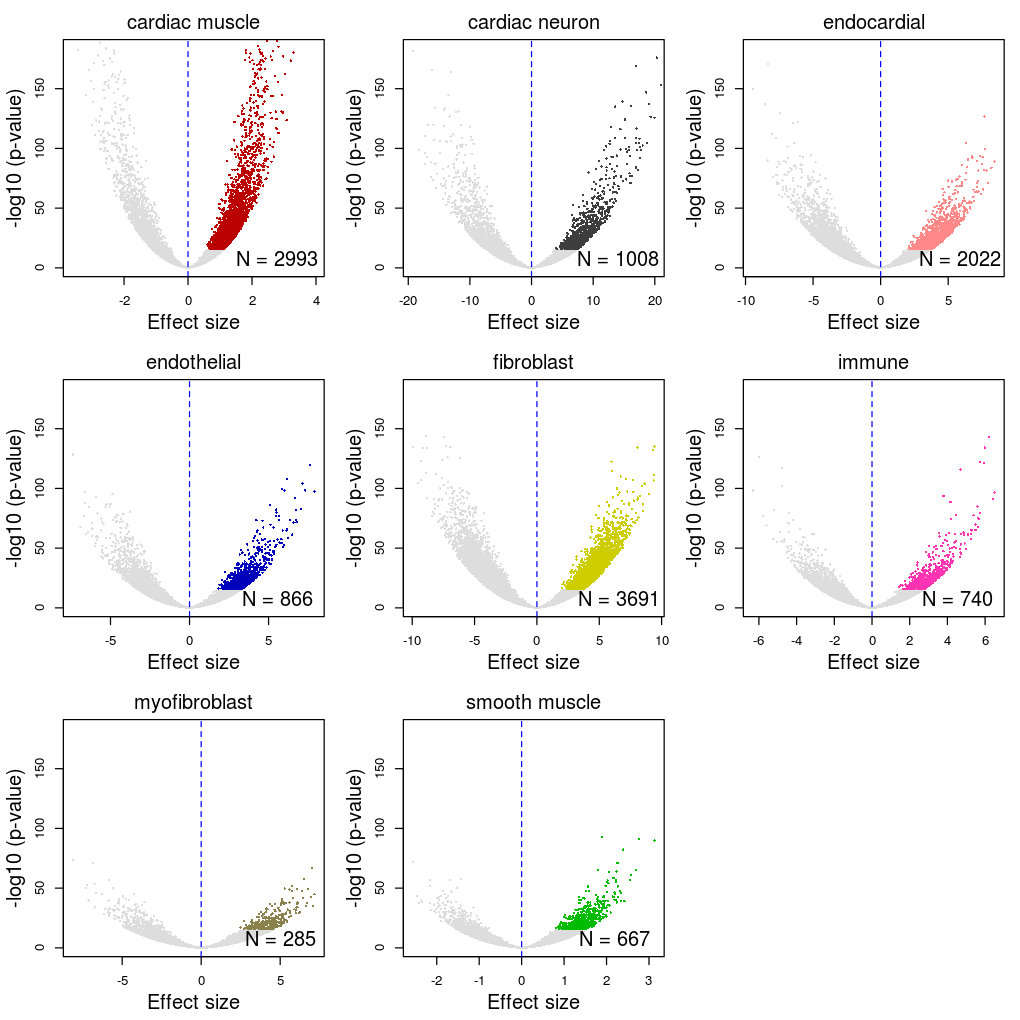

In [1861]:
volcano_plot_cell = function(x, tissue, panel = "")
{
    alldata = x
    ylims   = max(-log10(x$pval))
    x       = x[x$cell_type == tissue,]
    xlims   = range(x[x$beta >= -20 & x$beta <= 20, "beta"])
    mycol   = cell2color_regular[cell2color_regular$cell_type == gsub("cibersort\\.", "", tissue), "color"]
    x$color = "#dddddd"
    x$cex   = 0.4
    
    x[x$qval <= 0.05 & x$beta > 0 &  x$transcript_id %in% alldata[alldata$cell_type != tissue & alldata$qval <= 0.05 & alldata$beta > 0 , "transcript_id"], "color"] = "#999999"
    x[x$qval <= 0.05 & x$beta > 0 &  x$transcript_id %in% alldata[alldata$cell_type != tissue & alldata$qval <= 0.05 & alldata$beta > 0 , "transcript_id"], "color"] = mycol
    x[x$qval <= 0.05 & x$beta > 0 & !x$transcript_id %in% alldata[alldata$cell_type != tissue & alldata$qval <= 0.05 & alldata$beta > 0 , "transcript_id"], "color"] = mycol 
    
    if(tissue != "cibersort.regular.cardiac_muscle"){x = rbind(x[x$color == "#dddddd",], x[x$color == "#999999",], x[x$color == mycol    ,])}
    if(tissue == "cibersort.regular.cardiac_muscle"){x = rbind(x[x$color == "#dddddd",], x[x$color == mycol    ,], x[x$color == "#999999",])}
    
    par(mar = c(4,4,2.5,1))
    plot(x$beta, -log(x$pval), col = x$color, cex = x$cex, pch = 16, xlim = xlims, ylim = c(0, ylims), xlab = "", ylab = "")
    
    abline(v = 0, col = "#0000ff", lty = "dashed")
    
    mtext(text = "Effect size"                                                     , side = 1, line =  2.5)
    mtext(text = "-log10 (p-value)"                                                , side = 2, line =  2.5)
    mtext(text = gsub("_", " ", gsub("cibersort.regular\\.", "", tissue))          , side = 3, line =  0.5)
    mtext(text = panel                                                             , side = 2, line =  2  , at = ylims * 1.1, font = 2, cex = 1.5, las = 2)
    mtext(text = paste("N", nrow(x[x$qval <= 0.05 & x$beta > 0, ]), sep = " = ")   , side = 1, line = -1.5, at = max(x[x$beta > 0 & x$beta <  20, "beta"]) * 0.7)
}

figure_s13 = function()
{
    layout(matrix(1:9, nrow = 3, byrow = TRUE))
    
    invisible(lapply(sort(unique(difcell_iso$cell_type)), function(cell){volcano_plot_cell(difcell_iso, cell)}))
}

png(filename = "manuscript/cardiac_differential_expression/figure_S13.png", width = 8.5, height = 8.5, units = "in", res = 300)
figure_s13()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 8.5)
figure_s13()

## Table S13-14: Associations between cell type proportion and expression; and functional enrichment analysis

In [1870]:

table_s13 = rbind(difcell    [,c("type", "transcript_id", "gene_id", "gene_name", "cell_type", "beta", "se", "pval", "qval")],
                  difcell_iso[,c("type", "transcript_id", "gene_id", "gene_name", "cell_type", "beta", "se", "pval", "qval")]
                 )

cellspec_t15                = aggregate(qval ~ transcript_id + cell_type, data = table_s13[table_s13$qval <= 0.05 & table_s13$beta > 0,], FUN = function(x){x[[1]]})
cell2table_t15              = table(cellspec_t15$transcript_id)
cellspec_t15$association    = "cell type-associated"

cellspec_t15[cellspec_t15$transcript_id %in% names(cell2table_t15[cell2table_t15 == 1]), "association"] = "cell type-specific"

cellspec_t15$qval = NULL
table_s13         = merge(table_s13, cellspec_t15, by = c("cell_type", "transcript_id"), all.x = TRUE)

table_s13[is.na(table_s13$association) == TRUE, "association"] = ""

table_s13$diffexp    = FALSE
table_s13$specific   = FALSE

table_s13[table_s13$association == "cell type-specific", "specific"] = TRUE

table_s13[table_s13$qval <= 0.05 & table_s14$beta > 0, "diffexp"] = TRUE

table_s13$association = NULL

table_s13[table_s13$type == "gene_tpm", "transcript_id"] = ""

table_s13$type      = suppressMessages(mapvalues(table_s13$type, 
                                                 from = c("gene_tpm", "isoform_use"), 
                                                 to   = c("Gene"    , "Isoform"    )))


table_s13[table_s13$qval <= 0.05 & table_s13$beta > 0, "diffexp"] = TRUE

table_s13$cell_type = gsub("_", " ", gsub("cibersort.regular.", "", table_s13$cell_type))
table_s13           = table_s13[,c("type", "transcript_id", "gene_id", "gene_name", "cell_type", "beta", "se", "pval", "qval", "diffexp")]
colnames(table_s13) = c("Type (isoform or gene)", "Isoform ID", "Gene ID", "Gene name", "Cell type", "Effect size (beta)", "Standard error of beta", "P-value", "FDR (Bonferroni)", "Associated with cell type")

table_s13_small = table_s13[table_s13[,"Associated with cell type"] == TRUE ,]
table_s13_big   = table_s13


fwrite(table_s13_small, "manuscript/cardiac_differential_expression/table_s13.csv"         , sep = ",", col.names = TRUE, row.names = FALSE)
fwrite(table_s13_big  , "manuscript/cardiac_differential_expression/table_s13_complete.csv", sep = ",", col.names = TRUE, row.names = FALSE)


In [1873]:
table_s14           = enrcell[enrcell$type == "gene_tpm", c("cell_type", "gs_source", "gene_set", "url", "ngenes", "ttest_estimate_in", "ttest_estimate_out", "ttest_pval", "ttest_fdr")]
table_s14$cell_type = gsub("_", " ", gsub("cibersort.regular.", "", table_s14$cell_type))
colnames(table_s14) = c("Cell type", "Gene set collection", "Gene set", "Gene set URL", "Genes in gene set (N)", "Mean effect size in", "Mean effect size out", "P-value", "FDR (Benjamini-Hochberg)")

table_s14_small = table_s14[table_s14[,"FDR (Benjamini-Hochberg)"] <= 0.05 ,]
table_s14_big   = table_s14


fwrite(table_s14_small, "manuscript/cardiac_differential_expression/table_s14.csv"         , sep = ",", col.names = TRUE, row.names = FALSE)
fwrite(table_s14_big  , "manuscript/cardiac_differential_expression/table_s14_complete.csv", sep = ",", col.names = TRUE, row.names = FALSE)


## Table S15: comparison between linear model and ridge regression

In [1875]:
table_s15           = merge(diffexp_lm, diffexp_ridge, by = c("transcript_id", "gene_id", "gene_name", "gene_type", "tissue1", "tissue2", "type"), suffixes = c("_lm", "_ridge"))
table_s15           = table_s15[, c("type", "transcript_id", "gene_id", "gene_name", "tissue1", "tissue2", "beta_lm", "se_lm", "pval_lm", "qval_lm", "covariate", "beta_ridge", "se_ridge", "pval_ridge", "qval_ridge")]

table_s15[table_s15$type == "gene_tpm", "transcript_id"] = ""

table_s15           = table_s15[table_s15$covariate %in% c("tissue", paste("cibersort", cell2color_regular$cell_type, sep = ".")),]
table_s15$covariate = gsub("_", " ", gsub("cibersort.regular.", "", table_s15$covariate))
table_s15$type      = suppressMessages(mapvalues(table_s15$type, 
                                                 from = c("gene_tpm", "isoform_use"), 
                                                 to   = c("Gene"    , "Isoform"    )))

colnames(table_s15)       = c("Type (isoform or gene)", "Isoform ID", "Gene ID", "Gene name", "Tissue 1", "Tissue 2", "Effect size (LM)", "Standard error of beta (LM)", "P-value (LM)", "FDR (Bonferroni, LM)", "Covariate", "Effect size (ridge)", "Standard error of beta (ridge)", "P-value (ridge)", "FDR (Bonferroni, ridge)")
table_s15                 = unique(table_s15[,grepl("LM)$", colnames(table_s15)) == FALSE])
#table_s15_small           = table_s15[table_s15[,"Covariate"] == "tissue" & table_s15[,"FDR (Bonferroni, ridge)"] <= 0.05,]
#table_s15_small$covariate = NULL
table_s15_small           = table_s15[table_s15[,"FDR (Bonferroni, ridge)"] <= 0.05,]
table_s15_big             = table_s15

fwrite(table_s15_big   , "manuscript/cardiac_differential_expression/table_s15_complete.csv", sep = ",", col.names = TRUE, row.names = FALSE)
fwrite(table_s15_small , "manuscript/cardiac_differential_expression/table_s15.csv"         , sep = ",", col.names = TRUE, row.names = FALSE)



## Figure 4

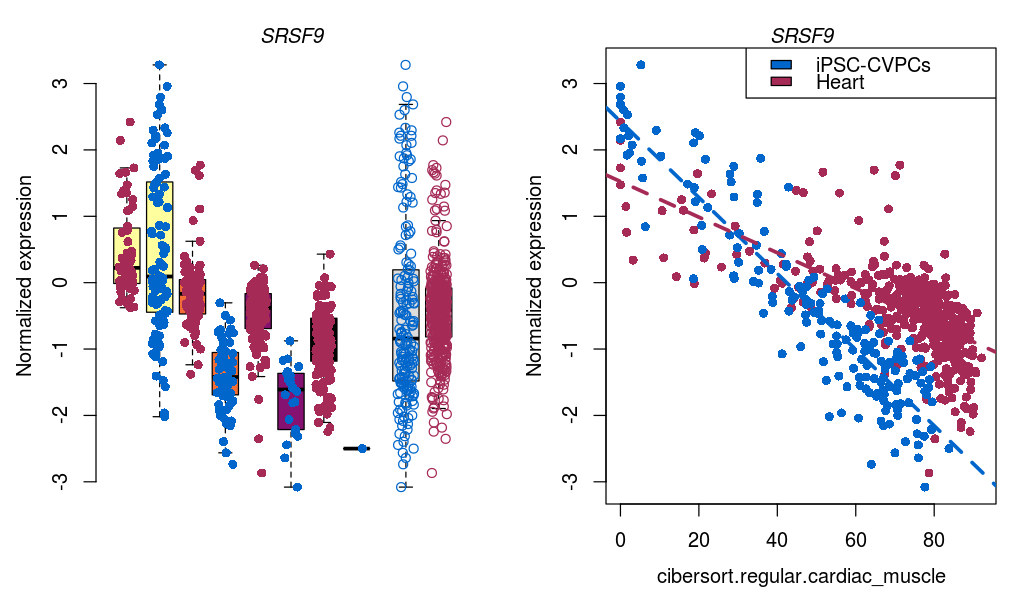

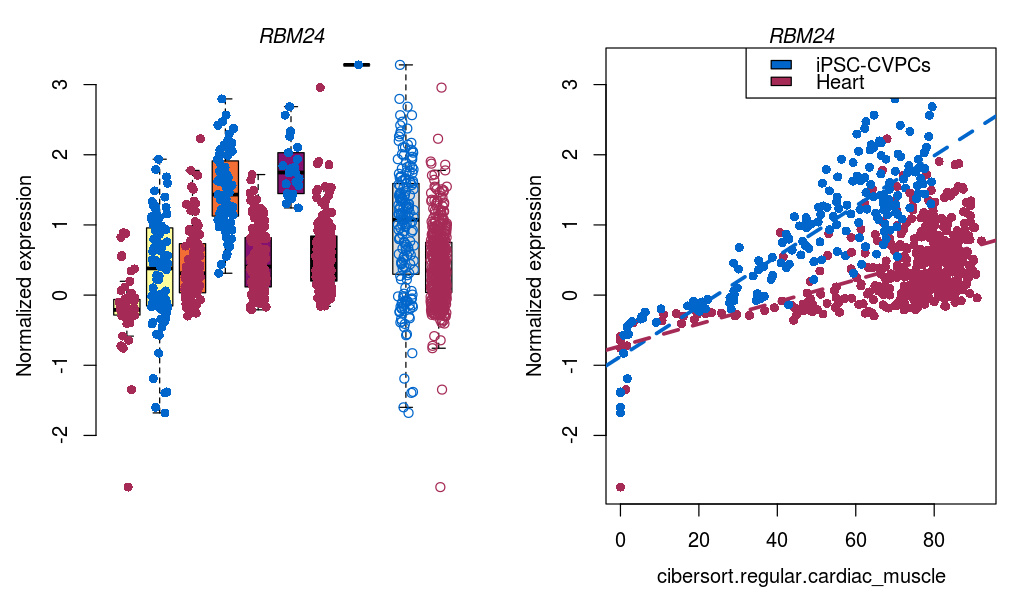

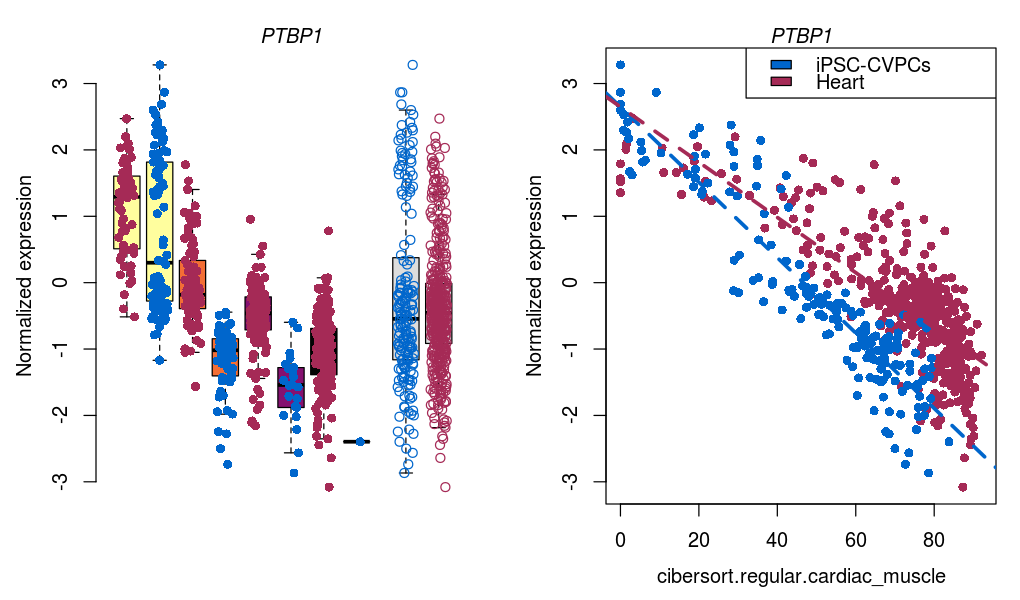

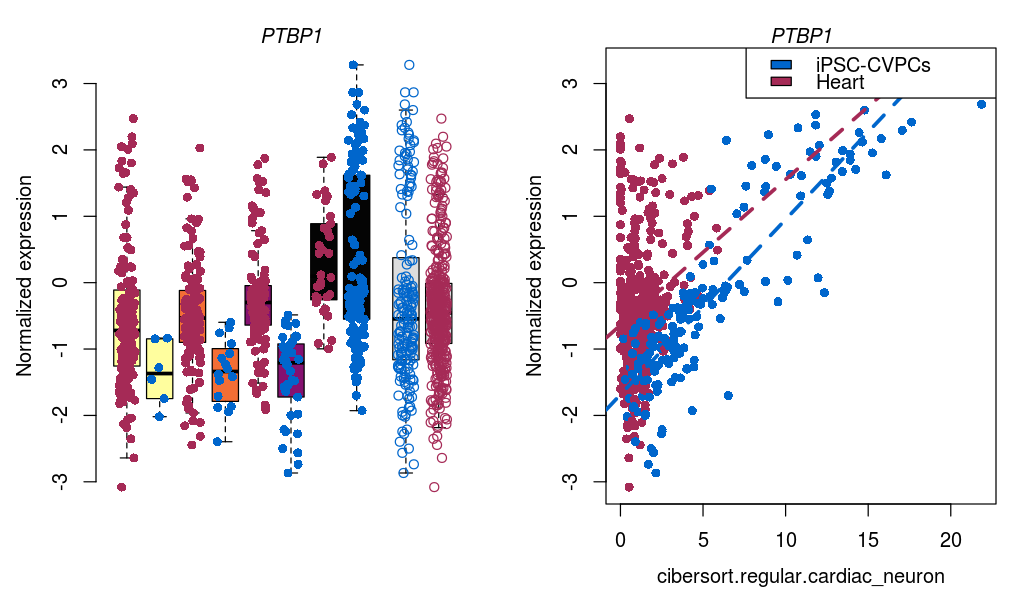

In [1031]:
plot_stage_vs_cell = function(transcript_id, cell, tissue1, tissue2, geneinfo, tpm, covariates)
{
    gene_name              = geneinfo[geneinfo$transcript_id == transcript_id, "gene_name"]
    color                  = cell2color_regular[ cell2color_regular$cell_type == sub("cibersort\\.", "", cell), "color"]
    expdata                = data.frame(assay_id = colnames(tpm), exp = as.numeric(tpm[transcript_id,]))
    expdata                = merge(expdata, metadata  [metadata$tissue %in% c(tissue1, tissue2),c("run", "study", "tissue")], by.x = "assay_id", by.y = "run")
    expdata                = merge(expdata, covariates[,c("run", cell)], by.x = "assay_id", by.y = "run")
    expdata$cell           = expdata[,cell] * 100
    expdata                = expdata[order(expdata$cell),]
    expdata$quartile       = 0
    expdata[                                         1 :round(nrow(expdata)*1/4, digits = 0), "quartile"] = 1
    expdata[( round(nrow(expdata)*1/4, digits = 0) + 1):round(nrow(expdata)*2/4, digits = 0), "quartile"] = 2
    expdata[( round(nrow(expdata)*2/4, digits = 0) + 1):round(nrow(expdata)*3/4, digits = 0), "quartile"] = 3
    expdata[( round(nrow(expdata)*3/4, digits = 0) + 1):      nrow(expdata)                 , "quartile"] = 4
    
    tissue2q1      = data.frame(quartile = 4:1, color_q = sequential_hcl(n = 4, palette = "Inferno"))
    tissue2q2      = data.frame(tissue = c(rep(tissue1, 4), rep(tissue2, 4)), quartile = c(1:4, 1:4))
    tissue2q       = merge(tissue2q1, tissue2q2)
    tissue2q       = tissue2q[order(tissue2q$quartile, tissue2q$tissue),]
    tissue2q$order = 1:nrow(tissue2q)
    
    expdata = merge(expdata, tissue2q, by = c("tissue", "quartile"))
    expdata = merge(expdata, tissue2color3[,c("tissue", "color"   )])
    expdata = expdata[order(expdata$order),]
    
    expdata$x       = jitter(expdata$order, amount = 0.25)
    expdata$tissue2 = nrow(tissue2q) +1.5
    expdata[expdata$tissue == tissue2, "tissue2"] = nrow(tissue2q) +2.5
    
    expdata$x2 = jitter(expdata$tissue2, amount = 0.25)
    
    par(mar = c(4,4,2,1))
    plot(1,1, type = "n", xlim = c(0.5, max(tissue2q$order) + 0.5 + 3), ylim = range(expdata$exp), xlab = "", ylab = "", axes = FALSE)
    axis(2)
    
    mtext(text = "Normalized expression", side = 2, line = 2.5)
    mtext(text = gene_name              , side = 3, line = 0  , font = 3)
    
    
    boxplot(exp ~ order, data = expdata, add = TRUE, at = tissue2q$order, outline = FALSE, axes = FALSE, col = tissue2q$color_q)
    points (expdata$x, expdata$exp, col = expdata$color, pch = 16)
    
    boxplot(exp ~ tissue2, data = expdata, add = TRUE, at = nrow(tissue2q) +c(1.5, 2.5), outline = FALSE, axes = FALSE, col = "#dddddd")
    points (expdata$x2, expdata$exp, col = expdata$color, pch = 21)
    
    plot(1,1, type = "n", xlim = range(expdata$cell), ylim = range(expdata$exp), xlab = "", ylab = "", axes = TRUE)
    points (expdata$cell, expdata$exp, col = expdata$color, pch = 16)
    
    mtext(text = cell                   , side = 1, line = 2.5)
    mtext(text = "Normalized expression", side = 2, line = 2.5)
    mtext(text = gene_name              , side = 3, line = 0  , font = 3)
    
    for(tissue in c(tissue1, tissue2))
    {
        this = expdata[expdata$tissue == tissue,]
        
        abline(lm(exp ~ cell, data = this), col = tissue2color3[tissue, "color"], lwd = 3, lty = "dashed")
    }
    
    legend("topright", legend = tissue2color3[c(tissue1, tissue2), "body_site"], fill = tissue2color3[c(tissue1, tissue2), "color"])
    
}

options(repr.plot.width = 8.5, repr.plot.height = 5)
layout(rbind(1:2))

plot_stage_vs_cell(geneinfo_genes[geneinfo_genes$gene_name == "SRSF9", "transcript_id"], "cibersort.regular.cardiac_muscle", "ipsc_cvpc", "heart", geneinfo_genes, gene_tpm, covariates)
plot_stage_vs_cell(geneinfo_genes[geneinfo_genes$gene_name == "RBM24", "transcript_id"], "cibersort.regular.cardiac_muscle", "ipsc_cvpc", "heart", geneinfo_genes, gene_tpm, covariates)
plot_stage_vs_cell(geneinfo_genes[geneinfo_genes$gene_name == "PTBP1", "transcript_id"], "cibersort.regular.cardiac_muscle", "ipsc_cvpc", "heart", geneinfo_genes, gene_tpm, covariates)
plot_stage_vs_cell(geneinfo_genes[geneinfo_genes$gene_name == "PTBP1", "transcript_id"], "cibersort.regular.cardiac_neuron", "ipsc_cvpc", "heart", geneinfo_genes, gene_tpm, covariates)
#plot_stage_vs_cell(geneinfo_genes[geneinfo_genes$gene_name == "CPEB1", "transcript_id"], "cibersort.regular.fibroblast", "ipsc_cvpc", "heart", geneinfo_genes, gene_tpm, covariates)
#plot_stage_vs_cell("ENST00000278070.7_3", "cibersort.regular.cardiac_muscle", "ipsc_cvpc", "heart", geneinfo_isoforms, isof_use, covariates)
#plot_stage_vs_cell("ENST00000587424.2_1", "cibersort.regular.cardiac_muscle", "ipsc_cvpc", "heart", geneinfo_isoforms, isof_use, covariates)


gene_tpm ipsc_cvpc heart 5919 6505 90.9915449654112

gene_tpm ipsc_cvpc arteria 3429 5818 58.9377793056033

gene_tpm heart arteria 218 3358 6.4919594997022



png 
  2

gene_tpm ipsc_cvpc heart 5919 6505 90.9915449654112

gene_tpm ipsc_cvpc arteria 3429 5818 58.9377793056033

gene_tpm heart arteria 218 3358 6.4919594997022



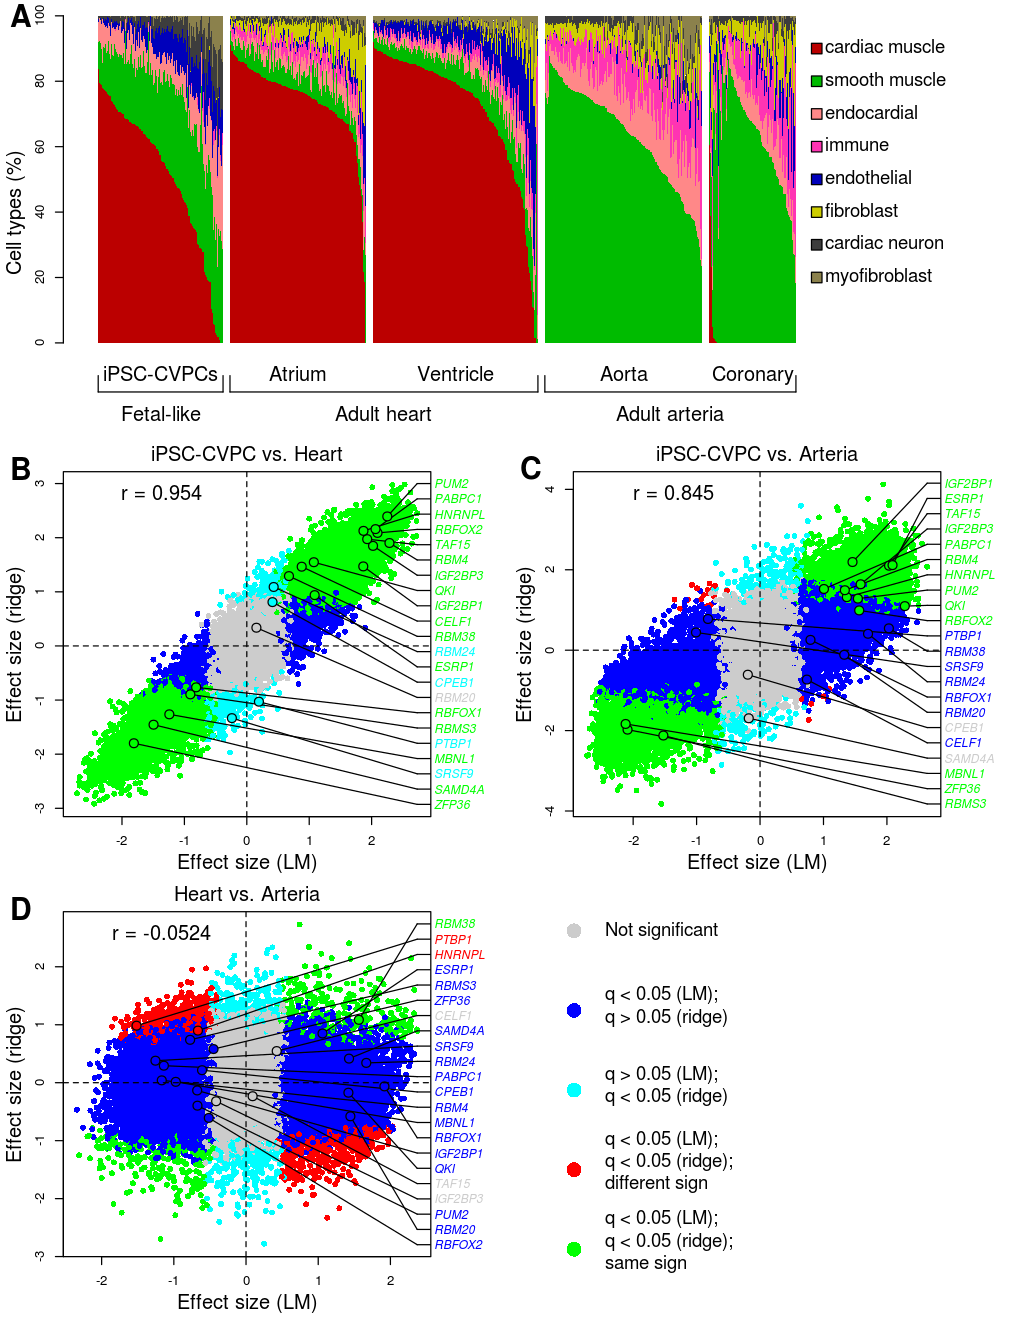

In [1921]:
figure_4a = function(cibersort, metadata, cluster2color, panel = "")
{
    #cibersort               = cibersort[,order(colnames(cibersort))]
    indata                  = merge(metadata[, c("run", "assay_id", "body_site")], cibersort, by.x = "run", by.y = "row.names")
    rownames(cluster2color) = cluster2color$cell_type
    cluster2color           = cluster2color[colnames(cibersort),]

    ipsc_cvpc = indata[indata$body_site == "ipsc_cvpc"       ,]
    aorta     = indata[indata$body_site == "arteria_aorta"   ,]
    coronary  = indata[indata$body_site == "arteria_coronary",]
    atrium    = indata[indata$body_site == "heart_atrium"    ,]
    ventricle = indata[indata$body_site == "heart_ventricle" ,]
    
    ipsc_cvpc = ipsc_cvpc[order(ipsc_cvpc[,colnames(cibersort)[[1]]], ipsc_cvpc[,colnames(cibersort)[[2]]], decreasing = TRUE),]
    atrium    = atrium   [order(atrium   [,colnames(cibersort)[[1]]], atrium   [,colnames(cibersort)[[2]]], decreasing = TRUE),]
    ventricle = ventricle[order(ventricle[,colnames(cibersort)[[1]]], ventricle[,colnames(cibersort)[[2]]], decreasing = TRUE),]
    aorta     = aorta    [order(aorta    [,colnames(cibersort)[[1]]], aorta    [,colnames(cibersort)[[2]]], decreasing = TRUE),]
    coronary  = coronary [order(coronary [,colnames(cibersort)[[1]]], coronary [,colnames(cibersort)[[2]]], decreasing = TRUE),]
    
    par(mar = c(2,4,1,1))
    #plot(1,1, type = "n", xlim = c(0, nrow(indata) + 50), ylim = c(0,100), xlab = "", ylab = "", axes = FALSE)
    #axis(2)
    
    my_spaces        = c(rep(0, nrow(ipsc_cvpc)), 10, rep(0, nrow(atrium) -1 ), 10, rep(0, nrow(ventricle) -1 ), 10, rep(0, nrow(aorta) -1 ), 10, rep(0, nrow(coronary) -1 ))
    toplot           = rbind(ipsc_cvpc, atrium, ventricle, aorta, coronary)
    rownames(toplot) = NULL
    cluster2cell     = cluster2color
    #cluster2cell = data.frame(cluster = colnames(cibersort), color = qualitative_hcl(palette = "Set 2", n = ncol(cibersort)))
    
    barplot(t(as.matrix(toplot[, cluster2cell[,1]])) * 100, col = cluster2cell$color, width = 1, border = NA, space = my_spaces, xlim = c(0, nrow(toplot) + sum(my_spaces) + 250), ylim = c(-20,100), axes = FALSE)
    axis(2, at = (0:5) * 20)
    
    mtext(text = "Cell types (%)", side = 2, line = 2.5)
    mtext(text = panel           , side = 2, line = 2  , at = 100, font = 2, cex = 1.5, las = 2)

    mtext(text = "iPSC-CVPCs"    , side = 1, line = -2.5, at = nrow(ipsc_cvpc) / 2)
    mtext(text = "Atrium"        , side = 1, line = -2.5, at = nrow(atrium   ) / 2 + 10 + nrow(ipsc_cvpc))
    mtext(text = "Ventricle"     , side = 1, line = -2.5, at = nrow(ventricle) / 2 + 20 + nrow(ipsc_cvpc) + nrow(atrium))
    mtext(text = "Aorta"         , side = 1, line = -2.5, at = nrow(aorta    ) / 2 + 30 + nrow(ipsc_cvpc) + nrow(atrium) + nrow(ventricle))
    mtext(text = "Coronary"      , side = 1, line = -2.5, at = nrow(coronary ) / 2 + 40 + nrow(ipsc_cvpc) + nrow(atrium) + nrow(ventricle) + nrow(aorta))

    mtext(text = "Fetal-like"    , side = 1, line =  0  , at =  nrow(ipsc_cvpc) / 2)
    mtext(text = "Adult heart"   , side = 1, line =  0  , at = (nrow(atrium   ) + nrow(ventricle) + 10)/ 2 + 10 + nrow(ipsc_cvpc))
    mtext(text = "Adult arteria" , side = 1, line =  0  , at = (nrow(aorta    ) + nrow(coronary ) + 10)/ 2 + 30 + nrow(ipsc_cvpc) + nrow(atrium) + nrow(ventricle))
    
    toseg = c(0, nrow(ipsc_cvpc), 10 + nrow(ipsc_cvpc), 20 + nrow(ipsc_cvpc) + nrow(atrium) + nrow(ventricle), 30 + nrow(ipsc_cvpc) + nrow(atrium) + nrow(ventricle), 40 + nrow(ipsc_cvpc) + nrow(atrium) + nrow(ventricle) + nrow(aorta    ) + nrow(coronary ))
    segments(x0 = toseg, y0 = -10, y1 = -15)
    
    segments(x0 = toseg[c(1,3,5)], x1 = toseg[c(2,4,6)], y0 = -15)
    
    cluster2cell$y = 100 - seq(from = 10, to = 100, by = min(10, 100 / (1+nrow(cluster2cell))))[1:nrow(cluster2cell)]
    
    points(x = rep(nrow(toplot) + 70, nrow(cluster2cell)), y = cluster2cell$y, cex = 2  , pch = 22, bg = cluster2cell$color)
    text  (x = rep(nrow(toplot) + 70, nrow(cluster2cell)), y = cluster2cell$y, cex = 1.4, labels = gsub("regular.", "", gsub("combined.", "", gsub("_", " ", cluster2cell[,1]))), pos = 4)
}

plot_diffexp_vs = function(type, tissue1, tissue2, diffexp, genes = c(), show = FALSE, panel = "")
{
    diffexp       = diffexp[ diffexp$type == type & diffexp$tissue1 == tissue1 & diffexp$tissue2 == tissue2, ]
    diffexp$color = "#cccccc"
    
    diffexp[ diffexp$diffexp_lm == TRUE  & diffexp$diffexp_ridge == TRUE  & sign(diffexp$beta_lm) == sign(diffexp$beta_ridge), "color"] = "#00ff00"
    diffexp[ diffexp$diffexp_lm == TRUE  & diffexp$diffexp_ridge == TRUE  & sign(diffexp$beta_lm) != sign(diffexp$beta_ridge), "color"] = "#ff0000"
    diffexp[ diffexp$diffexp_lm == TRUE  & diffexp$diffexp_ridge == FALSE, "color"] = "#0000ff"
    diffexp[ diffexp$diffexp_lm == FALSE & diffexp$diffexp_ridge == TRUE , "color"] = "#00ffff"
    diffexp[ diffexp$diffexp_lm == FALSE & diffexp$diffexp_ridge == FALSE, "color"] = "#cccccc"
    
    message(paste(type, tissue1, tissue2,
                  nrow(diffexp[ diffexp$diffexp_lm == TRUE  & diffexp$diffexp_ridge == TRUE  & sign(diffexp$beta_lm) == sign(diffexp$beta_ridge) & abs(diffexp$log2r) >= 2,]),
                  nrow(diffexp[ diffexp$diffexp_lm == TRUE  & abs(diffexp$log2r) >= 2,]),
                  nrow(diffexp[ diffexp$diffexp_lm == TRUE  & diffexp$diffexp_ridge == TRUE  & sign(diffexp$beta_lm) == sign(diffexp$beta_ridge) & abs(diffexp$log2r) >= 2,]) / nrow(diffexp[ diffexp$diffexp_lm == TRUE  & abs(diffexp$log2r) >= 2,]) * 100
                 ))
    
    par(mar = c(4,4,2,5))
    plot(diffexp$beta_lm, diffexp$beta_ridge, col = diffexp$color, pch = 16, xlim = range(diffexp$beta_lm), ylim = range(diffexp$beta_ridge), xlab = "", ylab = "")
    #plot(diffexp$log2r  , diffexp$beta_ridge, col = diffexp$color, pch = 16)
    
    myrange = range(diffexp$beta_ridge)*1.1
    rbp2y   = data.frame(gene_name = toshow, y = 0)
    rbp2y   = merge(rbp2y, diffexp)
    rbp2y   = rbp2y[order(rbp2y$beta_ridge, decreasing = FALSE),]
    rbp2y$y = (myrange[[2]] - myrange[[1]]) * (1:nrow(rbp2y)) / (nrow(rbp2y) + 1)  + myrange[[1]]
    
    
    if (show == TRUE)
    {
        segments(x0 = max(diffexp$beta_lm), x1 = rbp2y$beta_lm            , y0 = rbp2y$y, y1 = rbp2y$beta_ridge)
        segments(x0 = max(diffexp$beta_lm), x1 = max(diffexp$beta_lm) + 10, y0 = rbp2y$y)

        points(rbp2y$beta_lm, rbp2y$beta_ridge, bg = rbp2y$color, pch = 21, cex = 1.5)

        mtext(text = rbp2y$gene_name, side = 4, line = 0.2, at = rbp2y$y, cex = 0.6, col = rbp2y$color, las = 2, font = 3)
    }
    
    abline(v = 0, lty = "dashed")
    abline(h = 0, lty = "dashed")
    
    mycor     = cor.test(diffexp$beta_lm, diffexp$beta_ridge)
    cor2write = paste("r", signif(mycor$estimate, digits = 3), sep = " = ")
    my_title  = paste(tissue2color3[tissue1, "body_site"], tissue2color3[tissue2, "body_site"], sep = " vs. ")
    mtext(text = panel                , side = 2, line =  2  , at = max(diffexp$beta_ridge) * 1.1, font = 2, cex = 1.5, las = 2)
    mtext(text = "Effect size (LM)"   , side = 1, line =  2.5)
    mtext(text = "Effect size (ridge)", side = 2, line =  2.5)
    mtext(text = my_title             , side = 3, line =  0.5)
    mtext(text = cor2write            , side = 3, line = -2  , at = min(diffexp$beta_lm)/2)
    
    if(length(genes) > 0)
    {
        totext = diffexp[diffexp$gene_name %in% genes,]
        textplot(totext$beta_lm, totext$beta_ridge, totext$gene_name, cex = 1.25, font = 3, xlim = range(diffexp$beta_lm), ylim = range(diffexp$beta_ridge), new = FALSE)
    }
}

figure_4 = function()
{
    layout(rbind(rep(1,2),
                 2:3,
                 4:5
                ))
    
    genes1 = c("PTBP1", "SRSF9", "RBM24", "CPEB1")
    
    figure_4a(cibersort[, cell2color_regular $cell_type], metadata, cell2color_regular, "A")
    plot_diffexp_vs("gene_tpm"   , "ipsc_cvpc", "heart"  , dec, c(), TRUE, "B")
    plot_diffexp_vs("gene_tpm"   , "ipsc_cvpc", "arteria", dec, c(), TRUE, "C")
    plot_diffexp_vs("gene_tpm"   , "heart"    , "arteria", dec, c(), TRUE, "D")
    
    #figure_cell (geneinfo_genes[ geneinfo_genes$gene_name == "PTBP1", "gene_id"], c("ipsc_cvpc", "heart"), "cibersort.regular.cardiac_muscle", gene_tpm, geneinfo_genes, "Normalized expression", "E", TRUE )
    #figure_cell (geneinfo_genes[ geneinfo_genes$gene_name == "CPEB1", "gene_id"], c("ipsc_cvpc", "heart"), "cibersort.regular.fibroblast"    , gene_tpm, geneinfo_genes, "Normalized expression", "F", TRUE )
    #figure_cell (geneinfo_genes[ geneinfo_genes$gene_name == "SRSF9", "gene_id"], c("ipsc_cvpc", "heart"), "cibersort.regular.cardiac_muscle", gene_tpm, geneinfo_genes, "Normalized expression", "G", TRUE )
    #figure_cell (geneinfo_genes[ geneinfo_genes$gene_name == "PTBP1", "gene_id"], c("ipsc_cvpc", "heart"), "cibersort.regular.cardiac_neuron", gene_tpm, geneinfo_genes, "Normalized expression", "H", TRUE )

    par(mar = c(1,0,1,1))
    plot(1,1, type = "n", xlim = c(0,1), ylim = c(5.5,0.75), xlab = "", ylab = "", axes = FALSE)
    
    points(x = rep(0.1 ,5), y = 1:5, cex = 2.5, pch = 16, col = c("#cccccc", "#0000ff", "#00ffff", "#ff0000", "#00ff00"))
    text  (x = rep(0.15,5), y = 1:5, labels = c("Not significant", 
                                                "q < 0.05 (LM);\nq > 0.05 (ridge)",
                                                "q > 0.05 (LM);\nq < 0.05 (ridge)",
                                                "q < 0.05 (LM);\nq < 0.05 (ridge);\ndifferent sign",
                                                "q < 0.05 (LM);\nq < 0.05 (ridge);\nsame sign"
                                               ), pos = 4, cex =1.4)
    
}

png(filename = "manuscript/cardiac_differential_expression/figure_4.png", width = 8.5, height = 11, units = "in", res = 300)
figure_4()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 11)
figure_4()



In [1907]:
str(dec)

'data.frame':	175992 obs. of  24 variables:
 $ transcript_id: chr  "ENSG00000000003.15_5" "ENSG00000000003.15_5" "ENSG00000000003.15_5" "ENSG00000000005.6_4" ...
 $ gene_id      : chr  "ENSG00000000003.15_5" "ENSG00000000003.15_5" "ENSG00000000003.15_5" "ENSG00000000005.6_4" ...
 $ gene_name    : chr  "TSPAN6" "TSPAN6" "TSPAN6" "TNMD" ...
 $ gene_type    : chr  "protein_coding" "protein_coding" "protein_coding" "protein_coding" ...
 $ tissue1      : chr  "heart" "ipsc_cvpc" "ipsc_cvpc" "heart" ...
 $ tissue2      : chr  "arteria" "arteria" "heart" "arteria" ...
 $ type         : chr  "gene_tpm" "gene_tpm" "gene_tpm" "gene_tpm" ...
 $ beta_lm      : num  -0.264 1.513 1.807 -0.371 1.23 ...
 $ se_lm        : num  0.0827 0.0834 0.1048 0.0959 0.1111 ...
 $ tval         : num  -3.19 18.15 17.25 -3.87 11.07 ...
 $ pval_lm      : num  1.46e-03 1.54e-57 1.48e-54 1.17e-04 9.82e-26 ...
 $ qval_lm      : num  1.00 3.13e-53 3.01e-50 1.00 2.00e-21 ...
 $ diffexp_lm   : logi  FALSE TRUE TRUE FALSE TR

## Figure S14: Changes in differential isoform expression when considering cell type proportions


isoform_use ipsc_cvpc heart 3646 4678 77.9392902949979

isoform_use ipsc_cvpc arteria 2439 5651 43.1605025659175

isoform_use heart arteria 62 950 6.52631578947368



png 
  2

isoform_use ipsc_cvpc heart 3646 4678 77.9392902949979

isoform_use ipsc_cvpc arteria 2439 5651 43.1605025659175

isoform_use heart arteria 62 950 6.52631578947368



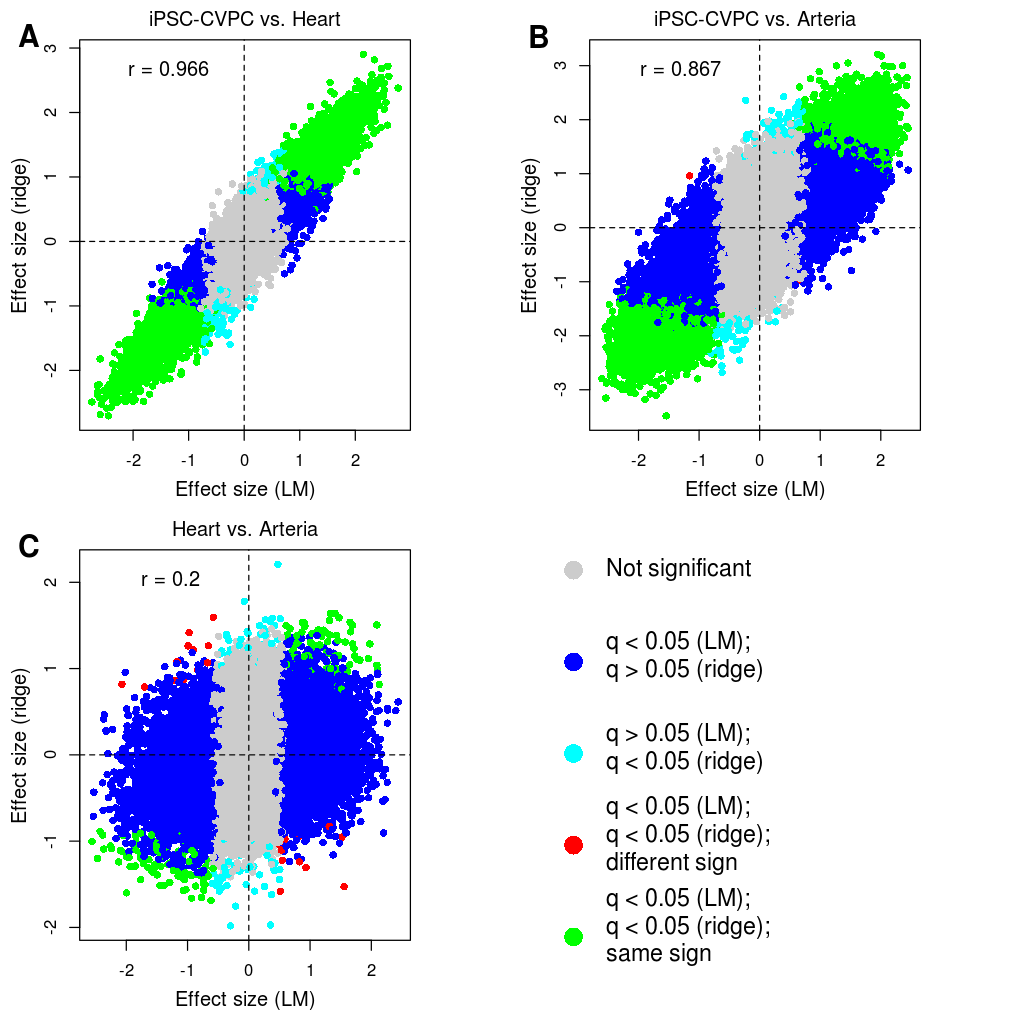

In [1930]:
figure_s14 = function()
{
    layout(rbind(1:2,3:4))
    
    genes1 = c("PTBP1", "SRSF9", "RBM24", "CPEB1")
    
    plot_diffexp_vs("isoform_use", "ipsc_cvpc", "heart"  , dec, c(), FALSE, "A")
    plot_diffexp_vs("isoform_use", "ipsc_cvpc", "arteria", dec, c(), FALSE, "B")
    plot_diffexp_vs("isoform_use", "heart"    , "arteria", dec, c(), FALSE, "C")

    par(mar = c(1,0,1,1))
    plot(1,1, type = "n", xlim = c(0,1), ylim = c(5.5,0.75), xlab = "", ylab = "", axes = FALSE)
    
    points(x = rep(0.1 ,5), y = 1:5, cex = 2.5, pch = 16, col = c("#cccccc", "#0000ff", "#00ffff", "#ff0000", "#00ff00"))
    text  (x = rep(0.15,5), y = 1:5, labels = c("Not significant", 
                                                "q < 0.05 (LM);\nq > 0.05 (ridge)",
                                                "q > 0.05 (LM);\nq < 0.05 (ridge)",
                                                "q < 0.05 (LM);\nq < 0.05 (ridge);\ndifferent sign",
                                                "q < 0.05 (LM);\nq < 0.05 (ridge);\nsame sign"
                                               ), pos = 4, cex =1.4)
    
}

png(filename = "manuscript/cardiac_differential_expression/figure_S14.png", width = 8.5, height = 8.5, units = "in", res = 300)
figure_s14()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 8.5)
figure_s14()


In [1457]:
message(paste("Correlation between effect size (cardiac muscle % vs. expression) between iPSC-CVPCs and adult heart: R = ", 
              signif(cor(difct_cm$beta1, difct_cm$beta2), digits = 3),
              ", p = ",
              signif(cor.test(difct_cm$beta1, difct_cm$beta2)$p.value, digits = 3), 
              sep = ""))


Correlation between effect size (cardiac muscle % vs. expression) between iPSC-CVPCs and adult heart: R = 0.483, p = 0



'data.frame':	20393 obs. of  9 variables:
 $ transcript_id: chr  "ENSG00000000003.15_5" "ENSG00000000005.6_4" "ENSG00000000419.12_6" "ENSG00000000457.14_7" ...
 $ beta1        : num  -0.5234 0.5583 -0.0926 1.4259 -1.9819 ...
 $ se1          : num  0.258 0.286 0.492 0.336 0.282 ...
 $ pval1        : num  4.36e-02 5.22e-02 8.51e-01 3.49e-05 4.48e-11 ...
 $ qval1        : num  1.00 1.00 1.00 1.00 2.19e-05 ...
 $ beta2        : num  -0.732 -0.471 2.113 0.964 -0.899 ...
 $ se2          : num  0.227 0.225 0.274 0.245 0.237 ...
 $ pval2        : num  1.35e-03 3.72e-02 8.74e-14 9.65e-05 1.74e-04 ...
 $ qval2        : num  1.00 1.00 4.28e-08 1.00 1.00 ...


# Figure 5: The expression of thousands of genes and isoforms is associated with both stage and cell type

In [1762]:
x1 = diffexp_ridge[ diffexp_ridge$type == "gene_tpm" & diffexp_ridge$tissue1 == "ipsc_cvpc" & diffexp_ridge$tissue2 == "heart" & diffexp_ridge$covariate == "tissue" & diffexp_ridge$diffexp == TRUE, "transcript_id"]
x2 = diffexp_ridge[ diffexp_ridge$type == "gene_tpm" & diffexp_ridge$tissue1 == "ipsc_cvpc" & diffexp_ridge$tissue2 == "heart" & grepl("cibersort.regular", diffexp_ridge$covariate) == TRUE & diffexp_ridge$diffexp == TRUE & diffexp_ridge$beta > 0, "transcript_id"]

x3 = diffexp_ridge[ diffexp_ridge$type == "isoform_use" & diffexp_ridge$tissue1 == "ipsc_cvpc" & diffexp_ridge$tissue2 == "heart" & diffexp_ridge$covariate == "tissue" & diffexp_ridge$diffexp == TRUE, "transcript_id"]
x4 = diffexp_ridge[ diffexp_ridge$type == "isoform_use" & diffexp_ridge$tissue1 == "ipsc_cvpc" & diffexp_ridge$tissue2 == "heart" & grepl("cibersort.regular", diffexp_ridge$covariate) == TRUE & diffexp_ridge$diffexp == TRUE & diffexp_ridge$beta > 0, "transcript_id"]

x5 = diffexp_ridge[ diffexp_ridge$type == "gene_tpm" & diffexp_ridge$tissue1 == "ipsc_cvpc" & diffexp_ridge$tissue2 == "heart" & diffexp_ridge$covariate == "tissue" & diffexp_ridge$diffexp == TRUE & diffexp_ridge$gene_name %in% rbps, "transcript_id"]

message(paste("genes associated with cell type and stage (iPSC-CVPC vs. adult heart)"   , length(unique(intersect(x1, x2)))))
message(paste("isoforms associated with cell type and stage (iPSC-CVPC vs. adult heart)", length(unique(intersect(x3, x4)))))
message(paste("RBPs associated with cell type and stage (iPSC-CVPC vs. adult heart)"    , length(unique(intersect(x5, x2)))))


genes associated with cell type and stage (iPSC-CVPC vs. adult heart) 4637

isoforms associated with cell type and stage (iPSC-CVPC vs. adult heart) 1356

RBPs associated with cell type and stage (iPSC-CVPC vs. adult heart) 41



In [1763]:
diffexp_ridge[ diffexp_ridge$type == "gene_tpm" & diffexp_ridge$gene_name == "PTBP1",]

transcript_id        gene_id              gene_name gene_type     
3303    ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
3304    ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
3305    ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
3306    ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
3307    ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
3308    ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
3309    ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
3310    ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
3311    ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
3312    ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
3313    ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
3314    ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
3315    ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
765935  ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
765936  ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
765937  ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
765938  ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
765939  ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
765940  ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
765941  ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
765942  ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
765943  ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
765944  ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
765945  ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
765946  ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
765947  ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
1528567 ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
1528568 ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
1528569 ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
1528570 ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
1528571 ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
1528572 ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
1528573 ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
1528574 ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
1528575 ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
1528576 ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
1528577 ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
1528578 ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
1528579 ENSG00000011304.20_8 ENSG00000011304.20_8 PTBP1     protein_coding
        covariate                                     beta         se         
3303    tissue                                        -1.030031357 0.118607091
3304    cibersort.regular.fibroblast                   2.416874323 0.623007163
3305    cibersort.regular.cardiac_muscle              -3.463968132 0.179023507
3306    cibersort.regular.smooth_muscle               -0.199675189 0.487094119
3307    uniquely_mapped_reads_to_canonical_chromsomes -0.006976930 0.002222567
3308    cibersort.regular.immune                      -0.442815650 0.652538536
3309    total_reads_norm                              -0.263659018 0.077192194
3310    cibersort.regular.cardiac_neuron              10.438910015 1.411454157
3311    cibersort.regular.endothelial                  0.121137456 0.570307368
3312    mitochondrial_reads                            0.002161676 0.002682283
3313    sex                                            0.016875898 0.047642664
3314    cibersort.regular.myofibroblast               -2.534

png 
  2

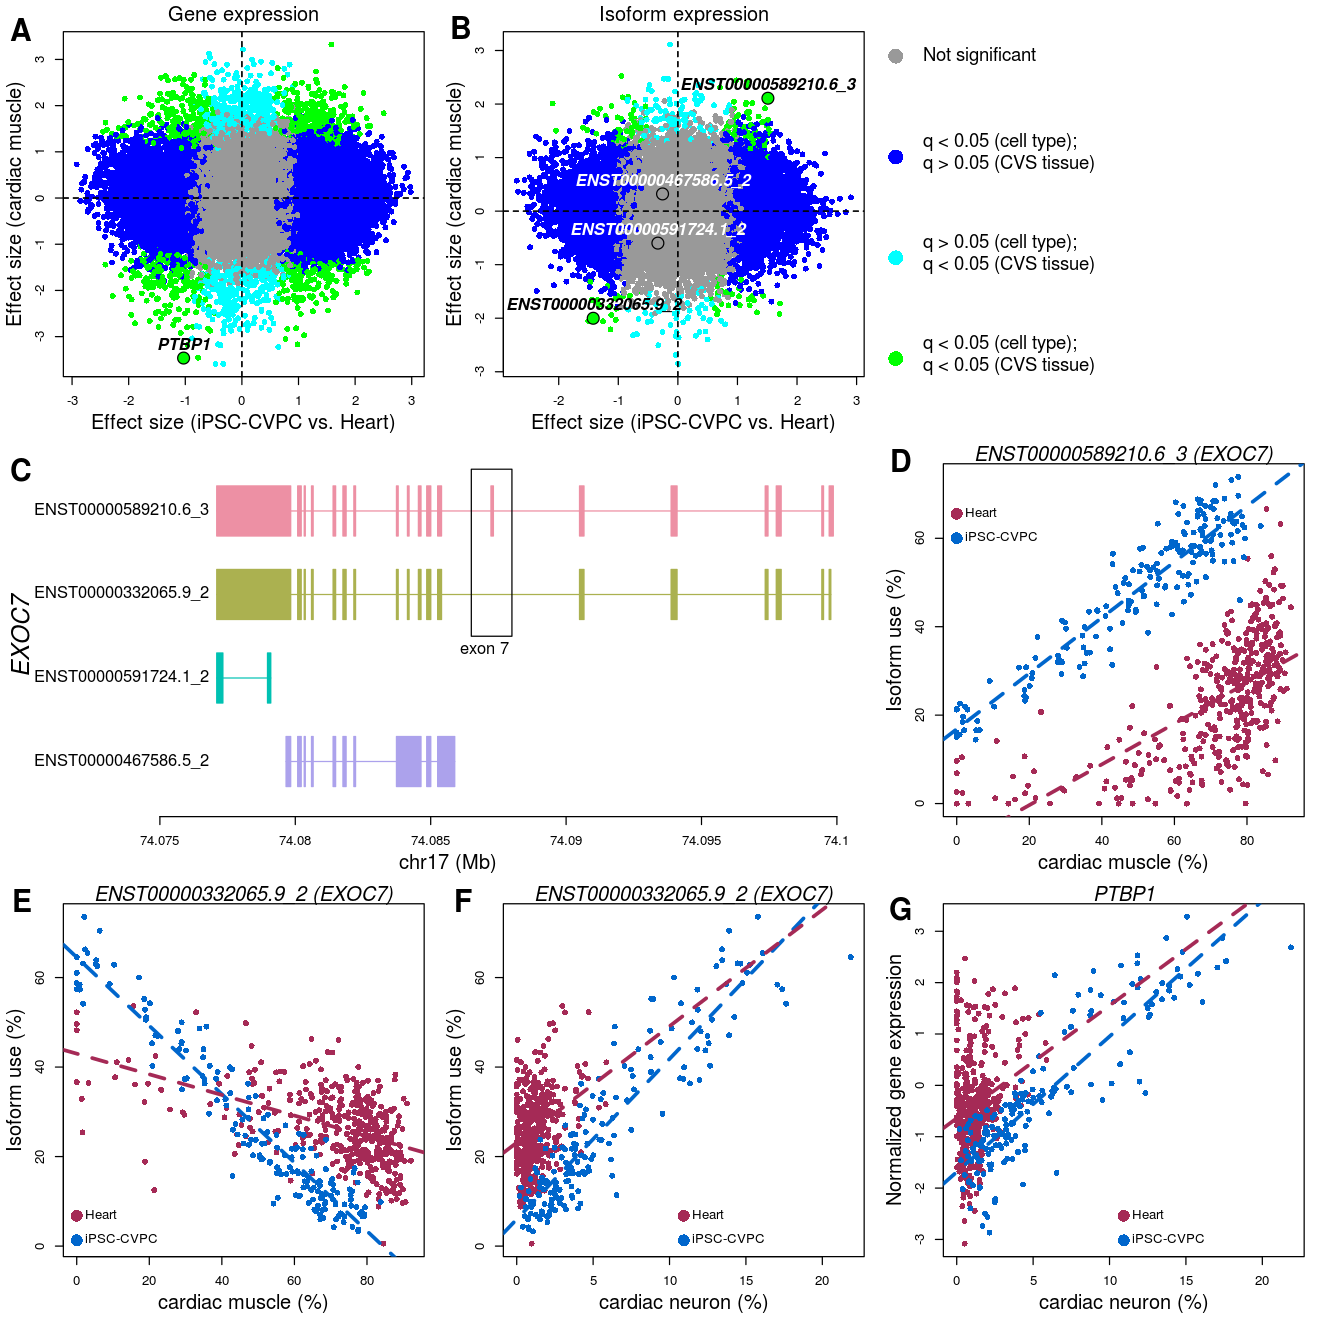

In [1933]:
plot_diffexp_vs_cell = function(type, tissue1, tissue2, cell, diffexp, genes = c(), show = FALSE, panel = "")
{
    diffexp = diffexp[ diffexp$type == type & diffexp$tissue1 == tissue1 & diffexp$tissue2 == tissue2, ]
    diffexp = merge(diffexp[diffexp$covariate == "tissue"                                   , c("transcript_id", "gene_id", "gene_name", "beta", "pval", "qval", "diffexp")],
                    diffexp[diffexp$covariate == paste("cibersort.regular", cell, sep = "."), c("transcript_id", "gene_id", "gene_name", "beta", "pval", "qval", "diffexp")],
                    by = c("transcript_id", "gene_id", "gene_name"),
                    suffixes = c("_tissue", "_cell")
                   )
    
    diffexp$color = "#cccccc"
    
    diffexp[ diffexp$diffexp_tissue == TRUE  & diffexp$diffexp_cell == TRUE & sign(diffexp$beta_tissue) == sign(diffexp$beta_cell), "color"] = "#00ff00"
    diffexp[ diffexp$diffexp_tissue == TRUE  & diffexp$diffexp_cell == TRUE & sign(diffexp$beta_tissue) != sign(diffexp$beta_cell), "color"] = "#00ff00"
    diffexp[ diffexp$diffexp_tissue == TRUE  & diffexp$diffexp_cell == FALSE, "color"] = "#0000ff"
    diffexp[ diffexp$diffexp_tissue == FALSE & diffexp$diffexp_cell == TRUE , "color"] = "#00ffff"
    diffexp[ diffexp$diffexp_tissue == FALSE & diffexp$diffexp_cell == FALSE, "color"] = "#999999"
    
    
    to_title = "Gene expression"
    if(type == "isoform_use"){to_title = "Isoform expression"}
    
    par(mar = c(4,4,2,1))
    
    plot(diffexp$beta_tissue, diffexp$beta_cell, col = diffexp$color, pch = 16, xlab = "", ylab = "")
    mtext(text = panel   , side = 2, line =  2  , at = max(diffexp$beta_cell) * 1.1, font = 2, cex = 1.5, las = 2)
    mtext(text = to_title, side = 3, line =  0.5)
    mtext(text = paste("Effect size (", sub("_", " ", cell), ")", sep = ""), side = 2, line =  2.5)
    mtext(text = paste("Effect size (", tissue2color3[tissue1, "body_site"], " vs. ", tissue2color3[tissue2, "body_site"], ")", sep = ""), side = 1, line =  2.5)
    
    abline(v = 0, lty = "dashed")
    abline(h = 0, lty = "dashed")
    #abline(lm(beta_cell ~ beta_tissue, data = diffexp), lty = "dashed")
    
    #mycor = cor.test(diffexp$beta_tissue, diffexp$beta_cell)
    
    abline(v = 0, lty = "dashed")
    abline(h = 0, lty = "dashed")
    
    #mycor     = cor.test(diffexp$beta_lm, diffexp$beta_ridge)
    #cor2write = paste("r", signif(mycor$estimate, digits = 3), sep = " = ")
    #my_title  = paste(tissue2color3[tissue1, "body_site"], tissue2color3[tissue2, "body_site"], sep = " vs. ")
    #mtext(text = panel                , side = 2, line =  2  , at = max(diffexp$beta_ridge) * 1.1, font = 2, cex = 1.5, las = 2)
    #mtext(text = "Effect size (LM)"   , side = 1, line =  2.5)
    #mtext(text = "Effect size (ridge)", side = 2, line =  2.5)
    #mtext(text = my_title             , side = 3, line =  0.5)
    #mtext(text = cor2write            , side = 3, line = -2  , at = min(diffexp$beta_lm)/2)
    #
    if(length(genes) > 0)
    {
        totext = diffexp[diffexp$gene_name %in% genes,]
        totext$write = totext$transcript_id
        totext$color_text = "#000000"
        if(nrow(totext[totext$color == "#999999", ]) > 0){totext[totext$color == "#999999", "color_text"] = "#ffffff"}
        if(nrow(totext[grepl("ENSG", totext$transcript_id) == TRUE, ]) > 0){totext[grepl("ENSG", totext$transcript_id) == TRUE, "write"] = totext[grepl("ENSG", totext$transcript_id) == TRUE, "gene_name"]}
        text  (totext$beta_tissue, totext$beta_cell, totext$write, cex = 1.25, font = 4, pos = 3, col = totext$color_text)
        points(totext$beta_tissue, totext$beta_cell, cex = 2, pch = 21, bg = totext$color)
        
    }
}

figure_5_iso = function(gene_id, panel = "")
{
    tissue2color3       = tissue2color3[tissue2color3$tissue %in% c("ipsc_cvpc", "heart"),]
    tissue2color3$order = 1:nrow(tissue2color3)
    
    isos                 = geneinfo_isoforms[ geneinfo_isoforms$gene_id == gene_id, "transcript_id"]
    expdata              = as.data.frame(t(as.matrix(isof_use[isos,])))
    expdata$run          = rownames(expdata)
    expdata              = merge(expdata, metadata[,c("run", "study", "tissue")])
    expdata              = merge(expdata, tissue2color3[,c("tissue", "order", "color")])
    iso2order            = data.frame(transcript_id = isos, mean = colMeans(expdata[,isos]))
    iso2order            = merge(iso2order, diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart", c("transcript_id", "log2r", "diffexp")])
    iso2order            = iso2order[order(iso2order$mean, decreasing = TRUE),]
    iso2order$order      = 1:nrow(iso2order)
    iso2order$color      = qualitative_hcl(n = nrow(iso2order), palette = "Set 2")
    iso2order$color_name = "#000000"
    expdata              = expdata[order(expdata$order, -expdata[,iso2order[1, "transcript_id"]], -expdata[,iso2order[1, "transcript_id"]]),]
    exons                = merge(iso2order, exons)
    xlims                = c(min(exons$start), max(exons$end))
    
    if(nrow(iso2order[ iso2order$diffexp == TRUE & iso2order$log2r >=  2,]) > 0){iso2order[ iso2order$diffexp == TRUE & iso2order$log2r >=  2, "color_name"] = tissue2color3["ipsc_cvpc", "color"]}
    if(nrow(iso2order[ iso2order$diffexp == TRUE & iso2order$log2r <= -2,]) > 0){iso2order[ iso2order$diffexp == TRUE & iso2order$log2r <= -2, "color_name"] = tissue2color3["heart"    , "color"]}
    
    par(mar = c(4,2,1,1))
    plot(1,1, type = "n", xlim = c(xlims[[1]] - (xlims[[2]] - xlims[[1]])/4, xlims[[2]]), ylim = c(nrow(iso2order),0), xlab = "", ylab = "", axes = FALSE)
    axis(1, at = pretty(xlims), labels = pretty(xlims) * 1e-6)
    
    mtext(text = paste(unique(exons$chrom), "(Mb)"), side = 1, line =  2.5)
    mtext(text = panel                             , side = 2, line = 0  , las = 2, at = 0, font = 2, cex = 1.5)
    
    mtext(text = geneinfo_genes[ geneinfo_genes$gene_id == gene_id, "gene_name"], side = 2, line = 0, font = 3, cex = 1.2)
    text (x = xlims[[1]], y = iso2order$order - 0.5, labels = iso2order$transcript_id, col = iso2order$color_name, pos = 2, cex = 1.25)
   
    for(ii in 1:nrow(iso2order))
    {
        toplot = exons[exons$transcript_id == iso2order[ii, "transcript_id"],]
        y0     = iso2order[ii, "order"]
        mycol  = iso2order[ii, "color"]
        
        rect    (xleft =     toplot$start , xright =     toplot$end , ybottom = y0 - 0.8, ytop = y0 - 0.2, col = mycol, border = mycol)
        segments(x0    = min(toplot$start), x1     = max(toplot$end), y0      = y0 - 0.5,                  col = mycol)
    }
    
}

figure_5_old = function()
{
    layout(rbind(c(rep(1,5), rep(2,5), rep(3,2)), 
                 sort(rep(c(4,5 ), 6)),
                 sort(rep(c(6,7 ), 6)),
                 sort(rep(c(8:10), 4))
                ))
    
    
    plot_diffexp_vs_cell("gene_tpm"   , "ipsc_cvpc", "heart"  , "cardiac_muscle", diffexp_ridge, c("TMOD1", "DTNA", "PTBP1"), TRUE, "A")
    plot_diffexp_vs_cell("isoform_use", "ipsc_cvpc", "heart"  , "cardiac_muscle", diffexp_ridge, c("EXOC7", "CAPZB"        ), TRUE, "B")
    
    
    par(mar = c(1,0,1,1))
    plot(1,1, type = "n", xlim = c(0,1), ylim = c(4.5,0.75), xlab = "", ylab = "", axes = FALSE)
    
    points(x = rep(0  ,4), y = 1:4, cex = 2, pch = 16, col = c("#cccccc", "#0000ff", "#00ffff", "#00ff00"))
    text  (x = rep(0.1,4), y = 1:4, labels = c("N.S.", 
                                               "q < 0.05 (cell type);\nq > 0.05 (CVS tissue)",
                                               "q > 0.05 (cell type);\nq < 0.05 (CVS tissue)",
                                               "q < 0.05 (cell type);\nq < 0.05 (CVS tissue)"
                                              ), pos = 4, cex = 1.4)
    
    figure_cell (geneinfo_genes[ geneinfo_genes$gene_name == "TMOD1", "gene_id"], c("ipsc_cvpc", "heart"), "cibersort.regular.cardiac_muscle", gene_tpm, geneinfo_genes   , "Normalized expression", "C", TRUE )
    figure_cell (geneinfo_genes[ geneinfo_genes$gene_name == "DTNA" , "gene_id"], c("ipsc_cvpc", "heart"), "cibersort.regular.cardiac_muscle", gene_tpm, geneinfo_genes   , "Normalized expression", "D", TRUE )
    figure_cell ("ENST00000375142.5_4"                                          , c("ipsc_cvpc", "heart"), "cibersort.regular.cardiac_muscle", isof_use, geneinfo_isoforms, "Isoform use (%)"      , "E", TRUE )
    
    figure_5_iso(geneinfo_genes[ geneinfo_genes$gene_name == "EXOC7", "gene_id"], "F")
    
    rect(xleft = 74.0865e6, xright = 74.088e6, ybottom = 0, ytop = 2)
    text(x     = 74.087e6 , y = 2, labels = "exon 7", cex = 1.2, pos = 1)

    figure_cell ("ENST00000589210.6_3", c("ipsc_cvpc", "heart"), "cibersort.regular.cardiac_muscle", isof_use, geneinfo_isoforms, "Isoform use (%)", "G", TRUE )
    figure_cell ("ENST00000332065.9_2", c("ipsc_cvpc", "heart"), "cibersort.regular.cardiac_muscle", isof_use, geneinfo_isoforms, "Isoform use (%)", "H", TRUE )
    figure_cell ("ENST00000332065.9_2", c("ipsc_cvpc", "heart"), "cibersort.regular.cardiac_neuron", isof_use, geneinfo_isoforms, "Isoform use (%)", "I", TRUE )

}

figure_cell = function(gene_id, tissues, cell, tpm, geneinfo, yname, panel = "", legend = FALSE)
{
    color                  = cell2color_regular[ cell2color_regular$cell_type == sub("cibersort\\.", "", cell), "color"]
    expdata                = data.frame(assay_id = colnames(tpm), exp = as.numeric(tpm[gene_id,]))
    colnames(expdata)[[2]] = "exp"
    expdata                = merge(expdata, metadata  [,c("run", "study", "tissue")], by.x = "assay_id", by.y = "run")
    expdata                = merge(expdata, covariates[,c("run", cell)], by.x = "assay_id", by.y = "run")
    expdata$cell           = expdata[,cell] * 100
    expdata                = merge(expdata, tissue2color3[,c("tissue", "color"   )])
    this                   = expdata[expdata$tissue %in% tissues,]
    
    par(mar = c(4,4,1.5,1))
    plot(this$cell, this$exp, pch = 16, col = this$color, axes = TRUE, xlab = "", ylab = "")

    cell2axis = paste(gsub("_", " ", paste(sub("cibersort.regular\\.", "", cell))), "(%)")
    
    plot_title = geneinfo[ geneinfo$transcript_id == gene_id, "gene_name"]
    
    if(grepl("ENST00", gene_id) == TRUE){plot_title = paste(gene_id, " (", plot_title, ")", sep = "")}
    
    mtext(text = panel     , side = 2, line = 2  , at = max(this$exp) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = cell2axis , side = 1, line = 2.5)
    mtext(text = yname     , side = 2, line = 2.5)
    mtext(text = plot_title, side = 3, line = 0  , font = 3, cex = 1)
    
    for(tissue in tissues)
    {
        tolm = expdata[expdata$tissue == tissue,]
        
        abline(lm(exp ~ cell, data = tolm), col = tissue2color3[tissue, "color"], lwd = 3, lty = "dashed")
    }
    
    if(legend == TRUE)
    {
        myx = min (this$cell)
        myy = min (this$exp ) + 0.01 * (max(this$exp) - min(this$exp))
        
        if(sign(summary(lm(exp ~ cell, data = this))$coefficients[2,1]) == 1){myx = mean(range(this$cell))}
        if(gene_id == "ENST00000589210.6_3")
        {
            myx = 0
            myy = 60
        }
        
        points(x = rep(myx, 2), y = c(myy, myy + 0.075 * (max(this$exp) - min(this$exp))), pch = 16, cex = 2, col = tissue2color3[tissues, "color"])
        text  (x = rep(myx, 2), y = c(myy, myy + 0.075 * (max(this$exp) - min(this$exp))), pos =  4, labels = tissue2color3[tissues, "body_site"])
    }
    
}

figure_5 = function()
{
    #layout(rbind(c(rep(1,2), 2, rep(3,3)), 
    #             sort(rep(4:6, 2))
    #            ))
    
    layout(rbind(1:3,
                 c(4,4,5),
                 6:8
                ))
    
    
    plot_diffexp_vs_cell("gene_tpm"   , "ipsc_cvpc", "heart"  , "cardiac_muscle", diffexp_ridge, c("PTBP1"), TRUE, "A")
    plot_diffexp_vs_cell("isoform_use", "ipsc_cvpc", "heart"  , "cardiac_muscle", diffexp_ridge, c("EXOC7"), TRUE, "B")
    
    
    par(mar = c(1,0,1,1))
    plot(1,1, type = "n", xlim = c(0,1), ylim = c(4.5,0.75), xlab = "", ylab = "", axes = FALSE)
    
    points(x = rep(0   ,4), y = 1:4, cex = 2.5, pch = 16, col = c("#999999", "#0000ff", "#00ffff", "#00ff00"))
    text  (x = rep(0.05,4), y = 1:4, labels = c("Not significant", 
                                               "q < 0.05 (cell type);\nq > 0.05 (CVS tissue)",
                                               "q > 0.05 (cell type);\nq < 0.05 (CVS tissue)",
                                               "q < 0.05 (cell type);\nq < 0.05 (CVS tissue)"
                                              ), pos = 4, cex =1.4)
    
    figure_5_iso(geneinfo_genes[ geneinfo_genes$gene_name == "EXOC7", "gene_id"], "C")
    
    rect(xleft = 74.0865e6, xright = 74.088e6, ybottom = 0, ytop = 2)
    text(x     = 74.087e6 , y = 2, labels = "exon 7", cex = 1.25, pos = 1)

    figure_cell ("ENST00000589210.6_3" , c("ipsc_cvpc", "heart"), "cibersort.regular.cardiac_muscle", isof_use, geneinfo_isoforms, "Isoform use (%)"           , "D", TRUE )
    figure_cell ("ENST00000332065.9_2" , c("ipsc_cvpc", "heart"), "cibersort.regular.cardiac_muscle", isof_use, geneinfo_isoforms, "Isoform use (%)"           , "E", TRUE )
    figure_cell ("ENST00000332065.9_2" , c("ipsc_cvpc", "heart"), "cibersort.regular.cardiac_neuron", isof_use, geneinfo_isoforms, "Isoform use (%)"           , "F", TRUE )
    figure_cell ("ENSG00000011304.20_8", c("ipsc_cvpc", "heart"), "cibersort.regular.cardiac_neuron", gene_tpm, geneinfo_genes   , "Normalized gene expression", "G", TRUE )

}

png(filename = "manuscript/cardiac_differential_expression/figure_5.png", width = 11, height = 11, units = "in", res = 300)
figure_5()
dev.off()

options(repr.plot.width = 11, repr.plot.height = 11)
figure_5()



## Figure S15: Associations between tissue and cardiac muscle

png 
  2

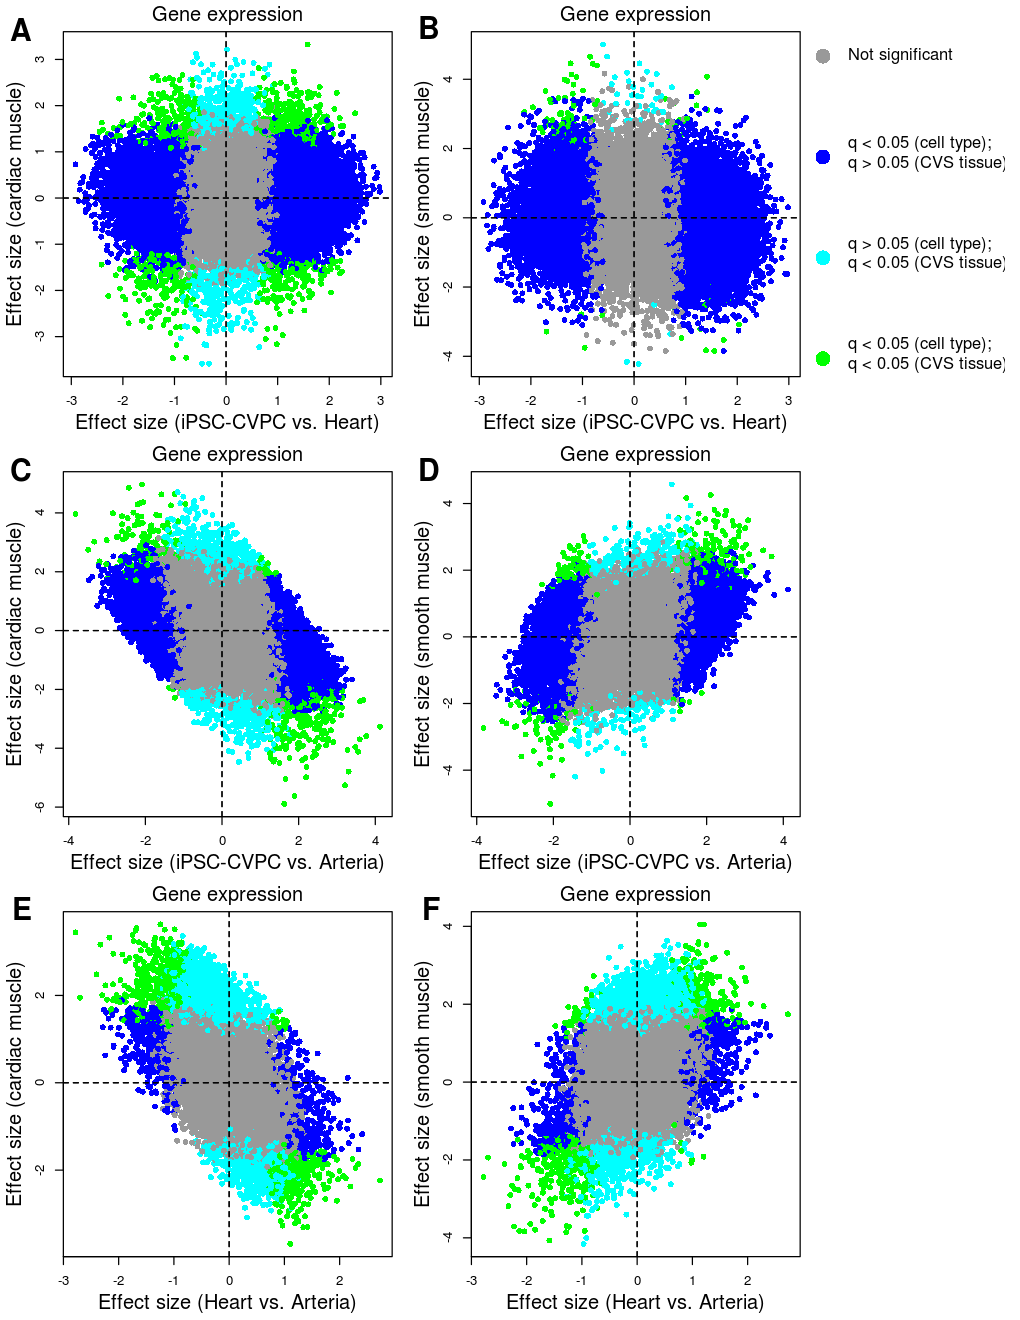

In [1931]:
figure_s15 = function()
{
    layout(rbind(c(1,1,2,2,7),
                 c(3,3,4,4,8),
                 c(5,5,6,6,8)
                ))
    
    
    plot_diffexp_vs_cell("gene_tpm", "ipsc_cvpc", "heart"    , "cardiac_muscle", diffexp_ridge, c(), TRUE, "A")
    plot_diffexp_vs_cell("gene_tpm", "ipsc_cvpc", "heart"    , "smooth_muscle" , diffexp_ridge, c(), TRUE, "B")
    plot_diffexp_vs_cell("gene_tpm", "ipsc_cvpc", "arteria"  , "cardiac_muscle", diffexp_ridge, c(), TRUE, "C")
    plot_diffexp_vs_cell("gene_tpm", "ipsc_cvpc", "arteria"  , "smooth_muscle" , diffexp_ridge, c(), TRUE, "D")
    plot_diffexp_vs_cell("gene_tpm", "heart"    , "arteria"  , "cardiac_muscle", diffexp_ridge, c(), TRUE, "E")
    plot_diffexp_vs_cell("gene_tpm", "heart"    , "arteria"  , "smooth_muscle" , diffexp_ridge, c(), TRUE, "F")
    
    par(mar = c(1,0,1,1))
    plot(1,1, type = "n", xlim = c(0,1), ylim = c(4.5,0.75), xlab = "", ylab = "", axes = FALSE)
    
    points(x = rep(0  ,4), y = 1:4, cex = 2.5, pch = 16, col = c("#999999", "#0000ff", "#00ffff", "#00ff00"))
    text  (x = rep(0.1,4), y = 1:4, labels = c("Not significant", 
                                               "q < 0.05 (cell type);\nq > 0.05 (CVS tissue)",
                                               "q > 0.05 (cell type);\nq < 0.05 (CVS tissue)",
                                               "q < 0.05 (cell type);\nq < 0.05 (CVS tissue)"
                                              ), pos = 4, cex =1.25)
}

png(filename = "manuscript/cardiac_differential_expression/figure_S15.png", width = 8.5, height = 11, units = "in", res = 300)
figure_s15()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 11)
figure_s15()



## Figure S16: RBPs that are differentially expressed only considering cell types

png 
  2

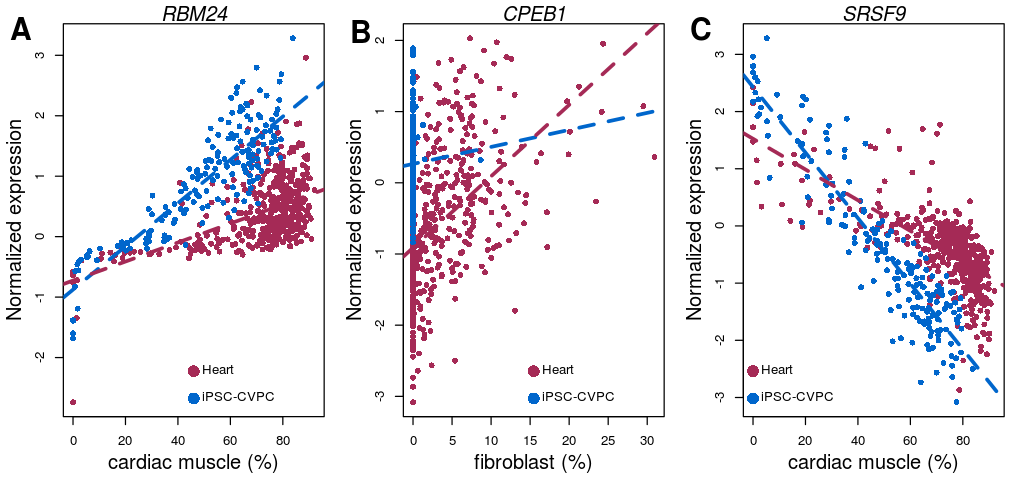

In [1932]:
figure_s16 = function()
{
    layout(rbind(1:3))
    
    figure_cell (geneinfo_genes[ geneinfo_genes$gene_name == "RBM24", "gene_id"], c("ipsc_cvpc", "heart"), "cibersort.regular.cardiac_muscle", gene_tpm, geneinfo_genes, "Normalized expression", "A", TRUE )
    figure_cell (geneinfo_genes[ geneinfo_genes$gene_name == "CPEB1", "gene_id"], c("ipsc_cvpc", "heart"), "cibersort.regular.fibroblast"    , gene_tpm, geneinfo_genes, "Normalized expression", "B", TRUE )
    figure_cell (geneinfo_genes[ geneinfo_genes$gene_name == "SRSF9", "gene_id"], c("ipsc_cvpc", "heart"), "cibersort.regular.cardiac_muscle", gene_tpm, geneinfo_genes, "Normalized expression", "C", TRUE )
}

png(filename = "manuscript/cardiac_differential_expression/figure_S16.png", width = 8.5, height = 4, units = "in", res = 300)
figure_s16()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 4)
figure_s16()


In [1785]:
diffexp_ridge[ diffexp_ridge$gene_name == "TAF15" & diffexp_ridge$tissue1 == "ipsc_cvpc" & diffexp_ridge$tissue2 == "heart" & diffexp_ridge$type == "gene_tpm",]

transcript_id       gene_id             gene_name gene_type     
244908 ENSG00000270647.6_5 ENSG00000270647.6_5 TAF15     protein_coding
244909 ENSG00000270647.6_5 ENSG00000270647.6_5 TAF15     protein_coding
244910 ENSG00000270647.6_5 ENSG00000270647.6_5 TAF15     protein_coding
244911 ENSG00000270647.6_5 ENSG00000270647.6_5 TAF15     protein_coding
244912 ENSG00000270647.6_5 ENSG00000270647.6_5 TAF15     protein_coding
244913 ENSG00000270647.6_5 ENSG00000270647.6_5 TAF15     protein_coding
244914 ENSG00000270647.6_5 ENSG00000270647.6_5 TAF15     protein_coding
244915 ENSG00000270647.6_5 ENSG00000270647.6_5 TAF15     protein_coding
244916 ENSG00000270647.6_5 ENSG00000270647.6_5 TAF15     protein_coding
244917 ENSG00000270647.6_5 ENSG00000270647.6_5 TAF15     protein_coding
244918 ENSG00000270647.6_5 ENSG00000270647.6_5 TAF15     protein_coding
244919 ENSG00000270647.6_5 ENSG00000270647.6_5 TAF15     protein_coding
244920 ENSG00000270647.6_5 ENSG00000270647.6_5 TAF15     protein_coding
       covariate                                     beta         se         
244908 cibersort.regular.endothelial                  0.676326600 0.588701962
244909 cibersort.regular.fibroblast                  -1.831187038 0.643101527
244910 cibersort.regular.smooth_muscle               -0.494718805 0.502804767
244911 tissue                                         1.972915101 0.122432624
244912 cibersort.regular.cardiac_neuron              -2.967446184 1.456978952
244913 cibersort.regular.endocardial                 -0.682194265 0.820071322
244914 mitochondrial_reads                            0.001642750 0.002768797
244915 cibersort.regular.myofibroblast                4.788495732 1.254191943
244916 uniquely_mapped_reads_to_canonical_chromsomes -0.001346554 0.002294254
244917 cibersort.regular.cardiac_muscle               0.244320944 0.184797700
244918 total_reads_norm                               0.273140017 0.079681937
244919 cibersort.regular.immune                       0.481396499 0.673585400
244920 sex                                            0.001820768 0.049179322
       pval         qval         tissue1   tissue2 type     diffexp
244908 5.088722e-01 1.000000e+00 ipsc_cvpc heart   gene_tpm FALSE  
244909 1.560451e-02 1.000000e+00 ipsc_cvpc heart   gene_tpm FALSE  
244910 7.183918e-01 1.000000e+00 ipsc_cvpc heart   gene_tpm FALSE  
244911 2.024681e-58 4.128933e-54 ipsc_cvpc heart   gene_tpm  TRUE  
244912 6.435427e-02 1.000000e+00 ipsc_cvpc heart   gene_tpm FALSE  
244913 6.214803e-01 1.000000e+00 ipsc_cvpc heart   gene_tpm FALSE  
244914 5.529748e-01 1.000000e+00 ipsc_cvpc heart   gene_tpm FALSE  
244915 3.160246e-04 1.000000e+00 ipsc_cvpc heart   gene_tpm FALSE  
244916 5.572545e-01 1.000000e+00 ipsc_cvpc heart   gene_tpm FALSE  
244917 1.000000e+00 1.000000e+00 ipsc_cvpc heart   gene_tpm FALSE  
244918 6.083171e-04 1.000000e+00 ipsc_cvpc heart   gene_tpm FALSE  
244919 7.586237e-01 1.000000e+00 ipsc_cvpc heart   gene_tpm FALSE  
244920 9.704666e-01 1.000000e+00 ipsc_cvpc heart   gene_tpm FALSE

# Figure 6: Heart failure

In [1718]:
hf_gene    =              fread("pipeline/4.13.heart_failure/diffexp_gene.txt"            , sep = "\t", header = TRUE, data.table = FALSE)
hf_isof    =              fread("pipeline/4.13.heart_failure/diffexp_isoform.txt"         , sep = "\t", header = TRUE, data.table = FALSE)
exp2hf     =              fread("pipeline/4.13.heart_failure/diffexp_vs_heart_failure.txt", sep = "\t", header = TRUE, data.table = FALSE)
hf2dist    =              fread("pipeline/4.13.heart_failure/hf2dist.txt"                 , sep = "\t", header = TRUE, data.table = FALSE)
pcdata     = add_rownames(fread("pipeline/4.13.heart_failure/pcdata.txt"                  , sep = "\t", header = TRUE, data.table = FALSE))
cibersort_hf  = add_rownames(fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/pipeline/2.1.scrna_seq/cibersort.new.txt", sep = "\t", header = TRUE, data.table = FALSE))

pcdata$run = rownames(pcdata)

In [1719]:
diffhf0 = fread("pipeline/4.13.heart_failure/ridge_vs_all/diffexp.txt", sep = "\t", header = TRUE, data.table = FALSE)
diffhf  = diffhf0[ diffhf0$covariate == "tissue",]


In [1720]:
cibersort_hf[,c("P-value", "Correlation", "RMSE")] = NULL
colnames(cibersort_hf)  = gsub("leukocyte", "immune", gsub("_cell", "", colnames(cibersort_hf)))
cell2color_hf           = cell2color_regular
cell2color_hf$cell_type = gsub("regular.", "", cell2color_hf$cell_type)
cibersort_hf            = cibersort_hf[ hf2dist$run, cell2color_hf$cell_type]
#cibersort_hf           = cibersort_hf[,cell2color_hf$cell_type]

In [1721]:
tpm_hf = add_rownames(fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/pipeline/1.2.expression/tpm_gene.normalized.txt", sep = "\t", header = TRUE, data.table = FALSE))

In [1722]:
tissues  = unique(diftiss[,c("tissue1", "tissue2")])
diseases = c("ICM", "NICM", "all")

ipsc_cvpc 14.3838247889752 21.4908324081818 7.10700761920659 1.29538982411191e-06

heart 14.7429611331545 10.1717996495906 -4.57116148356391 2.72975230595301e-08



png 
  2

ipsc_cvpc 14.3838247889752 21.4908324081818 7.10700761920659 1.29538982411191e-06

heart 14.7429611331545 10.1717996495906 -4.57116148356391 2.72975230595301e-08



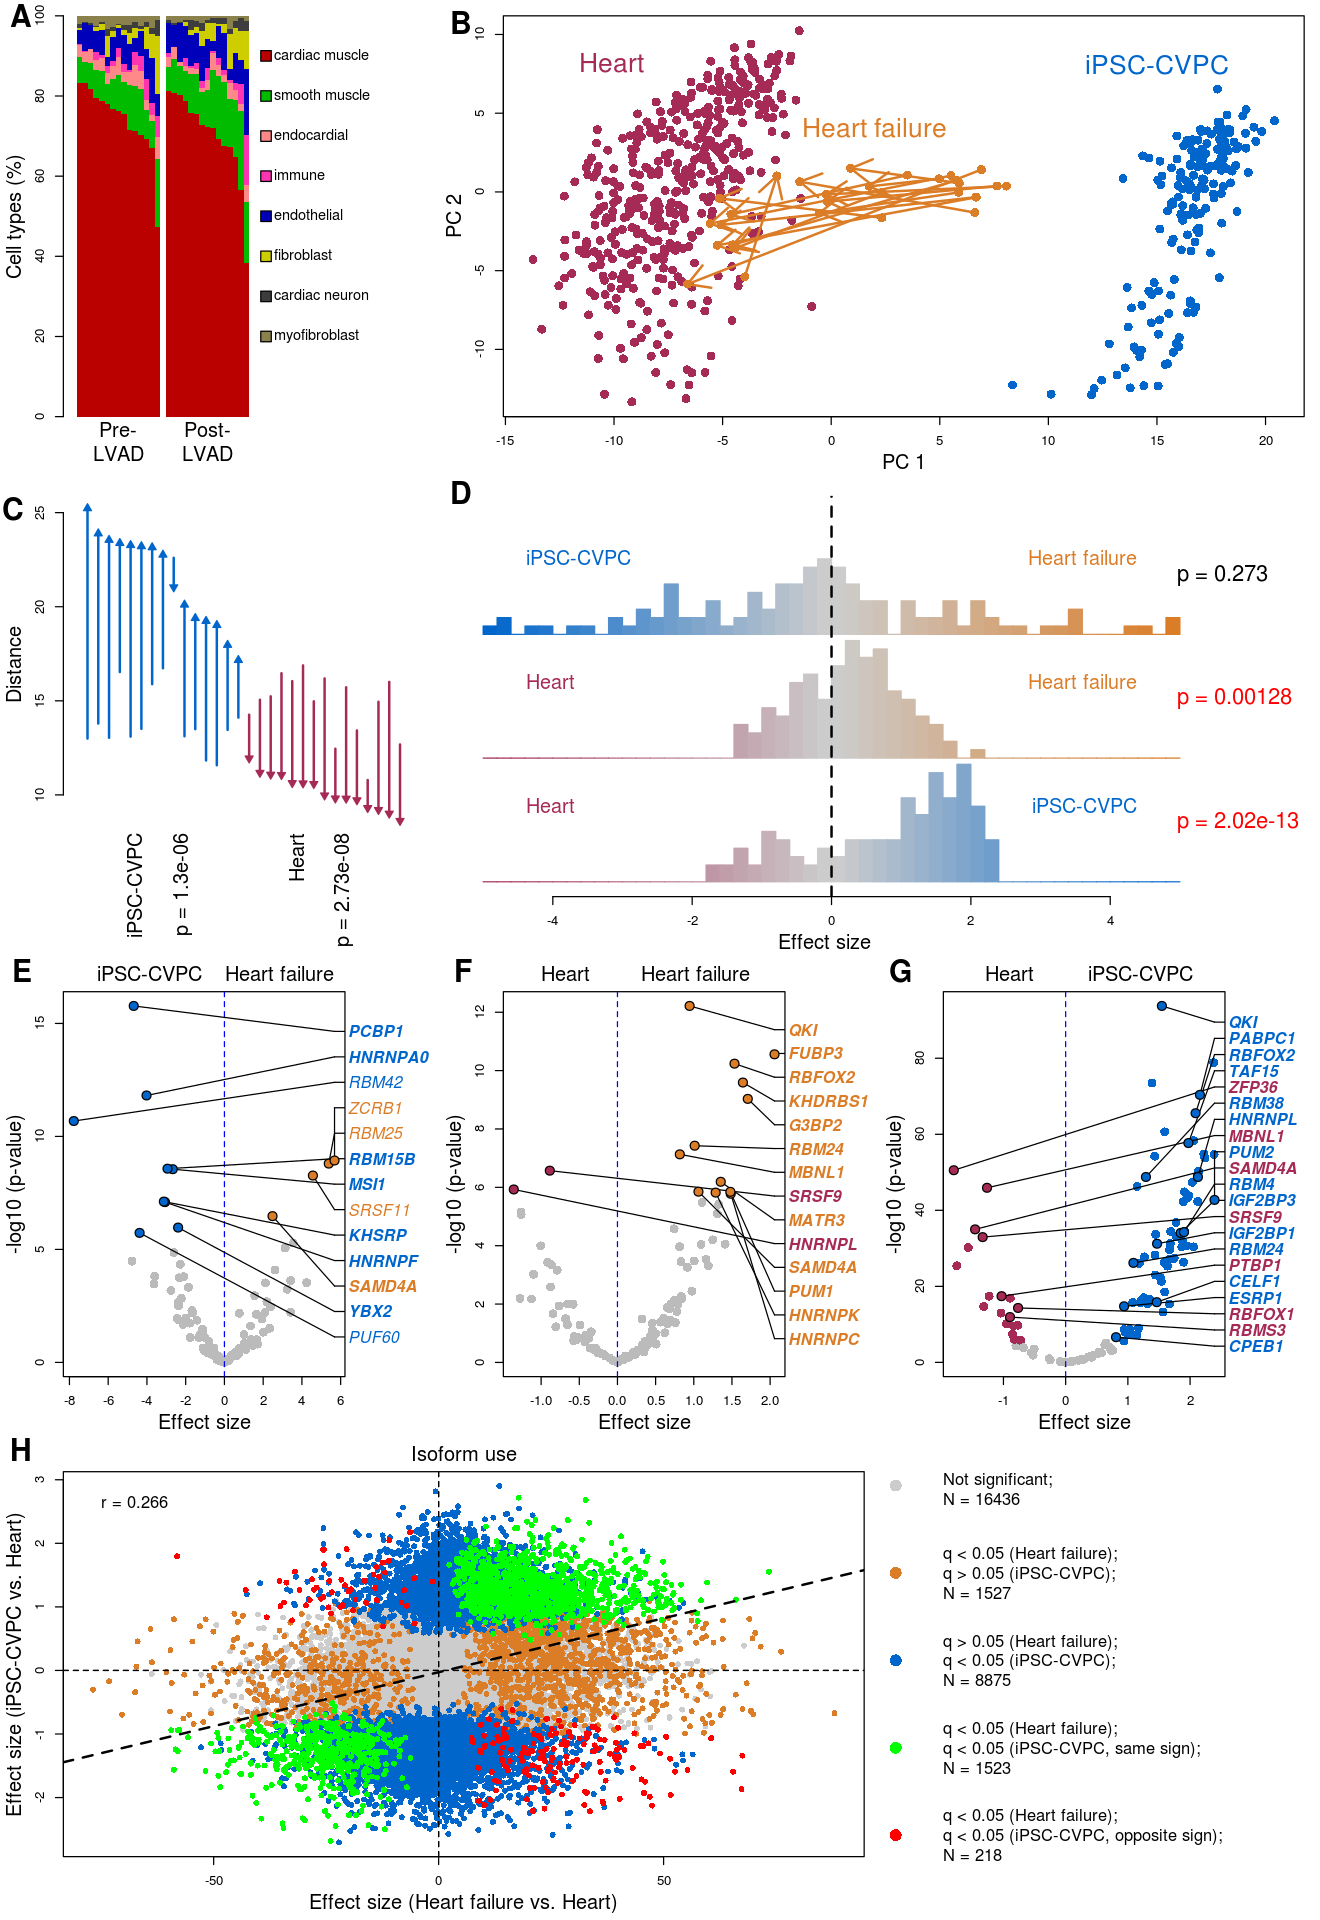

In [1788]:
plot_cor = function(exp2hf, tissue1, tissue2, disease, type, genes = c(), panel = "")
{
    indata = exp2hf[ exp2hf$tissue1 == tissue1 & exp2hf$tissue2 == tissue2 & exp2hf$disease == disease & exp2hf$type == type, ]
    indata = indata[ is.infinite(indata$log2r1) == FALSE & is.infinite(indata$log2r2) == FALSE, ]
    
    indata$color = "#dddddd"
    
    if(nrow(indata[ indata$qval <= 0.05 & indata$fdr <= 0.1, ]) > 0){indata[ indata$qval <= 0.05 & indata$fdr <= 0.1, "color"] = "#999999"}
    
    indata = indata[order(indata$color, decreasing = TRUE),]
    
    if(disease == "all"){disease = ""}
    
    mycor  = cor.test(indata$log2r1, indata$log2r2)
    
    par(mar = c(4,4,1,1))
    plot(indata$log2r1, indata$log2r2, pch = 16, col = indata$color, xlab = "", ylab = "")
    
    myx = paste("log2 (", tissue2color3[tissue1, "body_site"], " / ", tissue2color3[tissue2, "body_site"], ")", sep = "")
    myy = paste("log2 (", "pre", " / ", "post", ") ", disease, sep = "")
    
    mtext(text = panel, side = 2, line = 2.5, at = max(indata$log2r2) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = myx  , side = 1, line = 2.5)
    mtext(text = myy  , side = 2, line = 2.5)
    
    text(x = 0, y = min(indata$log2r2) * 0.85, labels = paste("r", signif(mycor$estimate, digits = 2), sep = " = "), pos = 4, cex = 1.25, col = "#ff0000")
    text(x = 0, y = min(indata$log2r2) * 0.95, labels = paste("p", signif(mycor$p.value , digits = 2), sep = " = "), pos = 4, cex = 1.25, col = "#ff0000")
    
    abline(lm(log2r2 ~ log2r1, data = indata), col = "#ff0000", lty = "dashed", lwd = 3)
    abline(h = 0, col = "#0000ff", lty = "dashed", lwd = 2)
    abline(v = 0, col = "#0000ff", lty = "dashed", lwd = 2)
    
    if(length(genes) > 0)
    {
        totext     = indata[indata$gene_name %in% genes & indata$qval <= 0.05 & indata$fdr <= 0.1,]
        totext$pos = 3
        
        if(nrow(totext[totext$log2r1 < 0,]) > 0){totext[totext$log2r1 < 0, "pos"] = 2}
        if(nrow(totext[totext$log2r1 > 0,]) > 0){totext[totext$log2r1 > 0, "pos"] = 4}
        
        if(nrow(totext[totext$log2r2 < min(indata$log2r2) * 0.9,]) > 0){totext[totext$log2r2 < min(indata$log2r2) * 0.9, "pos"] = 3}
        if(nrow(totext[totext$log2r2 > max(indata$log2r2) * 0.9,]) > 0){totext[totext$log2r2 > max(indata$log2r2) * 0.9, "pos"] = 1}
        if(nrow(totext[totext$log2r1 < min(indata$log2r1) * 0.9,]) > 0){totext[totext$log2r1 < min(indata$log2r1) * 0.9, "pos"] = 4}
        if(nrow(totext[totext$log2r1 > max(indata$log2r1) * 0.9,]) > 0){totext[totext$log2r1 > max(indata$log2r1) * 0.9, "pos"] = 2}
        
        if(nrow(totext[totext$gene_name == "ATP1A3",]) > 0){totext[totext$gene_name == "ATP1A3", "log2r2"] = 1.25}
        #nc = wordlayout(totext$log2r1, totext$log2r2, totext$gene_name, cex = 1.25)
        #text(nc[,1] + .5*nc[,3],nc[,2]+.5*nc[,4],totext$gene_name, cex = 1.25)
    
        text(totext$log2r1, totext$log2r2, totext$gene_name, cex = 1.2, font = 3, pos = totext$pos)
        
    }
}

plot_cor_rbp = function(exp2hf, tissue1, tissue2, disease, type, genes = c(), panel = "")
{
    indata = exp2hf[ exp2hf$rbp == TRUE & exp2hf$tissue1 == tissue1 & exp2hf$tissue2 == tissue2 & exp2hf$disease == disease & exp2hf$type == type, ]
    indata = indata[ is.infinite(indata$log2r1) == FALSE & is.infinite(indata$log2r2) == FALSE, ]
    
    indata$score = abs(indata$log2r1) * abs(indata$log2r2)
    totext       = indata[order(indata$score, decreasing = TRUE),][1:5,]
    
    if(disease == "all"){disease = ""}
    
    mycor  = cor.test(indata$log2r1, indata$log2r2)
    
    par(mar = c(4,4,1,1))
    plot(indata$log2r1, indata$log2r2, pch = 16, col = "#bbbbbb", xlab = "", ylab = "")
    
    myx = paste("log2 (", tissue2color3[tissue1, "body_site"], " / ", tissue2color3[tissue2, "body_site"], ")", sep = "")
    myy = paste("log2 (", "pre", " / ", "post", ") ", disease, sep = "")
    
    mtext(text = panel, side = 2, line = 2.5, at = max(indata$log2r2) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = myx  , side = 1, line = 2.5)
    mtext(text = myy  , side = 2, line = 2.5)
    
    text(x = 0, y = min(indata$log2r2) * 0.85, labels = paste("r", signif(mycor$estimate, digits = 2), sep = " = "), pos = 4, cex = 1.25, col = "#ff0000")
    text(x = 0, y = min(indata$log2r2) * 0.95, labels = paste("p", signif(mycor$p.value , digits = 2), sep = " = "), pos = 4, cex = 1.25, col = "#ff0000")
    
    totext$pos = 3
    if(nrow(totext[totext$log2r2 < min(indata$log2r2) * 0.9,]) > 0){totext[totext$log2r2 < min(indata$log2r2) * 0.9, "pos"] = 3}
    if(nrow(totext[totext$log2r2 > max(indata$log2r2) * 0.9,]) > 0){totext[totext$log2r2 > max(indata$log2r2) * 0.9, "pos"] = 1}
    if(nrow(totext[totext$log2r1 < min(indata$log2r1) * 0.9,]) > 0){totext[totext$log2r1 < min(indata$log2r1) * 0.9, "pos"] = 4}
    if(nrow(totext[totext$log2r1 > max(indata$log2r1) * 0.9,]) > 0){totext[totext$log2r1 > max(indata$log2r1) * 0.9, "pos"] = 2}
    
    if(length(genes) > 0)
    {
        totext     = indata[indata$gene_name %in% genes,]
        totext$pos = 3
        
        if(nrow(totext[totext$log2r1 < 0,]) > 0){totext[totext$log2r1 < 0, "pos"] = 2}
        if(nrow(totext[totext$log2r1 > 0,]) > 0){totext[totext$log2r1 > 0, "pos"] = 4}
        
        if(nrow(totext[totext$log2r2 < min(indata$log2r2) * 0.9,]) > 0){totext[totext$log2r2 < min(indata$log2r2) * 0.9, "pos"] = 3}
        if(nrow(totext[totext$log2r2 > max(indata$log2r2) * 0.9,]) > 0){totext[totext$log2r2 > max(indata$log2r2) * 0.9, "pos"] = 1}
        if(nrow(totext[totext$log2r1 < min(indata$log2r1) * 0.9,]) > 0){totext[totext$log2r1 < min(indata$log2r1) * 0.9, "pos"] = 4}
        if(nrow(totext[totext$log2r1 > max(indata$log2r1) * 0.9,]) > 0){totext[totext$log2r1 > max(indata$log2r1) * 0.9, "pos"] = 2}
        
        if(nrow(totext[totext$gene_name == "ATP1A3",]) > 0){totext[totext$gene_name == "ATP1A3", "log2r2"] = 1.25}
        if(nrow(totext[totext$gene_name == "RBM38" ,]) > 0){totext[totext$gene_name == "RBM38" , "pos"   ] = 1   }
        if(nrow(totext[totext$gene_name == "RBM24" ,]) > 0){totext[totext$gene_name == "RBM24" , "pos"   ] = 3   }
        #nc = wordlayout(totext$log2r1, totext$log2r2, totext$gene_name, cex = 1.25)
        #text(nc[,1] + .5*nc[,3],nc[,2]+.5*nc[,4],totext$gene_name, cex = 1.25)
    
        text(totext$log2r1, totext$log2r2, totext$gene_name, cex = 1.2, font = 3, pos = totext$pos)
        
    }
    
    abline(lm(log2r2 ~ log2r1, data = indata), col = "#ff0000", lty = "dashed", lwd = 3)
    abline(h = 0, col = "#0000ff", lty = "dashed", lwd = 2)
    abline(v = 0, col = "#0000ff", lty = "dashed", lwd = 2)
}

plot_hf2dist = function(hf2dist, metadata, panel = "")
{
    tissues = sort(unique(metadata$tissue))
    tissues = c("ipsc_cvpc", "heart")
    
    tissue2p = data.frame(tissue = tissues, pval = 1)
    
    
    toplot_list = lapply(tissues, function(tissue)
    {
        meta1                = hf2dist[hf2dist$lvad_support == "pre-LVAD" , c("subject_id", paste("dist", tissue, sep = "."))]
        meta2                = hf2dist[hf2dist$lvad_support == "Post-LVAD", c("subject_id", paste("dist", tissue, sep = "."))]
        colnames(meta1)[[2]] = "pre"
        colnames(meta2)[[2]] = "post"
        totest               = merge(meta1, meta2, by = "subject_id", suffixes = c("_pre", "_post"))
        totest$tissue        = tissue
        test                 = t.test(totest$post, totest$pre, paired = TRUE)
        
        message(paste(tissue, mean(totest$pre), mean(totest$post), test$estimate, test$p.value))
        
        return(list(pval =  test$p.value, totest = totest))
    })

    toplot        = as.data.frame(rbindlist(lapply(toplot_list, function(x){x$totest})), stringsAsFactors = FALSE)
    tissue2p$pval = unlist(lapply(toplot_list, function(x){x$pval}))
    
    tissue2color3$order = c(3,1,2,4)
    tissue2color3       = tissue2color3[order(tissue2color3$order),]
    toplot              = merge(toplot, tissue2color3)
    toplot              = toplot[order(toplot$order),]
    toplot$distance     = toplot$post - toplot$pre
    toplot$pch          = 22
    toplot$y            = jitter(x = toplot$order, amount = 0.25)
    xlims               = range(toplot$distance)
    tissue2color3       = merge(unique(toplot[,c("tissue", "body_site", "order", "color")]), tissue2p)
    tissue2color3$ptext = paste("p", signif(tissue2color3$pval, digits = 3), sep = " = ")
    tissue2color3       = tissue2color3[order(tissue2color3$order),]
    
    toplot[grepl("NICM", toplot$subject_id) == TRUE, "pch"] = 23
    
    toplot     = toplot[order(toplot$order, -toplot$post),]
    toplot$x   = 1:nrow(toplot)
    toplot$pch = 24
    xlims      = c(0, nrow(toplot) + 1)
    ylims      = range(as.numeric(as.matrix(toplot[,c("pre", "post")])))
    
    toplot[toplot$distance < 0, "pch"] = 25
    
    par(mar = c(8,4,1,1))
    plot(1,1, type = "n", xlim = xlims, ylim = ylims, xlab = "", ylab = "", axes = FALSE)
    axis(2)
    
    segments(x0 = toplot$x, y0 = toplot$pre , col = toplot$color, y1 = toplot$post , lwd = 2)
    points  (x  = toplot$x, y  = toplot$post, col = toplot$color, bg = toplot$color, pch = toplot$pch)
    
    tissue2color3 = merge(tissue2color3, aggregate(x ~ body_site, data = toplot, FUN = function(x){quantile(x, probs = 0.35)}))
    tissue2color3 = merge(tissue2color3, aggregate(x ~ body_site, data = toplot, FUN = function(x){quantile(x, probs = 0.65)}), by = "body_site", suffixes = 1:2)
    
    
    mtext(text = tissue2color3$body_site, side = 1, line = 0  , at = tissue2color3$x1 - 0.5, las = 2)
    mtext(text = tissue2color3$ptext    , side = 1, line = 0  , at = tissue2color3$x2 - 0.5, las = 2)
    mtext(text = "Distance"             , side = 2, line = 2.5)
    mtext(text = panel                  , side = 2, line = 2.5, at = max(ylims), font = 2, cex = 1.5, las = 2)
}

figure_diffexp_hf = function(gene_id, tpm, meta, panel = "")
{
    expdata                = data.frame(run = colnames(tpm), exp = as.numeric(tpm[gene_id,]))
    expdata                = merge(expdata, meta[,c("run", "body_site")])
    expdata$tissue         = expdata$body_site
    expdata$body_site      = NULL
    expdata$tissue         = suppressMessages(mapvalues(expdata$tissue, 
                                                        from = c("atrium", "ventricle", "aorta"  , "coronary", "ischemic_post", "ischemic_pre", "nonischemic_post", "nonischemic_pre"), 
                                                        to   = c("heart" , "heart"    , "arteria", "arteria" , "post"         , "pre"         , "post"            , "pre"            )))
    
    color_s2        = data.frame(row.names = c("pre"     , "post"     ), 
                                tissue     = c("pre"     , "post"     ), 
                                body_site  = c("Pre-LVAD", "Post-LVAD"),
                                color      = c("#d8572a" , "#f7b538"  ),
                                order      = 4:5
                               )
    
    tissue2color3        = tissue2color3[tissue2color3$tissue != "adult",]
    tissue2color3$order  = c(3,1,2)
    colordata2           = rbind(tissue2color3, color_s2)
    colordata2$tissue    = gsub("arteria_", "", gsub("heart_", "", colordata2$tissue))
    colordata2           = colordata2[order(colordata2$order, decreasing = TRUE),]
   
    tissue2y               = colordata2
    tissue2y               = tissue2y[order(tissue2y$tissue),]
    tissue2y$y             = 1:nrow(tissue2y)
    this                   = expdata
    this                   = merge(this, tissue2y[,c("tissue", "body_site", "y", "color")])
    this$y                 = jitter(this$y - 0.5, factor = 1)
    
    par(mar = c(4,7.5,1.5,1))
    plot(1,1, type = "n", xlim = range(this$exp), ylim = c(0, max(tissue2y$y)), axes = FALSE, xlab = "", ylab = "")

    axis(1)

    boxplot(exp ~ tissue, data = this, horizontal = TRUE, add = TRUE, at = tissue2y$y - 0.5, col = paste(tissue2y$color, "33", sep = ""), outline = FALSE, axes = FALSE)
    mtext(text = panel                  , side = 2, line = 5, at = max(tissue2y$y) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = tissue2y$body_site     , side = 2, line = 0, at = tissue2y$y - 0.5, las = 2)
    mtext(text = "Normalized expression", side = 1, line = 2.5)
    mtext(text = geneinfo_genes[ geneinfo_genes$gene_id == gene_id, "gene_name"], side = 3, line = 0, font = 3, cex = 1.2)
    points(this$exp, this$y, col = this$color, pch = 16)

}

figure_umap_arrows = function(hf2dist, umap, x, colordata, umap1, umap2, panel = "", legend = FALSE)
{
    #umap$run   = rownames(umap)
    umap       = merge(umap, colordata)
    umap$x     = umap[,x    ]
    umap$umap1 = umap[,umap1]
    umap$umap2 = umap[,umap2]
    hf2dist    = merge(hf2dist, umap[,c("run", "umap1", "umap2")], by = "run")
    
    
    par(mar = c(4,4,1,1))
    
    
    plot(umap$umap1, umap$umap2, pch = 16, col = umap$color, cex = 1.5, xlab = "", ylab = "", axes = TRUE)
    mtext(text = panel   , side = 2, line = 2, at = max(umap$umap2) * 1.05, font = 2, cex = 1.5, las = 2)
    
    
    mtext(text = sub("_", " ", umap1), side = 1, line = 2.5)
    mtext(text = sub("_", " ", umap2), side = 2, line = 2.5)
    
    #if(legend == FALSE)
    #{
    #    mtext(text = panel   , side = 2, line = 2, at = max(umap$umap2), font = 2, cex = 1.5, las = 2)
    #    totext = aggregate(list(umap1 = umap$umap1, umap2 = umap$umap2), by = list(x = umap$x, color_points = umap$color), FUN = mean)
    #    totext$color = "#ffffff"
    #    if(x == "res_0"   ){totext[totext$x == 1, "color"] = "#000000"}
    #    if(x == "res_0.01"){totext[totext$x == 1, "color"] = "#000000"}
    #    if(nrow(totext[totext$color_points == "#FFC0CB",]) > 0){totext[totext$color_points == "#FFC0CB", "color"] = "#000000"}
    #    text(x = totext$umap1, y = totext$umap2, labels = totext$x, cex = 1.5, col = totext$color)
    #}
    
    toa = merge(hf2dist[ hf2dist$lvad_support == "pre-LVAD" , c("subject_id", "umap1", "umap2")],
                hf2dist[ hf2dist$lvad_support == "Post-LVAD", c("subject_id", "umap1", "umap2")],
                by = "subject_id", suffixes = 1:2
               )
    
    
    toa$color = colordata[colordata$tissue == "hf", "color"]
    
    #toa[grepl("^ICM" , toa$subject_id) == TRUE, "color"] = colordata[colordata$tissue %in% c("ischemic_pre"   , "ischemic"   ), "color"]
    #toa[grepl("^NICM", toa$subject_id) == TRUE, "color"] = colordata[colordata$tissue %in% c("nonischemic_pre", "nonischemic"), "color"]
    
    arrows(x0 = toa$umap11, x1 = toa$umap12, y0 = toa$umap21, y1 = toa$umap22, col = toa$color, length = 0.2, lwd = 2)
    
    if(legend == TRUE)
    {
        #plot(1,1, type = "n", xlim = c(0,1), ylim = c(nrow(colordata) + 0.5, 0.5), xlab = "", ylab = "", axes = FALSE)
        #
        #points(x = rep(0   , nrow(colordata)), y = 1:nrow(colordata), pch = 16, cex = 2.5, col = colordata$color)
        #text  (x = rep(0.05, nrow(colordata)), y = 1:nrow(colordata), labels = colordata$body_site, pos = 4, cex = 1.25)
        
        colordata = colordata[c("ipsc_cvpc", "heart", "hf"),]
        colordata$x   = c( 15, -12,  2)
        colordata$y   = c(  7,   8,  3)
        colordata$pos = c(  3,   4,  3)
        
        text  (x = colordata$x, y = colordata$y, labels = colordata$body_site, col = colordata$color, cex = 2, pos = colordata$pos)
    }
}

figure_cibersort = function(cibersort, metadata, cluster2color, panel = "")
{
    #cibersort               = cibersort[,order(colnames(cibersort))]
    indata                  = merge(metadata[, c("run", "subject_id", "lvad_support")], cibersort, by.x = "run", by.y = "row.names")
    rownames(cluster2color) = cluster2color$cell_type
    cluster2color           = cluster2color[colnames(cibersort),]
    
    indata = indata[order(indata$cardiac_muscle, decreasing = TRUE),]

    pre  = indata[indata$lvad_support == "pre-LVAD" ,]
    post = indata[indata$lvad_support == "Post-LVAD",]
    
    #pre  = pre [order(pre $subject_id),]
    #post = post[order(post$subject_id),]
    
    par(mar = c(4,4,1,1))
    
    my_spaces        = c(rep(0, nrow(pre)), 1, rep(0, nrow(post) -1 ))
    toplot           = rbind(pre, post)
    rownames(toplot) = NULL
    cluster2cell     = cluster2color
    
    barplot(t(as.matrix(toplot[, cluster2cell[,1]])) * 100, col = cluster2cell$color, width = 1, border = NA, space = my_spaces, xlim = c(0, nrow(toplot) + 30), ylim = c(0,100), axes = FALSE)
    axis(2, at = (0:5) * 20)
    
    mtext(text = "Cell types (%)", side = 2, line = 2.5)
    mtext(text = panel           , side = 2, line = 2  , at = 100, font = 2, cex = 1.5, las = 2)

    mtext(text = "Pre-\nLVAD" , side = 1, line = 2, at = nrow(pre ) / 2)
    mtext(text = "Post-\nLVAD", side = 1, line = 2, at = nrow(post) / 2 + 1 + nrow(pre))
    
    cluster2cell$y = 100 - seq(from = 10, to = 100, by = min(10, 100 / (1+nrow(cluster2cell))))[1:nrow(cluster2cell)]
    
    points(x = rep(nrow(toplot) + 4, nrow(cluster2cell)), y = cluster2cell$y, cex = 2  , pch = 22, bg = cluster2cell$color)
    text  (x = rep(nrow(toplot) + 4, nrow(cluster2cell)), y = cluster2cell$y, cex = 1.1, labels = gsub("regular.", "", gsub("combined.", "", gsub("_", " ", cluster2cell[,1]))), pos = 4)
}

figure_4_old = function()
{
    layout(rbind(c(9,9,8),
                 c(9,9,7),
                 1:3,
                 4:6
                ))
    
    plot_cor    (exp2hf, "ipsc_cvpc", "heart", "all", "gene_tpm"   , c("DPF3", "GADD45G", "PITX3", "TANGO2", "MYL7"), "D")

    figure_diffexp_hf(geneinfo_genes[ geneinfo_genes$gene_name == "DPF3"   , "gene_id"], tpm_hf, pcdata, "E")
    figure_diffexp_hf(geneinfo_genes[ geneinfo_genes$gene_name == "GADD45G", "gene_id"], tpm_hf, pcdata, "F")
    figure_diffexp_hf(geneinfo_genes[ geneinfo_genes$gene_name == "PITX3"  , "gene_id"], tpm_hf, pcdata, "G")
    figure_diffexp_hf(geneinfo_genes[ geneinfo_genes$gene_name == "MYL7"   , "gene_id"], tpm_hf, pcdata, "H")
    figure_diffexp_hf(geneinfo_genes[ geneinfo_genes$gene_name == "TANGO2" , "gene_id"], tpm_hf, pcdata, "I")
    
    
    color_s2        = data.frame(row.names = c("hf"), 
                                tissue     = c("hf"), 
                                body_site  = c("Heart failure"),
                                color      = c("#db7c26"),
                                order      = 4
                               )
    
    umap2                = pcdata[,c("run", "body_site", "UMAP_1", "UMAP_2", paste("PC", 1:10, sep = "_"))]
    colnames(umap2)[[2]] = "tissue"
    umap2[grepl("_pre" , umap2$tissue) == TRUE, "tissue"] = "hf"
    umap2[grepl("_post", umap2$tissue) == TRUE, "tissue"] = "hf"
    
    umap2[umap2$tissue %in% c("atrium", "ventricle"), "tissue"] = "heart"
    umap2[umap2$tissue %in% c("aorta" , "coronary" ), "tissue"] = "arteria"
    
    tissue2color3        = tissue2color3[tissue2color3$tissue != "adult",]
    tissue2color3$order  = c(3,1,2)
    colordata2           = rbind(tissue2color3, color_s2)
    colordata2$tissue    = gsub("arteria_", "", gsub("heart_", "", colordata2$tissue))
    colordata2           = colordata2[order(colordata2$order),]
    
    #plot_cor    (exp2hf, "ipsc_cvpc", "heart", "all", "isoform_use", c(), "B")
    plot_cor_rbp(exp2hf, "ipsc_cvpc", "heart", "all", "gene_tpm"   , c("ZFP36", "IGF2BP3", "ESRP1", "RBM38", "RBM24"), "C")
    
    plot_hf2dist(hf2dist, metadata, "B")
    figure_umap_arrows(hf2dist, umap2, "tissue", colordata2, "PC_1", "PC_2", "A", TRUE)

}

volcano_plot_ridge_old = function(x, tissue1, tissue2, type, tissue2color, genes = c(), panel = "", legend = FALSE)
{
    if(length(genes) == 0){genes = unique(x$gene_name)}
    x = x[x$tissue1 == tissue1 & x$tissue2 == tissue2 & x$type == type & x$gene_name %in% genes,]
    x$qval = p.adjust(x$pval, method = "BH")
    
    x[x$qval <= 0.05, "diffexp"] = TRUE
    
    x$cex = 1.5
    x$color = "#cccccc"
    x[x$diffexp == TRUE & x$beta > 0, "color"] = tissue2color[tissue1, "color"]
    x[x$diffexp == TRUE & x$beta < 0, "color"] = tissue2color[tissue2, "color"]
    
    par(mar = c(4,4,0,1))
    plot(x$beta, -log(x$pval), pch = 16, col = x$color, cex = x$cex, xlab = "", ylab = "")
    
    abline(v = 0, col = "#0000ff", lty = "dashed")
    
    mtext(text = "Effect size"                                                     , side = 1, line =  2.5)
    mtext(text = "-log10 (p-value)"                                                , side = 2, line =  2.5)
    mtext(text = panel                                                             , side = 2, line =  2  , at = max(-log(x$pval)) * 1.3, font = 2, cex = 1.5, las = 2)
    mtext(text = tissue2color [tissue1, "body_site"]                               , side = 1, line = -1.5, at = max(x[x$beta > 0 & x$beta <  20, "beta"]) * 0.5)
    mtext(text = tissue2color [tissue2, "body_site"]                               , side = 1, line = -1.5, at = min(x[x$beta < 0 & x$beta > -20, "beta"]) * 0.5)
    #mtext(text = paste("N", nrow(x[x$diffexp == TRUE & x$beta > 0, ]), sep = " = "), side = 3, line = -1.5, at = max(x[x$beta > 0 & x$beta <  20, "beta"]) * 0.7)
    #mtext(text = paste("N", nrow(x[x$diffexp == TRUE & x$beta < 0, ]), sep = " = "), side = 3, line = -1.5, at = min(x[x$beta < 0 & x$beta > -20, "beta"]) * 0.8)
    
    test = t.test(x$beta, mu = 0)
    
    message(paste(type, tissue1, tissue2, test$p.value, test$estimate))
    
    par(mar = c(0,4,1,1))
    
    xlims = ceiling(max(abs(x$beta)))
    xlims = c(-xlims, xlims)
    hist(x$beta, breaks = (0:40) / 40 * (xlims[[2]] - xlims[[1]]) + xlims[[1]], xlim = range(x$beta), col = colorpanel(41, low = tissue2color[tissue2, "color"], mid = "#cccccc", high = tissue2color[tissue1, "color"]), axes = FALSE, xlab = "", ylab = "", main = "")
}

hist_diffexp = function(ii, totest, genes, colordata)
{
    tissue1 = totest[ii, "tissue1"]
    tissue2 = totest[ii, "tissue2"]
    
    x = diffexp_ridge_tissue
    if (tissue1 == "hf"){x = diffhf}
    
    x = x[x$type == "gene_tpm" & x$covariate == "tissue" & x$tissue1 == tissue1 & x$tissue2 == tissue2 & x$gene_name %in% genes, ]
    
    if(nrow(x[x$beta >  5,]) > 0){x[x$beta >  5, "beta"] =  5}
    if(nrow(x[x$beta < -5,]) > 0){x[x$beta < -5, "beta"] = -5}
    
    out = hist(x$beta, breaks = (-25:25) / 5, plot = FALSE)
    out = data.frame(tissue1 = tissue1, tissue2 = tissue2, x = (-25:24) / 5, y = out$counts)
    
    out$color = colorpanel(50, low = colordata[tissue2, "color"], mid = "#cccccc", high = colordata[tissue1, "color"])
    
    return(out)
}

test_rbp = function(ii, totest, genes)
{
    tissue1 = totest[ii, "tissue1"]
    tissue2 = totest[ii, "tissue2"]
    
    x = diffexp_ridge_tissue
    if (tissue1 == "hf"){x = diffhf}
    
    x = x[x$type == "gene_tpm" & x$covariate == "tissue" & x$tissue1 == tissue1 & x$tissue2 == tissue2 & x$gene_name %in% genes, ]
    
    test = t.test(x$beta, mu = 0)
    
    return(test$p.value)
    
}

hist_diffexp_all = function(colordata, panel = "")
{
    totest = data.frame(tissue1 = c("ipsc_cvpc", "ipsc_cvpc", "heart"  , "hf"       , "hf"   , "hf"     ),
                        tissue2 = c("heart"    , "arteria"  , "arteria", "ipsc_cvpc", "heart", "arteria")
                       )
    
    totest = data.frame(tissue1 = c("hf"       , "hf"   , "ipsc_cvpc"),
                        tissue2 = c("ipsc_cvpc", "heart", "heart"    )
                       )
    
    totest$y0 = (nrow(totest) : 1) - 1
    
    totest   = merge(totest, colordata, by.x = "tissue1", by.y = "tissue")
    totest   = merge(totest, colordata, by.x = "tissue2", by.y = "tissue", suffixes = 1:2)
    totest$pval = unlist(lapply(1:nrow(totest), function(ii){test_rbp(ii, totest, rbps)}))
    hists    = as.data.frame(rbindlist(lapply(1:nrow(totest), function(ii){hist_diffexp(ii, totest, rbps, colordata)})), stringsAsFactors = FALSE)
    hists    = merge(hists, totest, by = c("tissue1", "tissue2"))
    hists$y1 = hists$y / max(hists$y) * 0.95 + hists$y0
    
    totest$pval_color = "#000000"
    totest[totest$pval <= 0.05, "pval_color"] = "#ff0000"
    
    xlims = range(hists[hists$y > 0, "x"])
    
    par(mar = c(4,1,1,8))
    plot(1,1, type = "n", xlim = xlims, ylim = c(0, nrow(totest)), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    mtext(text = "Effect size", side = 1, line =  2.5)
    mtext(text = panel        , side = 2, line =  -1 , at = nrow(totest)*1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = paste("p", signif(totest$pval, digits = 3), sep = " = "), side = 4, line = -1, at = totest$y0 + 0.5, col = totest$pval_color, las = 2, cex = 1.1)
    
    text(x = -4.5, y = totest$y0 + 0.6, labels = totest$body_site2, pos = 4, col = totest$color2, cex = 1.5)
    text(x =  4.5, y = totest$y0 + 0.6, labels = totest$body_site1, pos = 2, col = totest$color1, cex = 1.5)
    
    rect(xleft = hists$x, xright = hists$x + 1/5, ybottom = hists$y0, ytop = hists$y1, col = hists$color, border = hists$color)
    
    abline(v = 0, lty = "dashed", lwd = 2)
}


figure_iso_hf = function(diftiss_iso, tissue2color3, panel = "")
{
    tissue1 = "hf"
    tissue2 = "heart"
    this = diftiss_iso[diftiss_iso$tissue1 == tissue1 & diftiss_iso$tissue2 == tissue2,]
    
    this$filter = 0
    this[this$diffexp == TRUE, "filter"] = 1
    #this[this$diffexp == TRUE & abs(this$log2r) >= 1, "filter"] = 2
    this[this$diffexp == TRUE & this$log2r >=  2, "filter"] = 4
    this[this$diffexp == TRUE & this$log2r <= -2, "filter"] = 5
    #this[this$diffexp == TRUE & abs(this$log2r) >= 3, "filter"] = 4
    
    filter2color = data.frame(filter = c(0,1,4,5), 
                              filter_label = c("Not significant", "Differentially expressed", paste(tissue2color3[c(tissue1, tissue2), "body_site"], "specific", sep = "-")), 
                              color = c("#888888", sequential_hcl(4, palette = "plasma", rev = TRUE)[[1]], tissue2color3[c(tissue1, tissue2), "color"]))
    
    this = merge(this, filter2color)
    this = this[order(this$filter, decreasing = FALSE),]
    
    this$color = paste(this$color, "33", sep = "")
    
    par(mar = c(4,4,2.5,1))
    plot(this$tissue1_exp, this$tissue2_exp, col = this$color, xlim = c(0,100), ylim = c(-5,110), pch = 16, xlab = "", ylab = "")
    
    #toplot = this[this$gene_name %in% c("TNNT2", "SCN5A", "TTN", "ABLIM1", "NME7", "CRB2") & this$diffexp == TRUE & (this$tissue1_exp > 5 | this$tissue2_exp > 5),]
    toplot = this[this$gene_name %in% c("TNNT2", "SCN5A", "TTN", "ABLIM1", "NME7", "CRB2") & this$diffexp == TRUE,]
    toplot$pos = 3
    #toplot[toplot$log2r_filter == TRUE & toplot$beta < 0, "pos"] = 4
    toplot[toplot$tissue2_exp < 5 & toplot$gene_name != "NME7", "pos"] = 1

    points(toplot$tissue1_exp, toplot$tissue2_exp, bg     = toplot$color, pch = 21, cex = 1.5)
    text  (toplot$tissue1_exp, toplot$tissue2_exp, labels = toplot$gene_name, pos = toplot$pos, font = 3)
    
    mtext(text = panel                              , side = 2, line = 2, at = 110 * 1.1, font = 2, cex = 1.5, las = 2)
    mtext(text = paste("Mean isoform use (%, ", tissue2color3[tissue2, "body_site"], ")", sep = ""), side = 2, line = 2.5)
    mtext(text = paste("Mean isoform use (%, ", tissue2color3[tissue1, "body_site"], ")", sep = ""), side = 1, line = 2.5)
    
    abline(h = 100)
    
    #filter2color = filter2color[filter2color$filter %in% c(0,1,4),]

    points(x = c(0, 0, 60, 60)    , y = c(110, 105, 110, 105), bg     = filter2color$color       , pch = 21, cex = 2)
    text  (x = c(0, 0, 60, 60) + 2, y = c(110, 105, 110, 105), labels = filter2color$filter_label, pos = 4)
}

volcano_plot_ridge = function(x, tissue1, tissue2, type, tissue2color, genes = c(), rbps2show = c(), panel = "", legend = FALSE)
{
    if(length(genes) == 0){genes = unique(x$gene_name)}
    x = x[x$tissue1 == tissue1 & x$tissue2 == tissue2 & x$type == type & x$gene_name %in% genes & x$covariate == "tissue",]
    #x$qval = p.adjust(x$pval, method = "BH")
    
    
    x = x[x$gene_id != "ENSG00000280987.4_7",]
    
    x[x$qval <= 0.05, "diffexp"] = TRUE
    
    x$cex = 1.5
    x$color = "#bbbbbb"
    x[x$diffexp == TRUE & x$beta > 0, "color"] = tissue2color[tissue1, "color"]
    x[x$diffexp == TRUE & x$beta < 0, "color"] = tissue2color[tissue2, "color"]
    
    par(mar = c(4,4,2,6))
    plot(x$beta, -log10(x$pval), pch = 16, col = x$color, cex = x$cex, xlab = "", ylab = "")
    
    abline(v = 0, col = "#0000ff", lty = "dashed")
    
    mtext(text = "Effect size"                       , side = 1, line =  2.5)
    mtext(text = "-log10 (p-value)"                  , side = 2, line =  2.5)
    mtext(text = panel                               , side = 2, line =  2  , at = max(-log10(x$pval))*1.1, font = 2, cex = 1.5, las = 2)
    mtext(text = tissue2color [tissue1, "body_site"] , side = 3, line =  0.5, at = max(x[x$beta > 0 & x$beta <  20, "beta"]) * 0.5, cex = 1)
    mtext(text = tissue2color [tissue2, "body_site"] , side = 3, line =  0.5, at = min(x[x$beta < 0 & x$beta > -20, "beta"]) * 0.5, cex = 1)
    #mtext(text = paste("N", nrow(x[x$diffexp == TRUE & x$beta > 0, ]), sep = " = "), side = 3, line = -1.5, at = max(x[x$beta > 0 & x$beta <  20, "beta"]) * 0.7)
    #mtext(text = paste("N", nrow(x[x$diffexp == TRUE & x$beta < 0, ]), sep = " = "), side = 3, line = -1.5, at = min(x[x$beta < 0 & x$beta > -20, "beta"]) * 0.8)
    
    myrange = c(0, max(-log10(x$pval)))
    #rbp2y   = data.frame(gene_name = toshow, y = 0)
    rbp2y   = data.frame(gene_name = x[x$diffexp == TRUE, "gene_name"], y = 0)
    rbp2y   = merge(rbp2y, x)
    rbp2y   = rbp2y[order(rbp2y$pval, decreasing = TRUE),]
    rbp2y$cex = 0.8
    
    if(type == "isoform_use")
    {
        rbp2y = rbp2y[rbp2y$gene_name %in% c("TNNT2", "SCN5A", "TTN", "ABLIM1", "NME7", "CRB2"), ]
        #rbp2y$cex = 0.8
    }else
    if(nrow(rbp2y) > 20)
    {
        rbp2y = rbp2y[rbp2y$gene_name %in% toshow, ]
        rbp2y$cex = 0.8
    }
    
    
    rbp2y$y = (myrange[[2]] - myrange[[1]]) * (1:nrow(rbp2y)) / (nrow(rbp2y) + 1)  + myrange[[1]]
    rbp2y$font = 3
    
    if(nrow(rbp2y[rbp2y$gene_name %in% rbps2show, ]) > 0){rbp2y[rbp2y$gene_name %in% rbps2show, "font"] = 4}
    
    
    #rbp2y = rbp2y[rbp2y$diffexp == TRUE, ]
    
    segments(x0 = max(x$beta), x1 = rbp2y$beta      , y0 = rbp2y$y, y1 = -log10(rbp2y$pval))
    segments(x0 = max(x$beta), x1 = max(x$beta) + 10, y0 = rbp2y$y)
    
    points(rbp2y$beta, -log10(rbp2y$pval), bg = rbp2y$color, pch = 21, cex = 1.5)
    
    mtext(text = rbp2y$gene_name, side = 4, line = 0.2, at = rbp2y$y, cex = rbp2y$cex, col = rbp2y$color, las = 2, font = rbp2y$font)
}

plot_diffexp_ridge_iso = function(type, tissue1, tissue2, diffexp1, diffexp2, colordata, genes = c(), show = FALSE, panel = "")
{
    diffexp1 = diffexp1[diffexp1$covariate == "tissue" & diffexp1$type == type & diffexp1$tissue1 == tissue1     & diffexp1$tissue2 == tissue2, c("transcript_id", "gene_id", "gene_name", "beta", "pval", "qval", "diffexp")]
    diffexp2 = diffexp2[diffexp2$covariate == "tissue" & diffexp2$type == type & diffexp2$tissue1 == "ipsc_cvpc" & diffexp2$tissue2 == tissue2, c("transcript_id", "gene_id", "gene_name", "beta", "pval", "qval", "diffexp")]
    diffexp  = merge(diffexp1, diffexp2, by = c("transcript_id", "gene_id", "gene_name"), suffixes = 1:2)
    
    diffexp$color = "#cccccc"
    
    diffexp[ diffexp$diffexp1 == TRUE  & diffexp$diffexp2 == TRUE & sign(diffexp$beta1) == sign(diffexp$beta2), "color"] = "#00ff00"
    diffexp[ diffexp$diffexp1 == TRUE  & diffexp$diffexp2 == TRUE & sign(diffexp$beta1) != sign(diffexp$beta2), "color"] = "#ff0000"
    diffexp[ diffexp$diffexp1 == TRUE  & diffexp$diffexp2 == FALSE, "color"] = colordata[tissue1    , "color"]
    diffexp[ diffexp$diffexp1 == FALSE & diffexp$diffexp2 == TRUE , "color"] = colordata["ipsc_cvpc", "color"]
    diffexp[ diffexp$diffexp1 == FALSE & diffexp$diffexp2 == FALSE, "color"] = "#cccccc"
    
    diffexp = rbind(diffexp[ diffexp$diffexp1 == FALSE & diffexp$diffexp2 == FALSE, ],
                    diffexp[ diffexp$diffexp1 == TRUE  & diffexp$diffexp2 == FALSE, ],
                    diffexp[ diffexp$diffexp1 == FALSE & diffexp$diffexp2 == TRUE , ],
                    diffexp[ diffexp$diffexp1 == TRUE  & diffexp$diffexp2 == TRUE & sign(diffexp$beta1) == sign(diffexp$beta2), ],
                    diffexp[ diffexp$diffexp1 == TRUE  & diffexp$diffexp2 == TRUE & sign(diffexp$beta1) != sign(diffexp$beta2), ]
                   )
    
    
    to_title = "Gene expression"
    if(type == "isoform_use"){to_title = "Isoform use"}
    
    par(mar = c(4,4,2,1))
    
    plot(diffexp$beta1, diffexp$beta2, col = diffexp$color, pch = 16, xlab = "", ylab = "")
    mtext(text = panel   , side = 2, line =  2  , at = max(diffexp$beta2) * 1.2, font = 2, cex = 1.5, las = 2)
    mtext(text = to_title, side = 3, line =  0.5)
    mtext(text = paste("Effect size (", colordata[tissue1    , "body_site"], " vs. ", colordata[tissue2, "body_site"], ")", sep = ""), side = 1, line =  2.5)
    mtext(text = paste("Effect size (", colordata["ipsc_cvpc", "body_site"], " vs. ", colordata[tissue2, "body_site"], ")", sep = ""), side = 2, line =  2.5)
    
    abline(v = 0, lty = "dashed")
    abline(h = 0, lty = "dashed")
    #abline(lm(beta_cell ~ beta_tissue, data = diffexp), lty = "dashed")
    
    #mycor = cor.test(diffexp$beta_tissue, diffexp$beta_cell)
    
    abline(v = 0, lty = "dashed")
    abline(h = 0, lty = "dashed")
    abline(lm(beta2 ~ beta1, data = diffexp), lty = "dashed", lwd = 2)
    
    text(x = min(diffexp$beta1), y = max(diffexp$beta2) * 0.9, labels = paste("r", signif(cor     (diffexp$beta1, diffexp$beta2)        , digits = 3), sep = " = "), pos = 4, cex = 1.25)
    
    par(mar = c(1,0,1,1))
    plot(1,1, type = "n", xlim = c(0,1), ylim = c(5.5,0.75), xlab = "", ylab = "", axes = FALSE)
    
    points(x = rep(0  ,5), y = 1:5-0.1, cex = 2, pch = 16, col = c("#cccccc", colordata[tissue1, "color"], colordata["ipsc_cvpc", "color"], "#00ff00", "#ff0000"))
    text  (x = rep(0.1,5), y = 1:5, labels = c(paste("Not significant;", "\nN = ", nrow(diffexp[ diffexp$diffexp1 == FALSE & diffexp$diffexp2 == FALSE,]), sep = ""), 
                                               paste("q < 0.05 (", colordata[tissue1    , "body_site"], ");\nq > 0.05 (", colordata["ipsc_cvpc", "body_site"],                    ");\n", "N = ", nrow(diffexp[ diffexp$diffexp1 == TRUE  & diffexp$diffexp2 == FALSE,]), sep = ""),
                                               paste("q > 0.05 (", colordata[tissue1    , "body_site"], ");\nq < 0.05 (", colordata["ipsc_cvpc", "body_site"],                    ");\n", "N = ", nrow(diffexp[ diffexp$diffexp1 == FALSE & diffexp$diffexp2 == TRUE ,]), sep = ""),
                                               paste("q < 0.05 (", colordata[tissue1    , "body_site"], ");\nq < 0.05 (", colordata["ipsc_cvpc", "body_site"], ", same sign"    , ");\n", "N = ", nrow(diffexp[ diffexp$diffexp1 == TRUE  & diffexp$diffexp2 == TRUE & sign(diffexp$beta1) == sign(diffexp$beta2),]), sep = ""),
                                               paste("q < 0.05 (", colordata[tissue1    , "body_site"], ");\nq < 0.05 (", colordata["ipsc_cvpc", "body_site"], ", opposite sign", ");\n", "N = ", nrow(diffexp[ diffexp$diffexp1 == TRUE  & diffexp$diffexp2 == TRUE & sign(diffexp$beta1) != sign(diffexp$beta2),]), sep = "")
                                              ), pos = 4, cex =1.25)
    
    
    if(length(genes) > 0)
    {
        totext = diffexp[diffexp$gene_name %in% genes,]
        text  (totext$beta_tissue, totext$beta_cell, totext$transcript_id, cex = 1.25, font = 3, pos = 3)
        points(totext$beta_tissue, totext$beta_cell, cex = 2, pch = 21, bg = totext$color)
        
    }
}

figure_6 = function()
{
    layout(rbind(c(3, 2, 2),
                 c(1, 4, 4),
                 c(5, 6, 7),
                 c(8, 8, 9)
                ))
    
    
    color_s2        = data.frame(row.names = c("hf"), 
                                tissue     = c("hf"), 
                                body_site  = c("Heart failure"),
                                color      = c("#db7c26"),
                                order      = 4
                               )
    
    umap2                = pcdata[,c("run", "body_site", "UMAP_1", "UMAP_2", paste("PC", 1:10, sep = "_"))]
    colnames(umap2)[[2]] = "tissue"
    umap2[grepl("_pre" , umap2$tissue) == TRUE, "tissue"] = "hf"
    umap2[grepl("_post", umap2$tissue) == TRUE, "tissue"] = "hf"
    
    umap2[umap2$tissue %in% c("atrium", "ventricle"), "tissue"] = "heart"
    umap2[umap2$tissue %in% c("aorta" , "coronary" ), "tissue"] = "arteria"
    
    tissue2color3        = tissue2color3[tissue2color3$tissue != "adult",]
    tissue2color3$order  = c(3,1,2)
    colordata2           = rbind(tissue2color3, color_s2)
    colordata2$tissue    = gsub("arteria_", "", gsub("heart_", "", colordata2$tissue))
    colordata2           = colordata2[order(colordata2$order),]
    
    #plot_cor    (exp2hf, "ipsc_cvpc", "heart", "all", "isoform_use", c(), "B")
    
    plot_hf2dist(hf2dist, metadata, "C")
    figure_umap_arrows(hf2dist, umap2, "tissue", colordata2, "PC_1", "PC_2", "B", TRUE)
    
    figure_cibersort (cibersort_hf, hf2dist, cell2color_hf, panel = "A")
    hist_diffexp_all(colordata2, "D")
    
    rbps2show = diffexp_ridge_tissue[diffexp_ridge_tissue$gene_name %in% rbps & diffexp_ridge_tissue$diffexp == TRUE & diffexp_ridge_tissue$tissue1 == "ipsc_cvpc" & diffexp_ridge_tissue$tissue2 == "heart" & diffexp_ridge_tissue$type == "gene_tpm" & diffexp_ridge_tissue$covariate == "tissue", "gene_name"]
    
    volcano_plot_ridge  (diffhf              , "hf"        , "ipsc_cvpc", "gene_tpm", colordata2, rbps, rbps2show, "E")
    volcano_plot_ridge  (diffhf              , "hf"        , "heart"    , "gene_tpm", colordata2, rbps, rbps2show, "F")
    volcano_plot_ridge  (diffexp_ridge_tissue,  "ipsc_cvpc", "heart"    , "gene_tpm", colordata2, rbps, toshow   , "G")
    #volcano_plot_ridge  (diffhf, "hf", "arteria"  , "gene_tpm", colordata2, rbps, rbps2show, "H")
    plot_diffexp_ridge_iso  ("isoform_use", "hf", "heart"  , diffhf, diffexp_ridge_tissue, colordata2, c(), FALSE, "H")
}

png(filename = "manuscript/cardiac_differential_expression/figure_6.png", width = 11, height = 16, units = "in", res = 300)
figure_6()
dev.off()

options(repr.plot.width = 11, repr.plot.height = 16)
figure_6()




In [1899]:
x = diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart" & diftiss_iso$gene_name %in% rbps & diftiss_iso$diffexp == TRUE & abs(diftiss_iso$log2r) > 2,]

length(unique(x$gene_id))


[1] 38

In [1902]:
diffexp_comp = function(type, tissue1, tissue2, diffexp1, diffexp2, genes = c(), show = FALSE, panel = "")
{
    diffexp1 = diffexp1[diffexp1$covariate == "tissue" & diffexp1$type == type & diffexp1$tissue1 == tissue1     & diffexp1$tissue2 == tissue2, c("transcript_id", "gene_id", "gene_name", "beta", "pval", "qval", "diffexp")]
    diffexp2 = diffexp2[diffexp2$covariate == "tissue" & diffexp2$type == type & diffexp2$tissue1 == "ipsc_cvpc" & diffexp2$tissue2 == tissue2, c("transcript_id", "gene_id", "gene_name", "beta", "pval", "qval", "diffexp")]
    diffexp  = merge(diffexp1, diffexp2, by = c("transcript_id", "gene_id", "gene_name"), suffixes = 1:2)
    diffexp  = diffexp[diffexp$gene_name %in% genes,]
    diffexp$same = FALSE
    
    diffexp[ diffexp$diffexp1 == TRUE  & diffexp$diffexp2 == TRUE & sign(diffexp$beta1) == sign(diffexp$beta2), "same"] = TRUE
    
    message(length(unique(diffexp[diffexp$same == TRUE, "gene_id"])))
    
    return(diffexp[diffexp$same == TRUE,])
}

diffexp_comp  ("isoform_use", "hf", "heart"  , diffhf, diffexp_ridge_tissue, rbps)
diffexp_comp  ("isoform_use", "hf", "heart"  , diffhf, diffexp_ridge_tissue, unique(x$gene_name))


20



transcript_id        gene_id              gene_name beta1     
550   ENST00000233078.9_3  ENSG00000071626.17_5 DAZAP1     19.841630
2198  ENST00000278070.7_3  ENSG00000148840.11_5 PPRC1      21.644150
5525  ENST00000348849.8_3  ENSG00000153250.20_6 RBMS1      15.070375
6076  ENST00000357854.7_2  ENSG00000138757.14_4 G3BP2      22.121697
6308  ENST00000359995.10_3 ENSG00000161547.17_5 SRSF2      28.863700
6448  ENST00000361195.6_2  ENSG00000112531.17_5 QKI        27.479903
7321  ENST00000370951.5_1  ENSG00000116754.13_3 SRSF11      7.728071
7608  ENST00000372857.7_3  ENSG00000090621.14_8 PABPC4      4.854848
8650  ENST00000380244.7_1  ENSG00000089280.19_3 FUS        12.655703
9233  ENST00000392753.7_2  ENSG00000153250.20_6 RBMS1     -24.057798
9342  ENST00000393514.9_2  ENSG00000100722.20_8 ZC3H14     15.429214
9691  ENST00000395719.7_2  ENSG00000138757.14_4 G3BP2     -27.167016
10686 ENST00000409289.6_2  ENSG00000153250.20_6 RBMS1       6.404343
12637 ENST00000440538.6_2  ENSG00000134644.15_6 PUM1       11.219553
13145 ENST00000448364.5_4  ENSG00000125970.12_6 RALY       13.145784
13694 ENST00000457156.5_3  ENSG00000165119.21_7 HNRNPK      8.835588
15362 ENST00000473487.6_2  ENSG00000100320.23_7 RBFOX2     14.408502
18037 ENST00000497971.1_1  ENSG00000152601.17_6 MBNL1     -16.075716
18763 ENST00000509263.5_4  ENSG00000138668.19_8 HNRNPD     22.948734
19687 ENST00000522336.5_2  ENSG00000113742.14_6 CPEB4       4.924755
21816 ENST00000547566.5_1  ENSG00000135486.18_4 HNRNPA1    22.233595
22211 ENST00000553300.5_3  ENSG00000092199.17_9 HNRNPC     26.355134
22600 ENST00000557201.5_2  ENSG00000092199.17_9 HNRNPC     12.358091
24416 ENST00000583741.1_2  ENSG00000136450.13_7 SRSF1      18.318106
24630 ENST00000586778.1_2  ENSG00000161547.17_5 SRSF2     -16.794142
      pval1        qval1        diffexp1 beta2      pval2        qval2       
550   1.321518e-06 3.846940e-02 TRUE      0.9780551 7.107217e-10 2.720003e-05
2198  1.318142e-07 3.837112e-03 TRUE      0.7145048 5.571170e-07 2.132143e-02
5525  4.793861e-09 1.395493e-04 TRUE      1.1895115 2.639179e-11 1.010040e-06
6076  1.375983e-13 4.005486e-09 TRUE      1.3862090 3.433903e-20 1.314189e-15
6308  2.602717e-10 7.576510e-06 TRUE      1.2718391 4.361137e-19 1.669051e-14
6448  1.921505e-14 5.593500e-10 TRUE      0.9771163 9.713465e-11 3.717440e-06
7321  2.281392e-07 6.641131e-03 TRUE      1.1717432 4.690669e-13 1.795166e-08
7608  1.832190e-08 5.333504e-04 TRUE      1.7082576 5.341256e-32 2.044152e-27
8650  8.090068e-14 2.355019e-09 TRUE      1.1593753 2.628854e-18 1.006089e-13
9233  6.493657e-09 1.890303e-04 TRUE     -0.9214827 5.171635e-08 1.979237e-03
9342  2.606060e-11 7.586241e-07 TRUE      1.3826948 1.222260e-14 4.677713e-10
9691  2.084182e-14 6.067053e-10 TRUE     -1.3837807 2.871759e-18 1.099051e-13
10686 3.315137e-07 9.650364e-03 TRUE      1.6279913 1.513470e-43 5.792201e-39
12637 9.101110e-18 2.649333e-13 TRUE      1.2058803 1.754000e-13 6.712732e-09
13145 1.586745e-29 4.619015e-25 TRUE      0.9378122 1.373624e-07 5.256997e-03
13694 1.577123e-13 4.591005e-09 TRUE      1.1345096 5.752229e-16 2.201435e-11
15362 8.264687e-08 2.405850e-03 TRUE      0.9445505 5.121013e-07 1.959863e-02
18037 1.245469e-06 3.625559e-02 TRUE     -0.8604150 6.063122e-07 2.320417e-02
18763 5.801110e-16 1.688703e-11 TRUE      1.3590266 1.190205e-19 4.555035e-15
19687 1.367430e-06 3.980589e-02 TRUE      1.2749298 4.499866e-23 1.722144e-18
21816 2.234500e-14 6.504630e-10 TRUE      0.9166289 5.862258e-07 2.243545e-02
22211 5.051571e-15 1.470512e-10 TRUE      1.4719560 3.123741e-27 1.195487e-22
22600 1.077521e-14 3.136665e-10 TRUE      0.7897205 2.693782e-09 1.030937e-04
24416 4.454032e-12 1.296569e-07 TRUE      1.1733021 1.604193e-13 6.139407e-09
24630 2.065969e-08 6.014037e-04 TRUE     -0.8015481 3.400058e-08 1.301236e-03
      diffexp2 same
550   TRUE     TRUE
2198  TRUE     TRUE
5525  TRUE     TRUE
6076  TRUE     TRUE
6308  TRUE     TRUE
6448  TRUE     TRUE
7321  TRUE     TRUE
7608  TRUE     TRUE
8650

12



transcript_id        gene_id              gene_name beta1     
550   ENST00000233078.9_3  ENSG00000071626.17_5 DAZAP1     19.841630
2198  ENST00000278070.7_3  ENSG00000148840.11_5 PPRC1      21.644150
5525  ENST00000348849.8_3  ENSG00000153250.20_6 RBMS1      15.070375
6308  ENST00000359995.10_3 ENSG00000161547.17_5 SRSF2      28.863700
6448  ENST00000361195.6_2  ENSG00000112531.17_5 QKI        27.479903
7321  ENST00000370951.5_1  ENSG00000116754.13_3 SRSF11      7.728071
7608  ENST00000372857.7_3  ENSG00000090621.14_8 PABPC4      4.854848
8650  ENST00000380244.7_1  ENSG00000089280.19_3 FUS        12.655703
9233  ENST00000392753.7_2  ENSG00000153250.20_6 RBMS1     -24.057798
10686 ENST00000409289.6_2  ENSG00000153250.20_6 RBMS1       6.404343
12637 ENST00000440538.6_2  ENSG00000134644.15_6 PUM1       11.219553
13694 ENST00000457156.5_3  ENSG00000165119.21_7 HNRNPK      8.835588
18037 ENST00000497971.1_1  ENSG00000152601.17_6 MBNL1     -16.075716
19687 ENST00000522336.5_2  ENSG00000113742.14_6 CPEB4       4.924755
24630 ENST00000586778.1_2  ENSG00000161547.17_5 SRSF2     -16.794142
      pval1        qval1        diffexp1 beta2      pval2        qval2       
550   1.321518e-06 3.846940e-02 TRUE      0.9780551 7.107217e-10 2.720003e-05
2198  1.318142e-07 3.837112e-03 TRUE      0.7145048 5.571170e-07 2.132143e-02
5525  4.793861e-09 1.395493e-04 TRUE      1.1895115 2.639179e-11 1.010040e-06
6308  2.602717e-10 7.576510e-06 TRUE      1.2718391 4.361137e-19 1.669051e-14
6448  1.921505e-14 5.593500e-10 TRUE      0.9771163 9.713465e-11 3.717440e-06
7321  2.281392e-07 6.641131e-03 TRUE      1.1717432 4.690669e-13 1.795166e-08
7608  1.832190e-08 5.333504e-04 TRUE      1.7082576 5.341256e-32 2.044152e-27
8650  8.090068e-14 2.355019e-09 TRUE      1.1593753 2.628854e-18 1.006089e-13
9233  6.493657e-09 1.890303e-04 TRUE     -0.9214827 5.171635e-08 1.979237e-03
10686 3.315137e-07 9.650364e-03 TRUE      1.6279913 1.513470e-43 5.792201e-39
12637 9.101110e-18 2.649333e-13 TRUE      1.2058803 1.754000e-13 6.712732e-09
13694 1.577123e-13 4.591005e-09 TRUE      1.1345096 5.752229e-16 2.201435e-11
18037 1.245469e-06 3.625559e-02 TRUE     -0.8604150 6.063122e-07 2.320417e-02
19687 1.367430e-06 3.980589e-02 TRUE      1.2749298 4.499866e-23 1.722144e-18
24630 2.065969e-08 6.014037e-04 TRUE     -0.8015481 3.400058e-08 1.301236e-03
      diffexp2 same
550   TRUE     TRUE
2198  TRUE     TRUE
5525  TRUE     TRUE
6308  TRUE     TRUE
6448  TRUE     TRUE
7321  TRUE     TRUE
7608  TRUE     TRUE
8650  TRUE     TRUE
9233  TRUE     TRUE
10686 TRUE     TRUE
12637 TRUE     TRUE
13694 TRUE     TRUE
18037 TRUE     TRUE
19687 TRUE     TRUE
24630 TRUE     TRUE

## Table S16-18: Heart failure data
- S16: PCA and subject data 
- S17: differential cell proportions
- S18: differential expression

In [1792]:
table_s16 = merge(hf2dist[,c("run", "subject_id", "age", "sex", "lvad_support")], pcdata[,c("run", "body_site", "study", paste("PC", 1:10, sep = "_"))], all.y = TRUE)
table_s16 = rbind(table_s16[is.na(table_s16$subject_id) == FALSE,], table_s16[is.na(table_s16$subject_id) == TRUE,])

table_s16$body_site = suppressMessages(mapvalues(table_s16$body_site, 
                                                 from = c("atrium"          , "ventricle"     , "aorta", "coronary"       , "ischemic_post", "ischemic_pre" , "nonischemic_post", "nonischemic_pre"), 
                                                 to   = c("Atrial appendage", "Left ventricle", "Aorta", "Coronary artery", "Heart failure", "Heart failure", "Heart failure"   , "Heart failure"  )))

table_s16$study     = suppressMessages(mapvalues(table_s16$study, 
                                                 from = c("gtex", "ipscore", "ischemic_post", "ischemic_pre" , "nonischemic_post", "nonischemic_pre"), 
                                                 to   = c("GTEx", "iPSCORE", "GSE46224"     , "GSE46224"     , "GSE46224"        , "GSE46224"       )))

table_s16 = table_s16[,c("run", "body_site", "study", "subject_id", "age", "sex", "lvad_support", paste("PC", 1:10, sep = "_"))]

colnames(table_s16) = c("Run", "Tissue", "Study", "Subject ID", "Age", "Sex", "LVAD status", paste("PC", 1:10, sep = " "))

fwrite(table_s16, "manuscript/cardiac_differential_expression/table_s16.csv", sep = ",", col.names = TRUE, row.names = FALSE)


In [1797]:
table_s17 = fread("pipeline/4.13.heart_failure/ridge_vs_all/tests_cell_type_proportions.txt"   , sep = "\t", header = TRUE, data.table = FALSE)

table_s17$tissue1 = suppressMessages(mapvalues(table_s17$tissue1, 
                                                 from = c("hf"                      , "nf"), 
                                                 to   = c("Heart failure (pre-LVAD)", "Heart failure (post-LVAD)"  )))
table_s17$tissue2 = suppressMessages(mapvalues(table_s17$tissue2, 
                                                 from = c("ipsc_cvpc", "heart", "arteria", "nf"), 
                                                 to   = c("iPSC-CVPC", "Healthy heart (GTEx)", "Healthy arteria (GTEx)"   , "Heart failure (post-LVAD)"  )))

table_s17$cell = gsub("_", " ", table_s17$cell)

table_s17 = table_s17[,c("tissue1", "tissue2", "cell", "mean_tissue1", "mean_tissue2", "pval", "qval")]

colnames(table_s17) = c("Tissue 1", "Tissue 2", "Cell type", "Mean (tissue 1)", "Mean (tissue 2)", "p-value (t-test)", "FDR (Benjamini-Hochberg)")

fwrite(table_s17, "manuscript/cardiac_differential_expression/table_s17.csv", sep = ",", col.names = TRUE, row.names = FALSE)


In [1885]:
table_s18 = diffhf

table_s18$tissue1 = suppressMessages(mapvalues(table_s18$tissue1, 
                                                 from = c("hf"                      , "ipsc_cvpc", "heart", "arteria", "nf"), 
                                                 to   = c("Heart failure (pre-LVAD)", "iPSC-CVPC", "Healthy heart (GTEx)", "Healthy arteria (GTEx)"   , "Heart failure (post-LVAD)"  )))

table_s18$tissue2 = suppressMessages(mapvalues(table_s18$tissue2, 
                                                 from = c("hf"                      , "ipsc_cvpc", "heart", "arteria", "nf"), 
                                                 to   = c("Heart failure (pre-LVAD)", "iPSC-CVPC", "Healthy heart (GTEx)", "Healthy arteria (GTEx)"   , "Heart failure (post-LVAD)"  )))

table_s18$covariate = NULL

table_s18 = unique(table_s18[,c("transcript_id", "gene_id", "gene_name", "type", "tissue1", "tissue2", "beta", "se", "pval", "qval")])
table_s18[table_s18$type == "gene_tpm", "transcript_id"] = ""
table_s18$type     = suppressMessages(mapvalues(table_s18$type, from = c("gene_tpm", "isoform_use"), to = c("Gene", "Isoform")))

colnames(table_s18) = c("Transcript ID", "Gene ID", "Gene name", "Type", "Tissue 1", "Tissue 2", "Effect size (beta)", "Standard error of beta", "P-value ", "FDR (Bonferroni)")

table_s18_small           = table_s18[table_s18[,"FDR (Bonferroni)"] <= 0.05,]
table_s18_big             = table_s18

fwrite(table_s18_big   , "manuscript/cardiac_differential_expression/table_s18_complete.csv", sep = ",", col.names = TRUE, row.names = FALSE)
fwrite(table_s18_small , "manuscript/cardiac_differential_expression/table_s18.csv"         , sep = ",", col.names = TRUE, row.names = FALSE)



# OLD

In [1725]:
x = diffhf
tissue1 = "hf"
tissue2 = "ipsc_cvpc"
type    = "gene_tpm"

x1 = x[x$tissue1 == tissue1 & x$tissue2 == tissue2 & x$type == type & x$gene_name %in% rbps & x$covariate == "tissue",]

x = diffexp_ridge_tissue
tissue1 = "ipsc_cvpc"
tissue2 = "heart"
type    = "gene_tpm"

x2 = x[x$tissue1 == tissue1 & x$tissue2 == tissue2 & x$type == type & x$gene_name %in% rbps & x$covariate == "tissue",]

x = diffhf
tissue1 = "hf"
tissue2 = "heart"
type    = "gene_tpm"

x3 = x[x$tissue1 == tissue1 & x$tissue2 == tissue2 & x$type == type & x$gene_name %in% rbps & x$covariate == "tissue",]



a = x3[x3$diffexp == TRUE,]
b = x2[x2$diffexp == TRUE,]

ab = merge(a[,c("gene_name", "beta", "pval")], b[,c("gene_name", "beta", "pval")], by = "gene_name", suffixes = 3:2)
ab$sign = FALSE
ab[sign(ab$beta3) == sign(ab$beta2), "sign"] = TRUE



ab

x1[x1$gene_name %in% ab$gene_name,]

a[order(a$beta, decreasing = TRUE),]

x2[x2$transcript_id %in% a$transcript_id,]
x1[x1$transcript_id %in% a$transcript_id,]




gene_name beta3      pval3        beta2     pval2        sign 
1  FUBP3      2.0579229 2.767443e-11  2.122870 4.825662e-43  TRUE
2  G3BP2      1.7074797 9.320425e-10  1.773019 1.559419e-37  TRUE
3  HNRNPC     1.4842457 1.654486e-06  1.958255 5.718364e-44  TRUE
4  HNRNPK     1.2865688 1.513569e-06  1.909654 1.436356e-45  TRUE
5  HNRNPL    -1.3581254 1.182760e-06  2.125827 1.721908e-49 FALSE
6  KHDRBS1    1.6436439 2.564457e-10  2.056811 4.599534e-59  TRUE
7  MATR3      1.3532741 6.456791e-07  1.188389 4.859211e-14  TRUE
8  MATR3      1.3532741 6.456791e-07  2.137450 5.287417e-51  TRUE
9  MBNL1      0.8169111 7.406621e-08 -1.263862 1.195299e-46 FALSE
10 PUM1       1.4794953 1.428455e-06  1.743945 4.305639e-28  TRUE
11 QKI        0.9453616 6.087879e-13  1.546710 1.736235e-94  TRUE
12 RBFOX2     1.5334880 5.785421e-11  2.088177 2.833573e-66  TRUE
13 RBM24      1.0116890 3.747286e-08  1.089144 6.701042e-27  TRUE
14 SAMD4A     1.0612627 1.407493e-06 -1.455385 1.031884e-35 FALSE
15 SRSF9     -0.8862267 2.684639e-07 -1.333939 1.120274e-33  TRUE

transcript_id        gene_id              gene_name gene_type     
4469   ENSG00000015479.19_8 ENSG00000015479.19_8 MATR3     protein_coding
4966   ENSG00000020577.14_5 ENSG00000020577.14_5 SAMD4A    protein_coding
24544  ENSG00000092199.17_9 ENSG00000092199.17_9 HNRNPC    protein_coding
28280  ENSG00000100320.23_7 ENSG00000100320.23_7 RBFOX2    protein_coding
36783  ENSG00000104824.17_8 ENSG00000104824.17_8 HNRNPL    protein_coding
41799  ENSG00000107164.16_5 ENSG00000107164.16_5 FUBP3     protein_coding
48601  ENSG00000111786.9_5  ENSG00000111786.9_5  SRSF9     protein_coding
49337  ENSG00000112183.15_4 ENSG00000112183.15_4 RBM24     protein_coding
49979  ENSG00000112531.17_5 ENSG00000112531.17_5 QKI       protein_coding
63435  ENSG00000121774.18_4 ENSG00000121774.18_4 KHDRBS1   protein_coding
83014  ENSG00000134644.15_6 ENSG00000134644.15_6 PUM1      protein_coding
92450  ENSG00000138757.14_4 ENSG00000138757.14_4 G3BP2     protein_coding
113296 ENSG00000152601.17_6 ENSG00000152601.17_6 MBNL1     protein_coding
134996 ENSG00000165119.21_7 ENSG00000165119.21_7 HNRNPK    protein_coding
277528 ENSG00000280987.4_7  ENSG00000280987.4_7  MATR3     protein_coding
       covariate beta         se        pval         qval       tissue1
4469   tissue     0.583679130 0.6141635 3.419271e-01 1.00000000 hf     
4966   tissue     2.482441616 0.4865997 3.367763e-07 0.00682713 hf     
24544  tissue    -0.272712587 0.5235439 6.024383e-01 1.00000000 hf     
28280  tissue    -0.083375721 0.5142329 8.711987e-01 1.00000000 hf     
36783  tissue    -1.237009231 0.6464027 5.566079e-02 1.00000000 hf     
41799  tissue    -1.323786881 0.7534246 7.891331e-02 1.00000000 hf     
48601  tissue     0.235535974 0.6230433 7.054001e-01 1.00000000 hf     
49337  tissue    -0.555987690 0.6187202 3.688608e-01 1.00000000 hf     
49979  tissue    -0.534718978 0.4450137 2.295268e-01 1.00000000 hf     
63435  tissue    -0.603345491 0.5215118 2.473066e-01 1.00000000 hf     
83014  tissue    -1.419958804 0.5759275 1.368158e-02 1.00000000 hf     
92450  tissue     0.007083948 0.5183863 9.890969e-01 1.00000000 hf     
113296 tissue     2.118498561 0.5863789 3.028510e-04 1.00000000 hf     
134996 tissue     0.357771450 0.4958945 4.706223e-01 1.00000000 hf     
277528 tissue    -0.579796126 0.7535295 4.416318e-01 1.00000000 hf     
       tissue2   type     diffexp
4469   ipsc_cvpc gene_tpm FALSE  
4966   ipsc_cvpc gene_tpm  TRUE  
24544  ipsc_cvpc gene_tpm FALSE  
28280  ipsc_cvpc gene_tpm FALSE  
36783  ipsc_cvpc gene_tpm FALSE  
41799  ipsc_cvpc gene_tpm FALSE  
48601  ipsc_cvpc gene_tpm FALSE  
49337  ipsc_cvpc gene_tpm FALSE  
49979  ipsc_cvpc gene_tpm FALSE  
63435  ipsc_cvpc gene_tpm FALSE  
83014  ipsc_cvpc gene_tpm FALSE  
92450  ipsc_cvpc gene_tpm FALSE  
113296 ipsc_cvpc gene_tpm FALSE  
134996 ipsc_cvpc gene_tpm FALSE  
277528 ipsc_cvpc gene_tpm FALSE

transcript_id        gene_id              gene_name gene_type     
733140 ENSG00000107164.16_5 ENSG00000107164.16_5 FUBP3     protein_coding
783796 ENSG00000138757.14_4 ENSG00000138757.14_4 G3BP2     protein_coding
754792 ENSG00000121774.18_4 ENSG00000121774.18_4 KHDRBS1   protein_coding
719623 ENSG00000100320.23_7 ENSG00000100320.23_7 RBFOX2    protein_coding
715899 ENSG00000092199.17_9 ENSG00000092199.17_9 HNRNPC    protein_coding
774361 ENSG00000134644.15_6 ENSG00000134644.15_6 PUM1      protein_coding
695816 ENSG00000015479.19_8 ENSG00000015479.19_8 MATR3     protein_coding
826337 ENSG00000165119.21_7 ENSG00000165119.21_7 HNRNPK    protein_coding
696305 ENSG00000020577.14_5 ENSG00000020577.14_5 SAMD4A    protein_coding
740687 ENSG00000112183.15_4 ENSG00000112183.15_4 RBM24     protein_coding
741315 ENSG00000112531.17_5 ENSG00000112531.17_5 QKI       protein_coding
804642 ENSG00000152601.17_6 ENSG00000152601.17_6 MBNL1     protein_coding
739950 ENSG00000111786.9_5  ENSG00000111786.9_5  SRSF9     protein_coding
728132 ENSG00000104824.17_8 ENSG00000104824.17_8 HNRNPL    protein_coding
       covariate beta       se        pval         qval         tissue1 tissue2
733140 tissue     2.0579229 0.3090697 2.767443e-11 5.609884e-07 hf      heart  
783796 tissue     1.7074797 0.2789711 9.320425e-10 1.889343e-05 hf      heart  
754792 tissue     1.6436439 0.2599447 2.564457e-10 5.198411e-06 hf      heart  
719623 tissue     1.5334880 0.2341496 5.785421e-11 1.172763e-06 hf      heart  
715899 tissue     1.4842457 0.3097593 1.654486e-06 3.353809e-02 hf      heart  
774361 tissue     1.4794953 0.3068860 1.428455e-06 2.895621e-02 hf      heart  
695816 tissue     1.3532741 0.2719040 6.456791e-07 1.308856e-02 hf      heart  
826337 tissue     1.2865688 0.2675093 1.513569e-06 3.068155e-02 hf      heart  
696305 tissue     1.0612627 0.2199991 1.407493e-06 2.853128e-02 hf      heart  
740687 tissue     1.0116890 0.1838644 3.747286e-08 7.596123e-04 hf      heart  
741315 tissue     0.9453616 0.1313276 6.087879e-13 1.234074e-08 hf      heart  
804642 tissue     0.8169111 0.1518135 7.406621e-08 1.501396e-03 hf      heart  
739950 tissue    -0.8862267 0.1722722 2.684639e-07 5.442033e-03 hf      heart  
728132 tissue    -1.3581254 0.2795357 1.182760e-06 2.397572e-02 hf      heart  
       type     diffexp
733140 gene_tpm TRUE   
783796 gene_tpm TRUE   
754792 gene_tpm TRUE   
719623 gene_tpm TRUE   
715899 gene_tpm TRUE   
774361 gene_tpm TRUE   
695816 gene_tpm TRUE   
826337 gene_tpm TRUE   
696305 gene_tpm TRUE   
740687 gene_tpm TRUE   
741315 gene_tpm TRUE   
804642 gene_tpm TRUE   
739950 gene_tpm TRUE   
728132 gene_tpm TRUE

transcript_id        gene_id              gene_name gene_type     
4142   ENSG00000015479.19_8 ENSG00000015479.19_8 MATR3     protein_coding
4596   ENSG00000020577.14_5 ENSG00000020577.14_5 SAMD4A    protein_coding
22777  ENSG00000092199.17_9 ENSG00000092199.17_9 HNRNPC    protein_coding
26250  ENSG00000100320.23_7 ENSG00000100320.23_7 RBFOX2    protein_coding
34211  ENSG00000104824.17_8 ENSG00000104824.17_8 HNRNPL    protein_coding
38895  ENSG00000107164.16_5 ENSG00000107164.16_5 FUBP3     protein_coding
45247  ENSG00000111786.9_5  ENSG00000111786.9_5  SRSF9     protein_coding
45931  ENSG00000112183.15_4 ENSG00000112183.15_4 RBM24     protein_coding
46526  ENSG00000112531.17_5 ENSG00000112531.17_5 QKI       protein_coding
59054  ENSG00000121774.18_4 ENSG00000121774.18_4 KHDRBS1   protein_coding
77334  ENSG00000134644.15_6 ENSG00000134644.15_6 PUM1      protein_coding
86120  ENSG00000138757.14_4 ENSG00000138757.14_4 G3BP2     protein_coding
105599 ENSG00000152601.17_6 ENSG00000152601.17_6 MBNL1     protein_coding
125859 ENSG00000165119.21_7 ENSG00000165119.21_7 HNRNPK    protein_coding
       covariate beta      se         pval         qval         tissue1  
4142   tissue     2.137450 0.14229012 5.287417e-51 1.078263e-46 ipsc_cvpc
4596   tissue    -1.455385 0.11667123 1.031884e-35 2.104321e-31 ipsc_cvpc
22777  tissue     1.958255 0.14080754 5.718364e-44 1.166146e-39 ipsc_cvpc
26250  tissue     2.088177 0.12143224 2.833573e-66 5.778505e-62 ipsc_cvpc
34211  tissue     2.125827 0.14374264 1.721908e-49 3.511487e-45 ipsc_cvpc
38895  tissue     2.122870 0.15434675 4.825662e-43 9.840972e-39 ipsc_cvpc
45247  tissue    -1.333939 0.11028699 1.120274e-33 2.284574e-29 ipsc_cvpc
45931  tissue     1.089144 0.10142273 6.701042e-27 1.366543e-22 ipsc_cvpc
46526  tissue     1.546710 0.07500232 1.736235e-94 3.540704e-90 ipsc_cvpc
59054  tissue     2.056811 0.12691936 4.599534e-59 9.379830e-55 ipsc_cvpc
77334  tissue     1.743945 0.15869579 4.305639e-28 8.780490e-24 ipsc_cvpc
86120  tissue     1.773019 0.13847500 1.559419e-37 3.180123e-33 ipsc_cvpc
105599 tissue    -1.263862 0.08812304 1.195299e-46 2.437573e-42 ipsc_cvpc
125859 tissue     1.909654 0.13478217 1.436356e-45 2.929161e-41 ipsc_cvpc
       tissue2 type     diffexp
4142   heart   gene_tpm TRUE   
4596   heart   gene_tpm TRUE   
22777  heart   gene_tpm TRUE   
26250  heart   gene_tpm TRUE   
34211  heart   gene_tpm TRUE   
38895  heart   gene_tpm TRUE   
45247  heart   gene_tpm TRUE   
45931  heart   gene_tpm TRUE   
46526  heart   gene_tpm TRUE   
59054  heart   gene_tpm TRUE   
77334  heart   gene_tpm TRUE   
86120  heart   gene_tpm TRUE   
105599 heart   gene_tpm TRUE   
125859 heart   gene_tpm TRUE

transcript_id        gene_id              gene_name gene_type     
4469   ENSG00000015479.19_8 ENSG00000015479.19_8 MATR3     protein_coding
4966   ENSG00000020577.14_5 ENSG00000020577.14_5 SAMD4A    protein_coding
24544  ENSG00000092199.17_9 ENSG00000092199.17_9 HNRNPC    protein_coding
28280  ENSG00000100320.23_7 ENSG00000100320.23_7 RBFOX2    protein_coding
36783  ENSG00000104824.17_8 ENSG00000104824.17_8 HNRNPL    protein_coding
41799  ENSG00000107164.16_5 ENSG00000107164.16_5 FUBP3     protein_coding
48601  ENSG00000111786.9_5  ENSG00000111786.9_5  SRSF9     protein_coding
49337  ENSG00000112183.15_4 ENSG00000112183.15_4 RBM24     protein_coding
49979  ENSG00000112531.17_5 ENSG00000112531.17_5 QKI       protein_coding
63435  ENSG00000121774.18_4 ENSG00000121774.18_4 KHDRBS1   protein_coding
83014  ENSG00000134644.15_6 ENSG00000134644.15_6 PUM1      protein_coding
92450  ENSG00000138757.14_4 ENSG00000138757.14_4 G3BP2     protein_coding
113296 ENSG00000152601.17_6 ENSG00000152601.17_6 MBNL1     protein_coding
134996 ENSG00000165119.21_7 ENSG00000165119.21_7 HNRNPK    protein_coding
       covariate beta         se        pval         qval       tissue1
4469   tissue     0.583679130 0.6141635 3.419271e-01 1.00000000 hf     
4966   tissue     2.482441616 0.4865997 3.367763e-07 0.00682713 hf     
24544  tissue    -0.272712587 0.5235439 6.024383e-01 1.00000000 hf     
28280  tissue    -0.083375721 0.5142329 8.711987e-01 1.00000000 hf     
36783  tissue    -1.237009231 0.6464027 5.566079e-02 1.00000000 hf     
41799  tissue    -1.323786881 0.7534246 7.891331e-02 1.00000000 hf     
48601  tissue     0.235535974 0.6230433 7.054001e-01 1.00000000 hf     
49337  tissue    -0.555987690 0.6187202 3.688608e-01 1.00000000 hf     
49979  tissue    -0.534718978 0.4450137 2.295268e-01 1.00000000 hf     
63435  tissue    -0.603345491 0.5215118 2.473066e-01 1.00000000 hf     
83014  tissue    -1.419958804 0.5759275 1.368158e-02 1.00000000 hf     
92450  tissue     0.007083948 0.5183863 9.890969e-01 1.00000000 hf     
113296 tissue     2.118498561 0.5863789 3.028510e-04 1.00000000 hf     
134996 tissue     0.357771450 0.4958945 4.706223e-01 1.00000000 hf     
       tissue2   type     diffexp
4469   ipsc_cvpc gene_tpm FALSE  
4966   ipsc_cvpc gene_tpm  TRUE  
24544  ipsc_cvpc gene_tpm FALSE  
28280  ipsc_cvpc gene_tpm FALSE  
36783  ipsc_cvpc gene_tpm FALSE  
41799  ipsc_cvpc gene_tpm FALSE  
48601  ipsc_cvpc gene_tpm FALSE  
49337  ipsc_cvpc gene_tpm FALSE  
49979  ipsc_cvpc gene_tpm FALSE  
63435  ipsc_cvpc gene_tpm FALSE  
83014  ipsc_cvpc gene_tpm FALSE  
92450  ipsc_cvpc gene_tpm FALSE  
113296 ipsc_cvpc gene_tpm FALSE  
134996 ipsc_cvpc gene_tpm FALSE

In [1569]:
x2[x2$gene_name == "ZFP36",]

transcript_id       gene_id             gene_name gene_type     
67137 ENSG00000128016.7_6 ENSG00000128016.7_6 ZFP36     protein_coding
      covariate beta      se       pval         qval         tissue1   tissue2
67137 tissue    -1.797897 0.119362 2.855297e-51 5.822808e-47 ipsc_cvpc heart  
      type     diffexp
67137 gene_tpm TRUE

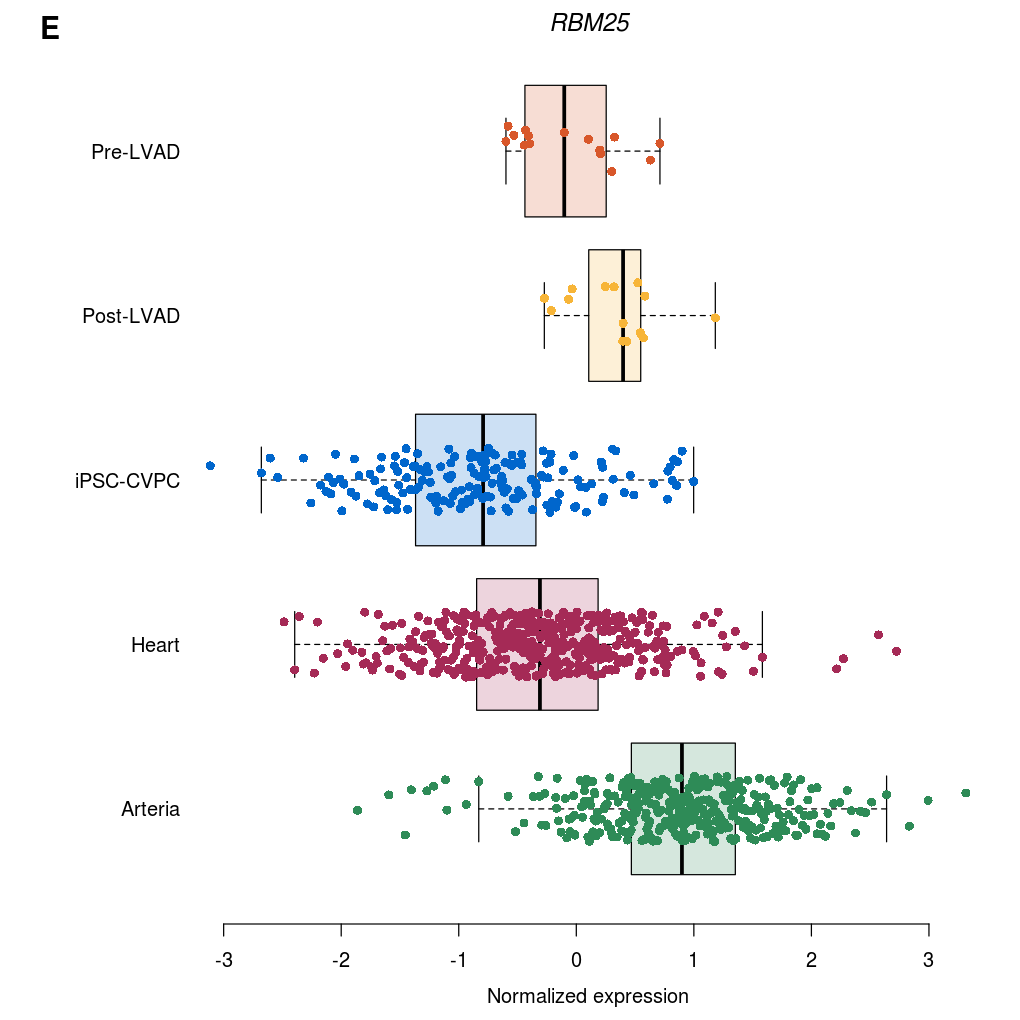

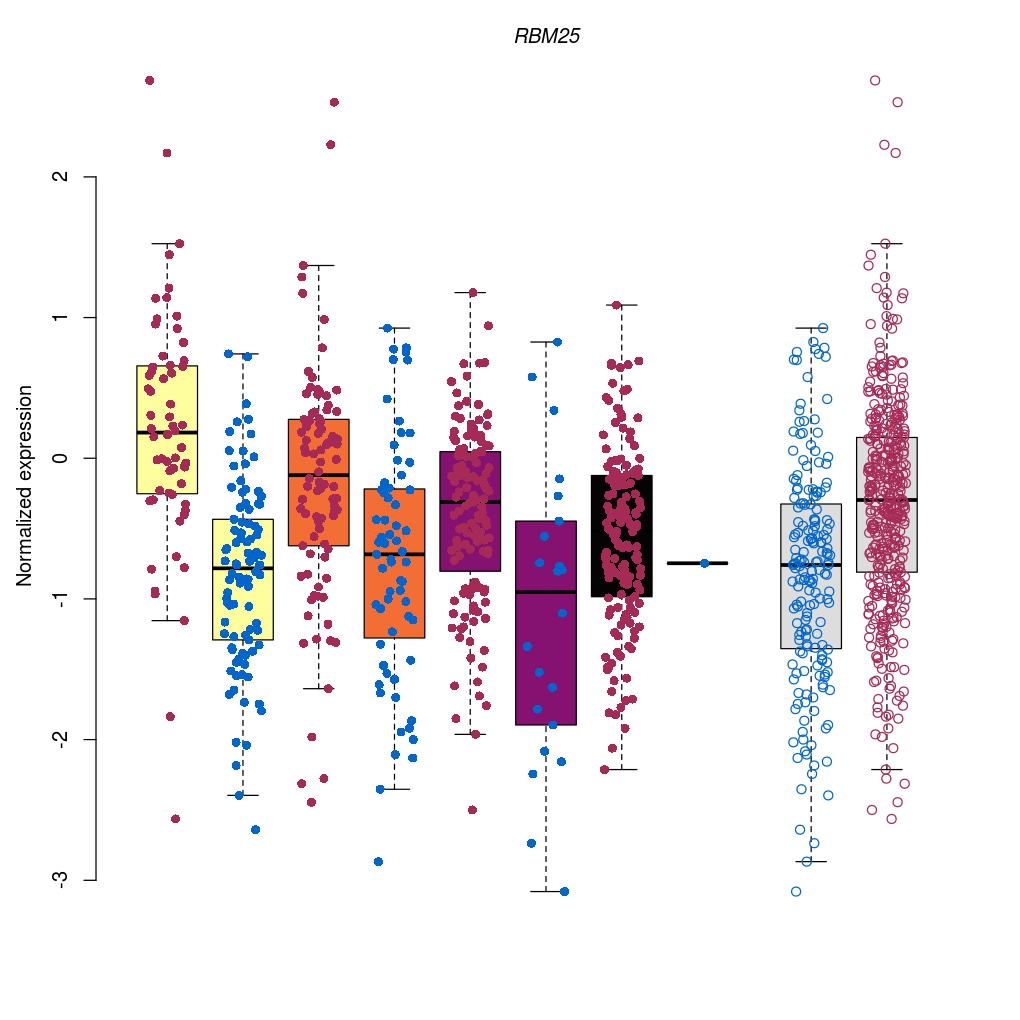

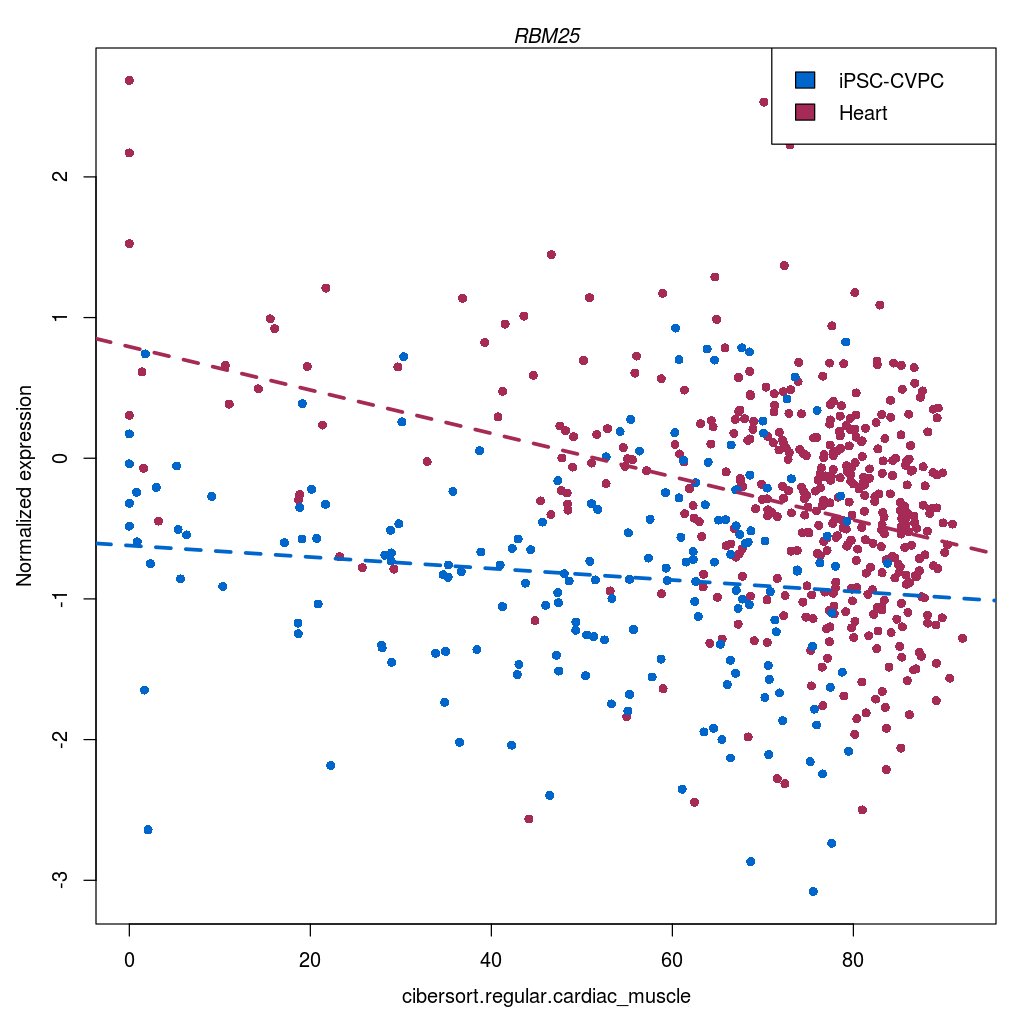

In [1383]:
    figure_diffexp_hf(geneinfo_genes[ geneinfo_genes$gene_name == "RBM25"   , "gene_id"], tpm_hf, pcdata, "E")
plot_stage_vs_cell(geneinfo_genes[geneinfo_genes$gene_name == "RBM25", "transcript_id"], "cibersort.regular.cardiac_muscle", "ipsc_cvpc", "heart", geneinfo_genes, gene_tpm, covariates)


## OLD: Figure S17: Distance of pre- and post-LVAD transcriptome from cardiac stages

In [1736]:
hf2dist_genes    =              fread("pipeline/4.13.heart_failure/hf2dist_all_genes.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
hf2dist_isoforms =              fread("pipeline/4.13.heart_failure/hf2dist_all_isoforms.txt", sep = "\t", header = TRUE, data.table = FALSE)
pcdata_genes     = add_rownames(fread("pipeline/4.13.heart_failure/pcdata_all_genes.txt"    , sep = "\t", header = TRUE, data.table = FALSE))
pcdata_isoforms  = add_rownames(fread("pipeline/4.13.heart_failure/pcdata_all_isoforms.txt" , sep = "\t", header = TRUE, data.table = FALSE))

pcdata_genes   $run = rownames(pcdata_genes   )
pcdata_isoforms$run = rownames(pcdata_isoforms)


ipsc_cvpc 153.989548864099 159.822368574718 5.8328197106182 0.24862273620701

heart 70.2637690436385 69.3411087429115 -0.922660300726915 0.777148820436062

ipsc_cvpc 92.9844033664066 104.258336254035 11.2739328876288 0.0335095174176396

heart 67.9987676541873 63.1315282959829 -4.8672393582044 0.0805602493398778



png 
  2

ipsc_cvpc 153.989548864099 159.822368574718 5.8328197106182 0.24862273620701

heart 70.2637690436385 69.3411087429115 -0.922660300726915 0.777148820436062

ipsc_cvpc 92.9844033664066 104.258336254035 11.2739328876288 0.0335095174176396

heart 67.9987676541873 63.1315282959829 -4.8672393582044 0.0805602493398778



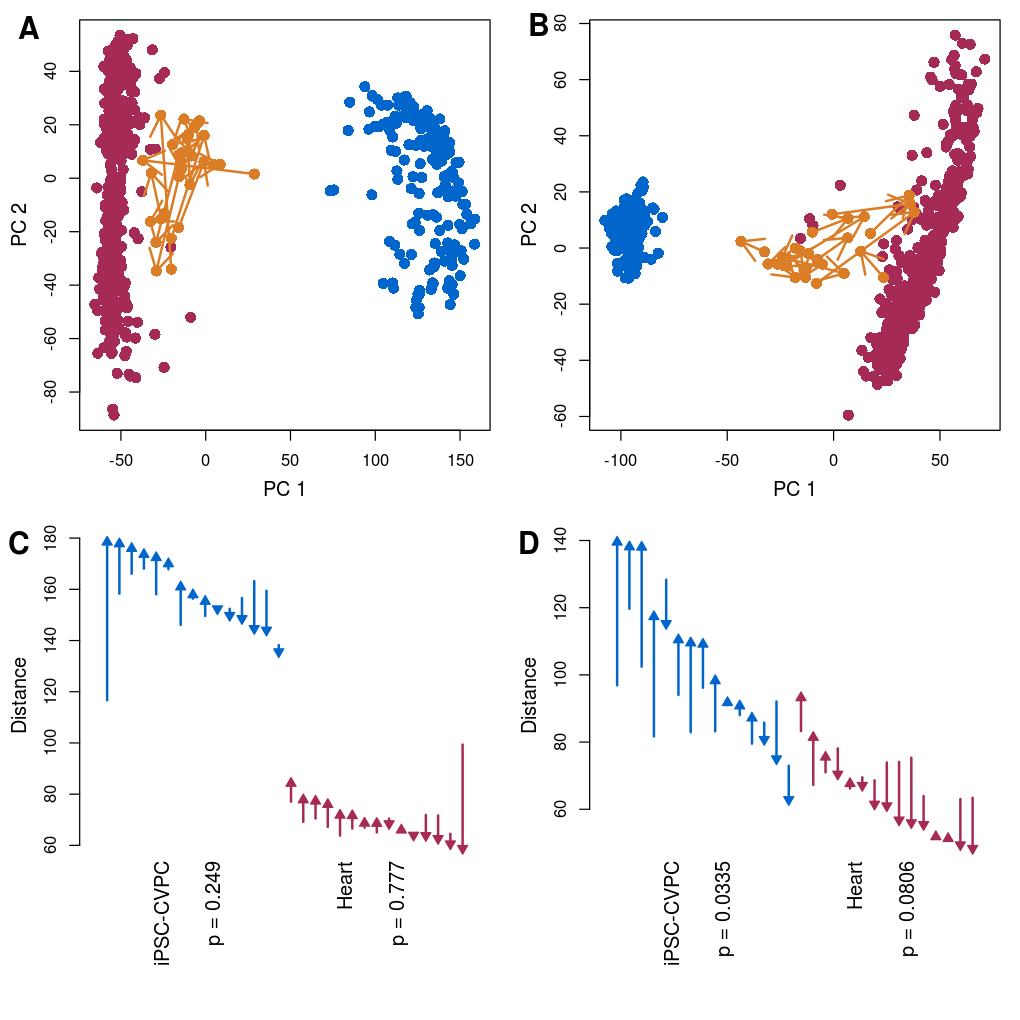

In [1737]:
figure_s17_panel = function(pcdata, hf2dist, panel = "")
{
    color_s2        = data.frame(row.names = c("hf"), 
                                tissue     = c("hf"), 
                                body_site  = c("Heart failure"),
                                color      = c("#db7c26"),
                                order      = 4
                               )
    
    umap2                = pcdata[,c("run", "body_site", paste("PC", 1:10, sep = "_"))]
    colnames(umap2)[[2]] = "tissue"
    umap2[grepl("_pre" , umap2$tissue) == TRUE, "tissue"] = "hf"
    umap2[grepl("_post", umap2$tissue) == TRUE, "tissue"] = "hf"
    
    umap2[umap2$tissue %in% c("atrium", "ventricle"), "tissue"] = "heart"
    umap2[umap2$tissue %in% c("aorta" , "coronary" ), "tissue"] = "arteria"
    
    tissue2color3        = tissue2color3[tissue2color3$tissue != "adult",]
    tissue2color3$order  = c(3,1,2)
    colordata2           = rbind(tissue2color3, color_s2)
    colordata2$tissue    = gsub("arteria_", "", gsub("heart_", "", colordata2$tissue))
    colordata2           = colordata2[order(colordata2$order),]
    
    figure_umap_arrows(hf2dist, umap2, "tissue", colordata2, "PC_1", "PC_2", panel, FALSE)
    
}


figure_s17 = function()
{
    layout(rbind(1:2, 3:4))
    
    figure_s17_panel(pcdata_genes   , hf2dist_genes   , "A")
    figure_s17_panel(pcdata_isoforms, hf2dist_isoforms, "B")
    
    plot_hf2dist(hf2dist_genes   , metadata, "C")
    plot_hf2dist(hf2dist_isoforms, metadata, "D")

}

png(filename = "manuscript/cardiac_differential_expression/figure_S17.png", width = 8.5, height = 8.5, units = "in", res = 300)
figure_s17()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 8.5)
figure_s17()


## OLD - Figure S11: correlation of differential expression between pre- and post-LVAD and between cardiac stages

png 
  2

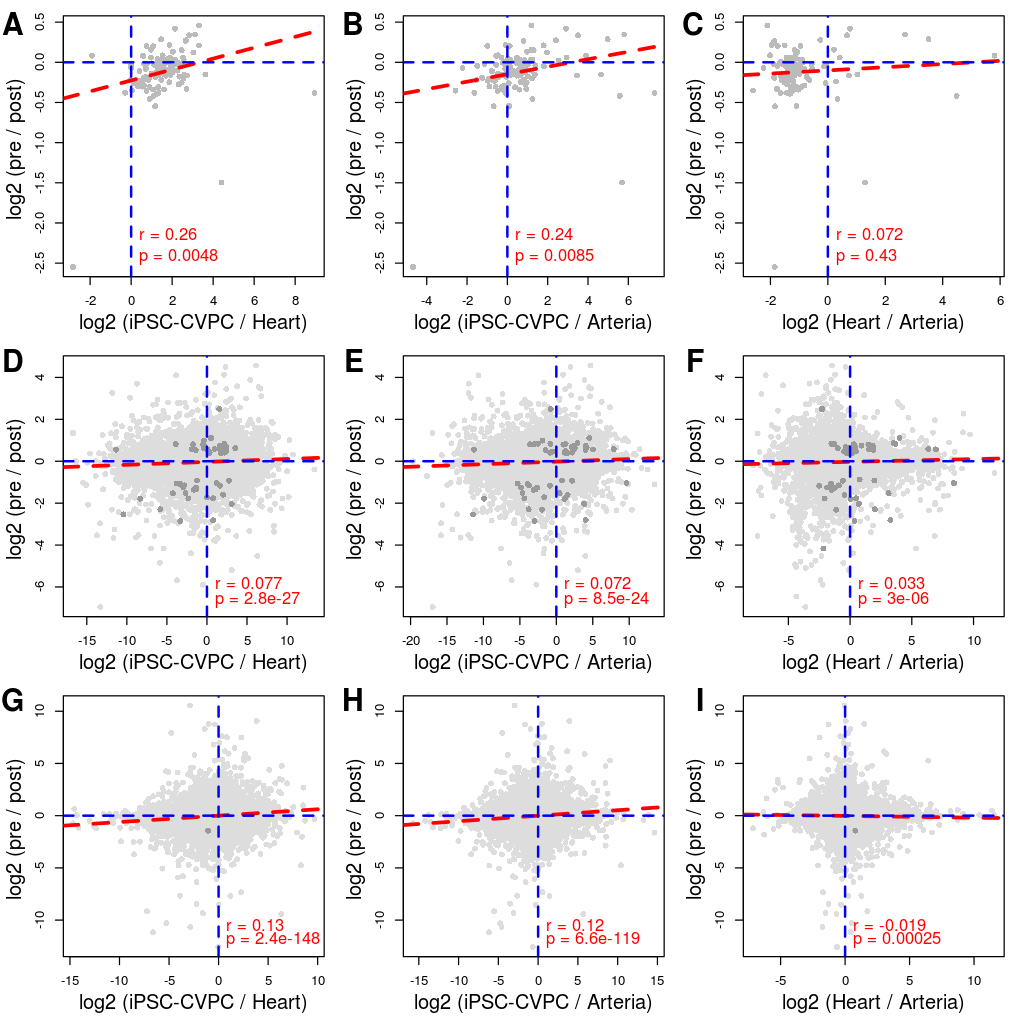

In [1254]:
figure_s11 = function()
{
    layout(matrix(1:9, nrow = 3, byrow = TRUE))
    
    plot_cor_rbp(exp2hf, "ipsc_cvpc", "heart"  , "all", "gene_tpm"   , c(), "A")
    plot_cor_rbp(exp2hf, "ipsc_cvpc", "arteria", "all", "gene_tpm"   , c(), "B")
    plot_cor_rbp(exp2hf, "heart"    , "arteria", "all", "gene_tpm"   , c(), "C")
    plot_cor    (exp2hf, "ipsc_cvpc", "heart"  , "all", "gene_tpm"   , c(), "D")
    plot_cor    (exp2hf, "ipsc_cvpc", "arteria", "all", "gene_tpm"   , c(), "E")
    plot_cor    (exp2hf, "heart"    , "arteria", "all", "gene_tpm"   , c(), "F")
    plot_cor    (exp2hf, "ipsc_cvpc", "heart"  , "all", "isoform_use", c(), "G")
    plot_cor    (exp2hf, "ipsc_cvpc", "arteria", "all", "isoform_use", c(), "H")
    plot_cor    (exp2hf, "heart"    , "arteria", "all", "isoform_use", c(), "I")

}

png(filename = "manuscript/cardiac_differential_expression/figure_S11.png", width = 8.5, height = 8.5, units = "in", res = 300)
figure_s11()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 8.5)
figure_s11()


## Table S11-12: Heart failure data
- S11: PCA and subject data 
- S12: correlation

In [866]:
table_s11 = merge(hf2dist[,c("run", "subject_id", "age", "sex", "lvad_support")], pcdata[,c("run", "body_site", "study", paste("PC", 1:50, sep = "_"))], all.y = TRUE)
table_s11 = rbind(table_s11[is.na(table_s11$subject_id) == FALSE,], table_s11[is.na(table_s11$subject_id) == TRUE,])

table_s11$body_site = suppressMessages(mapvalues(table_s11$body_site, 
                                                 from = c("atrium"          , "ventricle"     , "aorta", "coronary"       , "ischemic_post", "ischemic_pre" , "nonischemic_post", "nonischemic_pre"), 
                                                 to   = c("Atrial appendage", "Left ventricle", "Aorta", "Coronary artery", "Heart failure", "Heart failure", "Heart failure"   , "Heart failure"  )))

table_s11$study     = suppressMessages(mapvalues(table_s11$study, 
                                                 from = c("gtex", "ipscore", "ischemic_post", "ischemic_pre" , "nonischemic_post", "nonischemic_pre"), 
                                                 to   = c("GTEx", "iPSCORE", "GSE46224"     , "GSE46224"     , "GSE46224"        , "GSE46224"       )))

table_s11 = table_s11[,c("run", "body_site", "study", "subject_id", "age", "sex", "lvad_support", paste("PC", 1:50, sep = "_"))]

colnames(table_s11) = c("Run", "Tissue", "Study", "Subject ID", "Age", "Sex", "LVAD status", paste("PC", 1:50, sep = " "))

fwrite(table_s11, "manuscript/cardiac_differential_expression/table_s11.csv", sep = ",", col.names = TRUE, row.names = FALSE)


In [876]:
table_s12 = fread("pipeline/4.13.heart_failure/diffexp_vs_heart_failure.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
table_s12 = unique(table_s12[ table_s12$disease == "all",c("transcript_id", "gene_id", "gene_name", "rbp", "type", "log2r2", "pval2", "fdr")])
table_s12[table_s12$type == "gene_tpm", "transcript_id"] = ""
table_s12$type     = suppressMessages(mapvalues(table_s12$type, from = c("gene_tpm", "isoform_use"), to = c("Gene", "Isoform")))

colnames(table_s12) = c("Transcript ID", "Gene ID", "Gene name", "RBP", "Type", "log2 (pre-LVAD / post-LVAD)", "P-value (paired t-test)", "FDR (Benjamini-Hochberg)")

fwrite(table_s12, "manuscript/cardiac_differential_expression/table_s12.csv", sep = ",", col.names = TRUE, row.names = FALSE)


# T2D meeting (2020-12-14)

In [1230]:
dir.create("manuscript/t2d_meeting_2020_12_14", showWarnings = FALSE)

In [1235]:
png(filename = "manuscript/t2d_meeting_2020_12_14/figure_1.png", width = 7, height = 7, units = "in", res = 300)

options(repr.plot.width = 8.5, repr.plot.height = 8.5)
layout(rbind(c(1,1,2,2,2,3), rep(4, 6), rep(4, 6)))

tissue2color_x      = tissue2color
tissue2color_x$tissue = gsub("heart_", "", gsub("arteria_", "", tissue2color_x$tissue))
tissue2color_x$x   = c(10  ,  0  ,   0  ,  -9  , -5  )
tissue2color_x$y   = c( 5.5, -7.5, -12.5,   6.5,  8  )
tissue2color_x$pos = c( 2  ,  2  , 2    ,   1  ,  4  )
figure_s1a()
figure_s1c()
figure_umap(umap_bulk, "tissue", tissue2color_x, "", TRUE)

dev.off()

png 
  2

In [1323]:
png(filename = "manuscript/t2d_meeting_2020_12_14/figure_2a.png", width = 12, height = 5, units = "in", res = 300)

options(repr.plot.width = 12, repr.plot.height = 5)
layout(rbind(c(1,2,3)))
volcano_plot_log2r(diftiss, "ipsc_cvpc", "heart", "")
volcano_plot_log2r(diftiss, "ipsc_cvpc", "arteria", "")
volcano_plot_log2r(diftiss, "heart"    , "arteria", "")

dev.off()

png 
  2

In [1305]:
png(filename = "manuscript/t2d_meeting_2020_12_14/figure_2b.png", width = 12, height = 5, units = "in", res = 300)

options(repr.plot.width = 12, repr.plot.height = 5)
layout(rbind(c(1,2,3)))
       
volcano_plot_rbp  (diftiss, "ipsc_cvpc", "heart", toshow, "")

figure_s6_panel(geneinfo_genes[ geneinfo_genes$gene_name == "IGF2BP1", "gene_id"], "")
figure_s6_panel(geneinfo_genes[ geneinfo_genes$gene_name == "RBM4"   , "gene_id"], "")

dev.off()

png 
  2

In [1311]:
png(filename = "manuscript/t2d_meeting_2020_12_14/figure_3a.png", width = 12, height = 5, units = "in", res = 300)

options(repr.plot.width = 12, repr.plot.height = 5)
layout(rbind(c(1,1,1,2,2,3), c(1,1,1,4,4,5)))

figure_2a("")

figure_s7x(geneinfo_genes[ geneinfo_genes$gene_name == "CRB2", "gene_id"], "", TRUE)
figure_s7x(geneinfo_genes[ geneinfo_genes$gene_name == "NME7", "gene_id"], "", TRUE)


dev.off()

png 
  2

In [1313]:
png(filename = "manuscript/t2d_meeting_2020_12_14/figure_3b.png", width = 12, height = 5, units = "in", res = 300)

options(repr.plot.width = 12, repr.plot.height = 5)
layout(rbind(c(2,1,1)))

dif2rbp1  = prepare_stage2exp("ipsc_cvpc", "ipsc_cvpc", "heart")
dif2rbp2 = prepare_stage2exp("heart"    , "ipsc_cvpc", "heart")
plot_stage2exp   (dif2rbp1, dif2rbp2, "ipsc_cvpc", "heart", "", FALSE)
plot_dif2tis(dif2rbp1$diftiss, "ipsc_cvpc", "heart", "", TRUE)

dev.off()

png 
  2

In [1249]:
png(filename = "manuscript/t2d_meeting_2020_12_14/figure_4.png", width = 24, height = 10, units = "in", res = 300)

options(repr.plot.width = 12, repr.plot.height = 5)
layout(cbind(c(1,1,2,3), 4:7))

plot_logo2("ipsc_cvpc", "ipsc_cvpc", "heart"  , xlims = c(-50, 20), c("", "", ""), TRUE )
plot_logo2("ipsc_cvpc", "ipsc_cvpc", "arteria", xlims = c(-50, 20), c("", "", ""), FALSE)
plot_logo2("heart"    , "heart"    , "arteria", xlims = c(-50, 20), c("", "", ""), FALSE)

dev.off()


png 
  2

In [1317]:
png(filename = "manuscript/t2d_meeting_2020_12_14/figure_5a.png", width = 12, height = 5, units = "in", res = 300)

options(repr.plot.width = 8, repr.plot.height = 5)
layout(rbind(c(1,1,2)))



color_s2        = data.frame(row.names = c("hf"), 
                            tissue     = c("hf"), 
                            body_site  = c("Heart failure"),
                            color      = c("#db7c26"),
                            order      = 4
                           )

umap2                = pcdata[,c("run", "body_site", "UMAP_1", "UMAP_2", paste("PC", 1:10, sep = "_"))]
colnames(umap2)[[2]] = "tissue"
umap2[grepl("_pre" , umap2$tissue) == TRUE, "tissue"] = "hf"
umap2[grepl("_post", umap2$tissue) == TRUE, "tissue"] = "hf"

umap2[umap2$tissue %in% c("atrium", "ventricle"), "tissue"] = "heart"
umap2[umap2$tissue %in% c("aorta" , "coronary" ), "tissue"] = "arteria"

tissue2color3_x        = tissue2color3[tissue2color3$tissue != "adult",]
tissue2color3_x$order  = c(3,1,2)
colordata2             = rbind(tissue2color3_x, color_s2)
colordata2$tissue      = gsub("arteria_", "", gsub("heart_", "", colordata2$tissue))
colordata2             = colordata2[order(colordata2$order),]


figure_umap_arrows(hf2dist, umap2, "tissue", colordata2, "PC_1", "PC_2", "", TRUE)
plot_hf2dist(hf2dist, metadata, "")


dev.off()


arteria 15.7171341814352 12.0453071324235 -3.67182704901178 0.000767223653116111

heart 13.4306324166624 11.9809167821094 -1.44971563455298 0.00157671317602503

ipsc_cvpc 16.8205506278798 22.1924796197577 5.37192899187789 0.000132060312280905



png 
  2

In [1322]:
png(filename = "manuscript/t2d_meeting_2020_12_14/figure_5b.png", width = 12, height = 7, units = "in", res = 300)

options(repr.plot.width = 12, repr.plot.height = 7)
layout(rbind(c(1,3),c(2,4)))


plot_cor_rbp(exp2hf, "ipsc_cvpc", "heart", "all", "gene_tpm"   , c("ZFP36", "IGF2BP3", "ESRP1", "RBM38", "RBM24"), "")
plot_cor    (exp2hf, "ipsc_cvpc", "heart", "all", "gene_tpm"   , c("DPF3", "GADD45G", "PITX3", "TANGO2", "MYL7" ), "")
figure_diffexp_hf(geneinfo_genes[ geneinfo_genes$gene_name == "ESRP1", "gene_id"], tpm_hf, pcdata, "")
figure_diffexp_hf(geneinfo_genes[ geneinfo_genes$gene_name == "PITX3", "gene_id"], tpm_hf, pcdata, "")

dev.off()


png 
  2

# Figure 6 OLD


png 
  2

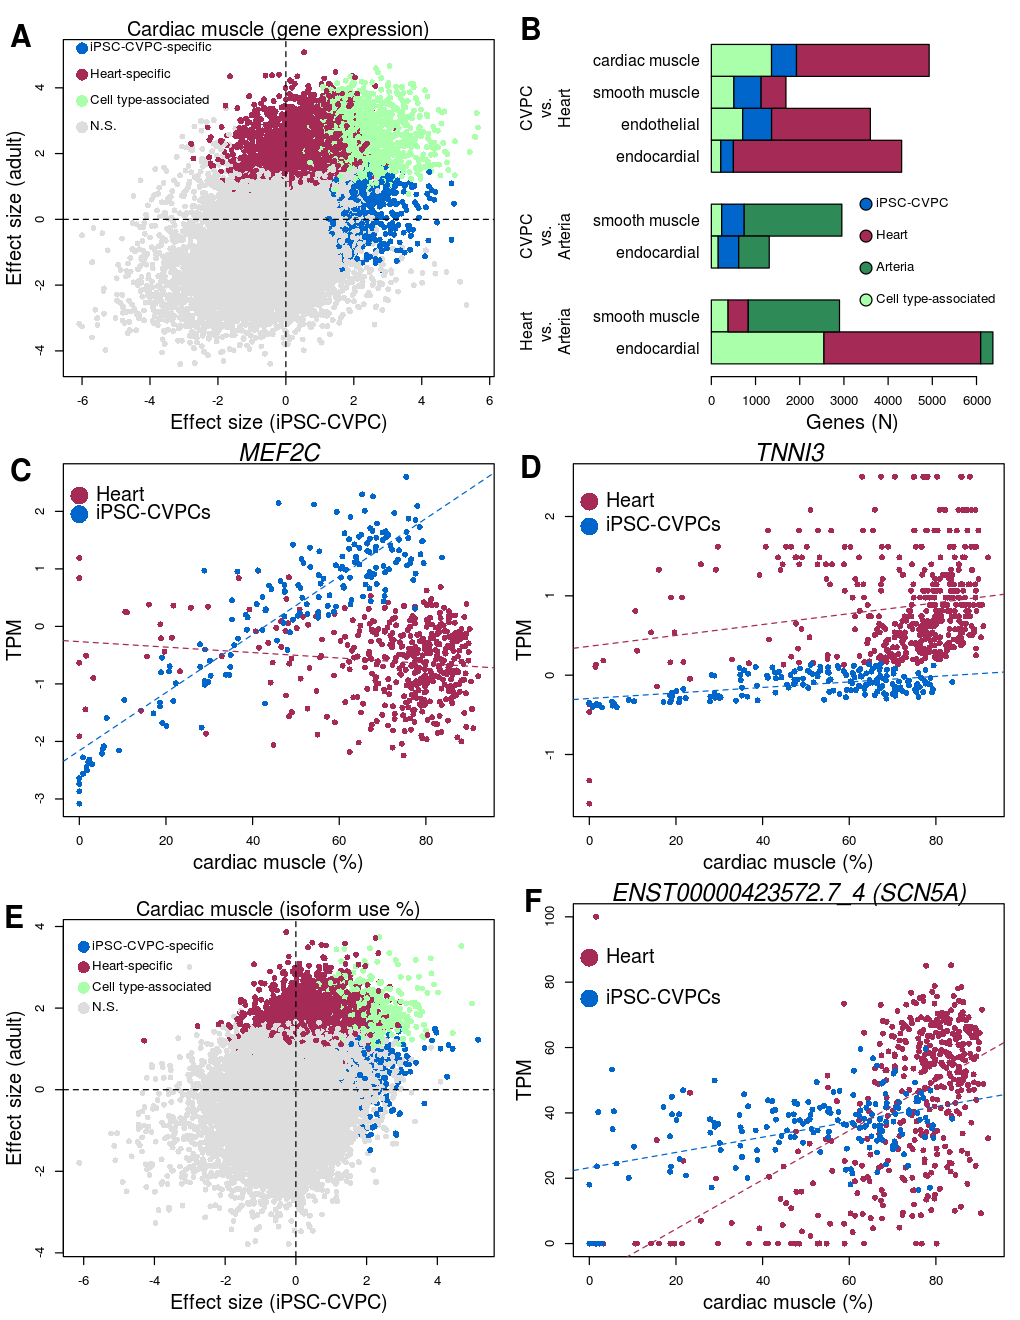

In [561]:
figure_s11_cell = function(gene_id, cell, panel = "", legend = FALSE)
{
    tissue2color3          = tissue2color3[tissue2color3$tissue %in% c("ipsc_cvpc", "heart"),]
    expdata                = data.frame(assay_id = colnames(gene_tpm), exp = as.numeric(gene_tpm[gene_id,]))
    colnames(expdata)[[2]] = "exp"
    expdata                = merge(expdata, metadata  [,c("run", "study", "tissue", "body_site")], by.x = "assay_id", by.y = "run")
    expdata                = merge(expdata, covariates[,c("run", cell)], by.x = "assay_id", by.y = "run")
    expdata$cell           = expdata[,cell] * 100
    this                   = expdata
    this                   = merge(this, tissue2color3[,c("tissue", "color")])
    
    par(mar = c(4,4,1.5,1))
    plot(this$cell, this$exp, pch = 16, col = this$color, axes = TRUE, xlab = "", ylab = "")

    cell2axis = paste(gsub("_", " ", paste(sub("cibersort.regular\\.", "", cell))), "(%)")
    
    mtext(text = panel                                                          , side = 2, line = 2  , at = max(this$exp) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = cell2axis                                                      , side = 1, line = 2.5)
    mtext(text = "TPM"                                                          , side = 2, line = 2.5)
    mtext(text = geneinfo_genes[ geneinfo_genes$gene_id == gene_id, "gene_name"], side = 3, line = 0  , font = 3, cex = 1.2)
    
    for(tissue in tissue2color3[tissue2color3$tissue != "adult", "tissue"])
    {
        tox = this[this$tissue == tissue,]
        abline(lm(exp ~ cell, data = tox), col = tissue2color3[tissue2color3$tissue == tissue, "color"], lty = "dashed")
    }
    
    if(legend == TRUE)
    {
        colordata = tissue2color3[c("ipsc_cvpc" , "heart"),]
        points(x = rep(0, nrow(colordata)), y = (1:nrow(colordata) + 5) / (nrow(colordata) + 6) * max(this$exp), cex = 3  , pch = 16, col = colordata$color)
        text  (x = rep(2, nrow(colordata)), y = (1:nrow(colordata) + 5) / (nrow(colordata) + 6) * max(this$exp), cex = 1.5, labels = colordata$body_site, pos = 4)
    }
}

figure_s11_cell2 = function(x, cell, panel = "", legend = FALSE)
{
    tissue2color3          = tissue2color3[tissue2color3$tissue %in% c("ipsc_cvpc", "heart"),]
    expdata                = data.frame(assay_id = colnames(isof_use), exp = as.numeric(isof_use[x,]))
    colnames(expdata)[[2]] = "exp"
    expdata                = merge(expdata, metadata  [,c("run", "study", "tissue", "body_site")], by.x = "assay_id", by.y = "run")
    expdata                = merge(expdata, covariates[,c("run", cell)], by.x = "assay_id", by.y = "run")
    expdata$cell           = expdata[,cell] * 100
    this                   = expdata
    this                   = merge(this, tissue2color3[,c("tissue", "color")])
    
    par(mar = c(4,4,1.5,1))
    plot(this$cell, this$exp, pch = 16, col = this$color, axes = TRUE, xlab = "", ylab = "")

    cell2axis = paste(gsub("_", " ", paste(sub("cibersort.regular\\.", "", cell))), "(%)")
    
    mtext(text = panel                                                          , side = 2, line = 2  , at = max(this$exp) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = cell2axis                                                      , side = 1, line = 2.5)
    mtext(text = "TPM"                                                          , side = 2, line = 2.5)
    mtext(text = paste(x, " (", geneinfo_isoforms[ geneinfo_isoforms$transcript_id == x, "gene_name"], ")", sep = ""), side = 3, line = 0  , font = 3, cex = 1.2)
    
    for(tissue in tissue2color3[tissue2color3$tissue != "adult", "tissue"])
    {
        tox = this[this$tissue == tissue,]
        abline(lm(exp ~ cell, data = tox), col = tissue2color3[tissue2color3$tissue == tissue, "color"], lty = "dashed")
    }
    
    if(legend == TRUE)
    {
        colordata = tissue2color3[c("ipsc_cvpc" , "heart"),]
        points(x = rep(0, nrow(colordata)), y = (1:nrow(colordata) + 5) / (nrow(colordata) + 6) * max(this$exp), cex = 3  , pch = 16, col = colordata$color)
        text  (x = rep(2, nrow(colordata)), y = (1:nrow(colordata) + 5) / (nrow(colordata) + 6) * max(this$exp), cex = 1.5, labels = colordata$body_site, pos = 4)
    }
}

figure_5a = function()
{
    difct_cm$color = "#dddddd"
    difct_cm[difct_cm$beta1 > 0 & difct_cm$qval1 <= 0.05 & difct_cm$qval2 > 0.05, "color"] = tissue2color3["ipsc_cvpc", "color"]
    difct_cm[difct_cm$beta2 > 0 & difct_cm$qval2 <= 0.05 & difct_cm$qval1 > 0.05, "color"] = tissue2color3["heart"    , "color"]
    difct_cm[difct_cm$beta1 > 0 & difct_cm$qval1 <= 0.05 & difct_cm$beta2 > 0 & difct_cm$qval2 <= 0.05, "color"] = "#aaffaa"
    
    par(mar = c(4,4,2.5,1))
    plot(difct_cm$beta1, difct_cm$beta2, pch = 16, col = difct_cm$color, xlab = "", ylab = "")
    mtext(text = "Cardiac muscle (gene expression)", side = 3, line = 0  )
    mtext(text = "Effect size (adult)"             , side = 2, line = 2.5)
    mtext(text = "Effect size (iPSC-CVPC)"         , side = 1, line = 2.5)
    mtext(text = "A"                               , side = 2, line = 2  , at = max(difct_cm$beta2) * 1.1, font = 2, cex = 1.5, las = 2)

    points(x = rep(-6, 4), y = 6 - (1:4) * 0.8, pch = 16, col = c(tissue2color3["ipsc_cvpc", "color"], tissue2color3["heart", "color"], "#aaffaa", "#dddddd"), cex = 2)
    text  (x = rep(-6, 4), y = 6 - (1:4) * 0.8, labels = c("iPSC-CVPC-specific", "Heart-specific", "Cell type-associated", "N.S."), pos = 4)
    
    abline(h = 0, lty = "dashed")
    abline(v = 0, lty = "dashed")
}

figure_5b = function()
{
    difct_comb$n = rowSums(difct_comb[, c("both", "tissue1_n", "tissue2_n")])
    
    par(mar = c(4,12,2,1))
    plot(1,1, type = "n", xlim = c(0, max(difct_comb$n)), ylim = c(max(difct_comb$y), 0), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    
    rect(xleft = 0                                            , xright = difct_comb$both                                           , ybottom = difct_comb$y -1, ytop = difct_comb$y, col = "#aaffaa")
    rect(xleft = difct_comb$both                              , xright = rowSums(difct_comb[, c("both", "tissue1_n"             )]), ybottom = difct_comb$y -1, ytop = difct_comb$y, col = tissue2color3[difct_comb$tissue1, "color"])
    rect(xleft = rowSums(difct_comb[, c("both", "tissue1_n")]), xright = rowSums(difct_comb[, c("both", "tissue1_n", "tissue2_n")]), ybottom = difct_comb$y -1, ytop = difct_comb$y, col = tissue2color3[difct_comb$tissue2, "color"])
    
    mtext(text = gsub("_", " ", difct_comb$cell_type)                              , side = 2, line = 0, at = difct_comb$y - 0.5, cex = 0.8, las = 2)
    mtext(text = c("CVPC\nvs.\nHeart", "CVPC\nvs.\nArteria", "Heart\nvs.\nArteria"), side = 2, line = 8, at = c(2, 6, 9)        , cex = 0.8)
    
    points(x = rep(3500, 4), y = 1:4 + 4, bg = c(tissue2color3[c("ipsc_cvpc" , "heart", "arteria"), "color"], "#aaffaa"), pch = 21, cex = 2)
    text  (x = rep(3550, 4), y = 1:4 + 4, labels = c("iPSC-CVPC", "Heart", "Arteria", "Cell type-associated"), pos = 4)
    
    mtext(text = "B"        , side = 2, line = 10  , at = -0.5, font = 2, cex = 1.5, las = 2)
    mtext(text = "Genes (N)", side = 1, line =  2.5)
}


figure_5e = function()
{
    diffct_iso_cm$color = "#dddddd"
    diffct_iso_cm[diffct_iso_cm$beta1 > 0 & diffct_iso_cm$qval1 <= 0.05 & diffct_iso_cm$qval2 > 0.05, "color"] = tissue2color3["ipsc_cvpc", "color"]
    diffct_iso_cm[diffct_iso_cm$beta2 > 0 & diffct_iso_cm$qval2 <= 0.05 & diffct_iso_cm$qval1 > 0.05, "color"] = tissue2color3["heart"    , "color"]
    diffct_iso_cm[diffct_iso_cm$beta1 > 0 & diffct_iso_cm$qval1 <= 0.05 & diffct_iso_cm$beta2 > 0 & diffct_iso_cm$qval2 <= 0.05, "color"] = "#aaffaa"
    
    par(mar = c(4,4,2.5,1))
    plot(diffct_iso_cm$beta1, diffct_iso_cm$beta2, pch = 16, col = diffct_iso_cm$color, xlab = "", ylab = "")
    mtext(text = "Cardiac muscle (isoform use %)", side = 3, line = 0  )
    mtext(text = "Effect size (adult)"           , side = 2, line = 2.5)
    mtext(text = "Effect size (iPSC-CVPC)"       , side = 1, line = 2.5)
    mtext(text = "E"                             , side = 2, line = 2.5, at = max(diffct_iso_cm$beta2) * 1.1, font = 2, cex = 1.5, las = 2)

    points(x = rep(-6, 4), y = 4 -(1:4) * 0.5, pch = 16, col = c(tissue2color3["ipsc_cvpc", "color"], tissue2color3["heart", "color"], "#aaffaa", "#dddddd"), cex = 2)
    text  (x = rep(-6, 4), y = 4 -(1:4) * 0.5, labels = c("iPSC-CVPC-specific", "Heart-specific", "Cell type-associated", "N.S."), pos = 4)
    
    abline(h = 0, lty = "dashed")
    abline(v = 0, lty = "dashed")
}

figure_5 = function()
{
    layout(matrix(1:6, nrow = 3, byrow = TRUE))
    
    figure_5a()
    figure_5b()
    figure_s11_cell (geneinfo_genes[ geneinfo_genes$gene_name == "MEF2C"  , "gene_id"], "cibersort.regular.cardiac_muscle", "C", TRUE)
    figure_s11_cell (geneinfo_genes[ geneinfo_genes$gene_name == "TNNI3"  , "gene_id"], "cibersort.regular.cardiac_muscle", "D", TRUE)
    figure_5e()
    figure_s11_cell2("ENST00000423572.7_4" , "cibersort.regular.cardiac_muscle", "F", TRUE)

}

png(filename = "manuscript/cardiac_differential_expression/figure_5.png", width = 8.5, height = 11, units = "in", res = 300)
figure_5()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 11)
figure_5()



## Figure S14: Examples of genes associated with cell type proportions only at one developmental stage


png 
  2

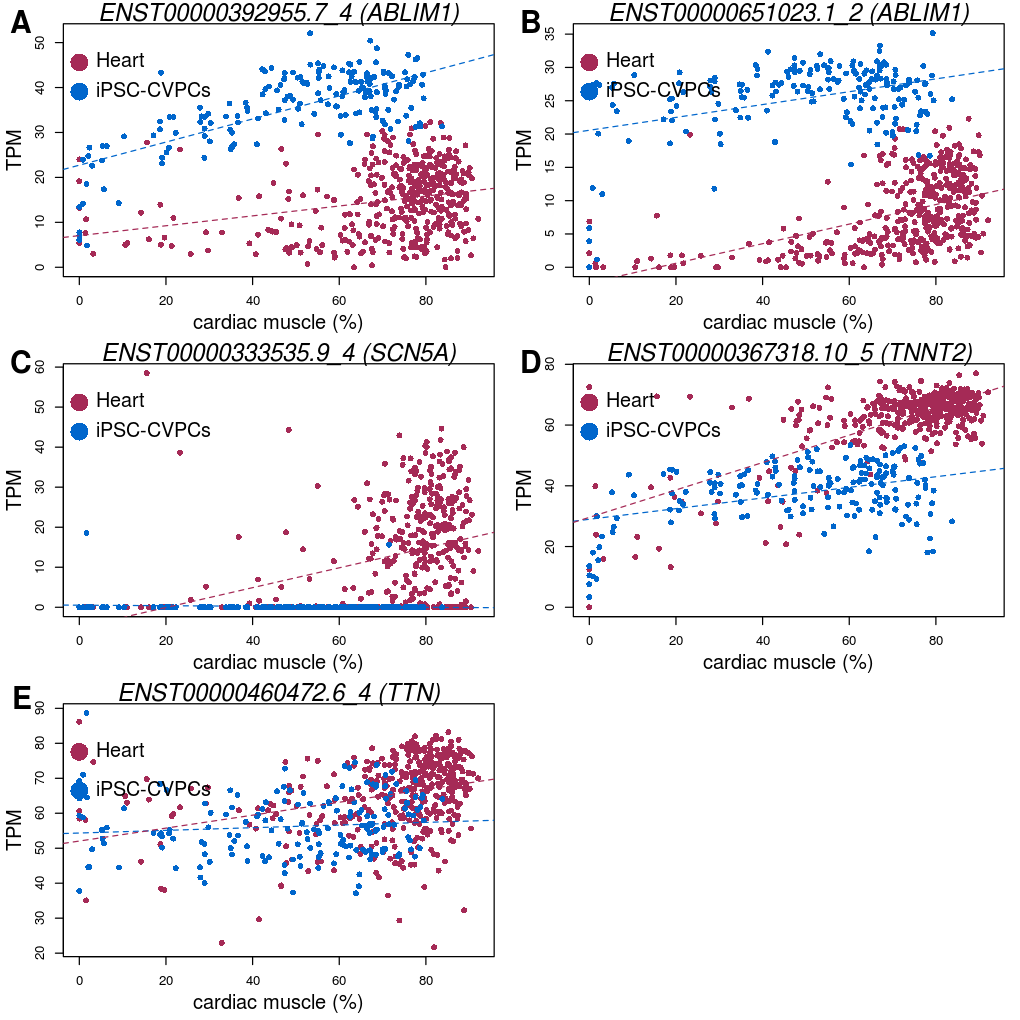

In [565]:
figure_s14_cell = function(gene_id, cell, panel = "", legend = FALSE)
{
    tissue2color3          = tissue2color3[tissue2color3$tissue %in% c("ipsc_cvpc", "heart"),]
    expdata                = data.frame(assay_id = colnames(gene_tpm), exp = as.numeric(gene_tpm[gene_id,]))
    colnames(expdata)[[2]] = "exp"
    expdata                = merge(expdata, metadata  [,c("run", "study", "tissue", "body_site")], by.x = "assay_id", by.y = "run")
    expdata                = merge(expdata, covariates[,c("run", cell)], by.x = "assay_id", by.y = "run")
    expdata$cell           = expdata[,cell] * 100
    this                   = expdata
    this                   = merge(this, tissue2color3[,c("tissue", "color")])
    
    par(mar = c(4,4,1.5,1))
    plot(this$cell, this$exp, pch = 16, col = this$color, axes = TRUE, xlab = "", ylab = "")

    cell2axis = paste(gsub("_", " ", paste(sub("cibersort.regular\\.", "", cell))), "(%)")
    
    mtext(text = panel                                                          , side = 2, line = 2  , at = max(this$exp) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = cell2axis                                                      , side = 1, line = 2.5)
    mtext(text = "TPM"                                                          , side = 2, line = 2.5)
    mtext(text = geneinfo_genes[ geneinfo_genes$gene_id == gene_id, "gene_name"], side = 3, line = 0  , font = 3, cex = 1.2)
    
    for(tissue in tissue2color3[tissue2color3$tissue != "adult", "tissue"])
    {
        tox = this[this$tissue == tissue,]
        abline(lm(exp ~ cell, data = tox), col = tissue2color3[tissue2color3$tissue == tissue, "color"], lty = "dashed")
    }
    
    if(legend == TRUE)
    {
        colordata = tissue2color3[c("ipsc_cvpc" , "heart"),]
        points(x = rep(0, nrow(colordata)), y = (1:nrow(colordata) + 5) / (nrow(colordata) + 6) * max(this$exp), cex = 3  , pch = 16, col = colordata$color)
        text  (x = rep(2, nrow(colordata)), y = (1:nrow(colordata) + 5) / (nrow(colordata) + 6) * max(this$exp), cex = 1.5, labels = colordata$body_site, pos = 4)
    }
}

figure_s14_cell2 = function(x, cell, panel = "", legend = FALSE)
{
    tissue2color3          = tissue2color3[tissue2color3$tissue %in% c("ipsc_cvpc", "heart"),]
    expdata                = data.frame(assay_id = colnames(isof_use), exp = as.numeric(isof_use[x,]))
    colnames(expdata)[[2]] = "exp"
    expdata                = merge(expdata, metadata  [,c("run", "study", "tissue", "body_site")], by.x = "assay_id", by.y = "run")
    expdata                = merge(expdata, covariates[,c("run", cell)], by.x = "assay_id", by.y = "run")
    expdata$cell           = expdata[,cell] * 100
    this                   = expdata
    this                   = merge(this, tissue2color3[,c("tissue", "color")])
    
    par(mar = c(4,4,1.5,1))
    plot(this$cell, this$exp, pch = 16, col = this$color, axes = TRUE, xlab = "", ylab = "")

    cell2axis = paste(gsub("_", " ", paste(sub("cibersort.regular\\.", "", cell))), "(%)")
    
    mtext(text = panel                                                          , side = 2, line = 2  , at = max(this$exp) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = cell2axis                                                      , side = 1, line = 2.5)
    mtext(text = "TPM"                                                          , side = 2, line = 2.5)
    mtext(text = paste(x, " (", geneinfo_isoforms[ geneinfo_isoforms$transcript_id == x, "gene_name"], ")", sep = ""), side = 3, line = 0  , font = 3, cex = 1.2)
    
    for(tissue in tissue2color3[tissue2color3$tissue != "adult", "tissue"])
    {
        tox = this[this$tissue == tissue,]
        abline(lm(exp ~ cell, data = tox), col = tissue2color3[tissue2color3$tissue == tissue, "color"], lty = "dashed")
    }
    
    if(legend == TRUE)
    {
        colordata = tissue2color3[c("ipsc_cvpc" , "heart"),]
        points(x = rep(0, nrow(colordata)), y = (1:nrow(colordata) + 5) / (nrow(colordata) + 6) * max(this$exp), cex = 3  , pch = 16, col = colordata$color)
        text  (x = rep(2, nrow(colordata)), y = (1:nrow(colordata) + 5) / (nrow(colordata) + 6) * max(this$exp), cex = 1.5, labels = colordata$body_site, pos = 4)
    }
}

figure_s14 = function()
{
    layout(matrix(1:6, nrow = 3, byrow = TRUE))
    figure_s14_cell2("ENST00000392955.7_4" , "cibersort.regular.cardiac_muscle", "A", TRUE)
    figure_s14_cell2("ENST00000651023.1_2" , "cibersort.regular.cardiac_muscle", "B", TRUE)
    figure_s14_cell2("ENST00000333535.9_4" , "cibersort.regular.cardiac_muscle", "C", TRUE)
    figure_s14_cell2("ENST00000367318.10_5", "cibersort.regular.cardiac_muscle", "D", TRUE)
    figure_s14_cell2("ENST00000460472.6_4" , "cibersort.regular.cardiac_muscle", "E", TRUE)

}

png(filename = "manuscript/cardiac_differential_expression/figure_S14.png", width = 8.5, height = 8.5, units = "in", res = 300)
figure_s14()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 8.5)
figure_s14()

# OLD
# Figure 3: splice site

In [ ]:
figure_2a = function(panel = "")
{
    this = diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart",]
    
    this$filter = 0
    this[this$diffexp == TRUE, "filter"] = 1
    #this[this$diffexp == TRUE & abs(this$log2r) >= 1, "filter"] = 2
    this[this$diffexp == TRUE & abs(this$log2r) >= 2, "filter"] = 4
    #this[this$diffexp == TRUE & abs(this$log2r) >= 3, "filter"] = 4
    
    filter2color = data.frame(filter = 0:4, filter_label = c("N.S.", "FDR < 0.05", paste("log2r >", 1:3)), color = c("#888888", sequential_hcl(4, palette = "plasma", rev = TRUE)))
    
    this = merge(this, filter2color)
    this = this[order(this$filter, decreasing = FALSE),]
    
    this$color = paste(this$color, "33", sep = "")
    
    par(mar = c(4,4,2.5,1))
    plot(this$tissue1_exp, this$tissue2_exp, col = this$color, xlim = c(0,100), ylim = c(-5,110), pch = 16, xlab = "", ylab = "")
    
    toplot = this[this$gene_name %in% c("TNNT2", "SCN5A", "TTN", "ABLIM1", "NME7", "CRB2") & this$diffexp == TRUE & (this$tissue1_exp > 5 | this$tissue2_exp > 5),]
    toplot$pos = 3
    #toplot[toplot$log2r_filter == TRUE & toplot$beta < 0, "pos"] = 4
    toplot[toplot$tissue2_exp < 5 & toplot$gene_name != "NME7", "pos"] = 1

    points(toplot$tissue1_exp, toplot$tissue2_exp, bg     = toplot$color, pch = 21, cex = 1.5)
    text  (toplot$tissue1_exp, toplot$tissue2_exp, labels = toplot$gene_name, pos = toplot$pos, font = 3)
    
    mtext(text = panel                              , side = 2, line = 2, at = 110 * 1.1, font = 2, cex = 1.5, las = 2)
    mtext(text = "Mean isoform use (%, adult heart)", side = 2, line = 2.5)
    mtext(text = "Mean isoform use (%, iPSC-CVPC)"  , side = 1, line = 2.5)
    
    abline(h = 100)
    
    filter2color = filter2color[filter2color$filter %in% c(0,1,4),]

    points(x = c(0, 40, 40)    , y = c(110, 110, 105), bg     = filter2color$color       , pch = 21, cex = 2)
    text  (x = c(0, 40, 40) + 2, y = c(110, 110, 105), labels = c("N.S.", "Stage-associated", "Stage-specific"), pos = 4)
}

figure_s5_panel = function(gene_id, panel = "")
{
    expdata                = data.frame(assay_id = colnames(gene_tpm), exp = as.numeric(gene_tpm[gene_id,]))
    colnames(expdata)[[2]] = "exp"
    expdata                = merge(expdata, metadata[,c("run", "study", "tissue", "body_site")], by.x = "assay_id", by.y = "run")
    tissue2y               = tissue2color3[tissue2color3$tissue != "adult",]
    tissue2y               = tissue2y[order(tissue2y$tissue),]
    tissue2y$y             = 1:nrow(tissue2y)
    this                   = expdata
    this                   = merge(this, tissue2y[,c("tissue", "y", "color")])
    this$y                 = jitter(this$y - 0.5, factor = 1)

    par(mar = c(4,7.5,1.5,1))
    plot(1,1, type = "n", xlim = range(this$exp), ylim = c(0, max(tissue2y$y)), axes = FALSE, xlab = "", ylab = "")

    axis(1)

    boxplot(exp ~ tissue, data = this, horizontal = TRUE, add = TRUE, at = tissue2y$y - 0.5, col = paste(tissue2y$color, "33", sep = ""), outline = FALSE, axes = FALSE)
    mtext(text = panel             , side = 2, line = 5, at = max(tissue2y$y) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = tissue2y$body_site, side = 2, line = 0, at = tissue2y$y - 0.5, las = 2)
    mtext(text = "TPM"             , side = 1, line = 2.5)
    mtext(text = geneinfo_genes[ geneinfo_genes$gene_id == gene_id, "gene_name"], side = 3, line = 0, font = 3, cex = 1.2)
    points(this$exp, this$y, col = this$color, pch = 16)

}

figure_s6x = function(gene_id, panel = "", main_text = FALSE)
{
    tissue2color3       = tissue2color3[tissue2color3$tissue %in% c("ipsc_cvpc", "heart"),]
    tissue2color3$order = 1:nrow(tissue2color3)
    
    isos            = geneinfo_isoforms[ geneinfo_isoforms$gene_id == gene_id, "transcript_id"]
    expdata         = as.data.frame(t(as.matrix(isof_use[isos,])))
    expdata$run     = rownames(expdata)
    expdata         = merge(expdata, metadata[,c("run", "study", "tissue")])
    expdata         = merge(expdata, tissue2color3[,c("tissue", "order", "color")])
    iso2order       = data.frame(transcript_id = isos, mean = colMeans(expdata[,isos]))
    iso2order       = iso2order[order(iso2order$mean, decreasing = TRUE),]
    iso2order$order = 1:nrow(iso2order)
    iso2order$color = qualitative_hcl(n = nrow(iso2order), palette = "Set 2")
    expdata         = expdata[order(expdata$order, -expdata[,iso2order[1, "transcript_id"]], -expdata[,iso2order[1, "transcript_id"]]),]
    exons           = merge(iso2order, exons)
    xlims           = c(min(exons$start), max(exons$end))
        
    par(mar = c(4,16,1,1))
    plot(1,1, type = "n", xlim = xlims, ylim = c(nrow(iso2order),0), xlab = "", ylab = "", axes = FALSE)
    axis(1, at = pretty(xlims), labels = pretty(xlims) * 1e-6)
    
    mtext(text = paste(unique(exons$chrom), "(Mb)"), side = 1, line =  2.5)
    mtext(text = iso2order$transcript_id           , side = 2, line =  0  , las = 2, at = iso2order$order - 0.5)
    mtext(text = panel                             , side = 2, line = 14  , las = 2, at = 0, font = 2, cex = 1.5)
    
    mtext(text = geneinfo_genes[ geneinfo_genes$gene_id == gene_id, "gene_name"], side = 2, line = 14, font = 3, cex = 1.2)
    
    for(ii in 1:nrow(iso2order))
    {
        toplot = exons[exons$transcript_id == iso2order[ii, "transcript_id"],]
        y0     = iso2order[ii, "order"]
        mycol  = iso2order[ii, "color"]
        
        rect    (xleft =     toplot$start , xright =     toplot$end , ybottom = y0 - 0.8, ytop = y0 - 0.2, col = mycol, border = mycol)
        segments(x0    = min(toplot$start), x1     = max(toplot$end), y0      = y0 - 0.5,                  col = mycol)
    }
    
    toplot     = aggregate(. ~ tissue + order + color, data = expdata[,c("tissue", "order", "color", iso2order$transcript_id)], FUN = mean)
    
    par(mar = c(4,1,1,1))
    plot(1,1, type = "n", xlim = c(0, max(as.matrix(toplot[,iso2order$transcript_id]))), ylim = c(nrow(iso2order),0), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    
    mtext(text = "Isoform use (%)", side = 1, line = 2.5)
    
    for(ii in 1:nrow(iso2order))
    {
        toplot         = expdata
        toplot$exp     = toplot[,iso2order[ii, "transcript_id"]]
        toplot         = aggregate(exp ~ tissue + order + color, data = toplot, FUN = mean)
        toplot$ybottom = ii - 0.8 + c(0  , 0.3)
        toplot$ytop    = ii - 0.8 + c(0.3, 0.6)
        
        rect(xleft = 0, xright = toplot$exp, ybottom = toplot$ybottom, ytop = toplot$ytop, col = toplot$color)
    }
    
    if(main_text == FALSE)
    {
        toplot = merge(iso2order, diftiss_iso[diftiss_iso$tissue1 == "ipsc_cvpc" & diftiss_iso$tissue2 == "heart", c("transcript_id", "log2r", "diffexp")])

        if(nrow(toplot[toplot$log2r >  5,]) > 0){toplot[toplot$log2r >  5, "log2r"] =  5}
        if(nrow(toplot[toplot$log2r < -5,]) > 0){toplot[toplot$log2r < -5, "log2r"] = -5}

        par(mar = c(4,1,1,1))
        plot(1,1, type = "n", xlim = c(min(toplot$log2r) - 1, max(toplot$log2r) + 1), ylim = c(nrow(iso2order),0), xlab = "", ylab = "", axes = FALSE)
        axis(1)

        mtext(text = "log2(iPSC-CVPC / Heart)", side = 1, line = 2.5)


        rect  (xleft = 0, xright = toplot$log2r, ybottom = toplot$order - 0.8, ytop = toplot$order - 0.2, col = toplot$color)

        tostar = toplot[toplot$diffexp == TRUE,]
        tostar$x = tostar$log2r + 0.75

        if(nrow(tostar[tostar$log2r < 0,]) > 0){tostar[tostar$log2r < 0, "x"] = tostar[tostar$log2r < 0, "log2r"] - 0.75}

        points(x = tostar$x, y = tostar$order - 0.5, pch = 8, cex = 2, col = "#ff0000")

        abline(v = -3:3, lty = "dotted")
        abline(v = 0)
    }
}

figure_s6_cell = function(x, cell, panel = "")
{
    tissue2color3          = tissue2color3[tissue2color3$tissue %in% c("ipsc_cvpc", "heart"),]
    expdata                = data.frame(assay_id = colnames(isof_use), exp = as.numeric(isof_use[x,]))
    colnames(expdata)[[2]] = "exp"
    expdata                = merge(expdata, metadata  [,c("run", "study", "tissue", "body_site")], by.x = "assay_id", by.y = "run")
    expdata                = merge(expdata, covariates[,c("run", cell)], by.x = "assay_id", by.y = "run")
    expdata$cell           = expdata[,cell] * 100
    this                   = expdata
    this                   = merge(this, tissue2color3[,c("tissue", "color")])
    
    par(mar = c(4,4,1.5,1))
    plot(this$cell, this$exp, pch = 16, col = this$color, axes = TRUE, xlab = "", ylab = "")

    cell2axis = paste(gsub("_", " ", paste(sub("cibersort.regular\\.", "", cell))), "(%)")
    
    mtext(text = panel                                                          , side = 2, line = 2  , at = max(this$exp) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = cell2axis                                                      , side = 1, line = 2.5)
    mtext(text = "TPM"                                                          , side = 2, line = 2.5)
    mtext(text = paste(x, " (", geneinfo_isoforms[ geneinfo_isoforms$transcript_id == x, "gene_name"], ")", sep = ""), side = 3, line = 0  , font = 3, cex = 1.2)
    
    for(tissue in tissue2color3[tissue2color3$tissue != "adult", "tissue"])
    {
        tox = this[this$tissue == tissue,]
        abline(lm(exp ~ cell, data = tox), col = tissue2color3[tissue2color3$tissue == tissue, "color"], lty = "dashed")
    }
}

figure_s5 = function()
{
    layout(matrix(c(1:6), nrow = 3, byrow = TRUE))
    figure_s5_panel(geneinfo_genes[ geneinfo_genes$gene_name == "CELF1" , "gene_id"], "A")
    figure_s5_panel(geneinfo_genes[ geneinfo_genes$gene_name == "MBNL1" , "gene_id"], "B")
    figure_s5_panel(geneinfo_genes[ geneinfo_genes$gene_name == "RBFOX1", "gene_id"], "C")
    figure_s5_panel(geneinfo_genes[ geneinfo_genes$gene_name == "RBFOX2", "gene_id"], "D")
    figure_s5_panel(geneinfo_genes[ geneinfo_genes$gene_name == "RBM24" , "gene_id"], "E")
    figure_s5_panel(geneinfo_genes[ geneinfo_genes$gene_name == "RBM5"  , "gene_id"], "F")

    #colordata = tissue2color3[c("ipsc_cvpc" , "heart", "arteria"),]
    #plot(1,1, type = "n", xlim = c(0,1), ylim = c(nrow(colordata) + 0.5, 0.5), xlab = "", ylab = "", axes = FALSE)
    #
    #points(x = rep(0   , nrow(colordata)), y = 1:nrow(colordata), cex = 3  , pch = 16, col = colordata$color)
    #text  (x = rep(0.05, nrow(colordata)), y = 1:nrow(colordata), cex = 1.5, labels = colordata$body_site, pos = 4)

}

plot_stage2exp = function(test, tissue1, tissue2, panel = "", legend = FALSE)
{
    this             = stage2exp[stage2exp$tissue1 == tissue1 & stage2exp$tissue2 == tissue2 & stage2exp$test == test,]
    this             = this[order(this$threshold),]
    this$threshold   = paste("threshold", this$threshold, sep = "_")
    rbp2x            = aggregate(log2estimate ~ gene_name, data = this, FUN = max)
    rbp2x            = rbp2x[order(rbp2x$log2estimate),]
    rbps             = rbp2x$gene_name
    thresholds       = sort(unique(this$threshold))
    toplot           = matrix("#eeeeee", nrow = length(rbps), ncol = length(thresholds))
    rownames(toplot) = rbps
    colnames(toplot) = thresholds
    
    for(ii in 1:nrow(this))
    {
        rbp       = this[ii, "gene_name"   ]
        threshold = this[ii, "threshold"   ]
        x         = this[ii, "log2estimate"]
        
        if(is.infinite(x) == FALSE){toplot[rbp, threshold] = values2color(x, colorscale = diverging_hcl(n = 100, palette = "Blue-Red 3"), minval = -1.5, maxval = 1.5)}
    }
    
    par(mar = c(4,2,1,1))
    plot(1,1, type = "n", xlim = c(0, ncol(toplot) * 1.3), ylim = c(0,nrow(toplot)), xlab = "", ylab = "", axes = FALSE)
    axis(1, at = 1:ncol(toplot) - 0.5, labels = gsub("threshold_", "", colnames(toplot)))
    
    toax = paste("log2 enrichment (", tissue2color3[test, "body_site"], ")", sep = "")
    mtext(text = panel , side = 2, line = 0.5, at = nrow(toplot) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = "RBPs", side = 2, line = 0.5)
    mtext(text = toax  , side = 1, line = 2.5, at = ncol(toplot) / 2)
    
    for(ii in 1:ncol(toplot))
    {
        rect(xleft = ii - 1, xright = ii, ybottom = 1:nrow(toplot) - 1, ytop = 1:nrow(toplot), col = as.character(toplot[,ii]), border = as.character(toplot[,ii]))
    }
    
    if(legend == TRUE)
    {
        torect = data.frame(color    = values2color((-75:75) / 50, colorscale = diverging_hcl(n = 100, palette = "Blue-Red 3"), minval = -1.5, maxval = 1.5),
                            estimate = (-75:75) / 50,
                            xleft    = ncol(toplot) * 1.05,
                            xright   = ncol(toplot) * 1.1 ,
                            ybottom  = nrow(toplot) * 40/100 + (0:150) / 151 * nrow(toplot) * 0.5,
                            ytop     = nrow(toplot) * 40/100 + (1:151) / 151 * nrow(toplot) * 0.5
                           )
        rect(xleft = torect$xleft, xright = torect$xright, ybottom = torect$ybottom, ytop = torect$ytop, col = torect$color, border = NA)
        
        totext = torect[torect$estimate %in% c(-1, 0, 1),]
        
        text    (x = totext$xright, y = totext$ybottom, labels = totext$estimate, pos = 4)
        segments(x0 = totext$xleft, x1 = totext$xright, y0 = totext$ybottom)
    }
}

#plot_stage2exp = function(test, tissue1, tissue2, panel = "", legend = FALSE)
#{
#    this             = stage2exp[stage2exp$tissue1 == tissue1 & stage2exp$tissue2 == tissue2 & stage2exp$test == test,]
#    this             = this[order(this$threshold),]
#    this$threshold   = paste("threshold", this$threshold, sep = "_")
#    rbp2x            = aggregate(log2estimate ~ gene_name, data = this, FUN = max)
#    rbp2x            = rbp2x[order(rbp2x$log2estimate),]
#    diftiss          = diftiss[ diftiss$tissue1 == tissue1 & diftiss$tissue2 == tissue2 & diftiss$gene_name %in% rbp2x$gene_name, ]
#    diftiss          = diftiss[order(diftiss$log2r, decreasing = TRUE),]
#    rbps             = diftiss$gene_name
#    thresholds       = sort(unique(this$threshold))
#    toplot           = matrix("#eeeeee", nrow = length(rbps), ncol = length(thresholds))
#    rownames(toplot) = rbps
#    colnames(toplot) = thresholds
#    
#    return(diftiss)
#    
#    for(ii in 1:nrow(this))
#    {
#        rbp       = this[ii, "gene_name"   ]
#        threshold = this[ii, "threshold"   ]
#        x         = this[ii, "log2estimate"]
#        
#        if(is.infinite(x) == FALSE){toplot[rbp, threshold] = values2color(x, colorscale = diverging_hcl(n = 100, palette = "Blue-Red 3"), minval = -1.5, maxval = 1.5)}
#    }
#    
#    par(mar = c(4,2,1,1))
#    plot(1,1, type = "n", xlim = c(0, ncol(toplot) * 1.3), ylim = c(0,nrow(toplot)), xlab = "", ylab = "", axes = FALSE)
#    axis(1, at = 1:ncol(toplot) - 0.5, labels = gsub("threshold_", "", colnames(toplot)))
#    
#    toax = paste("log2 enrichment (", tissue2color3[test, "body_site"], ")", sep = "")
#    mtext(text = panel , side = 2, line = 0.5, at = nrow(toplot) * 1.05, font = 2, cex = 1.5, las = 2)
#    mtext(text = "RBPs", side = 2, line = 0.5)
#    mtext(text = toax  , side = 1, line = 2.5, at = ncol(toplot) / 2)
#    
#    for(ii in 1:ncol(toplot))
#    {
#        rect(xleft = ii - 1, xright = ii, ybottom = 1:nrow(toplot) - 1, ytop = 1:nrow(toplot), col = as.character(toplot[,ii]), border = as.character(toplot[,ii]))
#    }
#    
#    if(legend == TRUE)
#    {
#        torect = data.frame(color    = values2color((-75:75) / 50, colorscale = diverging_hcl(n = 100, palette = "Blue-Red 3"), minval = -1.5, maxval = 1.5),
#                            estimate = (-75:75) / 50,
#                            xleft    = ncol(toplot) * 1.05,
#                            xright   = ncol(toplot) * 1.1 ,
#                            ybottom  = nrow(toplot) * 40/100 + (0:150) / 151 * nrow(toplot) * 0.5,
#                            ytop     = nrow(toplot) * 40/100 + (1:151) / 151 * nrow(toplot) * 0.5
#                           )
#        rect(xleft = torect$xleft, xright = torect$xright, ybottom = torect$ybottom, ytop = torect$ytop, col = torect$color, border = NA)
#        
#        totext = torect[torect$estimate %in% c(-1, 0, 1),]
#        
#        text    (x = totext$xright, y = totext$ybottom, labels = totext$estimate, pos = 4)
#        segments(x0 = totext$xleft, x1 = totext$xright, y0 = totext$ybottom)
#    }
#}

plot_logo = function(test, tissue1, tissue2, xlims = c(-20, 5.5), panels = c("", "", ""))
{
    base2col   = data.frame(nuc = c("A", "C", "G", "T"), color = c("#a5cd50", "#0f69af", "#ffc832", "#e61e50"))
    myseq      = consensus_list[[paste(tissue1, tissue2, tissue1, sep = ".")]]
    donor      = myseq[["donor"   ]]
    acceptor   = myseq[["acceptor"]]
    donor   $x = (   1:100) 
    acceptor$x = (-100: -1) 
    toplot     = rbind(donor, acceptor)
    toplot     = toplot[order(toplot$x),]
    toplot     = toplot[toplot$x >= xlims[[1]] & toplot$x <= xlims[[2]],]

    par(mar = c(0,4,1,1))
    plot(1,1, type = "n", xlab = "", ylab = "", xlim = xlims, ylim = c(-100, max(rowSums(toplot[,nucs]))), axes = FALSE)
    
    rect(xleft = -1, xright = 1, ybottom = -1000, ytop = max(rowSums(toplot[,nucs])) * 1.1, col = "#dddddd", border = NA)
    
    mtext(text = panels[[1]], side = 2, line = 2.5, at = max(rowSums(toplot[,nucs])) * 1.05, font = 2, cex = 1.5, las = 2)
    
    pos2nuc = as.data.frame(rbindlist(lapply(toplot$x, function(x)
    {
        this    = data.frame(nuc = nucs, n = as.numeric(toplot[toplot$x == x, nucs]))
        this    = this[order(this$n),]
        y0s     = c(0, this[1:3, "n"])
        y1s     =      this[1:4, "n"]
        this$y0 = unlist(lapply(1:length(y0s), function(ii){sum(y0s[1:ii])}))
        this$y1 = unlist(lapply(1:length(y1s), function(ii){sum(y1s[1:ii])}))
        
        invisible(lapply(1:nrow(this), function(ii)
        {
            nuc = this[ii, "nuc"]
            y0  = this[ii, "y0" ]
            y1  = this[ii, "y1" ]
            
            rasterImage(image = tologos[[nuc]], xleft = x, xright = x + 1, ybottom = y0, ytop = y1)
        }))
        out = data.frame(x = x, nuc = this[4, "nuc"])
        
        return(out)
    })), stringsAsFactors = FALSE)
    
    test = testseq[ testseq$tissue1 == tissue1 & testseq$tissue2 == tissue2,]
    test$x = test$pos
    test[test$seq == "acceptor", "x"] = test[test$seq == "acceptor", "x"] - 101
    
    toplot = merge(pos2nuc, test, by = c("x", "nuc"))
    toplot = merge(toplot , base2col)
    toplot = toplot[order(toplot$x),]
    
    toplot$ci1      = log2(toplot$ci1     )
    toplot$ci2      = log2(toplot$ci2     )
    toplot$estimate = log2(toplot$estimate)
    
    ylab = paste("log2(", tissue2color3[tissue1, "body_site"], " / ", tissue2color3[tissue2, "body_site"], ")", sep = "")
    par(mar = c(0,4,0,1))
    plot(1,1, type = "n", xlab = "", ylab = "", xlim = xlims, ylim = c(min(toplot$ci1), max(toplot$ci2) * 1.1), axes = FALSE)
    mtext(text = panels[[2]], side = 2, line = 2.5, at = max(toplot$ci2) * 1.1 * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = ylab       , side = 2, line = 2.5)
    rect(xleft = -1, xright = 1, ybottom = -10, ytop = max(toplot$ci2) * 1.2, col = "#dddddd", border = NA)
    
    axis(2)
    
    segments(x0 = toplot$x + 0.5, y0 = toplot$ci1     , col = toplot$color, y1 = toplot$ci2, lwd = 2)
    points  (x  = toplot$x + 0.5, y  = toplot$estimate, col = toplot$color, cex = 2, pch = 16)
    
    abline(h = 0      , lty = "dashed")
    
    toplot$logp = -log10(toplot$pval)
    
    par(mar = c(4,4,0,1))
    plot(1,1, type = "n", xlab = "", ylab = "", xlim = xlims, ylim = c(0, max(toplot$logp) * 1.1), axes = FALSE)
    mtext(text = panels[[3]]                , side = 2, line = 2.5, at = max(toplot$logp) * 1.1 * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = "-log10(p-value)"          , side = 2, line = 2.5)
    mtext(text = "Position relative to exon", side = 1, line = 2.5)
    rect(xleft = -1, xright = 1, ybottom = -10, ytop = max(toplot$logp) * 1.2, col = "#dddddd", border = NA)
    
    axis(2)
    axis(1, at = pretty(c(-1, xlims[[1]]    )) - 1, labels = pretty(c(-1, xlims[[1]]    )))
    axis(1, at = c(1,3,5)                         , labels = c(0,2,4))
    
    rect(xleft = toplot$x, xright = toplot$x + 1, ybottom = 0, ytop = toplot$logp, col = toplot$color)
    
    abline(h = -log10(0.05), lty = "dashed")
}

figure_2 = function()
{
    mylayout = rbind(c(1,1,2,2,3),
                     c(1,1,2,2,3),
                     c(1,1,2,2,3),
                     c(rep(4,2), rep(6,3)),
                     c(rep(4,2), rep(6,3)),
                     c(rep(4,2), rep(7,3)),
                     c(rep(5,2), rep(7,3)),
                     c(rep(5,2), rep(8,3)),
                     c(rep(5,2), rep(8,3))
                    )
    layout(mylayout)
    figure_2a("A")
    
    figure_s6x(geneinfo_genes[ geneinfo_genes$gene_name == "CRB2"  , "gene_id"], "B", TRUE)
    plot_stage2exp("ipsc_cvpc", "ipsc_cvpc", "heart", "C", TRUE)
    plot_stage2exp("heart"    , "ipsc_cvpc", "heart", "D", TRUE)
    
    plot_logo("ipsc_cvpc", "ipsc_cvpc", "heart", xlims = c(-20, 5.5), c("E", "F", "G"))
}

#png(filename = "manuscript/cardiac_differential_expression/figure_2.png", width = 10, height = 11, units = "in", res = 300)
#figure_2()
#dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 11)
figure_2()

# Figure 4

In [ ]:

figure_4a = function(cibersort, metadata, cluster2color, panel = "")
{
    #cibersort               = cibersort[,order(colnames(cibersort))]
    indata                  = merge(metadata[, c("run", "assay_id", "body_site")], cibersort, by.x = "run", by.y = "row.names")
    rownames(cluster2color) = cluster2color$cell_type
    cluster2color           = cluster2color[colnames(cibersort),]

    ipsc_cvpc = indata[indata$body_site == "ipsc_cvpc"       ,]
    aorta     = indata[indata$body_site == "arteria_aorta"   ,]
    coronary  = indata[indata$body_site == "arteria_coronary",]
    atrium    = indata[indata$body_site == "heart_atrium"    ,]
    ventricle = indata[indata$body_site == "heart_ventricle" ,]
    
    ipsc_cvpc = ipsc_cvpc[order(ipsc_cvpc[,colnames(cibersort)[[1]]], ipsc_cvpc[,colnames(cibersort)[[2]]], decreasing = TRUE),]
    atrium    = atrium   [order(atrium   [,colnames(cibersort)[[1]]], atrium   [,colnames(cibersort)[[2]]], decreasing = TRUE),]
    ventricle = ventricle[order(ventricle[,colnames(cibersort)[[1]]], ventricle[,colnames(cibersort)[[2]]], decreasing = TRUE),]
    aorta     = aorta    [order(aorta    [,colnames(cibersort)[[1]]], aorta    [,colnames(cibersort)[[2]]], decreasing = TRUE),]
    coronary  = coronary [order(coronary [,colnames(cibersort)[[1]]], coronary [,colnames(cibersort)[[2]]], decreasing = TRUE),]
    
    par(mar = c(2,4,1,1))
    #plot(1,1, type = "n", xlim = c(0, nrow(indata) + 50), ylim = c(0,100), xlab = "", ylab = "", axes = FALSE)
    #axis(2)
    
    my_spaces        = c(rep(0, nrow(ipsc_cvpc)), 10, rep(0, nrow(atrium) -1 ), 10, rep(0, nrow(ventricle) -1 ), 10, rep(0, nrow(aorta) -1 ), 10, rep(0, nrow(coronary) -1 ))
    toplot           = rbind(ipsc_cvpc, atrium, ventricle, aorta, coronary)
    rownames(toplot) = NULL
    cluster2cell     = cluster2color
    #cluster2cell = data.frame(cluster = colnames(cibersort), color = qualitative_hcl(palette = "Set 2", n = ncol(cibersort)))
    
    barplot(t(as.matrix(toplot[, cluster2cell[,1]])) * 100, col = cluster2cell$color, width = 1, border = NA, space = my_spaces, xlim = c(0, nrow(toplot) + sum(my_spaces) + 250), ylim = c(-20,100), axes = FALSE)
    axis(2, at = (0:5) * 20)
    
    mtext(text = "Cell types (%)", side = 2, line = 2.5)
    mtext(text = panel           , side = 2, line = 2  , at = 100, font = 2, cex = 1.5, las = 2)

    mtext(text = "iPSC-CVPCs"    , side = 1, line = -2.5, at = nrow(ipsc_cvpc) / 2)
    mtext(text = "Atrium"        , side = 1, line = -2.5, at = nrow(atrium   ) / 2 + 10 + nrow(ipsc_cvpc))
    mtext(text = "Ventricle"     , side = 1, line = -2.5, at = nrow(ventricle) / 2 + 20 + nrow(ipsc_cvpc) + nrow(atrium))
    mtext(text = "Aorta"         , side = 1, line = -2.5, at = nrow(aorta    ) / 2 + 30 + nrow(ipsc_cvpc) + nrow(atrium) + nrow(ventricle))
    mtext(text = "Coronary"      , side = 1, line = -2.5, at = nrow(coronary ) / 2 + 40 + nrow(ipsc_cvpc) + nrow(atrium) + nrow(ventricle) + nrow(aorta))

    mtext(text = "Fetal-like"    , side = 1, line =  0  , at =  nrow(ipsc_cvpc) / 2)
    mtext(text = "Adult heart"   , side = 1, line =  0  , at = (nrow(atrium   ) + nrow(ventricle) + 10)/ 2 + 10 + nrow(ipsc_cvpc))
    mtext(text = "Adult arteria" , side = 1, line =  0  , at = (nrow(aorta    ) + nrow(coronary ) + 10)/ 2 + 30 + nrow(ipsc_cvpc) + nrow(atrium) + nrow(ventricle))
    
    toseg = c(0, nrow(ipsc_cvpc), 10 + nrow(ipsc_cvpc), 20 + nrow(ipsc_cvpc) + nrow(atrium) + nrow(ventricle), 30 + nrow(ipsc_cvpc) + nrow(atrium) + nrow(ventricle), 40 + nrow(ipsc_cvpc) + nrow(atrium) + nrow(ventricle) + nrow(aorta    ) + nrow(coronary ))
    segments(x0 = toseg, y0 = -10, y1 = -15)
    
    segments(x0 = toseg[c(1,3,5)], x1 = toseg[c(2,4,6)], y0 = -15)
    
    cluster2cell$y = 100 - seq(from = 10, to = 100, by = min(10, 100 / (1+nrow(cluster2cell))))[1:nrow(cluster2cell)]
    
    points(x = rep(nrow(toplot) + 70, nrow(cluster2cell)), y = cluster2cell$y, cex = 2  , pch = 22, bg = cluster2cell$color)
    text  (x = rep(nrow(toplot) + 70, nrow(cluster2cell)), y = cluster2cell$y, cex = 1.2, labels = gsub("regular.", "", gsub("combined.", "", gsub("_", " ", cluster2cell[,1]))), pos = 4)
}


figure_2b = function()
{
    difct_cm$color = "#dddddd"
    difct_cm[difct_cm$beta1 > 0 & difct_cm$qval1 <= 0.05 & difct_cm$qval2 > 0.05, "color"] = tissue2color3["ipsc_cvpc", "color"]
    difct_cm[difct_cm$beta2 > 0 & difct_cm$qval2 <= 0.05 & difct_cm$qval1 > 0.05, "color"] = tissue2color3["heart"    , "color"]
    difct_cm[difct_cm$beta1 > 0 & difct_cm$qval1 <= 0.05 & difct_cm$beta2 > 0 & difct_cm$qval2 <= 0.05, "color"] = "#aaffaa"
    
    par(mar = c(4,4,2.5,1))
    plot(difct_cm$beta1, difct_cm$beta2, pch = 16, col = difct_cm$color, xlab = "", ylab = "")
    mtext(text = "Cardiac muscle (gene expression)", side = 3, line = 0  )
    mtext(text = "Effect size (adult)"             , side = 2, line = 2.5)
    mtext(text = "Effect size (iPSC-CVPC)"         , side = 1, line = 2.5)
    mtext(text = "B"                               , side = 2, line = 2  , at = max(difct_cm$beta2) * 1.1, font = 2, cex = 1.5, las = 2)

    points(x = rep(-6, 4), y = 6 - (1:4) * 0.8, pch = 16, col = c(tissue2color3["ipsc_cvpc", "color"], tissue2color3["heart", "color"], "#aaffaa", "#dddddd"), cex = 2)
    text  (x = rep(-6, 4), y = 6 - (1:4) * 0.8, labels = c("iPSC-CVPC-specific", "Heart-specific", "Cell type-associated", "N.S."), pos = 4)
    
    abline(h = 0, lty = "dashed")
    abline(v = 0, lty = "dashed")
}

figure_2c = function()
{
    difct_comb$n = rowSums(difct_comb[, c("both", "tissue1_n", "tissue2_n")])
    
    par(mar = c(4,12,2,1))
    plot(1,1, type = "n", xlim = c(0, max(difct_comb$n)), ylim = c(max(difct_comb$y), 0), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    
    rect(xleft = 0                                            , xright = difct_comb$both                                           , ybottom = difct_comb$y -1, ytop = difct_comb$y, col = "#aaffaa")
    rect(xleft = difct_comb$both                              , xright = rowSums(difct_comb[, c("both", "tissue1_n"             )]), ybottom = difct_comb$y -1, ytop = difct_comb$y, col = tissue2color3[difct_comb$tissue1, "color"])
    rect(xleft = rowSums(difct_comb[, c("both", "tissue1_n")]), xright = rowSums(difct_comb[, c("both", "tissue1_n", "tissue2_n")]), ybottom = difct_comb$y -1, ytop = difct_comb$y, col = tissue2color3[difct_comb$tissue2, "color"])
    
    mtext(text = gsub("_", " ", difct_comb$cell_type)                              , side = 2, line = 0, at = difct_comb$y - 0.5, cex = 0.8, las = 2)
    mtext(text = c("CVPC\nvs.\nHeart", "CVPC\nvs.\nArteria", "Heart\nvs.\nArteria"), side = 2, line = 8, at = c(2, 6, 9)        , cex = 0.8)
    
    points(x = rep(3500, 4), y = 1:4 + 4, bg = c(tissue2color3[c("ipsc_cvpc" , "heart", "arteria"), "color"], "#aaffaa"), pch = 21, cex = 2)
    text  (x = rep(3550, 4), y = 1:4 + 4, labels = c("iPSC-CVPC", "Heart", "Arteria", "Cell type-associated"), pos = 4)
    
    mtext(text = "C"        , side = 2, line = 10  , at = -0.5, font = 2, cex = 1.5, las = 2)
    mtext(text = "Genes (N)", side = 1, line =  2.5)
}


figure_2f = function()
{
    diffct_iso_cm$color = "#dddddd"
    diffct_iso_cm[diffct_iso_cm$beta1 > 0 & diffct_iso_cm$qval1 <= 0.05 & diffct_iso_cm$qval2 > 0.05, "color"] = tissue2color3["ipsc_cvpc", "color"]
    diffct_iso_cm[diffct_iso_cm$beta2 > 0 & diffct_iso_cm$qval2 <= 0.05 & diffct_iso_cm$qval1 > 0.05, "color"] = tissue2color3["heart"    , "color"]
    diffct_iso_cm[diffct_iso_cm$beta1 > 0 & diffct_iso_cm$qval1 <= 0.05 & diffct_iso_cm$beta2 > 0 & diffct_iso_cm$qval2 <= 0.05, "color"] = "#aaffaa"
    
    par(mar = c(4,4,2.5,1))
    plot(diffct_iso_cm$beta1, diffct_iso_cm$beta2, pch = 16, col = diffct_iso_cm$color, xlab = "", ylab = "")
    mtext(text = "Cardiac muscle (isoform use %)", side = 3, line = 0  )
    mtext(text = "Effect size (adult)"           , side = 2, line = 2.5)
    mtext(text = "Effect size (iPSC-CVPC)"       , side = 1, line = 2.5)
    mtext(text = "F"                             , side = 2, line = 2.5, at = max(diffct_iso_cm$beta2) * 1.1, font = 2, cex = 1.5, las = 2)

    points(x = rep(-6, 4), y = 4 -(1:4) * 0.5, pch = 16, col = c(tissue2color3["ipsc_cvpc", "color"], tissue2color3["heart", "color"], "#aaffaa", "#dddddd"), cex = 2)
    text  (x = rep(-6, 4), y = 4 -(1:4) * 0.5, labels = c("iPSC-CVPC-specific", "Heart-specific", "Cell type-associated", "N.S."), pos = 4)
    
    abline(h = 0, lty = "dashed")
    abline(v = 0, lty = "dashed")
}

figure_2 = function()
{
    layout(rbind(rep(1,2),
                 2:3,
                 4:5,
                 6:7
                ))
    
    figure_2a(cibersort[, cell2color_regular $cell_type], metadata, cell2color_regular, "A")
    figure_2b()
    figure_2c()
    figure_s11_cell (geneinfo_genes[ geneinfo_genes$gene_name == "MEF2C"  , "gene_id"], "cibersort.regular.cardiac_muscle", "D", TRUE)
    figure_s11_cell (geneinfo_genes[ geneinfo_genes$gene_name == "TNNI3"  , "gene_id"], "cibersort.regular.cardiac_muscle", "E", TRUE)
    figure_2f()
    figure_s11_cell2("ENST00000423572.7_4" , "cibersort.regular.cardiac_muscle", "G", TRUE)

}

png(filename = "manuscript/cardiac_differential_expression/figure_2.png", width = 8.5, height = 11, units = "in", res = 300)
figure_2()
dev.off()

options(repr.plot.width = 8.5, repr.plot.height = 11)
figure_2()

